In [2]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
# Import libraries
# The only non-publicly available function is mtaper_specgram
# Currently using the dev (github) build of Tensorly

import sys
import os
import time
import gc
import copy
import math

import cv2
import imageio

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import numpy.matlib

import scipy
import scipy.signal

import sklearn as sk
import sklearn.decomposition
import skimage.draw

import torch
import torch.cuda
from torch.autograd import Variable

import multiprocessing
from multiprocessing import Pool

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import pywt
import librosa

import tensortools as tt

In [4]:
sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

import mtaper_specgram

In [5]:
sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the import cell block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Use the Save and Load cell blocks to save and load data after long calculations. It seriously helps with iterating, debugging, and memory allocation.
    - These arrays can be BIG. I regularly go past 128 GB when running my data through. It's often easiest to just restart the kernel, load in just the precomputed variables needed and run the script in the middle (skipping all the previous computations)
- There are two cell blocks for calculating the optic flow (parameters set independently as well), one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=1. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=0.
- Parameter tuning should be pretty easy. Most of the cell blocks can be halted in the middle of computation so you can just look at a small bit of the data, tune a parameter and then rerun the code

### The most important parameters:  
***(Consider all of these before you run the code for the first time)***
- Optic flow params:
    - **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
    - **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- Outlier removal params:
    - **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
    - **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
    - **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
    - **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
    - **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace
- Spectral analysis params:
    - **win_len**: ~ 0.1 to 1.0. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses
- TCA:
    - **rank = 6**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors

# Goals for improving code:


## Backend:

Where the code is slowest:
- Calculating the optic flow displacement field: ~30 min
    - There are now two cell blocks, one that doesn't use multiprocessing, and one that does. The multiprocessing one is about twice as fast on my machine (36 cores), but might not be on rigs with fewer cores. OpenCV's lucas-kanande algorithm has some multiprocessing built in which is why improvement is sublinear
- The tensor decomposition. Tensorly is great and even uses ML packages as backends (torch, tf, etc), but it seems far from optimal. It runs fast on a GPU, but minibatching isn't implemented so that caps the maximum size of the data you can put in. Improvements could come from the following:
    - Building an optimal training set (ie subsampling time points where informative things are happening)
    - Iterative training by initializing with learned weights before training on new data (aka janky minibatching)
- Spectral analysis. This one is not as slow as the above, and is already semi optimized, but if you think one of the JIT, precompilation, or accelerator methods is appropriate here, it could help (numba, jax, pypy, etc.)

Structural improvements to be made:
- Outlier handling. It's a bit basic right now. I'm not sure what a better model would look like, but I'm open to suggestions. One issue is that pausing pixels (or canceling either the x or y velocities) results in correlated variance of an artefact (the grooming event or just poor displacement calculation). Devaluing those points at those samples could help model fitting.
- Spectral analysis. This problem is well suited for multi-resolution analysis. I got a continuous wavelet transform working well with continuous morlet wavelets, but it would probably be smarter to use a discrete wavelet transform with an orthogonal wavelet.
- Calculate in color. Currently I convert every frame to greyscale. Color holds information that could be usefull
- Improved displacement field calculation:
    - Use a fancier method. There are better ones out there that integrate image gnostic information. Standard image tracking models usually don't work so well, but a decent mixed model could be perfect here
    - A very simple mixed model we could implement: Build a kalman filter like inference model using an observation model (something super simple like a translation offset calculated from cross correlating a small window with the region arround; basically motion correction), and a kinematic model (from the optic flow).
- OpenCV really isn't used that much anymore in this code. It's just used for metadata gathering. Should be removed since opencv can be weird to install sometimes
    
Simple UI improvements:
- Notice that there are cell blocks for saving and loading. These are pretty jank. Not sure how to best to improve.
- Never figured out how to save Tensorly tensor objects. Would be nice not to have to convert the output kruskal tensor as numpy file, and would be nice to be able to save the input dense tensor to disk


## Packaging:
This analysis will be useful primarily by people with very little computational skill. So effort must be made to minimize boilerplate

Goals:
- Moonshot:
    - Zero programming skill required. End-user opens an .exe file on their windows machine and a GUI pops up that just works. (PyInstaller)
- Reach:
    - Install Anaconda, pip install this package, python -m this package, GUI pops up and you're good to go
- Par:
    - A well functionalized package with tunable parameters; a pip install
- Fine:
    - A few well commented jupyter notebooks



In [6]:
### find version of openCV
# script currently works with v4.4.0
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# print(cv2.getBuildInformation())

### find version of pytorch
print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

OpenCV version: 4.4.0
Pytorch version: 1.7.0
Autodetected operating system: Linux. Using "/" for directory slashes


In [7]:
### IMPORT VIDEOS
## Define DIRECTORY of video(s) to use and IMPORT videos (as read objects) into openCV
## Be careful to follow input the directories properly below. Input directory
## and file name (or file name prefix) in either the m

# This option imports all of the videos with a defined file name prefix in a folder
# OR just imports a single defined file
multiple_files_pref = 1

dir_vid = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3'
# dir_vid = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1'

# Used only if 'multiple_files_pref'==1
fileName_vid_prefix = 'cam3_2020-11-02-185732-' 
fileName_vid_suffix = '.avi'

# Used only if 'multiple_files_pref'==0
fileName_vid = 'gmou06_082720_faceTrack_session1_DeInter100.avi'


### == IMPORT videos ==
print_fileNames_pref = 1

if multiple_files_pref:
    ## first find all the files in the directory with the file name prefix
    fileNames_allInPathWithPrefix = []
    for ii in os.listdir(dir_vid):
        if os.path.isfile(os.path.join(dir_vid,ii)) and fileName_vid_prefix in ii:
            fileNames_allInPathWithPrefix.append(ii)
    numVids = len(fileNames_allInPathWithPrefix)
    
    ## make a variable containing all of the file paths
    path_vid_allFiles = list()
    for ii in range(numVids):
        path_vid_allFiles.append(f'{dir_vid}{slash_type}{fileNames_allInPathWithPrefix[ii]}')
        
else: ## Single file import
    path_vid = f'{dir_vid}{slash_type}{fileName_vid}'
    path_vid_allFiles = list()
    path_vid_allFiles.append(path_vid)
    numVids = 1
path_vid_allFiles = sorted(path_vid_allFiles)
        
## get info on the imported video(s): num of frames, video height and width, framerate
if multiple_files_pref:
    path_vid = path_vid_allFiles[0]
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_firstVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    numFrames_allFiles = np.ones(numVids) * np.nan # preallocation
    for ii in range(numVids):
        video = cv2.VideoCapture(path_vid_allFiles[ii])
        numFrames_allFiles[ii] = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total_rough = np.uint64(sum(numFrames_allFiles))
        
    print(f'number of videos: {numVids}')
    print(f'number of frames in FIRST video (roughly):  {numFrames_firstVid}')
    print(f'number of frames in ALL videos (roughly):   {numFrames_total_rough}')
else:
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_onlyVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total_rough = numFrames_onlyVid
    numFrames_allFiles = numFrames_total_rough
    print(f'number of frames in ONLY video:   {numFrames_onlyVid}')
    

Fs = video.get(cv2.CAP_PROP_FPS) ## Sampling rate (FPS). Manually change here if necessary
print(f'Sampling rate pulled from video file metadata:   {round(Fs,3)} frames per second')
    
if print_fileNames_pref:
    print(f'\n {np.array(path_vid_allFiles).transpose()}')

    
video.set(1,1)
ok, frame = video.read()
vid_height = frame.shape[0]
vid_width = frame.shape[1]

number of videos: 42
number of frames in FIRST video (roughly):  11166
number of frames in ALL videos (roughly):   469751
Sampling rate pulled from video file metadata:   120.163 frames per second

 ['/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0000.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0001.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0002.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0003.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0004.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0005.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102

In [11]:
### Select POLYGON SUBFRAME for DISPLACEMENT Eignfaces
## This block of code will pop up a little GUI. Click around the
## region of the face that you want to include in the analysis.
## When you are done, press enter twice to accept and exit the GUI.

vidToSet = 1 # 1 indexed. Sets the video to use to make an image
frameToSet = 2 # 1 indexed. Sets the frame number to use to make an image

path_vid = path_vid_allFiles[vidToSet-1]
video = cv2.VideoCapture(path_vid)
    
video.set(1,frameToSet)
ok, frame = video.read()
cv2.imshow('window', frame)
# cv2.waitKey(1);

## these colors aren't really important, they just allow the text and lines in the GUI to change color
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
MAGENTA = (255, 0, 255)
YELLOW = (0, 255, 255)
WHITE = (255, 255, 255)

colors = (WHITE , RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

## The below block is adapted code. It makes a GUI, then allows a user to click to define the
## outline of the ROI to use. 'pts' are the clicked points.
pts = [] # prepare for appending. I'm using this global in functions like a pleb. please forgive
def draw(x):
    d = cv2.getTrackbarPos('thickness', 'window')
    d = 1 if d==0 else d
    i = cv2.getTrackbarPos('color', 'window')
    color = colors[i]
    cv2.polylines(frame, np.array([pts]), False, color, d)
    cv2.imshow('window', frame)
    text = f'color={color}, thickness={d}'
#     cv2.displayOverlay('window', text)

def mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pts.append((x, y))
        draw(0)

cv2.setMouseCallback('window', mouse)
cv2.createTrackbar('color', 'window', 0, 6, draw)
cv2.createTrackbar('thickness', 'window', 1, 10, draw)
draw(0)
cv2.waitKey(0)

# print(f'all points: {pts}')

## The below block "fills in" the indices of all the points within the above defined bounds
mask_frame = np.zeros((frame.shape[0] , frame.shape[1]))
pts_y, pts_x = skimage.draw.polygon(np.array(pts)[:,1], np.array(pts)[:,0])
mask_frame[pts_y, pts_x] = 1

cv2.imshow('window', frame * np.uint8(np.repeat(mask_frame[:,:,None] , 3 , axis=2)))

cv2.waitKey(0)
cv2.destroyAllWindows()

## below are the indices of the rectangular bounds surrounding the ROI
# bounds of polygon
bbox = np.zeros(4)
bbox[0] = np.min(np.where(np.max(mask_frame , axis=0))) # x top left
bbox[1] = np.min(np.where(np.max(mask_frame , axis=1))) # y top left
bbox[2] = np.max(np.where(np.max(mask_frame , axis=0))) - bbox[0] # x size
bbox[3] = np.max(np.where(np.max(mask_frame , axis=1))) - bbox[1] # y size
bbox = np.int64(bbox)

bbox_subframe_displacement = bbox
pts_displacement , pts_x_displacement , pts_y_displacement = pts , pts_x , pts_y
mask_frame_displacement = mask_frame

# OUTPUTS: 
# pts_displacement [indices of all the vertices]
# pts_x_displacement [indices of all the POINTS]
# pts_y_displacement [indices of all the POINTS]
# mask_frame_displacement [boolean mask of indices to include]

In [9]:
cv2.destroyAllWindows()

## SINGLE-THREAD  Optic flow calculation
### No need to run this if multi-threaded calculation used instead

In [9]:
### IMPORT and CALCULATE DISPLACEMENT FIELD
### __SINGLE(ish) THREAD__ VERSION

### Calculate DISPLACEMENT FIELD using dot grid within subframe
## The only thing coming out of the code block that matters is the 'displacements' variable

## I use imageio (ffmpeg) because openCV doesn't seem to import as many frames as imageio does (wtfffff), 
## and I can't preallocate because openCV and imageio give inaccurate total frame numbers from metadata (WTFFFF).

### == PREFERENCES ==
vidNums_toUse = range(numVids) ## 0 indexing
spacing = 3  ## This is the distance between points in the grid (both in x and y dims)

showVideo_pref = 1  ## much faster when video is off
dot_size = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
lk_params = dict( winSize  = (35,35),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001))


### == CALCULATION ==

## Make point cloud
pts_spaced = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan ## preallocation
cc = 0 ## set idx counter

# make spaced out points
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced[cc,0] = pts_x_displacement[ii]
        pts_spaced[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced = np.expand_dims(pts_spaced,1).astype('single')
pts_spaced = np.delete(pts_spaced , np.where(np.isnan(pts_spaced[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced.shape[0]}')


## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
    
## Preallocate output variables

# I add a bunch of NaNs to the end because the openCV estimate is usually less than the actual number of frames
displacements = np.ones((pts_spaced.shape[0] , 2 , np.uint64(numFrames_total_rough + numFrames_total_rough*0.1 + (numVids * 1000)))) * np.nan 

## Preset point tracking variables
pointInds_toUse = copy.deepcopy(pts_spaced) 
pointInds_tracked = pointInds_toUse## set the first frame to have point locations be positions in the point cloud
pointInds_tracked_tuple = list(np.arange(pointInds_toUse.shape[0])) 

## Main loop to pull out displacements in each video   
ind_concat = 0
fps = 0
tic_fps = time.time()
tic_all = time.time()
for vidNum_iter in vidNums_toUse:
    vid = imageio.get_reader(path_vid_allFiles[vidNum_iter],  'ffmpeg')
#     metadata = vid.get_meta_data()
        
    path_vid = path_vid_allFiles[vidNum_iter]  # get path of the current vid
    video = cv2.VideoCapture(path_vid)  # open the video object with openCV
    numFrames_rough = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE. OFF BY AROUND -25 frames

    frameToSet = 0
    frame = vid.get_data(0) # Get a single frame to use as the first 'previous frame' in calculating optic flow
    new_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
    old_frame = new_frame_gray
    
    
    print(f'\n Calculating displacement field: video # {vidNum_iter+1}/{numVids}')
#     while True:
    for iter_frame , new_frame in enumerate(vid):
        new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale

        ##calculate optical flow
        pointInds_new, status, error = cv2.calcOpticalFlowPyrLK(old_frame, new_frame_gray, pointInds_toUse, None, **lk_params)  # Calculate displacement distance between STATIC/ANCHORED points and the calculated new points. Also note the excluded 'NextPts' parameter. Could be used for fancier tracking

        ## Calculate displacement and place into variable 'displacements' (changes in size every iter)         
        if iter_frame ==0:
            displacements[:,:,ind_concat] = np.zeros((pts_spaced.shape[0] ,2))
        else:
            displacements[:,:,ind_concat] =  np.single(np.squeeze((pointInds_new - pointInds_toUse)))  # this is the important variable. Simply the difference in the estimate
        
        old_frame = new_frame_gray  # make current frame the 'old_frame' for the next iteration
        
        ## below is just for visualization. Nothing calculated is maintained
        if showVideo_pref:
            pointInds_tracked = pointInds_tracked + (pointInds_new - pointInds_toUse)  # calculate integrated position
            pointInds_tracked = pointInds_tracked - (pointInds_tracked -pointInds_toUse)*0.01  # multiplied constant is the relaxation term
            
            for ii in range(pointInds_tracked.shape[0]):
                pointInds_tracked_tuple[ii] = tuple(np.squeeze(pointInds_tracked[ii,0,:]))
                cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)

            cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames_rough}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'vid #: {vidNum_iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

        ind_concat = ind_concat+1
        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            
    ## Calculate how long calculation took
    elapsed = time.time() - tic_all
    if elapsed < 60:
        print(f'time elapsed: {np.uint32(elapsed)} seconds. Capture rate: {round(ind_concat/elapsed,3)} fps')
    else:
        print(f'time elapsed: {round(elapsed/60,3)} minutes. Capture rate: {round(ind_concat/elapsed,3)} fps')
        

numFrames_total = ind_concat-1
cv2.destroyAllWindows()

displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]
    
print('===== Displacement calculation completed! =====')

number of points: 2199

 Calculating displacement field: video # 1/1


<ipython-input-9-dab562e415dd>:106: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)


KeyboardInterrupt: 

In [10]:
## This cell block is here just because sometimes its nice to cancel early out of the iterative loading (above cell block) and just play with a short trace. This block cleans out the NaNs
displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]  # this removes the trailing and interleaved NaNs in the arrays

## MULTI-THREAD  Optic flow calculation
### No need to run this if single-threaded calculation used instead

In [16]:
### IMPORT and CALCULATE DISPLACEMENT FIELD : __PARALLEL VERSION__

## Important assumptions about using this code verses the single (ish) threaded version:
## 1. numFrames (per file) + 1000 (USING OPENCVs cv2.CAP_PROP_FRAME_COUNT) must be > true number of frames
##  as found using the imageio import method
## 2. Debugging is hard. If you interrupt the kernel while it's doing the parallel pool, the kernel is kind of fucked
##  and generally requires a restart
## 3. I haven't figured out how to track progress. I know there are probably ways to make wait bars, but I'll leave that
##  to a software engineer.

## I recommend keeping the number of dots low enough so that the final output can fit on a GPU. For my data: at 120hz, ~900 dots
##  comes out to ~11gb, and that gets doubled for GPU computation. This fits on an RTX3090 with 24gb memory.

## comments below are the same as above (except for the multiprocessing related lines)

### Calculate DISPLACEMENT FIELD using dot grid within subframe
## The only thing coming out of the code block that matters is the 'displacements' variable

## I use imageio (ffmpeg) because openCV doesn't seem to import as many frames as imageio does (wtfffff), 
## and I can't preallocate because openCV and imageio give inaccurate total frame numbers from metadata (WTFFFF).

### == PREFERENCES ==
vidNums_toUse = range(numVids) ## 0 indexing
spacing = 5  ## This is the distance between points in the grid (both in x and y dims)

showVideo_pref = 1  ## much faster when video is off
dot_size = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
lk_params = dict( winSize  = (35,35),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001))


### == CALCULATION ==

## Make point cloud
tic = time.time()

pts_spaced = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan ## preallocation
cc = 0 ## set idx counter

# make spaced out points
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced[cc,0] = pts_x_displacement[ii]
        pts_spaced[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced = np.expand_dims(pts_spaced,1).astype('single')
pts_spaced = np.delete(pts_spaced , np.where(np.isnan(pts_spaced[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced.shape[0]}')


## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
    
## Preallocate output variables

# I add a bunch of NaNs to the end because the openCV estimate is usually less than the actual number of frames
displacements = np.ones((pts_spaced.shape[0] , 2 , np.uint64(numFrames_total_rough + numFrames_total_rough*0.1 + (numVids * 1000)))) * np.nan 

## Preset point tracking variables
pointInds_toUse = copy.deepcopy(pts_spaced) 
pointInds_tracked = pointInds_toUse # set the first frame to have point locations be positions in the point cloud
pointInds_tracked_tuple = list(np.arange(pointInds_toUse.shape[0])) 

## Main loop to pull out displacements in each video   
ind_concat = 0
fps = 0
tic_fps = time.time()
tic_all = time.time()
# for vidNum_iter in vidNums_toUse:
def importVid(vidNum_iter):  # function needed for multiprocessing
    vid = imageio.get_reader(path_vid_allFiles[vidNum_iter],  'ffmpeg')
#     metadata = vid.get_meta_data()
        
    path_vid = path_vid_allFiles[vidNum_iter]  # get path of the current vid
    video = cv2.VideoCapture(path_vid)  # open the video object with openCV
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE. OFF BY AROUND -25 frames

    frameToSet = 0
    frame = vid.get_data(frameToSet) # Get a single frame to use as the first 'previous frame' in calculating optic flow
    new_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
    old_frame = new_frame_gray
    
    displacements_tmp = np.zeros((pts_spaced.shape[0] , 2 , np.uint64(numFrames + (numVids * 1000)))) * np.nan
    
    print(f'\n Calculating displacement field: video # {vidNum_iter+1}/{numVids}')
#     while True:
    for iter_frame , new_frame in enumerate(vid):
        new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale

        ##calculate optical flow
        pointInds_new, status, error = cv2.calcOpticalFlowPyrLK(old_frame, new_frame_gray, pointInds_toUse, None, **lk_params)  # Calculate displacement distance between STATIC/ANCHORED points and the calculated new points. Also note the excluded 'NextPts' parameter. Could be used for fancier tracking

        ## Calculate displacement and place into variable 'displacements' (changes in size every iter) 
        if iter_frame ==0:
            displacements_tmp[:,:,iter_frame] = np.zeros((pts_spaced.shape[0] ,2))
        else:
            displacements_tmp[:,:,iter_frame] =  np.single(np.squeeze((pointInds_new - pointInds_toUse)))  # this is the important variable. Simply the difference in the estimate
        
        old_frame = new_frame_gray  # make current frame the 'old_frame' for the next iteration
        
#         ## below is just for visualization. Nothing calculated is maintained
#         if showVideo_pref:
#             pointInds_tracked = pointInds_tracked + (pointInds_new - pointInds_toUse)  # calculate integrated position
#             pointInds_tracked = pointInds_tracked - (pointInds_tracked -pointInds_toUse)*0.01  # multiplied constant is the relaxation term
            
#             for ii in range(pointInds_tracked.shape[0]):
#                 pointInds_tracked_tuple[ii] = tuple(np.squeeze(pointInds_tracked[ii,0,:]))
#                 cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)

#             cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'vid #: {vidNum_iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.imshow('test',new_frame)


#             k = cv2.waitKey(1) & 0xff
#             if k == 27 : break

#         ind_concat = ind_concat+1
        
#         if ind_concat%fps_counterPeriod==0:
#             elapsed = time.time() - tic_fps
#             fps = fps_counterPeriod/elapsed
#             if printFPS_pref:
#                 print(fps)
#             tic_fps = time.time()
            
#     ## Calculate how long calculation took
#     elapsed = time.time() - tic_all
#     if elapsed < 60:
#         print(f'time elapsed: {np.uint32(elapsed)} seconds. Capture rate: {round(ind_concat/elapsed,3)} fps')
#     else:
#         print(f'time elapsed: {round(elapsed/60,3)} minutes. Capture rate: {round(ind_concat/elapsed,3)} fps')
        
    return displacements_tmp

p = Pool(multiprocessing.cpu_count())  # where the magic acutally happens
displacements_list = p.map(importVid , list(np.arange(numVids)))

## all of the below called for safety.
p.close()
p.terminate()
p.join()

cv2.destroyAllWindows()


len(displacements_list)
for ii in range(len(displacements_list)):
#     displacements[:,:,ii] = test_disp[ii]
    if ii == 0:
        displacements = displacements_list[ii]
    else:
        displacements = np.concatenate((displacements , displacements_list[ii]) , axis=2)
        

displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]
numFrames_total = displacements.shape[2]

toc = time.time() - tic

print(f'\n ===== Displacement calculation completed! =====')
print(f'Total elapsed time: {round(toc/(60*60) , 2)} hours')
print(f'Average frames per second: {round(numFrames_total/toc , 2)} fps')

number of points: 820

 Calculating displacement field: video # 36/42
 Calculating displacement field: video # 2/42

 Calculating displacement field: video # 7/42
 Calculating displacement field: video # 30/42
 Calculating displacement field: video # 18/42
 Calculating displacement field: video # 1/42



 Calculating displacement field: video # 16/42


 Calculating displacement field: video # 34/42
 Calculating displacement field: video # 21/42
 Calculating displacement field: video # 15/42
 Calculating displacement field: video # 8/42
 Calculating displacement field: video # 19/42
 Calculating displacement field: video # 35/42
 Calculating displacement field: video # 12/42
 Calculating displacement field: video # 32/42

 Calculating displacement field: video # 11/42




 Calculating displacement field: video # 9/42
 Calculating displacement field: video # 33/42

 Calculating displacement field: video # 31/42
 Calculating displacement field: video # 29/42




 Calculating displacement 

In [17]:
p.close()
p.terminate()
p.join()

In [18]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

save_name = f'pointInds_toUse'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , pointInds_toUse)



save_name = f'Fs'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , Fs)



save_name = f'displacements'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , displacements)

## Clean up displacements traces and make good positions traces

In [19]:
## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well


outlier_threshold_positions = 40 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
outlier_threshold_displacements = 6 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
framesHalted_beforeOutlier = 30 # in frames. best to make even
framesHalted_afterOutlier = 10 # in frames. best to make even

relaxation_factor = 0.01 # This is the speed at which the integrated position exponentially relaxes back to its anchored position

print(f'== Beginning outlier removal ==')
tic_all = time.time()

## Remove flagrant outliers from displacements
tic = time.time()
displacements_simpleOutliersRemoved = displacements * (np.abs(displacements) < outlier_threshold_displacements)
print(f'Flagrant outliers removed. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a convolutional kernel for extending the outlier trace
kernel = np.zeros(np.max(np.array([framesHalted_beforeOutlier , framesHalted_afterOutlier])) * 2 + 1)
kernel_center = int(np.ceil(len(kernel)/2))
kernel[kernel_center - framesHalted_beforeOutlier : kernel_center] = 1; kernel[kernel_center : kernel_center + framesHalted_afterOutlier] = 1

## Make integrated position traces from the displacement traces
tic = time.time()
positions_new = np.zeros_like(displacements)  # preallocation
for ii in range(displacements_simpleOutliersRemoved.shape[2]):
    if ii==0:
        tmp = np.squeeze(pointInds_toUse)*0
    else: 
        tmp = positions_new[:,:,ii-1] + displacements_simpleOutliersRemoved[:,:,ii]  # heres the integration
    positions_new[:,:,ii] = tmp - (tmp)*relaxation_factor  # and the relaxation
print(f'Made first integrated position traces. Elapsed time: {round(time.time() - tic , 1)} seconds')


## Define outliers, then extend the outlier trace to include the outlier kernel (before and after a threshold event)
tic = time.time()
positions_tracked_outliers = (np.abs(positions_new) > outlier_threshold_positions)
positions_tracked_outliers_extended = np.apply_along_axis(lambda m: scipy.signal.convolve(m , kernel, mode='same'), axis=2, arr=positions_tracked_outliers)
positions_tracked_outliers_extended = positions_tracked_outliers_extended > 0
print(f'Made extended outliers trace. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make outlier timepoints zero in 'displacements'
tic = time.time()
displacements_sansOutliers = displacements_simpleOutliersRemoved * (~positions_tracked_outliers_extended)
print(f'All outliers removed. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a new integrated position traces array the displacement traces, but now with the outliers set to zero
tic = time.time()
positions_new_sansOutliers = np.zeros_like(displacements_sansOutliers)
for ii in range(displacements_sansOutliers.shape[2]):
    if ii==0:
        tmp = np.squeeze(pointInds_toUse)*0
    else: 
        tmp = positions_new_sansOutliers[:,:,ii-1] + displacements_sansOutliers[:,:,ii]
    positions_new_sansOutliers[:,:,ii] = tmp - (tmp)*relaxation_factor
print(f'Made a new integrated position. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a positions trace where each point centers around it's coordinates instead of zero (used for plotting)
tic = time.time()
positions_new_absolute_sansOutliers = positions_new_sansOutliers + np.squeeze(pointInds_toUse)[:,:,None]
print(f'Made an absolute integrated position. Elapsed time: {round(time.time() - tic , 1)} seconds')

toc_all = time.time() - tic_all
print(f'total elapsed time: {round(toc_all/60,2)} minutes')
print(f'== End outlier removal ==')

== Beginning outlier removal ==
Flagrant outliers removed. Elapsed time: 3.6 seconds
Made first integrated position traces. Elapsed time: 3.5 seconds
Made extended outliers trace. Elapsed time: 36.2 seconds
All outliers removed. Elapsed time: 11.5 seconds
Made a new integrated position. Elapsed time: 12.9 seconds
Made an absolute integrated position. Elapsed time: 1.7 seconds
total elapsed time: 1.16 minutes
== End outlier removal ==


In [20]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

save_name = f'positions_new_absolute_sansOutliers'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_new_absolute_sansOutliers)

save_name = f'positions_new_sansOutliers'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_new_sansOutliers)


In [8]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'
load_name = f'positions_new_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_new_sansOutliers = np.load(load_fullPath)

In [24]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'
load_name = f'positions_new_absolute_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_new_absolute_sansOutliers = np.load(load_fullPath)



load_name = f'pointInds_toUse'
load_fullPath = f'{load_dir}/{load_name}.npy'

pointInds_toUse = np.load(load_fullPath)



load_name = f'Fs'
load_fullPath = f'{load_dir}/{load_name}.npy'

Fs = np.load(load_fullPath)

In [29]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'
load_name = f'displacements'
load_fullPath = f'{load_dir}/{load_name}.npy'

displacements = np.load(load_fullPath)

In [21]:
### The upcoming calculations make big data. It's best to delete everything we can from the memory. Consider restarting the kernel and importing just positions_new_sansOutliers
del positions_tracked_outliers
del positions_tracked_outliers_extended
del displacements_simpleOutliersRemoved
del displacements_sansOutliers
del positions_new

# del positions_new_absolute_sansOutliers

del displacements

In [22]:
gc.collect()

60

<IPython.core.display.Javascript object>


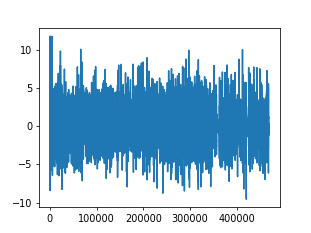

In [23]:
### Take a quick look at one of the pixel's traces
## Check for significant outliers
%matplotlib notebook

pixelNum_toUse = 300

plt.figure()
plt.plot(positions_new_sansOutliers[pixelNum_toUse,0,:])
# plt.figure()
# plt.plot(displacements[pixelNum_toUse,0,:])


In [24]:
### Display video of displacement dot-grid after outlier removal
## Just for observation purposes

positions_toUse = positions_new_absolute_sansOutliers

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = range(3) ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 1

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over


## Define random colors for points in cloud
color_tuples =  list(np.arange(positions_toUse.shape[0]))
for ii in range(positions_toUse.shape[0]):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
#     color_tuples[ii] = (0,255,255)
        
        

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    vid = imageio.get_reader(path_vid,  'ffmpeg')

    video = cv2.VideoCapture(path_vid)
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for iter_frame , new_frame in enumerate(vid):
        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, color_tuples[ii], -1)
        
        cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'vid #: {iter_vid+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.imshow('post outlier removal',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

cv2.destroyAllWindows()


KeyboardInterrupt: 

In [25]:
cv2.destroyAllWindows()

# Analysis

Below you'll find the following:
- PCA done on raw positions
- Spectral analysis of every pixels to transoform the basis to be oscillatory
- TCA done on the spectra
- A lonely t-SNE plot of the temporal factors

### PCA
The X and Y displacements are concatenated and run together. Something interesting to try would be to transform to polar coordinates, concatenate and run that way. Maybe TCA on the positions with magnitude vs angle being one of the dimensions would make sense.

<IPython.core.display.Javascript object>


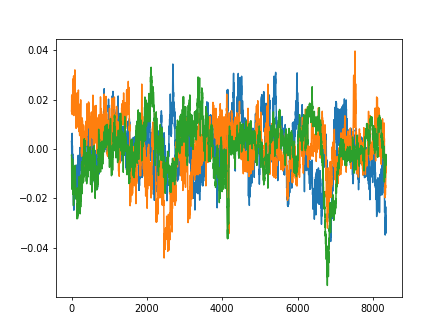

<IPython.core.display.Javascript object>


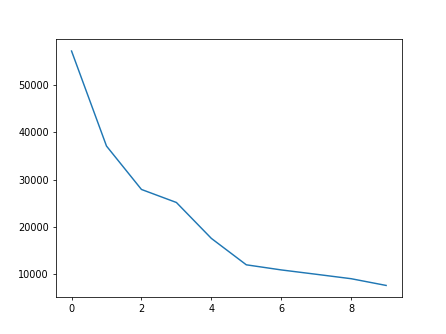

<IPython.core.display.Javascript object>


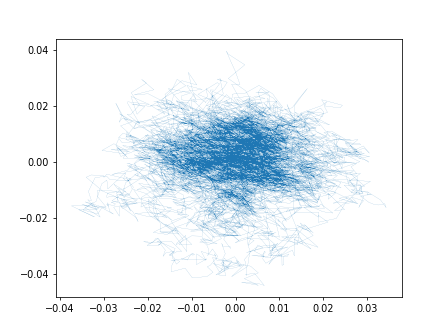

<IPython.core.display.Javascript object>


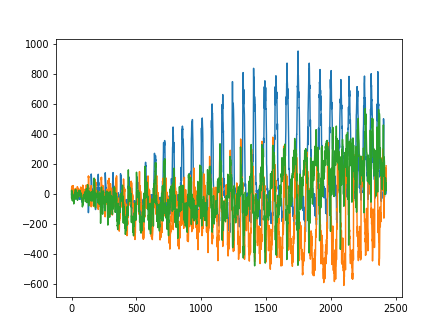

In [15]:
%matplotlib notebook
# input_dimRed = np.squeeze(positions_new_sansOutliers[:,1,:])
tmp_x = np.squeeze(positions_new_sansOutliers[:,0,:])
tmp_y = np.squeeze(positions_new_sansOutliers[:,1,:])
                   
input_dimRed_meanSub = np.concatenate((tmp_x - tmp_x.mean(1)[:,None] , tmp_y - tmp_y.mean(1)[:,None]) , axis=1 )
# input_dimRed_concat = np.concatenate( (np.squeeze(positions_new_sansOutliers[:,0,:]) , np.squeeze(positions_new_sansOutliers[:,1,:])) , axis=1)

# input_dimRed_meanSub = input_dimRed_concat - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed_concat , axis=1) , axis=1) , 1 , input_dimRed_concat.shape[1])
# input_dimRed_meanSub = input_dimRed_concat - input_dimRed_concat.mean(1)[:,None]

pca = sk.decomposition.PCA(n_components=10)
# pca = sk.decomposition.FastICA(n_components=10)
pca.fit(np.float32(input_dimRed_meanSub))
output_PCA = pca.components_.transpose()
scores_points = np.dot(input_dimRed_meanSub , output_PCA)

# plt.figure()
# plt.imshow(positions_tracked[:,])
plt.figure()
plt.plot(output_PCA[:,:3])
plt.figure()
plt.plot(pca.explained_variance_)
plt.figure()
plt.plot(output_PCA[:,0] , output_PCA[:,1]  , linewidth=.1)

plt.figure()
plt.plot(scores_points[:,:3])

In [95]:
# del input_dimRed_concat
del input_dimRed_meanSub
del tmp_x
del tmp_y
del output_PCA
gc.collect()

NameError: name 'input_dimRed_meanSub' is not defined

In [20]:
# Display PCs

positions_toUse = positions_new_absolute_sansOutliers

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = 0 ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 2

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

PC_toShow = 1
PC_toShow = PC_toShow-1

range_toUse = np.ceil(np.max(scores_points[:,PC_toShow]) - np.min(scores_points[:,PC_toShow])) + 1
offset_toUse = np.min(scores_points[:,PC_toShow])
scores_norm = scores_points[:,PC_toShow] - offset_toUse
scores_norm = (scores_norm / np.max(scores_norm)) *1000
cmap = matplotlib.cm.get_cmap('hot', 1000)


colormap_tuples =  list(np.arange(pointInds_toUse.shape[0]))
for ii in range(pointInds_toUse.shape[0]):
    colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))
        
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
save_pref = 0
if save_pref:
    out = cv2.VideoWriter('F:\RH_Local\Rich data\camera data\output.avi',fourcc, Fs, (vid_width, vid_height))
      

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    vid = imageio.get_reader(path_vid,  'ffmpeg')
        
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for iter_frame , new_frame in enumerate(vid):
        
        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
        if save_pref:
            out.write(new_frame)
            
        cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'vid #: {iter_vid+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
#         cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'PC #: {PC_toShow+1}', org=(10,100), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.imshow('PCs',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

out.release()
video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [96]:
cv2.destroyAllWindows()

### Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

In [59]:
### Parameters for multitaper short-time Fourier transform

win_len = 0.6
settings_stft =	{
    "win_len": win_len,  # duration of each STFT. Bigger values give better spectral resolution but worse temporal resolution
    "win_overlap": win_len*0.9,  # how much each Win_len window overlaps from sample to sample. ranges from 0-win_len. Bigger values mean more temporal samples
    'nw': 3,  # standardized half bandwidth. Similar tradeoffs to scaling win_len
    'ntapers': 1, # number of tapers. Keep around 1-2 for most purposes, 3 for very noisy data
    'fs': int(np.round(Fs)) } # sample rate

In [23]:
### Multitapered spectrogram for every pixel
## this code was previously parallelized, but it's pretty quick compared to the other steps, so might as well keep it simple

print(f'== Starting spectrogram calculations ==')
tic_all = time.time()

## define positions traces to use
input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]

## get parameters
win_len = settings_stft['win_len']
win_overlap = settings_stft['win_overlap']
nw = settings_stft['nw']
ntapers = settings_stft['ntapers']
fs = settings_stft['fs']

## make a single spectrogram to get some size parameters for preallocation
freqs_Sxx , t , Sxx = mtaper_specgram.mtaper_specgram(np.squeeze(input_sgram[0,0,:]) ,     
    nw=nw,
    ntapers = ntapers,
    win_len = win_len,
    win_overlap = win_overlap,
    fs=fs,
    clip=None,)

# preallocation
tic = time.time()
print(f'preallocating')
Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))  
print(f'preallocation done. Elapsed time: {round((time.time() - tic) , 2)} seconds')

print(f'starting spectrogram calculation')
for ii in range(input_sgram.shape[0]):
    ## progress tracking
    if ii%50 ==0:
        print(f'{ii} / {Sxx_allPixels.shape[0]}')
    elif ii==1:
        print(f'{ii} / {Sxx_allPixels.shape[0]}')
    
    ## iterated over x and y
    for jj in range(2):
        tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


        freqs_Sxx , t , tmp = mtaper_specgram.mtaper_specgram(tmp_input_sgram ,     
            nw=nw,
            ntapers = ntapers,
            win_len = win_len,
            win_overlap = win_overlap,
            fs=fs,
            clip=None,)
        
        ## normalization
        tmp = scipy.stats.zscore(tmp , axis=1)
        tmp = tmp - np.min(tmp , axis=1)[:,None]

        Sxx_allPixels[ii,:,:,jj] = tmp
        
print(f'completed spectrogram calculation')
print('Info about Sxx_allPixels:\n')
print(f'Shape: {Sxx_allPixels.shape}')
print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
print(f'Data type: {Sxx_allPixels.dtype}')
print(f'size of Sxx_allPixels: {round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')
print(f'== Spectrograms computed. Total elapsed time: {round((time.time() - tic_all)/60 , 2)} minutes ==')
      

In [ ]:
# gc.collect()

In [41]:
# ## wavelet scalogram for every pixel
# # IGNORE FOR NOW

# %matplotlib notebook

# tic = time.time()

# input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]


# tmp = np.squeeze(input_sgram[0,0,:])
# t = np.arange(len(tmp)) / Fs
# dt = t[1] - t[0]
# wavelet = 'cmor3-1.0'
# # wavelet = 'shan30-10.0'
# # scales_log_base = 10
# scales_expOrder = 2
# scales_start = 2 # in scales relative to 1/dt (half of nyquist)
# scales_stop = Fs
# scales_num = 50 # number of scales to use
# decimation_factor = 1

# # scales = np.logspace(math.log(scales_start,scales_log_base), math.log(scales_stop,scales_log_base), num=scales_num, base=scales_log_base)
# scales = ( (np.linspace(0 , 1 , scales_num) ** scales_expOrder) * (scales_stop - scales_start) ) + scales_start
# # print(scales)
# plt.figure()
# plt.plot(scales)
# plt.xlabel('scale ind')
# plt.ylabel('scale value')

# [Sxx, freqs_Sxx] = pywt.cwt(np.squeeze(input_sgram[0,0,:]), scales, wavelet, dt)
# Sxx = (abs(Sxx)) ** 2
# Sxx = Sxx / np.std(Sxx , axis=1)[:,None]

# plt.figure()
# plt.imshow(Sxx , aspect='auto' , cmap='hot' , origin='lower')

# # print(Sxx.shape)

# # for ii in range(input_sgram.shape[0]):
# def makeSxx(ii):
# #     if ii%5 ==0:
#     print(f'\n {ii} / {input_sgram.shape[0]}')
#     for jj in range(2):
#         tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])

#         [tmp, freqs_Sxx] = pywt.cwt(tmp_input_sgram, scales, wavelet, dt)
#         tmp = (abs(tmp)) ** 2

# #         tmp = scipy.stats.zscore(tmp , axis=1)
#         tmp = tmp / np.std(tmp , axis=1)[:,None]
# #         tmp = scipy.signal.decimate(tmp, decimation_factor, ftype='fir', axis=1, zero_phase=True)
#         tmp = tmp[:,np.uint32(np.arange(0,tmp.shape[1], decimation_factor))]
# #         tmp = tmp - np.min(tmp , axis=1)[:,None]

#         if jj==1:
#             Sxx = np.concatenate((tmp1[:,:,None] , tmp[:,:,None]) , axis=2)
#         tmp1 = tmp


# #         Sxx_allPixels[ii,:,:,jj] = tmp
#     return Sxx
# p = Pool(multiprocessing.cpu_count())
# Sxx_allPixels_list = p.map(makeSxx , list(np.arange(input_sgram.shape[0])))

# p.close()
# p.terminate()
# p.join()

# Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , np.uint32(np.ceil(Sxx.shape[1]/decimation_factor)) , 2)))
# for ii in range(len(Sxx_allPixels_list)):
#     Sxx_allPixels[ii,:,:,:] = Sxx_allPixels_list[ii]
    

# toc = time.time() - tic
# print(f'elapsed time: {toc}')

# print('Info about Sxx_allPixels:\n')
# print(f'Shape: {Sxx_allPixels.shape}')
# print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
# print(f'Data type: {Sxx_allPixels.dtype}')
# print(f'size of Sxx_allPixels: {sys.getsizeof(Sxx_allPixels)/1000000000} GB')

In [26]:
### CQT spectrogram for every pixel

print(f'== Starting CQT spectrogram calculations ==')
tic_all = time.time()

## define positions traces to use
input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]

## get parameters
hop_length = 2**4
fmin = 2
sr = Fs
bins_per_octave = 10
num_octaves = np.log2(Fs/fmin)
n_bins = int(np.floor(num_octaves * bins_per_octave))-bins_per_octave

freqs_Sxx = fmin * (2**(np.arange(n_bins) / bins_per_octave))

settings_cqt =	{
    "hop_length": hop_length,  # number of samples between successive CQT columns. Smaller values give better time resolution but worse spectral resolution
    "fmin": fmin,  # Minimum frequency computed (Hz)
    'sr': sr,  # Sampling rate (Fs)
    'bins_per_octave': bins_per_octave, # Number of bins per octave (remember that octaves are log2(frequency))
    'n_bins': n_bins } # Number of frequency bins total (max frequency is just fmin * n_bins)


## make a single CQT spectrogram to get some size parameters for preallocation
Sxx = librosa.cqt(np.squeeze(input_sgram[0,0,:]), hop_length=hop_length, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='wrap',
                     tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True, res_type=None, dtype=None)


# # preallocation
# tic = time.time()
# print(f'preallocating')
# Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))  
# print(f'preallocation done. Elapsed time: {round((time.time() - tic) , 2)} seconds')

print(f'starting spectrogram calculation')
# for ii in range(input_sgram.shape[0]):
def makeSxx(ii):
    ## progress tracking
    if ii%50 ==0:
        print(f'{ii} / {input_sgram.shape[0]}')
    elif ii==1:
        print(f'{ii} / {input_sgram.shape[0]}')
    
    ## iterated over x and y
    for jj in range(2):
        tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


        tmp = librosa.cqt(tmp_input_sgram, hop_length=hop_length, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='wrap',
                     tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True, res_type=None, dtype=None)
        
        ## normalization
        tmp = scipy.stats.zscore(abs(tmp) , axis=1)
        tmp = tmp - np.min(tmp , axis=1)[:,None]
        if jj==1:
            Sxx_tmp = np.concatenate((tmp1[:,:,None] , tmp[:,:,None]) , axis=2)
        tmp1 = tmp

    return Sxx_tmp

#         Sxx_allPixels[ii,:,:,jj] = tmp

p = Pool(multiprocessing.cpu_count())
Sxx_allPixels_list = p.map(makeSxx , list(np.arange(input_sgram.shape[0])))
p.close()
p.terminate()
p.join()

Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , np.uint32(np.ceil(Sxx.shape[1])) , 2)))
for ii in range(len(Sxx_allPixels_list)):
    Sxx_allPixels[ii,:,:,:] = Sxx_allPixels_list[ii]
    

print(f'completed spectrogram calculation')
print('Info about Sxx_allPixels:\n')
print(f'Shape: {Sxx_allPixels.shape}')
print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
print(f'Data type: {Sxx_allPixels.dtype}')
print(f'size of Sxx_allPixels: {round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')
print(f'Temporal downsample factor: {round(input_sgram.shape[2] / Sxx.shape[1], 2)}')
print(f'== Spectrograms computed. Total elapsed time: {round((time.time() - tic_all)/60 , 2)} minutes ==')

      

== Starting CQT spectrogram calculations ==
starting spectrogram calculation
0 / 820
150 / 820
1 / 820
200 / 820
50 / 820
100 / 820
300 / 820
250 / 820
350 / 820
450 / 820
400 / 820
500 / 820
600 / 820
550 / 820
650 / 820
750 / 820
700 / 820
800 / 820


completed spectrogram calculation
Info about Sxx_allPixels:

Shape: (820, 49, 29323, 2)
Number of elements: 2356396280
Data type: float32
size of Sxx_allPixels: 9.426 GB
Temporal downsample factor: 16.0
== Spectrograms computed. Total elapsed time: 1.36 minutes ==


<IPython.core.display.Javascript object>


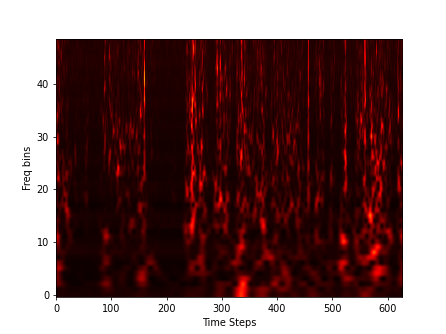

<IPython.core.display.Javascript object>


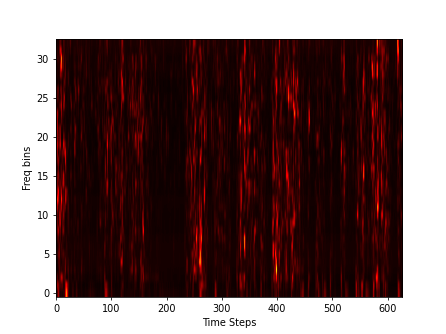

<IPython.core.display.Javascript object>


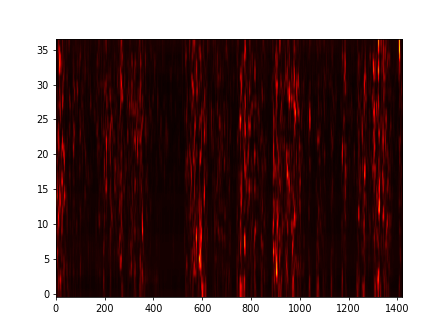

In [247]:
# import librosa
# from librosa import cqt

# %matplotlib notebook 

# hop_length = 2**4
# fmin = 2
# sr = Fs
# bins_per_octave = 10
# num_octaves = np.log2(Fs/fmin)
# n_bins = int(np.floor(num_octaves * bins_per_octave))-bins_per_octave

# settings_cqt =	{
#     "hop_length": hop_length,  # number of samples between successive CQT columns. Smaller values give better time resolution but worse spectral resolution
#     "fmin": fmin,  # Minimum frequency computed (Hz)
#     'sr': sr,  # Sampling rate (Fs)
#     'bins_per_octave': bins_per_octave, # Number of bins per octave (remember that octaves are log2(frequency))
#     'n_bins': n_bins } # Number of frequency bins total (max frequency is just fmin * n_bins)

# hop_length = settings_cqt['hop_length']
# fmin = settings_cqt['fmin']
# sr = settings_cqt['sr']
# bins_per_octave = settings_cqt['bins_per_octave']
# n_bins = settings_cqt['n_bins']

# cq_lib = librosa.cqt(np.single(np.squeeze(positions_new_sansOutliers[0,0,:10000])), hop_length=hop_length, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='wrap', tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True, res_type=None, dtype=None)
# stft_output = librosa.stft(np.single(np.squeeze(positions_new_sansOutliers[600,0,:10000])), n_fft=64, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='reflect')

# plt.figure()
# plt.imshow(scipy.stats.zscore( abs(cq_lib**2) , axis=1 ),aspect='auto', origin='lower' , cmap='hot')
# plt.xlabel('Time Steps')
# plt.ylabel('Freq bins')

# plt.figure()
# plt.imshow(scipy.stats.zscore( abs(stft_output**2) , axis=1 ),aspect='auto', origin='lower' , cmap='hot')
# plt.xlabel('Time Steps')
# plt.ylabel('Freq bins')


# ## get parameters
# win_len = 0.6
# settings_stft =	{
#     "win_len": win_len,  # duration of each STFT. Bigger values give better spectral resolution but worse temporal resolution
#     "win_overlap": win_len*0.9,  # how much each Win_len window overlaps from sample to sample. ranges from 0-win_len. Bigger values mean more temporal samples
#     'nw': 3,  # standardized half bandwidth. Similar tradeoffs to scaling win_len
#     'ntapers': 1, # number of tapers. Keep around 1-2 for most purposes, 3 for very noisy data
#     'fs': int(np.round(Fs)) } # sample rate

# win_len = settings_stft['win_len']
# win_overlap = settings_stft['win_overlap']
# nw = settings_stft['nw']
# ntapers = settings_stft['ntapers']
# fs = settings_stft['fs']

# freqs_Sxx , t , Sxx = mtaper_specgram.mtaper_specgram(np.squeeze(positions_new_sansOutliers[600,0,:10000]) ,     
#     nw=nw,
#     ntapers = ntapers,
#     win_len = win_len,
#     win_overlap = win_overlap,
#     fs=fs,
#     clip=None,)
# plt.figure()
# plt.imshow(scipy.stats.zscore(Sxx , axis=1)[:,:] , aspect='auto' , cmap='hot' , origin='lower')

<IPython.core.display.Javascript object>


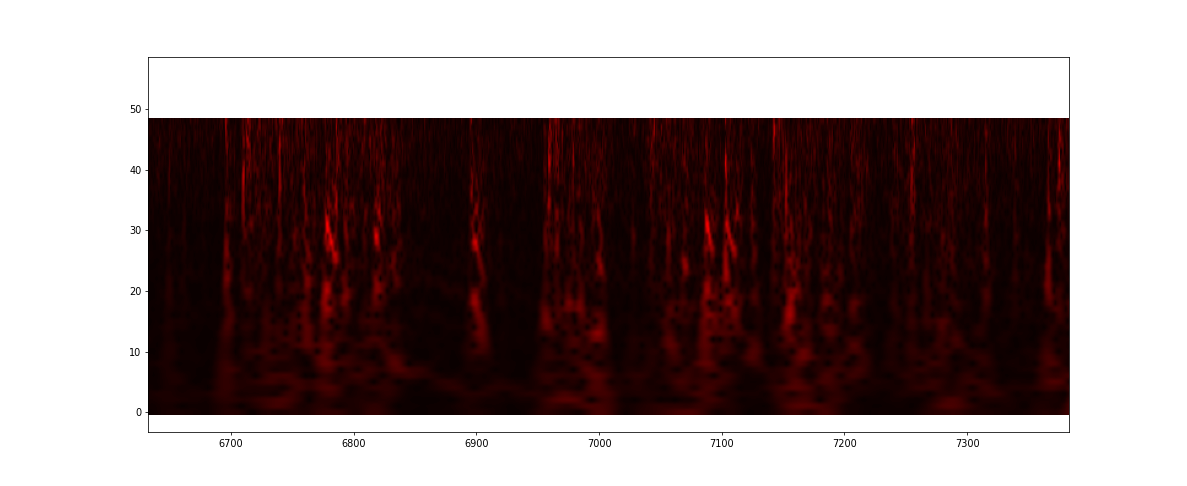

In [29]:
### Sample spectrogram

%matplotlib notebook

plt.figure()
plt.imshow(Sxx_allPixels[0,:,:,0]  , aspect='auto' , cmap='hot' , origin='lower')


### Saving & Loading before TCA

In [22]:
# settings_wavelet =	{
#     "t": t,
#     "dt": dt,
#     "wavelet": 'cmor3-1.0',
#     'scales_log_base': scales_log_base,
#     'scales_start': scales_start,
#     'scales_stop': scales_stop,
#     'scales_num': scales_num,
#     'scales': scales,
#     'decimation_factor': decimation_factor }



# save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'


# save_name = f'settings_wavelet'
# save_fullPath = f'{save_dir}/{save_name}.npy'
# np.save(save_fullPath , settings_wavelet)

In [30]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

save_name = f'settings_cqt'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , settings_cqt)

In [41]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

save_name = f'Sxx_allPixels'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , Sxx_allPixels)


save_name = f'freqs_Sxx'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , freqs_Sxx)

In [8]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

load_name = f'freqs_Sxx'
load_fullPath = f'{load_dir}/{load_name}.npy'
freqs_Sxx = np.load(load_fullPath)

load_name = f'Sxx_allPixels'
load_fullPath = f'{load_dir}/{load_name}.npy'
Sxx_allPixels = np.load(load_fullPath)

load_name = f'Fs'
load_fullPath = f'{load_dir}/{load_name}.npy'
Fs = np.load(load_fullPath)

In [9]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'

load_name = f'Sxx_allPixels_cqt'
load_fullPath = f'{load_dir}/{load_name}.npy'
Sxx_allPixels = np.load(load_fullPath)

### TCA
There are two major tensor packages, one is tensortools (made by an acquaintance named Alex Williams) and the other is Tensorly.
Tensorly seems to be more packaged up and has some options to use some advanced backends like torch, tf, and mxnet. Though there are
a couple of nice features in tensortools that Tensorly doesn't have, though. Generally tensortools gives better reconstructions, but takes
much longer to do it.

In [6]:
### TENSORTOOLS

# # input_dimRed_x = np.squeeze(positions_sansOutliers_smoothed[:,0,:])
# # input_dimRed_meanSub_x = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])
# # input_dimRed_y = np.squeeze(positions_sansOutliers_smoothed[:,1,:])
# # input_dimRed_meanSub_y = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])


# # data = np.dstack((input_dimRed_x , input_dimRed_y))# ... specify a numpy array holding the tensor you wish to fit
# data = Sxx_allPixels
# print(f'shape of data: {data.shape}')

# # Fit an ensemble of models, 4 random replicates / optimization runs per model rank
# ensemble = tt.Ensemble(fit_method="ncp_hals")
# ensemble.fit(data, ranks=range(5, 6), replicates=1)

In [7]:
# ensemble_normGram = copy.deepcopy(ensemble)
# # ensemble_lessOverlap = copy.deepcopy(ensemble)

In [8]:
# ensemble_toUse = ensemble

# fig, axes = plt.subplots(1, 2)
# tt.plot_objective(ensemble_toUse, ax=axes[0])   # plot reconstruction error as a function of num components.
# # tt.plot_similarity(ensemble_toUse, ax=axes[1])  # plot model similarity as a function of num components.
# fig.tight_layout()

In [9]:
# modelRank_toUse = 5
# modelIter_toUse = 0

# ensemble_toUse = ensemble

# plt.figure()
# # plt.plot(np.arange(ensemble_toUse.factors(4)[0][2].shape[0])/Fs , ensemble_toUse.factors(4)[0][2])
# factors_temporal = scipy.stats.zscore(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2][:,:] , axis=0)
# plt.plot(factors_temporal)
# plt.figure()
# plt.plot(f , ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][1])
# plt.figure()
# plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][3])
# plt.figure()
# plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][0])

# plt.figure()
# plt.imshow(np.corrcoef(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2].transpose()))

# input_dimRed = ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2]
# # input_dimRed_meanSub = 
# pca = sk.decomposition.PCA(n_components=modelRank_toUse-2)
# # pca = sk.decomposition.FactorAnalysis(n_components=3)
# pca.fit(input_dimRed.transpose())
# output_PCA = pca.components_.transpose()
# # scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

# plt.figure()
# plt.plot(output_PCA)

In [10]:
# del positions_new_sansOutliers
# gc.collect()

In [9]:
### Prepare Tensorly

pref_useGPU = 1


import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

tl.set_backend('pytorch')

# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.
if pref_useGPU:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  


## Prepare the input tensor
print(f'== Starting loading tensor ==')
tic = time.time()
Sxx_allPixels_tensor = tl.tensor(Sxx_allPixels[:,:,:,:], dtype=tl.float32, device=device, requires_grad=False)
print(f'== Finished loading tensor. Elapsed time: {round(time.time() - tic,2)} seconds ==')

print(f'Size of input (spectrogram): {Sxx_allPixels_tensor.shape}')

print(f'{round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')

Linux-5.4.0-54-generic-x86_64-with-glibc2.10
Python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
NumPy 1.19.2
SciPy 1.5.2
TensorLy 0.5.0
PyTorch 1.7.0
using CUDA device: 'cuda:0'
== Starting loading tensor ==
== Finished loading tensor. Elapsed time: 5.19 seconds ==
Size of input (spectrogram): torch.Size([820, 49, 29323, 2])
9.426 GB


In [10]:
### Fit TCA model
## If the input is small, set init='svd'

rank = 6

weights, factors = tensorly.decomposition.non_negative_parafac(Sxx_allPixels_tensor[:,:,:,:], init='random', tol=1e-50, n_iter_max=50000, rank=rank, verbose=True, orthogonalise=True, random_state=1234)
# weights, factors = tensorly.decomposition.non_negative_parafac(Sxx_allPixels_tensor[:,:,:,:], init='svd', tol=1e-05, n_iter_max=100, rank=rank, verbose=True,)
# weights, factors = tensorly.decomposition.parafac(Sxx_allPixels_tensor, init='random', tol=1e-05, n_iter_max=1000, rank=rank, verbose=True)

reconstruction error=0.6021748781204224
iteration 1, reconstraction error: 0.596667468547821, decrease = 0.005507409572601318
iteration 2, reconstraction error: 0.5758118033409119, decrease = 0.02085566520690918
iteration 3, reconstraction error: 0.5658503174781799, decrease = 0.009961485862731934
iteration 4, reconstraction error: 0.5601040720939636, decrease = 0.005746245384216309
iteration 5, reconstraction error: 0.5557893514633179, decrease = 0.004314720630645752
iteration 6, reconstraction error: 0.5529142022132874, decrease = 0.0028751492500305176
iteration 7, reconstraction error: 0.5504693388938904, decrease = 0.0024448633193969727
iteration 8, reconstraction error: 0.5484379529953003, decrease = 0.002031385898590088
iteration 9, reconstraction error: 0.5466405153274536, decrease = 0.0017974376678466797
iteration 10, reconstraction error: 0.5450754165649414, decrease = 0.001565098762512207
iteration 11, reconstraction error: 0.5436162352561951, decrease = 0.0014591813087463379

iteration 93, reconstraction error: 0.495497465133667, decrease = -2.1159648895263672e-05
iteration 94, reconstraction error: 0.49536311626434326, decrease = 0.00013434886932373047
iteration 95, reconstraction error: 0.49520108103752136, decrease = 0.00016203522682189941
iteration 96, reconstraction error: 0.49534210562705994, decrease = -0.00014102458953857422
iteration 97, reconstraction error: 0.49523648619651794, decrease = 0.00010561943054199219
iteration 98, reconstraction error: 0.49522289633750916, decrease = 1.3589859008789062e-05
iteration 99, reconstraction error: 0.49515482783317566, decrease = 6.80685043334961e-05
iteration 100, reconstraction error: 0.4950271248817444, decrease = 0.00012770295143127441
iteration 101, reconstraction error: 0.49500003457069397, decrease = 2.709031105041504e-05
iteration 102, reconstraction error: 0.4952724277973175, decrease = -0.00027239322662353516
iteration 103, reconstraction error: 0.49505558609962463, decrease = 0.0002168416976928711


iteration 183, reconstraction error: 0.49390965700149536, decrease = -5.9485435485839844e-05
iteration 184, reconstraction error: 0.49367767572402954, decrease = 0.0002319812774658203
iteration 185, reconstraction error: 0.49400538206100464, decrease = -0.00032770633697509766
iteration 186, reconstraction error: 0.49383464455604553, decrease = 0.00017073750495910645
iteration 187, reconstraction error: 0.4939178228378296, decrease = -8.317828178405762e-05
iteration 188, reconstraction error: 0.49359235167503357, decrease = 0.0003254711627960205
iteration 189, reconstraction error: 0.49387770891189575, decrease = -0.0002853572368621826
iteration 190, reconstraction error: 0.493854284286499, decrease = 2.3424625396728516e-05
iteration 191, reconstraction error: 0.49370819330215454, decrease = 0.00014609098434448242
iteration 192, reconstraction error: 0.4936211109161377, decrease = 8.70823860168457e-05
iteration 193, reconstraction error: 0.4936915636062622, decrease = -7.045269012451172

iteration 273, reconstraction error: 0.4933866560459137, decrease = -0.00015267729759216309
iteration 274, reconstraction error: 0.4933544099330902, decrease = 3.224611282348633e-05
iteration 275, reconstraction error: 0.49321866035461426, decrease = 0.00013574957847595215
iteration 276, reconstraction error: 0.49313583970069885, decrease = 8.282065391540527e-05
iteration 277, reconstraction error: 0.49343737959861755, decrease = -0.00030153989791870117
iteration 278, reconstraction error: 0.4931696355342865, decrease = 0.0002677440643310547
iteration 279, reconstraction error: 0.4930553436279297, decrease = 0.00011429190635681152
iteration 280, reconstraction error: 0.49337077140808105, decrease = -0.0003154277801513672
iteration 281, reconstraction error: 0.4932815134525299, decrease = 8.925795555114746e-05
iteration 282, reconstraction error: 0.49335557222366333, decrease = -7.405877113342285e-05
iteration 283, reconstraction error: 0.49314019083976746, decrease = 0.0002153813838958

iteration 363, reconstraction error: 0.49283844232559204, decrease = -1.9848346710205078e-05
iteration 364, reconstraction error: 0.4928900897502899, decrease = -5.1647424697875977e-05
iteration 365, reconstraction error: 0.49288007616996765, decrease = 1.0013580322265625e-05
iteration 366, reconstraction error: 0.49277615547180176, decrease = 0.00010392069816589355
iteration 367, reconstraction error: 0.49283385276794434, decrease = -5.7697296142578125e-05
iteration 368, reconstraction error: 0.4929133951663971, decrease = -7.954239845275879e-05
iteration 369, reconstraction error: 0.4928200840950012, decrease = 9.331107139587402e-05
iteration 370, reconstraction error: 0.4928879737854004, decrease = -6.788969039916992e-05
iteration 371, reconstraction error: 0.4928886592388153, decrease = -6.854534149169922e-07
iteration 372, reconstraction error: 0.4929266571998596, decrease = -3.7997961044311523e-05
iteration 373, reconstraction error: 0.4928300976753235, decrease = 9.6559524536132

iteration 453, reconstraction error: 0.4924364387989044, decrease = 0.00017181038856506348
iteration 454, reconstraction error: 0.49263450503349304, decrease = -0.00019806623458862305
iteration 455, reconstraction error: 0.49259957671165466, decrease = 3.4928321838378906e-05
iteration 456, reconstraction error: 0.4925564229488373, decrease = 4.315376281738281e-05
iteration 457, reconstraction error: 0.49267253279685974, decrease = -0.00011610984802246094
iteration 458, reconstraction error: 0.4925142526626587, decrease = 0.0001582801342010498
iteration 459, reconstraction error: 0.49257802963256836, decrease = -6.377696990966797e-05
iteration 460, reconstraction error: 0.4925324320793152, decrease = 4.559755325317383e-05
iteration 461, reconstraction error: 0.4926958680152893, decrease = -0.0001634359359741211
iteration 462, reconstraction error: 0.4925480782985687, decrease = 0.00014778971672058105
iteration 463, reconstraction error: 0.4925844967365265, decrease = -3.641843795776367e

iteration 543, reconstraction error: 0.49233683943748474, decrease = 0.00032079219818115234
iteration 544, reconstraction error: 0.49255678057670593, decrease = -0.0002199411392211914
iteration 545, reconstraction error: 0.4923279285430908, decrease = 0.0002288520336151123
iteration 546, reconstraction error: 0.4924873411655426, decrease = -0.00015941262245178223
iteration 547, reconstraction error: 0.4926482141017914, decrease = -0.0001608729362487793
iteration 548, reconstraction error: 0.49241364002227783, decrease = 0.0002345740795135498
iteration 549, reconstraction error: 0.4924018085002899, decrease = 1.1831521987915039e-05
iteration 550, reconstraction error: 0.49259310960769653, decrease = -0.0001913011074066162
iteration 551, reconstraction error: 0.49228668212890625, decrease = 0.0003064274787902832
iteration 552, reconstraction error: 0.4926750063896179, decrease = -0.0003883242607116699
iteration 553, reconstraction error: 0.49230536818504333, decrease = 0.0003696382045745

iteration 633, reconstraction error: 0.4926243722438812, decrease = -0.00030809640884399414
iteration 634, reconstraction error: 0.4923080503940582, decrease = 0.00031632184982299805
iteration 635, reconstraction error: 0.49248722195625305, decrease = -0.00017917156219482422
iteration 636, reconstraction error: 0.49229878187179565, decrease = 0.00018844008445739746
iteration 637, reconstraction error: 0.49253565073013306, decrease = -0.00023686885833740234
iteration 638, reconstraction error: 0.49229398369789124, decrease = 0.0002416670322418213
iteration 639, reconstraction error: 0.4924798011779785, decrease = -0.00018581748008728027
iteration 640, reconstraction error: 0.49243688583374023, decrease = 4.291534423828125e-05
iteration 641, reconstraction error: 0.4925118684768677, decrease = -7.49826431274414e-05
iteration 642, reconstraction error: 0.492422491312027, decrease = 8.937716484069824e-05
iteration 643, reconstraction error: 0.49258437752723694, decrease = -0.00016188621520

iteration 723, reconstraction error: 0.4924966096878052, decrease = -0.00023764371871948242
iteration 724, reconstraction error: 0.4923579692840576, decrease = 0.0001386404037475586
iteration 725, reconstraction error: 0.4925075173377991, decrease = -0.00014954805374145508
iteration 726, reconstraction error: 0.4923185110092163, decrease = 0.00018900632858276367
iteration 727, reconstraction error: 0.49246254563331604, decrease = -0.00014403462409973145
iteration 728, reconstraction error: 0.4924528896808624, decrease = 9.655952453613281e-06
iteration 729, reconstraction error: 0.4923746585845947, decrease = 7.82310962677002e-05
iteration 730, reconstraction error: 0.4922558069229126, decrease = 0.0001188516616821289
iteration 731, reconstraction error: 0.49236854910850525, decrease = -0.00011274218559265137
iteration 732, reconstraction error: 0.4924386739730835, decrease = -7.012486457824707e-05
iteration 733, reconstraction error: 0.49228334426879883, decrease = 0.000155329704284667

iteration 813, reconstraction error: 0.49247467517852783, decrease = -0.0003534853458404541
iteration 814, reconstraction error: 0.4922115206718445, decrease = 0.0002631545066833496
iteration 815, reconstraction error: 0.49252039194107056, decrease = -0.0003088712692260742
iteration 816, reconstraction error: 0.4921930730342865, decrease = 0.0003273189067840576
iteration 817, reconstraction error: 0.4923814535140991, decrease = -0.00018838047981262207
iteration 818, reconstraction error: 0.4922151267528534, decrease = 0.00016632676124572754
iteration 819, reconstraction error: 0.4924464523792267, decrease = -0.00023132562637329102
iteration 820, reconstraction error: 0.4922003149986267, decrease = 0.0002461373805999756
iteration 821, reconstraction error: 0.4924640357494354, decrease = -0.0002637207508087158
iteration 822, reconstraction error: 0.4923499822616577, decrease = 0.00011405348777770996
iteration 823, reconstraction error: 0.4924061596393585, decrease = -5.6177377700805664e-

iteration 903, reconstraction error: 0.4920346736907959, decrease = 0.0005710124969482422
iteration 904, reconstraction error: 0.49234530329704285, decrease = -0.00031062960624694824
iteration 905, reconstraction error: 0.49233508110046387, decrease = 1.0222196578979492e-05
iteration 906, reconstraction error: 0.49238792061805725, decrease = -5.283951759338379e-05
iteration 907, reconstraction error: 0.4923730194568634, decrease = 1.4901161193847656e-05
iteration 908, reconstraction error: 0.4922279417514801, decrease = 0.00014507770538330078
iteration 909, reconstraction error: 0.49238649010658264, decrease = -0.00015854835510253906
iteration 910, reconstraction error: 0.49215811491012573, decrease = 0.00022837519645690918
iteration 911, reconstraction error: 0.49246370792388916, decrease = -0.00030559301376342773
iteration 912, reconstraction error: 0.4921446740627289, decrease = 0.0003190338611602783
iteration 913, reconstraction error: 0.49252375960350037, decrease = -0.00037908554

iteration 993, reconstraction error: 0.4924882650375366, decrease = -0.000350266695022583
iteration 994, reconstraction error: 0.4922453463077545, decrease = 0.0002429187297821045
iteration 995, reconstraction error: 0.4922749102115631, decrease = -2.956390380859375e-05
iteration 996, reconstraction error: 0.49228164553642273, decrease = -6.735324859619141e-06
iteration 997, reconstraction error: 0.49249306321144104, decrease = -0.00021141767501831055
iteration 998, reconstraction error: 0.49219831824302673, decrease = 0.00029474496841430664
iteration 999, reconstraction error: 0.4924059212207794, decrease = -0.00020760297775268555
iteration 1000, reconstraction error: 0.49221208691596985, decrease = 0.0001938343048095703
iteration 1001, reconstraction error: 0.492348849773407, decrease = -0.0001367628574371338
iteration 1002, reconstraction error: 0.492296427488327, decrease = 5.2422285079956055e-05
iteration 1003, reconstraction error: 0.49244341254234314, decrease = -0.0001469850540

iteration 1082, reconstraction error: 0.4922622740268707, decrease = 0.00017249584197998047
iteration 1083, reconstraction error: 0.49236980080604553, decrease = -0.00010752677917480469
iteration 1084, reconstraction error: 0.49233707785606384, decrease = 3.272294998168945e-05
iteration 1085, reconstraction error: 0.4923182725906372, decrease = 1.8805265426635742e-05
iteration 1086, reconstraction error: 0.49239712953567505, decrease = -7.88569450378418e-05
iteration 1087, reconstraction error: 0.49226683378219604, decrease = 0.0001302957534790039
iteration 1088, reconstraction error: 0.49226507544517517, decrease = 1.7583370208740234e-06
iteration 1089, reconstraction error: 0.49234506487846375, decrease = -7.998943328857422e-05
iteration 1090, reconstraction error: 0.49233952164649963, decrease = 5.543231964111328e-06
iteration 1091, reconstraction error: 0.49229666590690613, decrease = 4.285573959350586e-05
iteration 1092, reconstraction error: 0.4924079179763794, decrease = -0.0001

iteration 1171, reconstraction error: 0.4923143684864044, decrease = -0.00010403990745544434
iteration 1172, reconstraction error: 0.49228090047836304, decrease = 3.3468008041381836e-05
iteration 1173, reconstraction error: 0.49230238795280457, decrease = -2.148747444152832e-05
iteration 1174, reconstraction error: 0.49231112003326416, decrease = -8.732080459594727e-06
iteration 1175, reconstraction error: 0.49235713481903076, decrease = -4.601478576660156e-05
iteration 1176, reconstraction error: 0.49224546551704407, decrease = 0.00011166930198669434
iteration 1177, reconstraction error: 0.49233850836753845, decrease = -9.304285049438477e-05
iteration 1178, reconstraction error: 0.49214622378349304, decrease = 0.00019228458404541016
iteration 1179, reconstraction error: 0.49237358570098877, decrease = -0.00022736191749572754
iteration 1180, reconstraction error: 0.49216970801353455, decrease = 0.00020387768745422363
iteration 1181, reconstraction error: 0.4923413097858429, decrease = 

iteration 1260, reconstraction error: 0.4923250675201416, decrease = -0.00011017918586730957
iteration 1261, reconstraction error: 0.4922639727592468, decrease = 6.109476089477539e-05
iteration 1262, reconstraction error: 0.4921835958957672, decrease = 8.037686347961426e-05
iteration 1263, reconstraction error: 0.4923672378063202, decrease = -0.00018364191055297852
iteration 1264, reconstraction error: 0.4921383261680603, decrease = 0.0002289116382598877
iteration 1265, reconstraction error: 0.4923006594181061, decrease = -0.00016233325004577637
iteration 1266, reconstraction error: 0.49221089482307434, decrease = 8.976459503173828e-05
iteration 1267, reconstraction error: 0.49240416288375854, decrease = -0.0001932680606842041
iteration 1268, reconstraction error: 0.49220097064971924, decrease = 0.00020319223403930664
iteration 1269, reconstraction error: 0.49231237173080444, decrease = -0.00011140108108520508
iteration 1270, reconstraction error: 0.49229079484939575, decrease = 2.1576

iteration 1349, reconstraction error: 0.4924094080924988, decrease = -0.00011405348777770996
iteration 1350, reconstraction error: 0.49218907952308655, decrease = 0.00022032856941223145
iteration 1351, reconstraction error: 0.4922785460948944, decrease = -8.946657180786133e-05
iteration 1352, reconstraction error: 0.49232107400894165, decrease = -4.252791404724121e-05
iteration 1353, reconstraction error: 0.49228164553642273, decrease = 3.94284725189209e-05
iteration 1354, reconstraction error: 0.49234867095947266, decrease = -6.702542304992676e-05
iteration 1355, reconstraction error: 0.49217090010643005, decrease = 0.00017777085304260254
iteration 1356, reconstraction error: 0.49229592084884644, decrease = -0.00012502074241638184
iteration 1357, reconstraction error: 0.4922669529914856, decrease = 2.8967857360839844e-05
iteration 1358, reconstraction error: 0.49238911271095276, decrease = -0.00012215971946716309
iteration 1359, reconstraction error: 0.49220454692840576, decrease = 0.

iteration 1438, reconstraction error: 0.492221862077713, decrease = 5.799531936645508e-05
iteration 1439, reconstraction error: 0.4923531711101532, decrease = -0.00013130903244018555
iteration 1440, reconstraction error: 0.49221131205558777, decrease = 0.0001418590545654297
iteration 1441, reconstraction error: 0.49234530329704285, decrease = -0.00013399124145507812
iteration 1442, reconstraction error: 0.4921839237213135, decrease = 0.00016137957572937012
iteration 1443, reconstraction error: 0.4923061430454254, decrease = -0.00012221932411193848
iteration 1444, reconstraction error: 0.4922270178794861, decrease = 7.912516593933105e-05
iteration 1445, reconstraction error: 0.4922715127468109, decrease = -4.44948673248291e-05
iteration 1446, reconstraction error: 0.4922872483730316, decrease = -1.5735626220703125e-05
iteration 1447, reconstraction error: 0.4922509491443634, decrease = 3.629922866821289e-05
iteration 1448, reconstraction error: 0.49234411120414734, decrease = -9.3162059

iteration 1527, reconstraction error: 0.4922863245010376, decrease = 8.681416511535645e-05
iteration 1528, reconstraction error: 0.4922006130218506, decrease = 8.571147918701172e-05
iteration 1529, reconstraction error: 0.4921773672103882, decrease = 2.3245811462402344e-05
iteration 1530, reconstraction error: 0.4922962188720703, decrease = -0.0001188516616821289
iteration 1531, reconstraction error: 0.4922254681587219, decrease = 7.075071334838867e-05
iteration 1532, reconstraction error: 0.49225541949272156, decrease = -2.995133399963379e-05
iteration 1533, reconstraction error: 0.4921872913837433, decrease = 6.812810897827148e-05
iteration 1534, reconstraction error: 0.4923725426197052, decrease = -0.00018525123596191406
iteration 1535, reconstraction error: 0.4921816885471344, decrease = 0.00019085407257080078
iteration 1536, reconstraction error: 0.49242717027664185, decrease = -0.0002454817295074463
iteration 1537, reconstraction error: 0.49214690923690796, decrease = 0.000280261

iteration 1616, reconstraction error: 0.4923705458641052, decrease = -0.00029408931732177734
iteration 1617, reconstraction error: 0.4921819269657135, decrease = 0.00018861889839172363
iteration 1618, reconstraction error: 0.4923211932182312, decrease = -0.0001392662525177002
iteration 1619, reconstraction error: 0.49228787422180176, decrease = 3.331899642944336e-05
iteration 1620, reconstraction error: 0.4922226667404175, decrease = 6.520748138427734e-05
iteration 1621, reconstraction error: 0.49216678738594055, decrease = 5.587935447692871e-05
iteration 1622, reconstraction error: 0.49244067072868347, decrease = -0.0002738833427429199
iteration 1623, reconstraction error: 0.4920942187309265, decrease = 0.000346451997756958
iteration 1624, reconstraction error: 0.4923034608364105, decrease = -0.0002092421054840088
iteration 1625, reconstraction error: 0.49215397238731384, decrease = 0.0001494884490966797
iteration 1626, reconstraction error: 0.4923116862773895, decrease = -0.000157713

iteration 1705, reconstraction error: 0.4920223355293274, decrease = 0.00035902857780456543
iteration 1706, reconstraction error: 0.49229779839515686, decrease = -0.0002754628658294678
iteration 1707, reconstraction error: 0.49216169118881226, decrease = 0.0001361072063446045
iteration 1708, reconstraction error: 0.4924047291278839, decrease = -0.00024303793907165527
iteration 1709, reconstraction error: 0.49212729930877686, decrease = 0.00027742981910705566
iteration 1710, reconstraction error: 0.4923116862773895, decrease = -0.0001843869686126709
iteration 1711, reconstraction error: 0.49218541383743286, decrease = 0.00012627243995666504
iteration 1712, reconstraction error: 0.4921899139881134, decrease = -4.500150680541992e-06
iteration 1713, reconstraction error: 0.49226588010787964, decrease = -7.596611976623535e-05
iteration 1714, reconstraction error: 0.4924519658088684, decrease = -0.00018608570098876953
iteration 1715, reconstraction error: 0.49207398295402527, decrease = 0.00

iteration 1794, reconstraction error: 0.4921652376651764, decrease = -3.74913215637207e-05
iteration 1795, reconstraction error: 0.4922877550125122, decrease = -0.00012251734733581543
iteration 1796, reconstraction error: 0.4922206699848175, decrease = 6.708502769470215e-05
iteration 1797, reconstraction error: 0.49216243624687195, decrease = 5.823373794555664e-05
iteration 1798, reconstraction error: 0.49233609437942505, decrease = -0.00017365813255310059
iteration 1799, reconstraction error: 0.4922286570072174, decrease = 0.0001074373722076416
iteration 1800, reconstraction error: 0.4921751320362091, decrease = 5.352497100830078e-05
iteration 1801, reconstraction error: 0.4923534095287323, decrease = -0.00017827749252319336
iteration 1802, reconstraction error: 0.49215376377105713, decrease = 0.0001996457576751709
iteration 1803, reconstraction error: 0.4921104907989502, decrease = 4.3272972106933594e-05
iteration 1804, reconstraction error: 0.4921768307685852, decrease = -6.63399696

iteration 1883, reconstraction error: 0.49237558245658875, decrease = -0.0003650784492492676
iteration 1884, reconstraction error: 0.4920503795146942, decrease = 0.00032520294189453125
iteration 1885, reconstraction error: 0.4923114776611328, decrease = -0.00026109814643859863
iteration 1886, reconstraction error: 0.49208611249923706, decrease = 0.00022536516189575195
iteration 1887, reconstraction error: 0.4922769069671631, decrease = -0.0001907944679260254
iteration 1888, reconstraction error: 0.49235352873802185, decrease = -7.662177085876465e-05
iteration 1889, reconstraction error: 0.4920377731323242, decrease = 0.00031575560569763184
iteration 1890, reconstraction error: 0.4922972321510315, decrease = -0.0002594590187072754
iteration 1891, reconstraction error: 0.49215781688690186, decrease = 0.00013941526412963867
iteration 1892, reconstraction error: 0.49231448769569397, decrease = -0.00015667080879211426
iteration 1893, reconstraction error: 0.4923132359981537, decrease = 1.25

iteration 1972, reconstraction error: 0.492279976606369, decrease = 6.794929504394531e-06
iteration 1973, reconstraction error: 0.4922224283218384, decrease = 5.754828453063965e-05
iteration 1974, reconstraction error: 0.4921630024909973, decrease = 5.942583084106445e-05
iteration 1975, reconstraction error: 0.49227142333984375, decrease = -0.00010842084884643555
iteration 1976, reconstraction error: 0.4921928346157074, decrease = 7.858872413635254e-05
iteration 1977, reconstraction error: 0.4921687841415405, decrease = 2.4050474166870117e-05
iteration 1978, reconstraction error: 0.49237489700317383, decrease = -0.00020611286163330078
iteration 1979, reconstraction error: 0.4921955168247223, decrease = 0.00017938017845153809
iteration 1980, reconstraction error: 0.49220889806747437, decrease = -1.3381242752075195e-05
iteration 1981, reconstraction error: 0.4923228323459625, decrease = -0.00011393427848815918
iteration 1982, reconstraction error: 0.49215713143348694, decrease = 0.000165

iteration 2061, reconstraction error: 0.49211227893829346, decrease = 0.00015336275100708008
iteration 2062, reconstraction error: 0.49216723442077637, decrease = -5.4955482482910156e-05
iteration 2063, reconstraction error: 0.49221551418304443, decrease = -4.8279762268066406e-05
iteration 2064, reconstraction error: 0.4922133684158325, decrease = 2.1457672119140625e-06
iteration 2065, reconstraction error: 0.49222901463508606, decrease = -1.564621925354004e-05
iteration 2066, reconstraction error: 0.49226319789886475, decrease = -3.4183263778686523e-05
iteration 2067, reconstraction error: 0.49213072657585144, decrease = 0.00013247132301330566
iteration 2068, reconstraction error: 0.4922466278076172, decrease = -0.00011590123176574707
iteration 2069, reconstraction error: 0.4921611249446869, decrease = 8.550286293029785e-05
iteration 2070, reconstraction error: 0.49223700165748596, decrease = -7.587671279907227e-05
iteration 2071, reconstraction error: 0.4921989440917969, decrease = 3

iteration 2150, reconstraction error: 0.49214500188827515, decrease = 0.0001633763313293457
iteration 2151, reconstraction error: 0.49225354194641113, decrease = -0.00010854005813598633
iteration 2152, reconstraction error: 0.49224570393562317, decrease = 7.838010787963867e-06
iteration 2153, reconstraction error: 0.4920971393585205, decrease = 0.00014856457710266113
iteration 2154, reconstraction error: 0.49229079484939575, decrease = -0.00019365549087524414
iteration 2155, reconstraction error: 0.4920353591442108, decrease = 0.0002554357051849365
iteration 2156, reconstraction error: 0.4923935830593109, decrease = -0.00035822391510009766
iteration 2157, reconstraction error: 0.4919934868812561, decrease = 0.00040009617805480957
iteration 2158, reconstraction error: 0.4923704266548157, decrease = -0.0003769397735595703
iteration 2159, reconstraction error: 0.49206626415252686, decrease = 0.00030416250228881836
iteration 2160, reconstraction error: 0.4922751784324646, decrease = -0.000

iteration 2239, reconstraction error: 0.49202942848205566, decrease = 0.0002663731575012207
iteration 2240, reconstraction error: 0.4922941029071808, decrease = -0.00026467442512512207
iteration 2241, reconstraction error: 0.4920025169849396, decrease = 0.00029158592224121094
iteration 2242, reconstraction error: 0.492205411195755, decrease = -0.0002028942108154297
iteration 2243, reconstraction error: 0.4921506643295288, decrease = 5.474686622619629e-05
iteration 2244, reconstraction error: 0.4922311305999756, decrease = -8.046627044677734e-05
iteration 2245, reconstraction error: 0.49223002791404724, decrease = 1.1026859283447266e-06
iteration 2246, reconstraction error: 0.4922172427177429, decrease = 1.2785196304321289e-05
iteration 2247, reconstraction error: 0.49216428399086, decrease = 5.295872688293457e-05
iteration 2248, reconstraction error: 0.4922557473182678, decrease = -9.146332740783691e-05
iteration 2249, reconstraction error: 0.49217894673347473, decrease = 7.68005847930

iteration 2328, reconstraction error: 0.4922291338443756, decrease = -4.416704177856445e-05
iteration 2329, reconstraction error: 0.4923839271068573, decrease = -0.00015479326248168945
iteration 2330, reconstraction error: 0.49201786518096924, decrease = 0.0003660619258880615
iteration 2331, reconstraction error: 0.4923076927661896, decrease = -0.0002898275852203369
iteration 2332, reconstraction error: 0.49226272106170654, decrease = 4.4971704483032227e-05
iteration 2333, reconstraction error: 0.49220678210258484, decrease = 5.59389591217041e-05
iteration 2334, reconstraction error: 0.4922952353954315, decrease = -8.845329284667969e-05
iteration 2335, reconstraction error: 0.49204114079475403, decrease = 0.00025409460067749023
iteration 2336, reconstraction error: 0.49235454201698303, decrease = -0.0003134012222290039
iteration 2337, reconstraction error: 0.4922197461128235, decrease = 0.0001347959041595459
iteration 2338, reconstraction error: 0.4921436309814453, decrease = 7.6115131

iteration 2417, reconstraction error: 0.49224650859832764, decrease = -2.473592758178711e-06
iteration 2418, reconstraction error: 0.4921332895755768, decrease = 0.00011321902275085449
iteration 2419, reconstraction error: 0.49220022559165955, decrease = -6.693601608276367e-05
iteration 2420, reconstraction error: 0.49219363927841187, decrease = 6.586313247680664e-06
iteration 2421, reconstraction error: 0.4922690689563751, decrease = -7.542967796325684e-05
iteration 2422, reconstraction error: 0.4921792447566986, decrease = 8.982419967651367e-05
iteration 2423, reconstraction error: 0.4921073615550995, decrease = 7.18832015991211e-05
iteration 2424, reconstraction error: 0.4922778606414795, decrease = -0.00017049908638000488
iteration 2425, reconstraction error: 0.4922322630882263, decrease = 4.559755325317383e-05
iteration 2426, reconstraction error: 0.4921378791332245, decrease = 9.438395500183105e-05
iteration 2427, reconstraction error: 0.49219822883605957, decrease = -6.034970283

iteration 2506, reconstraction error: 0.49237021803855896, decrease = -0.0003026723861694336
iteration 2507, reconstraction error: 0.49198800325393677, decrease = 0.0003822147846221924
iteration 2508, reconstraction error: 0.4924311935901642, decrease = -0.000443190336227417
iteration 2509, reconstraction error: 0.4920795261859894, decrease = 0.0003516674041748047
iteration 2510, reconstraction error: 0.49234798550605774, decrease = -0.0002684593200683594
iteration 2511, reconstraction error: 0.491987943649292, decrease = 0.00036004185676574707
iteration 2512, reconstraction error: 0.49230676889419556, decrease = -0.00031882524490356445
iteration 2513, reconstraction error: 0.492100328207016, decrease = 0.00020644068717956543
iteration 2514, reconstraction error: 0.49236878752708435, decrease = -0.0002684593200683594
iteration 2515, reconstraction error: 0.49201226234436035, decrease = 0.000356525182723999
iteration 2516, reconstraction error: 0.4922597408294678, decrease = -0.00024747

iteration 2595, reconstraction error: 0.49220508337020874, decrease = -0.0002016127109527588
iteration 2596, reconstraction error: 0.4921376407146454, decrease = 6.744265556335449e-05
iteration 2597, reconstraction error: 0.4922812283039093, decrease = -0.00014358758926391602
iteration 2598, reconstraction error: 0.4921128451824188, decrease = 0.00016838312149047852
iteration 2599, reconstraction error: 0.4922834038734436, decrease = -0.00017055869102478027
iteration 2600, reconstraction error: 0.4921155869960785, decrease = 0.0001678168773651123
iteration 2601, reconstraction error: 0.4922270178794861, decrease = -0.00011143088340759277
iteration 2602, reconstraction error: 0.4921294152736664, decrease = 9.760260581970215e-05
iteration 2603, reconstraction error: 0.4921739399433136, decrease = -4.45246696472168e-05
iteration 2604, reconstraction error: 0.49223947525024414, decrease = -6.553530693054199e-05
iteration 2605, reconstraction error: 0.4921844005584717, decrease = 5.50746917

iteration 2684, reconstraction error: 0.4921475350856781, decrease = 0.000126570463180542
iteration 2685, reconstraction error: 0.4922637641429901, decrease = -0.00011622905731201172
iteration 2686, reconstraction error: 0.49213671684265137, decrease = 0.00012704730033874512
iteration 2687, reconstraction error: 0.49211451411247253, decrease = 2.2202730178833008e-05
iteration 2688, reconstraction error: 0.4923422038555145, decrease = -0.0002276897430419922
iteration 2689, reconstraction error: 0.4921244978904724, decrease = 0.00021770596504211426
iteration 2690, reconstraction error: 0.492213636636734, decrease = -8.913874626159668e-05
iteration 2691, reconstraction error: 0.49218684434890747, decrease = 2.6792287826538086e-05
iteration 2692, reconstraction error: 0.4921948313713074, decrease = -7.987022399902344e-06
iteration 2693, reconstraction error: 0.49224627017974854, decrease = -5.143880844116211e-05
iteration 2694, reconstraction error: 0.4921801686286926, decrease = 6.6101551

iteration 2773, reconstraction error: 0.49221935868263245, decrease = -0.00020930171012878418
iteration 2774, reconstraction error: 0.49230968952178955, decrease = -9.033083915710449e-05
iteration 2775, reconstraction error: 0.49223804473876953, decrease = 7.164478302001953e-05
iteration 2776, reconstraction error: 0.4920569658279419, decrease = 0.00018107891082763672
iteration 2777, reconstraction error: 0.49233976006507874, decrease = -0.0002827942371368408
iteration 2778, reconstraction error: 0.49198246002197266, decrease = 0.0003573000431060791
iteration 2779, reconstraction error: 0.4922678768634796, decrease = -0.000285416841506958
iteration 2780, reconstraction error: 0.49214479327201843, decrease = 0.00012308359146118164
iteration 2781, reconstraction error: 0.492199182510376, decrease = -5.4389238357543945e-05
iteration 2782, reconstraction error: 0.49220821261405945, decrease = -9.03010368347168e-06
iteration 2783, reconstraction error: 0.49219027161598206, decrease = 1.7940

iteration 2862, reconstraction error: 0.4921901524066925, decrease = 1.6063451766967773e-05
iteration 2863, reconstraction error: 0.49218860268592834, decrease = 1.5497207641601562e-06
iteration 2864, reconstraction error: 0.49212804436683655, decrease = 6.0558319091796875e-05
iteration 2865, reconstraction error: 0.4923311769962311, decrease = -0.00020313262939453125
iteration 2866, reconstraction error: 0.4922226667404175, decrease = 0.00010851025581359863
iteration 2867, reconstraction error: 0.49200883507728577, decrease = 0.00021383166313171387
iteration 2868, reconstraction error: 0.49226483702659607, decrease = -0.00025600194931030273
iteration 2869, reconstraction error: 0.4922383725643158, decrease = 2.6464462280273438e-05
iteration 2870, reconstraction error: 0.49208131432533264, decrease = 0.0001570582389831543
iteration 2871, reconstraction error: 0.4922599792480469, decrease = -0.0001786649227142334
iteration 2872, reconstraction error: 0.49205324053764343, decrease = 0.00

iteration 2951, reconstraction error: 0.49221736192703247, decrease = -0.00012376904487609863
iteration 2952, reconstraction error: 0.4922085702419281, decrease = 8.791685104370117e-06
iteration 2953, reconstraction error: 0.4922534227371216, decrease = -4.4852495193481445e-05
iteration 2954, reconstraction error: 0.4921634793281555, decrease = 8.994340896606445e-05
iteration 2955, reconstraction error: 0.49223044514656067, decrease = -6.696581840515137e-05
iteration 2956, reconstraction error: 0.4920526146888733, decrease = 0.00017783045768737793
iteration 2957, reconstraction error: 0.4923340380191803, decrease = -0.00028142333030700684
iteration 2958, reconstraction error: 0.49215880036354065, decrease = 0.00017523765563964844
iteration 2959, reconstraction error: 0.49232885241508484, decrease = -0.00017005205154418945
iteration 2960, reconstraction error: 0.4921436309814453, decrease = 0.00018522143363952637
iteration 2961, reconstraction error: 0.492207407951355, decrease = -6.377

iteration 3040, reconstraction error: 0.4921242594718933, decrease = 0.0001055598258972168
iteration 3041, reconstraction error: 0.49219954013824463, decrease = -7.528066635131836e-05
iteration 3042, reconstraction error: 0.4921844005584717, decrease = 1.5139579772949219e-05
iteration 3043, reconstraction error: 0.49213072657585144, decrease = 5.367398262023926e-05
iteration 3044, reconstraction error: 0.4921683967113495, decrease = -3.7670135498046875e-05
iteration 3045, reconstraction error: 0.4921974241733551, decrease = -2.9027462005615234e-05
iteration 3046, reconstraction error: 0.492233008146286, decrease = -3.55839729309082e-05
iteration 3047, reconstraction error: 0.492133766412735, decrease = 9.924173355102539e-05
iteration 3048, reconstraction error: 0.4921504557132721, decrease = -1.6689300537109375e-05
iteration 3049, reconstraction error: 0.4921763837337494, decrease = -2.5928020477294922e-05
iteration 3050, reconstraction error: 0.4922671914100647, decrease = -9.08076763

iteration 3129, reconstraction error: 0.4920668303966522, decrease = 0.0002585947513580322
iteration 3130, reconstraction error: 0.4923080503940582, decrease = -0.00024121999740600586
iteration 3131, reconstraction error: 0.4923190772533417, decrease = -1.1026859283447266e-05
iteration 3132, reconstraction error: 0.49198558926582336, decrease = 0.00033348798751831055
iteration 3133, reconstraction error: 0.4923679828643799, decrease = -0.00038239359855651855
iteration 3134, reconstraction error: 0.49189114570617676, decrease = 0.000476837158203125
iteration 3135, reconstraction error: 0.4922420382499695, decrease = -0.0003508925437927246
iteration 3136, reconstraction error: 0.4922591745853424, decrease = -1.7136335372924805e-05
iteration 3137, reconstraction error: 0.4921318590641022, decrease = 0.00012731552124023438
iteration 3138, reconstraction error: 0.49212872982025146, decrease = 3.129243850708008e-06
iteration 3139, reconstraction error: 0.4923287332057953, decrease = -0.00020

iteration 3218, reconstraction error: 0.492125928401947, decrease = 0.00010451674461364746
iteration 3219, reconstraction error: 0.4921591281890869, decrease = -3.319978713989258e-05
iteration 3220, reconstraction error: 0.49213719367980957, decrease = 2.193450927734375e-05
iteration 3221, reconstraction error: 0.49219414591789246, decrease = -5.695223808288574e-05
iteration 3222, reconstraction error: 0.49209970235824585, decrease = 9.444355964660645e-05
iteration 3223, reconstraction error: 0.49229854345321655, decrease = -0.00019884109497070312
iteration 3224, reconstraction error: 0.4921109080314636, decrease = 0.0001876354217529297
iteration 3225, reconstraction error: 0.4921792447566986, decrease = -6.833672523498535e-05
iteration 3226, reconstraction error: 0.4921180307865143, decrease = 6.121397018432617e-05
iteration 3227, reconstraction error: 0.492238849401474, decrease = -0.0001208186149597168
iteration 3228, reconstraction error: 0.49216005206108093, decrease = 7.879734039

iteration 3307, reconstraction error: 0.49228188395500183, decrease = -0.00018006563186645508
iteration 3308, reconstraction error: 0.4921465516090393, decrease = 0.00013533234596252441
iteration 3309, reconstraction error: 0.49217358231544495, decrease = -2.703070640563965e-05
iteration 3310, reconstraction error: 0.4923560917377472, decrease = -0.0001825094223022461
iteration 3311, reconstraction error: 0.4919481575489044, decrease = 0.00040793418884277344
iteration 3312, reconstraction error: 0.4922202229499817, decrease = -0.0002720654010772705
iteration 3313, reconstraction error: 0.49208489060401917, decrease = 0.00013533234596252441
iteration 3314, reconstraction error: 0.4923281669616699, decrease = -0.00024327635765075684
iteration 3315, reconstraction error: 0.49211639165878296, decrease = 0.0002117753028869629
iteration 3316, reconstraction error: 0.492375910282135, decrease = -0.0002595186233520508
iteration 3317, reconstraction error: 0.49204221367836, decrease = 0.0003336

iteration 3396, reconstraction error: 0.49203622341156006, decrease = 0.00029730796813964844
iteration 3397, reconstraction error: 0.49234095215797424, decrease = -0.00030472874641418457
iteration 3398, reconstraction error: 0.49204114079475403, decrease = 0.00029981136322021484
iteration 3399, reconstraction error: 0.4922383725643158, decrease = -0.00019723176956176758
iteration 3400, reconstraction error: 0.4921332001686096, decrease = 0.00010517239570617676
iteration 3401, reconstraction error: 0.4921887218952179, decrease = -5.552172660827637e-05
iteration 3402, reconstraction error: 0.49234506487846375, decrease = -0.0001563429832458496
iteration 3403, reconstraction error: 0.4920046031475067, decrease = 0.00034046173095703125
iteration 3404, reconstraction error: 0.49227219820022583, decrease = -0.0002675950527191162
iteration 3405, reconstraction error: 0.49220865964889526, decrease = 6.35385513305664e-05
iteration 3406, reconstraction error: 0.4922069013118744, decrease = 1.758

iteration 3485, reconstraction error: 0.49210426211357117, decrease = 0.00023302435874938965
iteration 3486, reconstraction error: 0.4922580420970917, decrease = -0.0001537799835205078
iteration 3487, reconstraction error: 0.4922981560230255, decrease = -4.011392593383789e-05
iteration 3488, reconstraction error: 0.4921214282512665, decrease = 0.0001767277717590332
iteration 3489, reconstraction error: 0.4922894835472107, decrease = -0.00016805529594421387
iteration 3490, reconstraction error: 0.4921627938747406, decrease = 0.00012668967247009277
iteration 3491, reconstraction error: 0.49217793345451355, decrease = -1.5139579772949219e-05
iteration 3492, reconstraction error: 0.4922100901603699, decrease = -3.215670585632324e-05
iteration 3493, reconstraction error: 0.4920758605003357, decrease = 0.0001342296600341797
iteration 3494, reconstraction error: 0.4922540485858917, decrease = -0.00017818808555603027
iteration 3495, reconstraction error: 0.49208199977874756, decrease = 0.00017

iteration 3574, reconstraction error: 0.4922105669975281, decrease = -6.002187728881836e-05
iteration 3575, reconstraction error: 0.4922299385070801, decrease = -1.9371509552001953e-05
iteration 3576, reconstraction error: 0.4920463263988495, decrease = 0.00018361210823059082
iteration 3577, reconstraction error: 0.4923570156097412, decrease = -0.00031068921089172363
iteration 3578, reconstraction error: 0.49204325675964355, decrease = 0.00031375885009765625
iteration 3579, reconstraction error: 0.4922739863395691, decrease = -0.0002307295799255371
iteration 3580, reconstraction error: 0.49223625659942627, decrease = 3.7729740142822266e-05
iteration 3581, reconstraction error: 0.49211159348487854, decrease = 0.0001246631145477295
iteration 3582, reconstraction error: 0.49206963181495667, decrease = 4.1961669921875e-05
iteration 3583, reconstraction error: 0.4922010600566864, decrease = -0.00013142824172973633
iteration 3584, reconstraction error: 0.49220365285873413, decrease = -2.5928

iteration 3663, reconstraction error: 0.4919454753398895, decrease = 0.00030535459518432617
iteration 3664, reconstraction error: 0.49220266938209534, decrease = -0.00025719404220581055
iteration 3665, reconstraction error: 0.4922039806842804, decrease = -1.3113021850585938e-06
iteration 3666, reconstraction error: 0.49220409989356995, decrease = -1.1920928955078125e-07
iteration 3667, reconstraction error: 0.49219250679016113, decrease = 1.1593103408813477e-05
iteration 3668, reconstraction error: 0.4923449456691742, decrease = -0.00015243887901306152
iteration 3669, reconstraction error: 0.49209633469581604, decrease = 0.0002486109733581543
iteration 3670, reconstraction error: 0.4922274649143219, decrease = -0.00013113021850585938
iteration 3671, reconstraction error: 0.49232661724090576, decrease = -9.91523265838623e-05
iteration 3672, reconstraction error: 0.49202433228492737, decrease = 0.00030228495597839355
iteration 3673, reconstraction error: 0.49223461747169495, decrease = -

iteration 3752, reconstraction error: 0.4921823740005493, decrease = 2.3543834686279297e-06
iteration 3753, reconstraction error: 0.4921063780784607, decrease = 7.599592208862305e-05
iteration 3754, reconstraction error: 0.49224284291267395, decrease = -0.00013646483421325684
iteration 3755, reconstraction error: 0.4923143684864044, decrease = -7.152557373046875e-05
iteration 3756, reconstraction error: 0.49210336804389954, decrease = 0.0002110004425048828
iteration 3757, reconstraction error: 0.4922970235347748, decrease = -0.00019365549087524414
iteration 3758, reconstraction error: 0.49210691452026367, decrease = 0.0001901090145111084
iteration 3759, reconstraction error: 0.49221163988113403, decrease = -0.00010472536087036133
iteration 3760, reconstraction error: 0.4920862019062042, decrease = 0.00012543797492980957
iteration 3761, reconstraction error: 0.4921763837337494, decrease = -9.018182754516602e-05
iteration 3762, reconstraction error: 0.49209198355674744, decrease = 8.4400

iteration 3841, reconstraction error: 0.4922667145729065, decrease = -8.162856101989746e-05
iteration 3842, reconstraction error: 0.4921214282512665, decrease = 0.00014528632164001465
iteration 3843, reconstraction error: 0.49232426285743713, decrease = -0.0002028346061706543
iteration 3844, reconstraction error: 0.4920136332511902, decrease = 0.00031062960624694824
iteration 3845, reconstraction error: 0.49224016070365906, decrease = -0.00022652745246887207
iteration 3846, reconstraction error: 0.49214866757392883, decrease = 9.149312973022461e-05
iteration 3847, reconstraction error: 0.4920683801174164, decrease = 8.028745651245117e-05
iteration 3848, reconstraction error: 0.4923371970653534, decrease = -0.0002688169479370117
iteration 3849, reconstraction error: 0.4921841621398926, decrease = 0.00015303492546081543
iteration 3850, reconstraction error: 0.49212026596069336, decrease = 6.389617919921875e-05
iteration 3851, reconstraction error: 0.49240604043006897, decrease = -0.00028

iteration 3930, reconstraction error: 0.4922369122505188, decrease = -3.427267074584961e-06
iteration 3931, reconstraction error: 0.49217545986175537, decrease = 6.145238876342773e-05
iteration 3932, reconstraction error: 0.492199182510376, decrease = -2.372264862060547e-05
iteration 3933, reconstraction error: 0.49213695526123047, decrease = 6.222724914550781e-05
iteration 3934, reconstraction error: 0.49227267503738403, decrease = -0.00013571977615356445
iteration 3935, reconstraction error: 0.4918961524963379, decrease = 0.0003765225410461426
iteration 3936, reconstraction error: 0.4923592507839203, decrease = -0.00046309828758239746
iteration 3937, reconstraction error: 0.49200907349586487, decrease = 0.0003501772880554199
iteration 3938, reconstraction error: 0.4923996925354004, decrease = -0.00039061903953552246
iteration 3939, reconstraction error: 0.492052286863327, decrease = 0.00034740567207336426
iteration 3940, reconstraction error: 0.4921506643295288, decrease = -9.8377466

iteration 4019, reconstraction error: 0.4922505021095276, decrease = -0.00018468499183654785
iteration 4020, reconstraction error: 0.4922100901603699, decrease = 4.0411949157714844e-05
iteration 4021, reconstraction error: 0.4921109080314636, decrease = 9.918212890625e-05
iteration 4022, reconstraction error: 0.492161363363266, decrease = -5.0455331802368164e-05
iteration 4023, reconstraction error: 0.4922066628932953, decrease = -4.5299530029296875e-05
iteration 4024, reconstraction error: 0.49204182624816895, decrease = 0.00016483664512634277
iteration 4025, reconstraction error: 0.4922294616699219, decrease = -0.0001876354217529297
iteration 4026, reconstraction error: 0.49206507205963135, decrease = 0.00016438961029052734
iteration 4027, reconstraction error: 0.4921722710132599, decrease = -0.00010719895362854004
iteration 4028, reconstraction error: 0.492159366607666, decrease = 1.290440559387207e-05
iteration 4029, reconstraction error: 0.4921102821826935, decrease = 4.9084424972

iteration 4108, reconstraction error: 0.49203187227249146, decrease = 0.00021544098854064941
iteration 4109, reconstraction error: 0.4922308921813965, decrease = -0.0001990199089050293
iteration 4110, reconstraction error: 0.49215376377105713, decrease = 7.712841033935547e-05
iteration 4111, reconstraction error: 0.4921056926250458, decrease = 4.807114601135254e-05
iteration 4112, reconstraction error: 0.492168664932251, decrease = -6.29723072052002e-05
iteration 4113, reconstraction error: 0.49210837483406067, decrease = 6.029009819030762e-05
iteration 4114, reconstraction error: 0.49212417006492615, decrease = -1.5795230865478516e-05
iteration 4115, reconstraction error: 0.4922429621219635, decrease = -0.00011879205703735352
iteration 4116, reconstraction error: 0.4921262860298157, decrease = 0.00011667609214782715
iteration 4117, reconstraction error: 0.49227479100227356, decrease = -0.00014850497245788574
iteration 4118, reconstraction error: 0.4920367896556854, decrease = 0.000238

iteration 4197, reconstraction error: 0.49220821261405945, decrease = -0.00015085935592651367
iteration 4198, reconstraction error: 0.4921659231185913, decrease = 4.228949546813965e-05
iteration 4199, reconstraction error: 0.4921707212924957, decrease = -4.798173904418945e-06
iteration 4200, reconstraction error: 0.49208199977874756, decrease = 8.872151374816895e-05
iteration 4201, reconstraction error: 0.4922616481781006, decrease = -0.00017964839935302734
iteration 4202, reconstraction error: 0.4921492338180542, decrease = 0.00011241436004638672
iteration 4203, reconstraction error: 0.4922213554382324, decrease = -7.212162017822266e-05
iteration 4204, reconstraction error: 0.4920806884765625, decrease = 0.00014066696166992188
iteration 4205, reconstraction error: 0.49222198128700256, decrease = -0.00014129281044006348
iteration 4206, reconstraction error: 0.49210405349731445, decrease = 0.00011792778968811035
iteration 4207, reconstraction error: 0.4922422766685486, decrease = -0.000

iteration 4286, reconstraction error: 0.4921512305736542, decrease = -2.014636993408203e-05
iteration 4287, reconstraction error: 0.4922322630882263, decrease = -8.103251457214355e-05
iteration 4288, reconstraction error: 0.4920913577079773, decrease = 0.00014090538024902344
iteration 4289, reconstraction error: 0.4922422766685486, decrease = -0.00015091896057128906
iteration 4290, reconstraction error: 0.49212563037872314, decrease = 0.00011664628982543945
iteration 4291, reconstraction error: 0.49238690733909607, decrease = -0.0002612769603729248
iteration 4292, reconstraction error: 0.4921332895755768, decrease = 0.0002536177635192871
iteration 4293, reconstraction error: 0.4922989010810852, decrease = -0.00016561150550842285
iteration 4294, reconstraction error: 0.49206119775772095, decrease = 0.0002377033233642578
iteration 4295, reconstraction error: 0.4922151267528534, decrease = -0.0001539289951324463
iteration 4296, reconstraction error: 0.4920554757118225, decrease = 0.000159

iteration 4375, reconstraction error: 0.49223828315734863, decrease = -2.8312206268310547e-05
iteration 4376, reconstraction error: 0.4921490252017975, decrease = 8.925795555114746e-05
iteration 4377, reconstraction error: 0.4921312928199768, decrease = 1.773238182067871e-05
iteration 4378, reconstraction error: 0.49221786856651306, decrease = -8.657574653625488e-05
iteration 4379, reconstraction error: 0.4921719431877136, decrease = 4.5925378799438477e-05
iteration 4380, reconstraction error: 0.49215856194496155, decrease = 1.3381242752075195e-05
iteration 4381, reconstraction error: 0.4921512305736542, decrease = 7.331371307373047e-06
iteration 4382, reconstraction error: 0.4922107756137848, decrease = -5.9545040130615234e-05
iteration 4383, reconstraction error: 0.49224546551704407, decrease = -3.4689903259277344e-05
iteration 4384, reconstraction error: 0.4921547770500183, decrease = 9.068846702575684e-05
iteration 4385, reconstraction error: 0.49202340841293335, decrease = 0.00013

iteration 4464, reconstraction error: 0.4922272562980652, decrease = -3.039836883544922e-06
iteration 4465, reconstraction error: 0.4922153651714325, decrease = 1.189112663269043e-05
iteration 4466, reconstraction error: 0.49205535650253296, decrease = 0.00016000866889953613
iteration 4467, reconstraction error: 0.49233683943748474, decrease = -0.0002814829349517822
iteration 4468, reconstraction error: 0.49194255471229553, decrease = 0.000394284725189209
iteration 4469, reconstraction error: 0.49234655499458313, decrease = -0.00040400028228759766
iteration 4470, reconstraction error: 0.4920985698699951, decrease = 0.0002479851245880127
iteration 4471, reconstraction error: 0.4921228587627411, decrease = -2.428889274597168e-05
iteration 4472, reconstraction error: 0.49217239022254944, decrease = -4.953145980834961e-05
iteration 4473, reconstraction error: 0.4922342598438263, decrease = -6.186962127685547e-05
iteration 4474, reconstraction error: 0.4921278655529022, decrease = 0.0001063

iteration 4553, reconstraction error: 0.49217334389686584, decrease = -2.1249055862426758e-05
iteration 4554, reconstraction error: 0.4922133684158325, decrease = -4.0024518966674805e-05
iteration 4555, reconstraction error: 0.4920823276042938, decrease = 0.0001310408115386963
iteration 4556, reconstraction error: 0.4922778606414795, decrease = -0.00019553303718566895
iteration 4557, reconstraction error: 0.49202820658683777, decrease = 0.00024965405464172363
iteration 4558, reconstraction error: 0.49217525124549866, decrease = -0.00014704465866088867
iteration 4559, reconstraction error: 0.49230825901031494, decrease = -0.00013300776481628418
iteration 4560, reconstraction error: 0.4920269548892975, decrease = 0.00028130412101745605
iteration 4561, reconstraction error: 0.49229031801223755, decrease = -0.0002633631229400635
iteration 4562, reconstraction error: 0.49206626415252686, decrease = 0.00022405385971069336
iteration 4563, reconstraction error: 0.49215489625930786, decrease = 

iteration 4642, reconstraction error: 0.49206507205963135, decrease = 0.0002416074275970459
iteration 4643, reconstraction error: 0.4921654760837555, decrease = -0.00010040402412414551
iteration 4644, reconstraction error: 0.49211248755455017, decrease = 5.2988529205322266e-05
iteration 4645, reconstraction error: 0.4922308921813965, decrease = -0.00011840462684631348
iteration 4646, reconstraction error: 0.49205079674720764, decrease = 0.00018009543418884277
iteration 4647, reconstraction error: 0.49229198694229126, decrease = -0.00024119019508361816
iteration 4648, reconstraction error: 0.49211135506629944, decrease = 0.0001806318759918213
iteration 4649, reconstraction error: 0.4922090172767639, decrease = -9.766221046447754e-05
iteration 4650, reconstraction error: 0.49217239022254944, decrease = 3.662705421447754e-05
iteration 4651, reconstraction error: 0.49215078353881836, decrease = 2.16066837310791e-05
iteration 4652, reconstraction error: 0.49223169684410095, decrease = -8.09

iteration 4731, reconstraction error: 0.49225306510925293, decrease = -0.00023740530014038086
iteration 4732, reconstraction error: 0.49207016825675964, decrease = 0.00018289685249328613
iteration 4733, reconstraction error: 0.4922138750553131, decrease = -0.0001437067985534668
iteration 4734, reconstraction error: 0.4921771287918091, decrease = 3.674626350402832e-05
iteration 4735, reconstraction error: 0.4921756982803345, decrease = 1.430511474609375e-06
iteration 4736, reconstraction error: 0.49204781651496887, decrease = 0.00012788176536560059
iteration 4737, reconstraction error: 0.49226003885269165, decrease = -0.00021222233772277832
iteration 4738, reconstraction error: 0.49209514260292053, decrease = 0.00016489624977111816
iteration 4739, reconstraction error: 0.49218592047691345, decrease = -9.077787399291992e-05
iteration 4740, reconstraction error: 0.49203455448150635, decrease = 0.0001513659954071045
iteration 4741, reconstraction error: 0.4922787845134735, decrease = -0.00

iteration 4820, reconstraction error: 0.4923020303249359, decrease = -0.00012066960334777832
iteration 4821, reconstraction error: 0.4920301139354706, decrease = 0.00027191638946533203
iteration 4822, reconstraction error: 0.4922662079334259, decrease = -0.00023609399795532227
iteration 4823, reconstraction error: 0.49213141202926636, decrease = 0.0001347959041595459
iteration 4824, reconstraction error: 0.49228113889694214, decrease = -0.00014972686767578125
iteration 4825, reconstraction error: 0.49189266562461853, decrease = 0.0003884732723236084
iteration 4826, reconstraction error: 0.49235501885414124, decrease = -0.0004623532295227051
iteration 4827, reconstraction error: 0.49205273389816284, decrease = 0.00030228495597839355
iteration 4828, reconstraction error: 0.49216604232788086, decrease = -0.00011330842971801758
iteration 4829, reconstraction error: 0.4921737015247345, decrease = -7.659196853637695e-06
iteration 4830, reconstraction error: 0.4921171963214874, decrease = 5.6

iteration 4909, reconstraction error: 0.492131769657135, decrease = -1.4424324035644531e-05
iteration 4910, reconstraction error: 0.4921267330646515, decrease = 5.036592483520508e-06
iteration 4911, reconstraction error: 0.4920923411846161, decrease = 3.439188003540039e-05
iteration 4912, reconstraction error: 0.4922989010810852, decrease = -0.0002065598964691162
iteration 4913, reconstraction error: 0.49203988909721375, decrease = 0.00025901198387145996
iteration 4914, reconstraction error: 0.49210911989212036, decrease = -6.923079490661621e-05
iteration 4915, reconstraction error: 0.4922531843185425, decrease = -0.00014406442642211914
iteration 4916, reconstraction error: 0.4920744001865387, decrease = 0.00017878413200378418
iteration 4917, reconstraction error: 0.4922338128089905, decrease = -0.00015941262245178223
iteration 4918, reconstraction error: 0.492015540599823, decrease = 0.00021827220916748047
iteration 4919, reconstraction error: 0.49225836992263794, decrease = -0.000242

iteration 4998, reconstraction error: 0.4921436309814453, decrease = 1.7851591110229492e-05
iteration 4999, reconstraction error: 0.4920752942562103, decrease = 6.833672523498535e-05
iteration 5000, reconstraction error: 0.49233096837997437, decrease = -0.0002556741237640381
iteration 5001, reconstraction error: 0.4920089542865753, decrease = 0.00032201409339904785
iteration 5002, reconstraction error: 0.49220117926597595, decrease = -0.00019222497940063477
iteration 5003, reconstraction error: 0.4921760559082031, decrease = 2.512335777282715e-05
iteration 5004, reconstraction error: 0.49211782217025757, decrease = 5.823373794555664e-05
iteration 5005, reconstraction error: 0.49215176701545715, decrease = -3.394484519958496e-05
iteration 5006, reconstraction error: 0.49220341444015503, decrease = -5.1647424697875977e-05
iteration 5007, reconstraction error: 0.4921947419643402, decrease = 8.672475814819336e-06
iteration 5008, reconstraction error: 0.49204370379447937, decrease = 0.00015

iteration 5087, reconstraction error: 0.492296427488327, decrease = -0.00030225515365600586
iteration 5088, reconstraction error: 0.491993248462677, decrease = 0.0003031790256500244
iteration 5089, reconstraction error: 0.492244154214859, decrease = -0.00025090575218200684
iteration 5090, reconstraction error: 0.4921360909938812, decrease = 0.0001080632209777832
iteration 5091, reconstraction error: 0.49220597743988037, decrease = -6.988644599914551e-05
iteration 5092, reconstraction error: 0.4920686185359955, decrease = 0.0001373589038848877
iteration 5093, reconstraction error: 0.49212461709976196, decrease = -5.599856376647949e-05
iteration 5094, reconstraction error: 0.4921986162662506, decrease = -7.399916648864746e-05
iteration 5095, reconstraction error: 0.4921650290489197, decrease = 3.358721733093262e-05
iteration 5096, reconstraction error: 0.492100328207016, decrease = 6.470084190368652e-05
iteration 5097, reconstraction error: 0.492142915725708, decrease = -4.25875186920166

iteration 5176, reconstraction error: 0.4922199845314026, decrease = -9.417533874511719e-05
iteration 5177, reconstraction error: 0.49209845066070557, decrease = 0.00012153387069702148
iteration 5178, reconstraction error: 0.49223077297210693, decrease = -0.0001323223114013672
iteration 5179, reconstraction error: 0.4920975863933563, decrease = 0.00013318657875061035
iteration 5180, reconstraction error: 0.4922381639480591, decrease = -0.0001405775547027588
iteration 5181, reconstraction error: 0.4920713007450104, decrease = 0.00016686320304870605
iteration 5182, reconstraction error: 0.49211663007736206, decrease = -4.532933235168457e-05
iteration 5183, reconstraction error: 0.492194265127182, decrease = -7.763504981994629e-05
iteration 5184, reconstraction error: 0.4921630024909973, decrease = 3.126263618469238e-05
iteration 5185, reconstraction error: 0.4922751784324646, decrease = -0.00011217594146728516
iteration 5186, reconstraction error: 0.49203503131866455, decrease = 0.000240

iteration 5265, reconstraction error: 0.49188703298568726, decrease = 0.00045928359031677246
iteration 5266, reconstraction error: 0.4923362731933594, decrease = -0.00044924020767211914
iteration 5267, reconstraction error: 0.491909921169281, decrease = 0.00042635202407836914
iteration 5268, reconstraction error: 0.4922962188720703, decrease = -0.00038629770278930664
iteration 5269, reconstraction error: 0.492056280374527, decrease = 0.00023993849754333496
iteration 5270, reconstraction error: 0.4920693039894104, decrease = -1.3023614883422852e-05
iteration 5271, reconstraction error: 0.49211758375167847, decrease = -4.8279762268066406e-05
iteration 5272, reconstraction error: 0.4922562837600708, decrease = -0.00013870000839233398
iteration 5273, reconstraction error: 0.4920721650123596, decrease = 0.00018411874771118164
iteration 5274, reconstraction error: 0.4921059310436249, decrease = -3.376603126525879e-05
iteration 5275, reconstraction error: 0.492199182510376, decrease = -9.3251

iteration 5354, reconstraction error: 0.49214717745780945, decrease = 0.00013458728790283203
iteration 5355, reconstraction error: 0.4921373128890991, decrease = 9.864568710327148e-06
iteration 5356, reconstraction error: 0.49224427342414856, decrease = -0.00010696053504943848
iteration 5357, reconstraction error: 0.4920746088027954, decrease = 0.00016966462135314941
iteration 5358, reconstraction error: 0.4920957684516907, decrease = -2.1159648895263672e-05
iteration 5359, reconstraction error: 0.49220097064971924, decrease = -0.00010520219802856445
iteration 5360, reconstraction error: 0.4921434223651886, decrease = 5.754828453063965e-05
iteration 5361, reconstraction error: 0.49209925532341003, decrease = 4.416704177856445e-05
iteration 5362, reconstraction error: 0.49213260412216187, decrease = -3.3348798751831055e-05
iteration 5363, reconstraction error: 0.49208974838256836, decrease = 4.285573959350586e-05
iteration 5364, reconstraction error: 0.49225616455078125, decrease = -0.0

iteration 5443, reconstraction error: 0.4922429621219635, decrease = -0.00010213255882263184
iteration 5444, reconstraction error: 0.49190229177474976, decrease = 0.0003406703472137451
iteration 5445, reconstraction error: 0.4923352897167206, decrease = -0.0004329979419708252
iteration 5446, reconstraction error: 0.4918350279331207, decrease = 0.0005002617835998535
iteration 5447, reconstraction error: 0.4924464523792267, decrease = -0.000611424446105957
iteration 5448, reconstraction error: 0.4920214116573334, decrease = 0.00042504072189331055
iteration 5449, reconstraction error: 0.4923887848854065, decrease = -0.0003673732280731201
iteration 5450, reconstraction error: 0.491951584815979, decrease = 0.00043720006942749023
iteration 5451, reconstraction error: 0.4921446740627289, decrease = -0.00019308924674987793
iteration 5452, reconstraction error: 0.49211451411247253, decrease = 3.0159950256347656e-05
iteration 5453, reconstraction error: 0.492178738117218, decrease = -6.422400474

iteration 5532, reconstraction error: 0.4921351969242096, decrease = 0.00012198090553283691
iteration 5533, reconstraction error: 0.4922102093696594, decrease = -7.50124454498291e-05
iteration 5534, reconstraction error: 0.4921477437019348, decrease = 6.246566772460938e-05
iteration 5535, reconstraction error: 0.49216946959495544, decrease = -2.1725893020629883e-05
iteration 5536, reconstraction error: 0.49207696318626404, decrease = 9.250640869140625e-05
iteration 5537, reconstraction error: 0.49211159348487854, decrease = -3.463029861450195e-05
iteration 5538, reconstraction error: 0.4921063780784607, decrease = 5.21540641784668e-06
iteration 5539, reconstraction error: 0.49218273162841797, decrease = -7.635354995727539e-05
iteration 5540, reconstraction error: 0.4920959770679474, decrease = 8.675456047058105e-05
iteration 5541, reconstraction error: 0.49214598536491394, decrease = -5.0008296966552734e-05
iteration 5542, reconstraction error: 0.4920991361141205, decrease = 4.68492507

iteration 5621, reconstraction error: 0.49205559492111206, decrease = 0.00033542513847351074
iteration 5622, reconstraction error: 0.4921139180660248, decrease = -5.8323144912719727e-05
iteration 5623, reconstraction error: 0.49228277802467346, decrease = -0.00016885995864868164
iteration 5624, reconstraction error: 0.4921291768550873, decrease = 0.00015360116958618164
iteration 5625, reconstraction error: 0.49209514260292053, decrease = 3.403425216674805e-05
iteration 5626, reconstraction error: 0.4922756552696228, decrease = -0.0001805126667022705
iteration 5627, reconstraction error: 0.49202609062194824, decrease = 0.00024956464767456055
iteration 5628, reconstraction error: 0.4921910762786865, decrease = -0.00016498565673828125
iteration 5629, reconstraction error: 0.49195992946624756, decrease = 0.00023114681243896484
iteration 5630, reconstraction error: 0.49239039421081543, decrease = -0.0004304647445678711
iteration 5631, reconstraction error: 0.4920218884944916, decrease = 0.0

iteration 5710, reconstraction error: 0.4920779764652252, decrease = 0.00019976496696472168
iteration 5711, reconstraction error: 0.49215152859687805, decrease = -7.355213165283203e-05
iteration 5712, reconstraction error: 0.4920244514942169, decrease = 0.0001270771026611328
iteration 5713, reconstraction error: 0.49219271540641785, decrease = -0.00016826391220092773
iteration 5714, reconstraction error: 0.49210214614868164, decrease = 9.056925773620605e-05
iteration 5715, reconstraction error: 0.4922927916049957, decrease = -0.00019064545631408691
iteration 5716, reconstraction error: 0.4919346868991852, decrease = 0.0003581047058105469
iteration 5717, reconstraction error: 0.4921809434890747, decrease = -0.00024625658988952637
iteration 5718, reconstraction error: 0.49207940697669983, decrease = 0.00010153651237487793
iteration 5719, reconstraction error: 0.4922318160533905, decrease = -0.00015240907669067383
iteration 5720, reconstraction error: 0.4921228587627411, decrease = 0.0001

iteration 5799, reconstraction error: 0.4923320412635803, decrease = -0.00032833218574523926
iteration 5800, reconstraction error: 0.49203434586524963, decrease = 0.0002976953983306885
iteration 5801, reconstraction error: 0.49230077862739563, decrease = -0.0002664327621459961
iteration 5802, reconstraction error: 0.4919802248477936, decrease = 0.0003205537796020508
iteration 5803, reconstraction error: 0.4922984540462494, decrease = -0.00031822919845581055
iteration 5804, reconstraction error: 0.492046058177948, decrease = 0.0002523958683013916
iteration 5805, reconstraction error: 0.49232974648475647, decrease = -0.0002836883068084717
iteration 5806, reconstraction error: 0.49211546778678894, decrease = 0.0002142786979675293
iteration 5807, reconstraction error: 0.4921018183231354, decrease = 1.3649463653564453e-05
iteration 5808, reconstraction error: 0.49205923080444336, decrease = 4.25875186920166e-05
iteration 5809, reconstraction error: 0.49227553606033325, decrease = -0.0002163

iteration 5888, reconstraction error: 0.4921630024909973, decrease = -4.4733285903930664e-05
iteration 5889, reconstraction error: 0.4921496510505676, decrease = 1.33514404296875e-05
iteration 5890, reconstraction error: 0.49218782782554626, decrease = -3.8176774978637695e-05
iteration 5891, reconstraction error: 0.49206358194351196, decrease = 0.00012424588203430176
iteration 5892, reconstraction error: 0.49213284254074097, decrease = -6.92605972290039e-05
iteration 5893, reconstraction error: 0.49214786291122437, decrease = -1.5020370483398438e-05
iteration 5894, reconstraction error: 0.49199217557907104, decrease = 0.0001556873321533203
iteration 5895, reconstraction error: 0.4921596944332123, decrease = -0.00016751885414123535
iteration 5896, reconstraction error: 0.49215587973594666, decrease = 3.814697265625e-06
iteration 5897, reconstraction error: 0.4921719431877136, decrease = -1.6063451766967773e-05
iteration 5898, reconstraction error: 0.4921214282512665, decrease = 5.051493

iteration 5977, reconstraction error: 0.49220243096351624, decrease = -0.00014284253120422363
iteration 5978, reconstraction error: 0.49221599102020264, decrease = -1.3560056686401367e-05
iteration 5979, reconstraction error: 0.4921182692050934, decrease = 9.772181510925293e-05
iteration 5980, reconstraction error: 0.4922925531864166, decrease = -0.0001742839813232422
iteration 5981, reconstraction error: 0.4919300973415375, decrease = 0.0003624558448791504
iteration 5982, reconstraction error: 0.49230334162712097, decrease = -0.0003732442855834961
iteration 5983, reconstraction error: 0.491924911737442, decrease = 0.0003784298896789551
iteration 5984, reconstraction error: 0.4922614097595215, decrease = -0.0003364980220794678
iteration 5985, reconstraction error: 0.49210700392723083, decrease = 0.00015440583229064941
iteration 5986, reconstraction error: 0.49206307530403137, decrease = 4.392862319946289e-05
iteration 5987, reconstraction error: 0.492189884185791, decrease = -0.0001268

iteration 6066, reconstraction error: 0.492022842168808, decrease = 0.0001831352710723877
iteration 6067, reconstraction error: 0.49223923683166504, decrease = -0.00021639466285705566
iteration 6068, reconstraction error: 0.49212026596069336, decrease = 0.00011897087097167969
iteration 6069, reconstraction error: 0.4921090304851532, decrease = 1.1235475540161133e-05
iteration 6070, reconstraction error: 0.4920954704284668, decrease = 1.3560056686401367e-05
iteration 6071, reconstraction error: 0.49214044213294983, decrease = -4.4971704483032227e-05
iteration 6072, reconstraction error: 0.4920991361141205, decrease = 4.13060188293457e-05
iteration 6073, reconstraction error: 0.49215832352638245, decrease = -5.918741226196289e-05
iteration 6074, reconstraction error: 0.49215811491012573, decrease = 2.086162567138672e-07
iteration 6075, reconstraction error: 0.4921661615371704, decrease = -8.046627044677734e-06
iteration 6076, reconstraction error: 0.4920445680618286, decrease = 0.0001215

iteration 6155, reconstraction error: 0.4923939108848572, decrease = -0.0004780292510986328
iteration 6156, reconstraction error: 0.49205946922302246, decrease = 0.0003344416618347168
iteration 6157, reconstraction error: 0.49204257130622864, decrease = 1.6897916793823242e-05
iteration 6158, reconstraction error: 0.4922126829624176, decrease = -0.00017011165618896484
iteration 6159, reconstraction error: 0.4919561743736267, decrease = 0.00025650858879089355
iteration 6160, reconstraction error: 0.49228501319885254, decrease = -0.0003288388252258301
iteration 6161, reconstraction error: 0.49195295572280884, decrease = 0.00033205747604370117
iteration 6162, reconstraction error: 0.4922840893268585, decrease = -0.0003311336040496826
iteration 6163, reconstraction error: 0.4920490086078644, decrease = 0.00023508071899414062
iteration 6164, reconstraction error: 0.49223124980926514, decrease = -0.00018224120140075684
iteration 6165, reconstraction error: 0.49212169647216797, decrease = 0.00

iteration 6244, reconstraction error: 0.4922338128089905, decrease = -7.560849189758301e-05
iteration 6245, reconstraction error: 0.49209925532341003, decrease = 0.00013455748558044434
iteration 6246, reconstraction error: 0.4920802116394043, decrease = 1.9043684005737305e-05
iteration 6247, reconstraction error: 0.49217894673347473, decrease = -9.873509407043457e-05
iteration 6248, reconstraction error: 0.49214500188827515, decrease = 3.394484519958496e-05
iteration 6249, reconstraction error: 0.4920795261859894, decrease = 6.54757022857666e-05
iteration 6250, reconstraction error: 0.4921378791332245, decrease = -5.835294723510742e-05
iteration 6251, reconstraction error: 0.4922730624675751, decrease = -0.00013518333435058594
iteration 6252, reconstraction error: 0.4921290874481201, decrease = 0.00014397501945495605
iteration 6253, reconstraction error: 0.4919978082180023, decrease = 0.00013127923011779785
iteration 6254, reconstraction error: 0.49225369095802307, decrease = -0.000255

iteration 6333, reconstraction error: 0.49226632714271545, decrease = -0.0003040432929992676
iteration 6334, reconstraction error: 0.4920474886894226, decrease = 0.00021883845329284668
iteration 6335, reconstraction error: 0.4922601580619812, decrease = -0.00021266937255859375
iteration 6336, reconstraction error: 0.49200958013534546, decrease = 0.0002505779266357422
iteration 6337, reconstraction error: 0.4923079311847687, decrease = -0.0002983510494232178
iteration 6338, reconstraction error: 0.49195581674575806, decrease = 0.0003521144390106201
iteration 6339, reconstraction error: 0.4923189580440521, decrease = -0.0003631412982940674
iteration 6340, reconstraction error: 0.49222713708877563, decrease = 9.182095527648926e-05
iteration 6341, reconstraction error: 0.4921588897705078, decrease = 6.824731826782227e-05
iteration 6342, reconstraction error: 0.4921138286590576, decrease = 4.506111145019531e-05
iteration 6343, reconstraction error: 0.49221277236938477, decrease = -9.8943710

iteration 6422, reconstraction error: 0.4921679198741913, decrease = 3.018975257873535e-05
iteration 6423, reconstraction error: 0.4921107292175293, decrease = 5.7190656661987305e-05
iteration 6424, reconstraction error: 0.492210328578949, decrease = -9.959936141967773e-05
iteration 6425, reconstraction error: 0.491896390914917, decrease = 0.0003139376640319824
iteration 6426, reconstraction error: 0.49240759015083313, decrease = -0.0005111992359161377
iteration 6427, reconstraction error: 0.4920251965522766, decrease = 0.00038239359855651855
iteration 6428, reconstraction error: 0.49228477478027344, decrease = -0.00025957822799682617
iteration 6429, reconstraction error: 0.4921455383300781, decrease = 0.0001392364501953125
iteration 6430, reconstraction error: 0.49214765429496765, decrease = -2.115964889526367e-06
iteration 6431, reconstraction error: 0.4921494126319885, decrease = -1.7583370208740234e-06
iteration 6432, reconstraction error: 0.49214431643486023, decrease = 5.09619712

iteration 6511, reconstraction error: 0.4920673072338104, decrease = 0.00020524859428405762
iteration 6512, reconstraction error: 0.49210068583488464, decrease = -3.337860107421875e-05
iteration 6513, reconstraction error: 0.49213987588882446, decrease = -3.9190053939819336e-05
iteration 6514, reconstraction error: 0.4921518862247467, decrease = -1.2010335922241211e-05
iteration 6515, reconstraction error: 0.49206307530403137, decrease = 8.881092071533203e-05
iteration 6516, reconstraction error: 0.49224135279655457, decrease = -0.00017827749252319336
iteration 6517, reconstraction error: 0.49198758602142334, decrease = 0.0002537667751312256
iteration 6518, reconstraction error: 0.49213707447052, decrease = -0.0001494884490966797
iteration 6519, reconstraction error: 0.49206072092056274, decrease = 7.635354995727539e-05
iteration 6520, reconstraction error: 0.4921582043170929, decrease = -9.748339653015137e-05
iteration 6521, reconstraction error: 0.49206262826919556, decrease = 9.5576

iteration 6600, reconstraction error: 0.49218428134918213, decrease = 2.3692846298217773e-05
iteration 6601, reconstraction error: 0.4920479357242584, decrease = 0.00013634562492370605
iteration 6602, reconstraction error: 0.49219226837158203, decrease = -0.0001443326473236084
iteration 6603, reconstraction error: 0.4920567274093628, decrease = 0.00013554096221923828
iteration 6604, reconstraction error: 0.4922172427177429, decrease = -0.00016051530838012695
iteration 6605, reconstraction error: 0.4920447766780853, decrease = 0.00017246603965759277
iteration 6606, reconstraction error: 0.49219730496406555, decrease = -0.0001525282859802246
iteration 6607, reconstraction error: 0.4920274317264557, decrease = 0.00016987323760986328
iteration 6608, reconstraction error: 0.49228164553642273, decrease = -0.000254213809967041
iteration 6609, reconstraction error: 0.4920377731323242, decrease = 0.00024387240409851074
iteration 6610, reconstraction error: 0.4921914041042328, decrease = -0.0001

iteration 6689, reconstraction error: 0.4922614097595215, decrease = -0.0001729726791381836
iteration 6690, reconstraction error: 0.49204879999160767, decrease = 0.00021260976791381836
iteration 6691, reconstraction error: 0.4921586811542511, decrease = -0.00010988116264343262
iteration 6692, reconstraction error: 0.4921209514141083, decrease = 3.7729740142822266e-05
iteration 6693, reconstraction error: 0.4920939803123474, decrease = 2.6971101760864258e-05
iteration 6694, reconstraction error: 0.4923517405986786, decrease = -0.00025776028633117676
iteration 6695, reconstraction error: 0.4919678866863251, decrease = 0.0003838539123535156
iteration 6696, reconstraction error: 0.4923059344291687, decrease = -0.00033804774284362793
iteration 6697, reconstraction error: 0.4920671880245209, decrease = 0.00023874640464782715
iteration 6698, reconstraction error: 0.49228164553642273, decrease = -0.00021445751190185547
iteration 6699, reconstraction error: 0.49200746417045593, decrease = 0.000

iteration 6778, reconstraction error: 0.49233004450798035, decrease = -0.0002753138542175293
iteration 6779, reconstraction error: 0.4920496940612793, decrease = 0.0002803504467010498
iteration 6780, reconstraction error: 0.49214479327201843, decrease = -9.509921073913574e-05
iteration 6781, reconstraction error: 0.492054283618927, decrease = 9.050965309143066e-05
iteration 6782, reconstraction error: 0.49228334426879883, decrease = -0.00022906064987182617
iteration 6783, reconstraction error: 0.49200671911239624, decrease = 0.0002766251564025879
iteration 6784, reconstraction error: 0.4923454225063324, decrease = -0.0003387033939361572
iteration 6785, reconstraction error: 0.491984099149704, decrease = 0.00036132335662841797
iteration 6786, reconstraction error: 0.49231016635894775, decrease = -0.0003260672092437744
iteration 6787, reconstraction error: 0.49198633432388306, decrease = 0.00032383203506469727
iteration 6788, reconstraction error: 0.49231016635894775, decrease = -0.00032

iteration 6867, reconstraction error: 0.4920629560947418, decrease = 9.21785831451416e-05
iteration 6868, reconstraction error: 0.4921550154685974, decrease = -9.205937385559082e-05
iteration 6869, reconstraction error: 0.49204525351524353, decrease = 0.00010976195335388184
iteration 6870, reconstraction error: 0.49225541949272156, decrease = -0.00021016597747802734
iteration 6871, reconstraction error: 0.49206849932670593, decrease = 0.000186920166015625
iteration 6872, reconstraction error: 0.4920557141304016, decrease = 1.2785196304321289e-05
iteration 6873, reconstraction error: 0.49216654896736145, decrease = -0.00011083483695983887
iteration 6874, reconstraction error: 0.4922211170196533, decrease = -5.456805229187012e-05
iteration 6875, reconstraction error: 0.4921426773071289, decrease = 7.843971252441406e-05
iteration 6876, reconstraction error: 0.4921306073665619, decrease = 1.2069940567016602e-05
iteration 6877, reconstraction error: 0.4920406639575958, decrease = 8.99434089

iteration 6956, reconstraction error: 0.4920713007450104, decrease = 0.00021725893020629883
iteration 6957, reconstraction error: 0.49217650294303894, decrease = -0.00010520219802856445
iteration 6958, reconstraction error: 0.49216428399086, decrease = 1.2218952178955078e-05
iteration 6959, reconstraction error: 0.4922614097595215, decrease = -9.712576866149902e-05
iteration 6960, reconstraction error: 0.49193668365478516, decrease = 0.0003247261047363281
iteration 6961, reconstraction error: 0.4922010600566864, decrease = -0.0002643764019012451
iteration 6962, reconstraction error: 0.4920590817928314, decrease = 0.00014197826385498047
iteration 6963, reconstraction error: 0.4922877550125122, decrease = -0.00022867321968078613
iteration 6964, reconstraction error: 0.4921215772628784, decrease = 0.00016617774963378906
iteration 6965, reconstraction error: 0.4922427237033844, decrease = -0.00012114644050598145
iteration 6966, reconstraction error: 0.49195897579193115, decrease = 0.000283

iteration 7045, reconstraction error: 0.492235004901886, decrease = -7.221102714538574e-05
iteration 7046, reconstraction error: 0.4920022785663605, decrease = 0.0002327263355255127
iteration 7047, reconstraction error: 0.4923056960105896, decrease = -0.000303417444229126
iteration 7048, reconstraction error: 0.49189770221710205, decrease = 0.00040799379348754883
iteration 7049, reconstraction error: 0.4924190640449524, decrease = -0.0005213618278503418
iteration 7050, reconstraction error: 0.49200496077537537, decrease = 0.00041410326957702637
iteration 7051, reconstraction error: 0.4921814799308777, decrease = -0.00017651915550231934
iteration 7052, reconstraction error: 0.4921426773071289, decrease = 3.88026237487793e-05
iteration 7053, reconstraction error: 0.492073655128479, decrease = 6.902217864990234e-05
iteration 7054, reconstraction error: 0.4921647906303406, decrease = -9.113550186157227e-05
iteration 7055, reconstraction error: 0.49220284819602966, decrease = -3.80575656890

iteration 7134, reconstraction error: 0.4919966757297516, decrease = 0.0002810657024383545
iteration 7135, reconstraction error: 0.49222514033317566, decrease = -0.00022846460342407227
iteration 7136, reconstraction error: 0.4920164942741394, decrease = 0.00020864605903625488
iteration 7137, reconstraction error: 0.4922925531864166, decrease = -0.0002760589122772217
iteration 7138, reconstraction error: 0.4920552372932434, decrease = 0.00023731589317321777
iteration 7139, reconstraction error: 0.49207210540771484, decrease = -1.6868114471435547e-05
iteration 7140, reconstraction error: 0.49221912026405334, decrease = -0.00014701485633850098
iteration 7141, reconstraction error: 0.4921763837337494, decrease = 4.273653030395508e-05
iteration 7142, reconstraction error: 0.4920007288455963, decrease = 0.00017565488815307617
iteration 7143, reconstraction error: 0.49221986532211304, decrease = -0.00021913647651672363
iteration 7144, reconstraction error: 0.492072731256485, decrease = 0.0001

iteration 7223, reconstraction error: 0.4923390746116638, decrease = -0.000380098819732666
iteration 7224, reconstraction error: 0.4919078052043915, decrease = 0.00043126940727233887
iteration 7225, reconstraction error: 0.492346853017807, decrease = -0.00043904781341552734
iteration 7226, reconstraction error: 0.49192503094673157, decrease = 0.00042182207107543945
iteration 7227, reconstraction error: 0.49233153462409973, decrease = -0.00040650367736816406
iteration 7228, reconstraction error: 0.4919412434101105, decrease = 0.0003902912139892578
iteration 7229, reconstraction error: 0.49207884073257446, decrease = -0.00013759732246398926
iteration 7230, reconstraction error: 0.4921067953109741, decrease = -2.7954578399658203e-05
iteration 7231, reconstraction error: 0.4922451972961426, decrease = -0.00013840198516845703
iteration 7232, reconstraction error: 0.49202296137809753, decrease = 0.00022223591804504395
iteration 7233, reconstraction error: 0.49213719367980957, decrease = -0.0

iteration 7312, reconstraction error: 0.4921947419643402, decrease = -0.000122755765914917
iteration 7313, reconstraction error: 0.4921497702598572, decrease = 4.4971704483032227e-05
iteration 7314, reconstraction error: 0.49220776557922363, decrease = -5.799531936645508e-05
iteration 7315, reconstraction error: 0.49209845066070557, decrease = 0.0001093149185180664
iteration 7316, reconstraction error: 0.492083877325058, decrease = 1.4573335647583008e-05
iteration 7317, reconstraction error: 0.4921566843986511, decrease = -7.280707359313965e-05
iteration 7318, reconstraction error: 0.492161363363266, decrease = -4.678964614868164e-06
iteration 7319, reconstraction error: 0.4920782148838043, decrease = 8.314847946166992e-05
iteration 7320, reconstraction error: 0.49221140146255493, decrease = -0.00013318657875061035
iteration 7321, reconstraction error: 0.49211472272872925, decrease = 9.66787338256836e-05
iteration 7322, reconstraction error: 0.49218839406967163, decrease = -7.367134094

iteration 7401, reconstraction error: 0.4921870827674866, decrease = -7.715821266174316e-05
iteration 7402, reconstraction error: 0.49203845858573914, decrease = 0.00014862418174743652
iteration 7403, reconstraction error: 0.4922751784324646, decrease = -0.00023671984672546387
iteration 7404, reconstraction error: 0.4919690787792206, decrease = 0.00030609965324401855
iteration 7405, reconstraction error: 0.4924629032611847, decrease = -0.0004938244819641113
iteration 7406, reconstraction error: 0.4919290244579315, decrease = 0.0005338788032531738
iteration 7407, reconstraction error: 0.4923795759677887, decrease = -0.00045055150985717773
iteration 7408, reconstraction error: 0.4920313060283661, decrease = 0.0003482699394226074
iteration 7409, reconstraction error: 0.4921947419643402, decrease = -0.0001634359359741211
iteration 7410, reconstraction error: 0.49204033613204956, decrease = 0.00015440583229064941
iteration 7411, reconstraction error: 0.4922659695148468, decrease = -0.000225

iteration 7490, reconstraction error: 0.4922795295715332, decrease = -0.00030472874641418457
iteration 7491, reconstraction error: 0.49210992455482483, decrease = 0.00016960501670837402
iteration 7492, reconstraction error: 0.49218159914016724, decrease = -7.167458534240723e-05
iteration 7493, reconstraction error: 0.4920171797275543, decrease = 0.00016441941261291504
iteration 7494, reconstraction error: 0.4922035336494446, decrease = -0.0001863539218902588
iteration 7495, reconstraction error: 0.49194416403770447, decrease = 0.0002593696117401123
iteration 7496, reconstraction error: 0.4922756552696228, decrease = -0.00033149123191833496
iteration 7497, reconstraction error: 0.49198490381240845, decrease = 0.00029075145721435547
iteration 7498, reconstraction error: 0.4922742247581482, decrease = -0.0002893209457397461
iteration 7499, reconstraction error: 0.4921689033508301, decrease = 0.00010532140731811523
iteration 7500, reconstraction error: 0.4921194612979889, decrease = 4.9442

iteration 7579, reconstraction error: 0.4923050105571747, decrease = -0.0002562105655670166
iteration 7580, reconstraction error: 0.4920262098312378, decrease = 0.00027880072593688965
iteration 7581, reconstraction error: 0.49211472272872925, decrease = -8.851289749145508e-05
iteration 7582, reconstraction error: 0.4921046793460846, decrease = 1.004338264465332e-05
iteration 7583, reconstraction error: 0.49236854910850525, decrease = -0.0002638697624206543
iteration 7584, reconstraction error: 0.49197494983673096, decrease = 0.000393599271774292
iteration 7585, reconstraction error: 0.4923083782196045, decrease = -0.00033342838287353516
iteration 7586, reconstraction error: 0.4920937716960907, decrease = 0.00021460652351379395
iteration 7587, reconstraction error: 0.4921312928199768, decrease = -3.75211238861084e-05
iteration 7588, reconstraction error: 0.49215102195739746, decrease = -1.9729137420654297e-05
iteration 7589, reconstraction error: 0.49214574694633484, decrease = 5.275011

iteration 7668, reconstraction error: 0.4921574592590332, decrease = -3.930926322937012e-05
iteration 7669, reconstraction error: 0.49212998151779175, decrease = 2.7477741241455078e-05
iteration 7670, reconstraction error: 0.4921055734157562, decrease = 2.440810203552246e-05
iteration 7671, reconstraction error: 0.4921852946281433, decrease = -7.972121238708496e-05
iteration 7672, reconstraction error: 0.49205416440963745, decrease = 0.00013113021850585938
iteration 7673, reconstraction error: 0.49230125546455383, decrease = -0.00024709105491638184
iteration 7674, reconstraction error: 0.4920002818107605, decrease = 0.00030097365379333496
iteration 7675, reconstraction error: 0.4923045039176941, decrease = -0.00030422210693359375
iteration 7676, reconstraction error: 0.491971880197525, decrease = 0.0003326237201690674
iteration 7677, reconstraction error: 0.492277055978775, decrease = -0.00030517578125
iteration 7678, reconstraction error: 0.4919070899486542, decrease = 0.0003699660301

iteration 7757, reconstraction error: 0.4919510781764984, decrease = 0.00036576390266418457
iteration 7758, reconstraction error: 0.4923515319824219, decrease = -0.0004004538059234619
iteration 7759, reconstraction error: 0.4920356571674347, decrease = 0.0003158748149871826
iteration 7760, reconstraction error: 0.4921937584877014, decrease = -0.00015810132026672363
iteration 7761, reconstraction error: 0.4920523762702942, decrease = 0.00014138221740722656
iteration 7762, reconstraction error: 0.492379367351532, decrease = -0.00032699108123779297
iteration 7763, reconstraction error: 0.491985023021698, decrease = 0.0003943443298339844
iteration 7764, reconstraction error: 0.4922255873680115, decrease = -0.00024056434631347656
iteration 7765, reconstraction error: 0.49199604988098145, decrease = 0.0002295374870300293
iteration 7766, reconstraction error: 0.4921291768550873, decrease = -0.00013312697410583496
iteration 7767, reconstraction error: 0.49225562810897827, decrease = -0.0001264

iteration 7846, reconstraction error: 0.4919406771659851, decrease = 0.0003083944320678711
iteration 7847, reconstraction error: 0.4923647940158844, decrease = -0.000424116849899292
iteration 7848, reconstraction error: 0.49199336767196655, decrease = 0.0003714263439178467
iteration 7849, reconstraction error: 0.49230334162712097, decrease = -0.00030997395515441895
iteration 7850, reconstraction error: 0.4919852614402771, decrease = 0.00031808018684387207
iteration 7851, reconstraction error: 0.49232637882232666, decrease = -0.00034111738204956055
iteration 7852, reconstraction error: 0.4919579327106476, decrease = 0.00036844611167907715
iteration 7853, reconstraction error: 0.4923276901245117, decrease = -0.00036975741386413574
iteration 7854, reconstraction error: 0.4917759895324707, decrease = 0.0005517005920410156
iteration 7855, reconstraction error: 0.492274671792984, decrease = -0.0004986822605133057
iteration 7856, reconstraction error: 0.49210324883461, decrease = 0.0001714229

iteration 7935, reconstraction error: 0.4920364320278168, decrease = 8.219480514526367e-05
iteration 7936, reconstraction error: 0.49221959710121155, decrease = -0.0001831650733947754
iteration 7937, reconstraction error: 0.49209657311439514, decrease = 0.00012302398681640625
iteration 7938, reconstraction error: 0.4920985698699951, decrease = -1.996755599975586e-06
iteration 7939, reconstraction error: 0.49224403500556946, decrease = -0.00014546513557434082
iteration 7940, reconstraction error: 0.49192455410957336, decrease = 0.00031948089599609375
iteration 7941, reconstraction error: 0.4922858774662018, decrease = -0.00036132335662841797
iteration 7942, reconstraction error: 0.4920119345188141, decrease = 0.0002739429473876953
iteration 7943, reconstraction error: 0.4922838807106018, decrease = -0.0002719461917877197
iteration 7944, reconstraction error: 0.4919854700565338, decrease = 0.00029841065406799316
iteration 7945, reconstraction error: 0.4922534227371216, decrease = -0.0002

iteration 8024, reconstraction error: 0.492312490940094, decrease = -0.00020623207092285156
iteration 8025, reconstraction error: 0.4919942617416382, decrease = 0.00031822919845581055
iteration 8026, reconstraction error: 0.4922090768814087, decrease = -0.0002148151397705078
iteration 8027, reconstraction error: 0.49214431643486023, decrease = 6.476044654846191e-05
iteration 8028, reconstraction error: 0.49213117361068726, decrease = 1.3142824172973633e-05
iteration 8029, reconstraction error: 0.492226779460907, decrease = -9.560585021972656e-05
iteration 8030, reconstraction error: 0.49205484986305237, decrease = 0.00017192959785461426
iteration 8031, reconstraction error: 0.49237602949142456, decrease = -0.0003211796283721924
iteration 8032, reconstraction error: 0.4919169545173645, decrease = 0.0004590749740600586
iteration 8033, reconstraction error: 0.492390900850296, decrease = -0.00047394633293151855
iteration 8034, reconstraction error: 0.49190381169319153, decrease = 0.0004870

iteration 8113, reconstraction error: 0.4921364486217499, decrease = 0.00011485815048217773
iteration 8114, reconstraction error: 0.49203553795814514, decrease = 0.00010091066360473633
iteration 8115, reconstraction error: 0.4923570156097412, decrease = -0.00032147765159606934
iteration 8116, reconstraction error: 0.49194803833961487, decrease = 0.0004089772701263428
iteration 8117, reconstraction error: 0.49229180812835693, decrease = -0.00034376978874206543
iteration 8118, reconstraction error: 0.4920182228088379, decrease = 0.00027358531951904297
iteration 8119, reconstraction error: 0.492197185754776, decrease = -0.00017896294593811035
iteration 8120, reconstraction error: 0.49205851554870605, decrease = 0.0001386702060699463
iteration 8121, reconstraction error: 0.49230101704597473, decrease = -0.00024250149726867676
iteration 8122, reconstraction error: 0.49208924174308777, decrease = 0.0002117753028869629
iteration 8123, reconstraction error: 0.4920937716960907, decrease = -4.52

iteration 8202, reconstraction error: 0.4922356903553009, decrease = -0.0002155900001525879
iteration 8203, reconstraction error: 0.4921218156814575, decrease = 0.00011387467384338379
iteration 8204, reconstraction error: 0.492179811000824, decrease = -5.799531936645508e-05
iteration 8205, reconstraction error: 0.4920445680618286, decrease = 0.00013524293899536133
iteration 8206, reconstraction error: 0.49220797419548035, decrease = -0.0001634061336517334
iteration 8207, reconstraction error: 0.4921608865261078, decrease = 4.7087669372558594e-05
iteration 8208, reconstraction error: 0.4920377731323242, decrease = 0.00012311339378356934
iteration 8209, reconstraction error: 0.49213707447052, decrease = -9.930133819580078e-05
iteration 8210, reconstraction error: 0.49214717745780945, decrease = -1.0102987289428711e-05
iteration 8211, reconstraction error: 0.4922354817390442, decrease = -8.830428123474121e-05
iteration 8212, reconstraction error: 0.49204736948013306, decrease = 0.00018811

iteration 8291, reconstraction error: 0.4920804500579834, decrease = 1.4007091522216797e-05
iteration 8292, reconstraction error: 0.49207884073257446, decrease = 1.6093254089355469e-06
iteration 8293, reconstraction error: 0.4921000301837921, decrease = -2.1189451217651367e-05
iteration 8294, reconstraction error: 0.49219414591789246, decrease = -9.41157341003418e-05
iteration 8295, reconstraction error: 0.49216604232788086, decrease = 2.810359001159668e-05
iteration 8296, reconstraction error: 0.4920476973056793, decrease = 0.00011834502220153809
iteration 8297, reconstraction error: 0.49214398860931396, decrease = -9.629130363464355e-05
iteration 8298, reconstraction error: 0.4920918643474579, decrease = 5.21242618560791e-05
iteration 8299, reconstraction error: 0.49216100573539734, decrease = -6.914138793945312e-05
iteration 8300, reconstraction error: 0.49208953976631165, decrease = 7.146596908569336e-05
iteration 8301, reconstraction error: 0.49230313301086426, decrease = -0.00021

iteration 8380, reconstraction error: 0.4920336604118347, decrease = 0.00016689300537109375
iteration 8381, reconstraction error: 0.4921710193157196, decrease = -0.0001373589038848877
iteration 8382, reconstraction error: 0.49218228459358215, decrease = -1.1265277862548828e-05
iteration 8383, reconstraction error: 0.4920283257961273, decrease = 0.00015395879745483398
iteration 8384, reconstraction error: 0.4921903908252716, decrease = -0.0001620650291442871
iteration 8385, reconstraction error: 0.49210232496261597, decrease = 8.806586265563965e-05
iteration 8386, reconstraction error: 0.49223849177360535, decrease = -0.00013616681098937988
iteration 8387, reconstraction error: 0.4920410215854645, decrease = 0.00019747018814086914
iteration 8388, reconstraction error: 0.4922062158584595, decrease = -0.00016519427299499512
iteration 8389, reconstraction error: 0.49202942848205566, decrease = 0.0001767873764038086
iteration 8390, reconstraction error: 0.4921718239784241, decrease = -0.000

iteration 8469, reconstraction error: 0.4922143220901489, decrease = -0.00017833709716796875
iteration 8470, reconstraction error: 0.4920531213283539, decrease = 0.00016120076179504395
iteration 8471, reconstraction error: 0.49229878187179565, decrease = -0.00024566054344177246
iteration 8472, reconstraction error: 0.49196097254753113, decrease = 0.00033780932426452637
iteration 8473, reconstraction error: 0.49220478534698486, decrease = -0.00024381279945373535
iteration 8474, reconstraction error: 0.4921055734157562, decrease = 9.92119312286377e-05
iteration 8475, reconstraction error: 0.4921996295452118, decrease = -9.40561294555664e-05
iteration 8476, reconstraction error: 0.4920843243598938, decrease = 0.00011530518531799316
iteration 8477, reconstraction error: 0.492214560508728, decrease = -0.00013023614883422852
iteration 8478, reconstraction error: 0.49208730459213257, decrease = 0.00012725591659545898
iteration 8479, reconstraction error: 0.49214574694633484, decrease = -5.844

iteration 8558, reconstraction error: 0.49224334955215454, decrease = -0.00018283724784851074
iteration 8559, reconstraction error: 0.49203231930732727, decrease = 0.0002110302448272705
iteration 8560, reconstraction error: 0.49232494831085205, decrease = -0.0002926290035247803
iteration 8561, reconstraction error: 0.491955429315567, decrease = 0.0003695189952850342
iteration 8562, reconstraction error: 0.4922795295715332, decrease = -0.0003241002559661865
iteration 8563, reconstraction error: 0.4920082688331604, decrease = 0.00027126073837280273
iteration 8564, reconstraction error: 0.4921753704547882, decrease = -0.00016710162162780762
iteration 8565, reconstraction error: 0.4922087788581848, decrease = -3.3408403396606445e-05
iteration 8566, reconstraction error: 0.49209466576576233, decrease = 0.00011411309242248535
iteration 8567, reconstraction error: 0.49227073788642883, decrease = -0.0001760721206665039
iteration 8568, reconstraction error: 0.49204009771347046, decrease = 0.000

iteration 8647, reconstraction error: 0.49214082956314087, decrease = -2.3633241653442383e-05
iteration 8648, reconstraction error: 0.49214255809783936, decrease = -1.7285346984863281e-06
iteration 8649, reconstraction error: 0.49228209257125854, decrease = -0.00013953447341918945
iteration 8650, reconstraction error: 0.4919532537460327, decrease = 0.0003288388252258301
iteration 8651, reconstraction error: 0.4921727180480957, decrease = -0.00021946430206298828
iteration 8652, reconstraction error: 0.4921110272407532, decrease = 6.16908073425293e-05
iteration 8653, reconstraction error: 0.49227410554885864, decrease = -0.00016307830810546875
iteration 8654, reconstraction error: 0.4920143783092499, decrease = 0.00025972723960876465
iteration 8655, reconstraction error: 0.49210816621780396, decrease = -9.378790855407715e-05
iteration 8656, reconstraction error: 0.492125540971756, decrease = -1.7374753952026367e-05
iteration 8657, reconstraction error: 0.4921208322048187, decrease = 4.70

iteration 8736, reconstraction error: 0.49213752150535583, decrease = 5.885958671569824e-05
iteration 8737, reconstraction error: 0.492144912481308, decrease = -7.3909759521484375e-06
iteration 8738, reconstraction error: 0.49209243059158325, decrease = 5.2481889724731445e-05
iteration 8739, reconstraction error: 0.4922459125518799, decrease = -0.00015348196029663086
iteration 8740, reconstraction error: 0.49203354120254517, decrease = 0.0002123713493347168
iteration 8741, reconstraction error: 0.4923531711101532, decrease = -0.0003196299076080322
iteration 8742, reconstraction error: 0.49201205372810364, decrease = 0.00034111738204956055
iteration 8743, reconstraction error: 0.49221712350845337, decrease = -0.00020506978034973145
iteration 8744, reconstraction error: 0.492031991481781, decrease = 0.00018513202667236328
iteration 8745, reconstraction error: 0.4922651946544647, decrease = -0.00023320317268371582
iteration 8746, reconstraction error: 0.49207448959350586, decrease = 0.000

iteration 8825, reconstraction error: 0.492402046918869, decrease = -0.0003605782985687256
iteration 8826, reconstraction error: 0.49188336730003357, decrease = 0.0005186796188354492
iteration 8827, reconstraction error: 0.49234431982040405, decrease = -0.0004609525203704834
iteration 8828, reconstraction error: 0.49202021956443787, decrease = 0.0003241002559661865
iteration 8829, reconstraction error: 0.4922163188457489, decrease = -0.00019609928131103516
iteration 8830, reconstraction error: 0.4919012486934662, decrease = 0.00031507015228271484
iteration 8831, reconstraction error: 0.4923223853111267, decrease = -0.00042113661766052246
iteration 8832, reconstraction error: 0.49195095896720886, decrease = 0.0003714263439178467
iteration 8833, reconstraction error: 0.4922221004962921, decrease = -0.00027114152908325195
iteration 8834, reconstraction error: 0.49213409423828125, decrease = 8.800625801086426e-05
iteration 8835, reconstraction error: 0.49218428134918213, decrease = -5.0187

iteration 8914, reconstraction error: 0.49205559492111206, decrease = 5.811452865600586e-05
iteration 8915, reconstraction error: 0.492160439491272, decrease = -0.00010484457015991211
iteration 8916, reconstraction error: 0.4921570122241974, decrease = 3.427267074584961e-06
iteration 8917, reconstraction error: 0.49198177456855774, decrease = 0.00017523765563964844
iteration 8918, reconstraction error: 0.49231991171836853, decrease = -0.000338137149810791
iteration 8919, reconstraction error: 0.49207353591918945, decrease = 0.00024637579917907715
iteration 8920, reconstraction error: 0.4922032952308655, decrease = -0.0001297593116760254
iteration 8921, reconstraction error: 0.4921554625034332, decrease = 4.7832727432250977e-05
iteration 8922, reconstraction error: 0.4921274185180664, decrease = 2.804398536682129e-05
iteration 8923, reconstraction error: 0.4920977056026459, decrease = 2.9712915420532227e-05
iteration 8924, reconstraction error: 0.492291122674942, decrease = -0.000193417

iteration 9003, reconstraction error: 0.49226951599121094, decrease = -0.00027102231979370117
iteration 9004, reconstraction error: 0.4919506311416626, decrease = 0.00031888484954833984
iteration 9005, reconstraction error: 0.4922774136066437, decrease = -0.0003267824649810791
iteration 9006, reconstraction error: 0.4920346736907959, decrease = 0.00024273991584777832
iteration 9007, reconstraction error: 0.4922141134738922, decrease = -0.00017943978309631348
iteration 9008, reconstraction error: 0.4920579195022583, decrease = 0.00015619397163391113
iteration 9009, reconstraction error: 0.4922540485858917, decrease = -0.00019612908363342285
iteration 9010, reconstraction error: 0.4919603765010834, decrease = 0.0002936720848083496
iteration 9011, reconstraction error: 0.4923141598701477, decrease = -0.00035378336906433105
iteration 9012, reconstraction error: 0.491996169090271, decrease = 0.000317990779876709
iteration 9013, reconstraction error: 0.49234530329704285, decrease = -0.000349

iteration 9092, reconstraction error: 0.49202096462249756, decrease = 0.00022307038307189941
iteration 9093, reconstraction error: 0.4921700358390808, decrease = -0.00014907121658325195
iteration 9094, reconstraction error: 0.4919913709163666, decrease = 0.0001786649227142334
iteration 9095, reconstraction error: 0.4923066198825836, decrease = -0.000315248966217041
iteration 9096, reconstraction error: 0.4918135404586792, decrease = 0.0004930794239044189
iteration 9097, reconstraction error: 0.4923374056816101, decrease = -0.0005238652229309082
iteration 9098, reconstraction error: 0.49219250679016113, decrease = 0.0001448988914489746
iteration 9099, reconstraction error: 0.4921490252017975, decrease = 4.348158836364746e-05
iteration 9100, reconstraction error: 0.4921526610851288, decrease = -3.635883331298828e-06
iteration 9101, reconstraction error: 0.4920807182788849, decrease = 7.194280624389648e-05
iteration 9102, reconstraction error: 0.4922046661376953, decrease = -0.00012394785

iteration 9181, reconstraction error: 0.49209123849868774, decrease = 1.7255544662475586e-05
iteration 9182, reconstraction error: 0.49223336577415466, decrease = -0.00014212727546691895
iteration 9183, reconstraction error: 0.49205300211906433, decrease = 0.00018036365509033203
iteration 9184, reconstraction error: 0.4921431839466095, decrease = -9.018182754516602e-05
iteration 9185, reconstraction error: 0.49213308095932007, decrease = 1.0102987289428711e-05
iteration 9186, reconstraction error: 0.49230265617370605, decrease = -0.00016957521438598633
iteration 9187, reconstraction error: 0.4920062720775604, decrease = 0.0002963840961456299
iteration 9188, reconstraction error: 0.49229156970977783, decrease = -0.0002852976322174072
iteration 9189, reconstraction error: 0.4919833540916443, decrease = 0.0003082156181335449
iteration 9190, reconstraction error: 0.49227678775787354, decrease = -0.00029343366622924805
iteration 9191, reconstraction error: 0.4920731782913208, decrease = 0.0

iteration 9270, reconstraction error: 0.49221208691596985, decrease = -0.0001270771026611328
iteration 9271, reconstraction error: 0.49214985966682434, decrease = 6.222724914550781e-05
iteration 9272, reconstraction error: 0.4921345114707947, decrease = 1.5348196029663086e-05
iteration 9273, reconstraction error: 0.4920957684516907, decrease = 3.8743019104003906e-05
iteration 9274, reconstraction error: 0.49232345819473267, decrease = -0.0002276897430419922
iteration 9275, reconstraction error: 0.49186718463897705, decrease = 0.00045627355575561523
iteration 9276, reconstraction error: 0.4923775792121887, decrease = -0.0005103945732116699
iteration 9277, reconstraction error: 0.4920613467693329, decrease = 0.00031623244285583496
iteration 9278, reconstraction error: 0.4921755790710449, decrease = -0.00011423230171203613
iteration 9279, reconstraction error: 0.49215444922447205, decrease = 2.1129846572875977e-05
iteration 9280, reconstraction error: 0.4921756982803345, decrease = -2.124

iteration 9359, reconstraction error: 0.49216124415397644, decrease = 6.556510925292969e-06
iteration 9360, reconstraction error: 0.4921185076236725, decrease = 4.273653030395508e-05
iteration 9361, reconstraction error: 0.49215152859687805, decrease = -3.3020973205566406e-05
iteration 9362, reconstraction error: 0.4920939803123474, decrease = 5.754828453063965e-05
iteration 9363, reconstraction error: 0.492284893989563, decrease = -0.00019091367721557617
iteration 9364, reconstraction error: 0.4920535981655121, decrease = 0.00023129582405090332
iteration 9365, reconstraction error: 0.4923555254936218, decrease = -0.0003019273281097412
iteration 9366, reconstraction error: 0.49210479855537415, decrease = 0.00025072693824768066
iteration 9367, reconstraction error: 0.49214985966682434, decrease = -4.506111145019531e-05
iteration 9368, reconstraction error: 0.49217748641967773, decrease = -2.7626752853393555e-05
iteration 9369, reconstraction error: 0.49213919043540955, decrease = 3.8295

iteration 9448, reconstraction error: 0.4923095703125, decrease = -0.00021535158157348633
iteration 9449, reconstraction error: 0.4919447898864746, decrease = 0.0003647804260253906
iteration 9450, reconstraction error: 0.49223238229751587, decrease = -0.00028759241104125977
iteration 9451, reconstraction error: 0.49200335144996643, decrease = 0.00022903084754943848
iteration 9452, reconstraction error: 0.49237290024757385, decrease = -0.0003695487976074219
iteration 9453, reconstraction error: 0.4918946921825409, decrease = 0.000478208065032959
iteration 9454, reconstraction error: 0.49230924248695374, decrease = -0.0004145503044128418
iteration 9455, reconstraction error: 0.49205005168914795, decrease = 0.00025919079780578613
iteration 9456, reconstraction error: 0.4923200309276581, decrease = -0.00026997923851013184
iteration 9457, reconstraction error: 0.4919786751270294, decrease = 0.0003413558006286621
iteration 9458, reconstraction error: 0.49230077862739563, decrease = -0.000322

iteration 9537, reconstraction error: 0.49190840125083923, decrease = 0.00035768747329711914
iteration 9538, reconstraction error: 0.49217313528060913, decrease = -0.00026473402976989746
iteration 9539, reconstraction error: 0.4920806884765625, decrease = 9.244680404663086e-05
iteration 9540, reconstraction error: 0.4922090172767639, decrease = -0.00012832880020141602
iteration 9541, reconstraction error: 0.49189215898513794, decrease = 0.00031685829162597656
iteration 9542, reconstraction error: 0.49216124415397644, decrease = -0.000269085168838501
iteration 9543, reconstraction error: 0.4920998215675354, decrease = 6.142258644104004e-05
iteration 9544, reconstraction error: 0.4920404553413391, decrease = 5.936622619628906e-05
iteration 9545, reconstraction error: 0.4920864403247833, decrease = -4.598498344421387e-05
iteration 9546, reconstraction error: 0.49216628074645996, decrease = -7.984042167663574e-05
iteration 9547, reconstraction error: 0.4921567738056183, decrease = 9.506940

iteration 9626, reconstraction error: 0.49210837483406067, decrease = 0.00015491247177124023
iteration 9627, reconstraction error: 0.49225226044654846, decrease = -0.00014388561248779297
iteration 9628, reconstraction error: 0.49214211106300354, decrease = 0.00011014938354492188
iteration 9629, reconstraction error: 0.49209845066070557, decrease = 4.366040229797363e-05
iteration 9630, reconstraction error: 0.49211040139198303, decrease = -1.195073127746582e-05
iteration 9631, reconstraction error: 0.4921901524066925, decrease = -7.975101470947266e-05
iteration 9632, reconstraction error: 0.49189066886901855, decrease = 0.0002994835376739502
iteration 9633, reconstraction error: 0.49226027727127075, decrease = -0.00036960840225219727
iteration 9634, reconstraction error: 0.4921465516090393, decrease = 0.00011372566223144531
iteration 9635, reconstraction error: 0.4920675456523895, decrease = 7.900595664978027e-05
iteration 9636, reconstraction error: 0.4921540915966034, decrease = -8.65

iteration 9715, reconstraction error: 0.4920085072517395, decrease = 0.00015592575073242188
iteration 9716, reconstraction error: 0.49226799607276917, decrease = -0.0002594888210296631
iteration 9717, reconstraction error: 0.49195849895477295, decrease = 0.0003094971179962158
iteration 9718, reconstraction error: 0.4923704266548157, decrease = -0.0004119277000427246
iteration 9719, reconstraction error: 0.4918542802333832, decrease = 0.0005161464214324951
iteration 9720, reconstraction error: 0.4922184348106384, decrease = -0.000364154577255249
iteration 9721, reconstraction error: 0.4921233057975769, decrease = 9.512901306152344e-05
iteration 9722, reconstraction error: 0.49200427532196045, decrease = 0.00011903047561645508
iteration 9723, reconstraction error: 0.49214866757392883, decrease = -0.0001443922519683838
iteration 9724, reconstraction error: 0.4922031760215759, decrease = -5.4508447647094727e-05
iteration 9725, reconstraction error: 0.4921067953109741, decrease = 9.63807106

iteration 9804, reconstraction error: 0.49225661158561707, decrease = -0.0002924501895904541
iteration 9805, reconstraction error: 0.4920995831489563, decrease = 0.0001570284366607666
iteration 9806, reconstraction error: 0.4922840893268585, decrease = -0.00018450617790222168
iteration 9807, reconstraction error: 0.49198466539382935, decrease = 0.0002994239330291748
iteration 9808, reconstraction error: 0.492260605096817, decrease = -0.0002759397029876709
iteration 9809, reconstraction error: 0.49194347858428955, decrease = 0.0003171265125274658
iteration 9810, reconstraction error: 0.49236786365509033, decrease = -0.00042438507080078125
iteration 9811, reconstraction error: 0.491938054561615, decrease = 0.0004298090934753418
iteration 9812, reconstraction error: 0.49236419796943665, decrease = -0.0004261434078216553
iteration 9813, reconstraction error: 0.49181920289993286, decrease = 0.0005449950695037842
iteration 9814, reconstraction error: 0.49235042929649353, decrease = -0.000531

iteration 9893, reconstraction error: 0.4922509491443634, decrease = -0.00029656291007995605
iteration 9894, reconstraction error: 0.49210861325263977, decrease = 0.0001423358917236328
iteration 9895, reconstraction error: 0.49214068055152893, decrease = -3.2067298889160156e-05
iteration 9896, reconstraction error: 0.49217501282691956, decrease = -3.4332275390625e-05
iteration 9897, reconstraction error: 0.4921102821826935, decrease = 6.473064422607422e-05
iteration 9898, reconstraction error: 0.4922015368938446, decrease = -9.125471115112305e-05
iteration 9899, reconstraction error: 0.49218037724494934, decrease = 2.1159648895263672e-05
iteration 9900, reconstraction error: 0.4922284483909607, decrease = -4.807114601135254e-05
iteration 9901, reconstraction error: 0.4918907880783081, decrease = 0.0003376603126525879
iteration 9902, reconstraction error: 0.49231091141700745, decrease = -0.0004201233386993408
iteration 9903, reconstraction error: 0.4919900596141815, decrease = 0.0003208

iteration 9982, reconstraction error: 0.4922126829624176, decrease = -8.13901424407959e-05
iteration 9983, reconstraction error: 0.492051362991333, decrease = 0.00016131997108459473
iteration 9984, reconstraction error: 0.492421418428421, decrease = -0.0003700554370880127
iteration 9985, reconstraction error: 0.49194303154945374, decrease = 0.00047838687896728516
iteration 9986, reconstraction error: 0.4923262596130371, decrease = -0.000383228063583374
iteration 9987, reconstraction error: 0.4920572340488434, decrease = 0.0002690255641937256
iteration 9988, reconstraction error: 0.49216803908348083, decrease = -0.00011080503463745117
iteration 9989, reconstraction error: 0.4920719861984253, decrease = 9.605288505554199e-05
iteration 9990, reconstraction error: 0.4922030568122864, decrease = -0.00013107061386108398
iteration 9991, reconstraction error: 0.49205827713012695, decrease = 0.00014477968215942383
iteration 9992, reconstraction error: 0.4921494126319885, decrease = -9.113550186

iteration 10071, reconstraction error: 0.49237582087516785, decrease = -0.00038811564445495605
iteration 10072, reconstraction error: 0.49188879132270813, decrease = 0.0004870295524597168
iteration 10073, reconstraction error: 0.492346853017807, decrease = -0.00045806169509887695
iteration 10074, reconstraction error: 0.4920511245727539, decrease = 0.0002957284450531006
iteration 10075, reconstraction error: 0.49206414818763733, decrease = -1.3023614883422852e-05
iteration 10076, reconstraction error: 0.4922417104244232, decrease = -0.00017756223678588867
iteration 10077, reconstraction error: 0.49201637506484985, decrease = 0.00022533535957336426
iteration 10078, reconstraction error: 0.4922417104244232, decrease = -0.00022533535957336426
iteration 10079, reconstraction error: 0.49205440282821655, decrease = 0.00018730759620666504
iteration 10080, reconstraction error: 0.49232718348503113, decrease = -0.0002727806568145752
iteration 10081, reconstraction error: 0.49195942282676697, de

iteration 10159, reconstraction error: 0.49204501509666443, decrease = 0.00010755658149719238
iteration 10160, reconstraction error: 0.49216654896736145, decrease = -0.00012153387069702148
iteration 10161, reconstraction error: 0.4921780526638031, decrease = -1.150369644165039e-05
iteration 10162, reconstraction error: 0.49199816584587097, decrease = 0.0001798868179321289
iteration 10163, reconstraction error: 0.49219340085983276, decrease = -0.000195235013961792
iteration 10164, reconstraction error: 0.49203336238861084, decrease = 0.00016003847122192383
iteration 10165, reconstraction error: 0.4923194646835327, decrease = -0.000286102294921875
iteration 10166, reconstraction error: 0.4919898211956024, decrease = 0.00032964348793029785
iteration 10167, reconstraction error: 0.4922970235347748, decrease = -0.0003072023391723633
iteration 10168, reconstraction error: 0.49201861023902893, decrease = 0.0002784132957458496
iteration 10169, reconstraction error: 0.4922190010547638, decrease

iteration 10247, reconstraction error: 0.4920198619365692, decrease = 0.000267714262008667
iteration 10248, reconstraction error: 0.49219202995300293, decrease = -0.00017216801643371582
iteration 10249, reconstraction error: 0.4920980930328369, decrease = 9.393692016601562e-05
iteration 10250, reconstraction error: 0.49219363927841187, decrease = -9.554624557495117e-05
iteration 10251, reconstraction error: 0.4920913577079773, decrease = 0.00010228157043457031
iteration 10252, reconstraction error: 0.49211403727531433, decrease = -2.2679567337036133e-05
iteration 10253, reconstraction error: 0.49226874113082886, decrease = -0.00015470385551452637
iteration 10254, reconstraction error: 0.4921661615371704, decrease = 0.00010257959365844727
iteration 10255, reconstraction error: 0.4920700490474701, decrease = 9.611248970031738e-05
iteration 10256, reconstraction error: 0.4920544922351837, decrease = 1.5556812286376953e-05
iteration 10257, reconstraction error: 0.4922255873680115, decrease

iteration 10336, reconstraction error: 0.49225354194641113, decrease = -0.0002072155475616455
iteration 10337, reconstraction error: 0.4920845627784729, decrease = 0.00016897916793823242
iteration 10338, reconstraction error: 0.49233660101890564, decrease = -0.00025203824043273926
iteration 10339, reconstraction error: 0.4920298755168915, decrease = 0.00030672550201416016
iteration 10340, reconstraction error: 0.49204912781715393, decrease = -1.9252300262451172e-05
iteration 10341, reconstraction error: 0.4922540485858917, decrease = -0.00020492076873779297
iteration 10342, reconstraction error: 0.4921414256095886, decrease = 0.00011262297630310059
iteration 10343, reconstraction error: 0.4919789135456085, decrease = 0.00016251206398010254
iteration 10344, reconstraction error: 0.49224427342414856, decrease = -0.00026535987854003906
iteration 10345, reconstraction error: 0.4921102821826935, decrease = 0.00013399124145507812
iteration 10346, reconstraction error: 0.4922761023044586, dec

iteration 10424, reconstraction error: 0.4921872913837433, decrease = 2.3156404495239258e-05
iteration 10425, reconstraction error: 0.4921354055404663, decrease = 5.188584327697754e-05
iteration 10426, reconstraction error: 0.4922393560409546, decrease = -0.00010395050048828125
iteration 10427, reconstraction error: 0.49214479327201843, decrease = 9.456276893615723e-05
iteration 10428, reconstraction error: 0.4920777678489685, decrease = 6.702542304992676e-05
iteration 10429, reconstraction error: 0.49235713481903076, decrease = -0.00027936697006225586
iteration 10430, reconstraction error: 0.4918675422668457, decrease = 0.0004895925521850586
iteration 10431, reconstraction error: 0.49225106835365295, decrease = -0.000383526086807251
iteration 10432, reconstraction error: 0.49205923080444336, decrease = 0.00019183754920959473
iteration 10433, reconstraction error: 0.49208787083625793, decrease = -2.8640031814575195e-05
iteration 10434, reconstraction error: 0.49204301834106445, decreas

iteration 10512, reconstraction error: 0.4923595190048218, decrease = -0.0003209710121154785
iteration 10513, reconstraction error: 0.4920255243778229, decrease = 0.00033399462699890137
iteration 10514, reconstraction error: 0.49210113286972046, decrease = -7.560849189758301e-05
iteration 10515, reconstraction error: 0.4921913146972656, decrease = -9.018182754516602e-05
iteration 10516, reconstraction error: 0.4920629560947418, decrease = 0.0001283586025238037
iteration 10517, reconstraction error: 0.49212273955345154, decrease = -5.97834587097168e-05
iteration 10518, reconstraction error: 0.4921438694000244, decrease = -2.1129846572875977e-05
iteration 10519, reconstraction error: 0.49197033047676086, decrease = 0.0001735389232635498
iteration 10520, reconstraction error: 0.49218204617500305, decrease = -0.0002117156982421875
iteration 10521, reconstraction error: 0.4920406639575958, decrease = 0.00014138221740722656
iteration 10522, reconstraction error: 0.49226975440979004, decrease

iteration 10600, reconstraction error: 0.4919697642326355, decrease = 0.00039198994636535645
iteration 10601, reconstraction error: 0.4924403131008148, decrease = -0.0004705488681793213
iteration 10602, reconstraction error: 0.4919303357601166, decrease = 0.0005099773406982422
iteration 10603, reconstraction error: 0.4922389090061188, decrease = -0.00030857324600219727
iteration 10604, reconstraction error: 0.49205923080444336, decrease = 0.00017967820167541504
iteration 10605, reconstraction error: 0.4921576976776123, decrease = -9.846687316894531e-05
iteration 10606, reconstraction error: 0.4920032322406769, decrease = 0.0001544654369354248
iteration 10607, reconstraction error: 0.4922883212566376, decrease = -0.00028508901596069336
iteration 10608, reconstraction error: 0.4920719861984253, decrease = 0.00021633505821228027
iteration 10609, reconstraction error: 0.4920792877674103, decrease = -7.3015689849853516e-06
iteration 10610, reconstraction error: 0.4920463263988495, decrease 

iteration 10688, reconstraction error: 0.4921048879623413, decrease = -4.678964614868164e-06
iteration 10689, reconstraction error: 0.4921554625034332, decrease = -5.0574541091918945e-05
iteration 10690, reconstraction error: 0.49218130111694336, decrease = -2.5838613510131836e-05
iteration 10691, reconstraction error: 0.49201416969299316, decrease = 0.0001671314239501953
iteration 10692, reconstraction error: 0.4922029674053192, decrease = -0.0001887977123260498
iteration 10693, reconstraction error: 0.4920226037502289, decrease = 0.00018036365509033203
iteration 10694, reconstraction error: 0.49214643239974976, decrease = -0.00012382864952087402
iteration 10695, reconstraction error: 0.4921451807022095, decrease = 1.2516975402832031e-06
iteration 10696, reconstraction error: 0.49211451411247253, decrease = 3.0666589736938477e-05
iteration 10697, reconstraction error: 0.4921707212924957, decrease = -5.620718002319336e-05
iteration 10698, reconstraction error: 0.49208319187164307, decr

iteration 10776, reconstraction error: 0.4922758638858795, decrease = -0.00021946430206298828
iteration 10777, reconstraction error: 0.4921034872531891, decrease = 0.0001723766326904297
iteration 10778, reconstraction error: 0.49231085181236267, decrease = -0.00020736455917358398
iteration 10779, reconstraction error: 0.4919167459011078, decrease = 0.0003941059112548828
iteration 10780, reconstraction error: 0.49235397577285767, decrease = -0.00043722987174987793
iteration 10781, reconstraction error: 0.4919690787792206, decrease = 0.00038489699363708496
iteration 10782, reconstraction error: 0.49224239587783813, decrease = -0.0002733170986175537
iteration 10783, reconstraction error: 0.49211782217025757, decrease = 0.0001245737075805664
iteration 10784, reconstraction error: 0.49210911989212036, decrease = 8.702278137207031e-06
iteration 10785, reconstraction error: 0.4922443926334381, decrease = -0.00013527274131774902
iteration 10786, reconstraction error: 0.4921547770500183, decrea

iteration 10864, reconstraction error: 0.4920378625392914, decrease = 0.0001545250415802002
iteration 10865, reconstraction error: 0.4922598600387573, decrease = -0.00022199749946594238
iteration 10866, reconstraction error: 0.4920600354671478, decrease = 0.00019982457160949707
iteration 10867, reconstraction error: 0.49223923683166504, decrease = -0.00017920136451721191
iteration 10868, reconstraction error: 0.4918305575847626, decrease = 0.0004086792469024658
iteration 10869, reconstraction error: 0.49220454692840576, decrease = -0.0003739893436431885
iteration 10870, reconstraction error: 0.4920244514942169, decrease = 0.00018009543418884277
iteration 10871, reconstraction error: 0.4921203851699829, decrease = -9.593367576599121e-05
iteration 10872, reconstraction error: 0.49212318658828735, decrease = -2.8014183044433594e-06
iteration 10873, reconstraction error: 0.4921233057975769, decrease = -1.1920928955078125e-07
iteration 10874, reconstraction error: 0.49219706654548645, decre

iteration 10952, reconstraction error: 0.49192553758621216, decrease = 0.00045102834701538086
iteration 10953, reconstraction error: 0.4922979176044464, decrease = -0.00037238001823425293
iteration 10954, reconstraction error: 0.4920189678668976, decrease = 0.0002789497375488281
iteration 10955, reconstraction error: 0.49225661158561707, decrease = -0.00023764371871948242
iteration 10956, reconstraction error: 0.49200183153152466, decrease = 0.0002547800540924072
iteration 10957, reconstraction error: 0.4922202229499817, decrease = -0.00021839141845703125
iteration 10958, reconstraction error: 0.4920428991317749, decrease = 0.0001773238182067871
iteration 10959, reconstraction error: 0.49230244755744934, decrease = -0.0002595484256744385
iteration 10960, reconstraction error: 0.49194255471229553, decrease = 0.0003598928451538086
iteration 10961, reconstraction error: 0.4922295808792114, decrease = -0.00028702616691589355
iteration 10962, reconstraction error: 0.491991251707077, decreas

iteration 11040, reconstraction error: 0.49216216802597046, decrease = -0.0001423954963684082
iteration 11041, reconstraction error: 0.4920089542865753, decrease = 0.0001532137393951416
iteration 11042, reconstraction error: 0.4923046827316284, decrease = -0.0002957284450531006
iteration 11043, reconstraction error: 0.49204713106155396, decrease = 0.0002575516700744629
iteration 11044, reconstraction error: 0.4922097623348236, decrease = -0.00016263127326965332
iteration 11045, reconstraction error: 0.4918763339519501, decrease = 0.00033342838287353516
iteration 11046, reconstraction error: 0.49229758977890015, decrease = -0.00042125582695007324
iteration 11047, reconstraction error: 0.49206414818763733, decrease = 0.00023344159126281738
iteration 11048, reconstraction error: 0.4922834038734436, decrease = -0.00021925568580627441
iteration 11049, reconstraction error: 0.4919416904449463, decrease = 0.00034171342849731445
iteration 11050, reconstraction error: 0.4922422766685486, decrea

iteration 11128, reconstraction error: 0.49226251244544983, decrease = -0.00026601552963256836
iteration 11129, reconstraction error: 0.49201393127441406, decrease = 0.0002485811710357666
iteration 11130, reconstraction error: 0.49205461144447327, decrease = -4.06801700592041e-05
iteration 11131, reconstraction error: 0.4921947419643402, decrease = -0.00014013051986694336
iteration 11132, reconstraction error: 0.49214622378349304, decrease = 4.851818084716797e-05
iteration 11133, reconstraction error: 0.49212485551834106, decrease = 2.136826515197754e-05
iteration 11134, reconstraction error: 0.49220484495162964, decrease = -7.998943328857422e-05
iteration 11135, reconstraction error: 0.4920966625213623, decrease = 0.00010818243026733398
iteration 11136, reconstraction error: 0.49209797382354736, decrease = -1.3113021850585938e-06
iteration 11137, reconstraction error: 0.4921579957008362, decrease = -6.002187728881836e-05
iteration 11138, reconstraction error: 0.492062509059906, decrea

iteration 11216, reconstraction error: 0.49185994267463684, decrease = 0.0004782676696777344
iteration 11217, reconstraction error: 0.4924350678920746, decrease = -0.0005751252174377441
iteration 11218, reconstraction error: 0.4920021593570709, decrease = 0.0004329085350036621
iteration 11219, reconstraction error: 0.4922240972518921, decrease = -0.000221937894821167
iteration 11220, reconstraction error: 0.4921645522117615, decrease = 5.9545040130615234e-05
iteration 11221, reconstraction error: 0.4920668303966522, decrease = 9.772181510925293e-05
iteration 11222, reconstraction error: 0.49215078353881836, decrease = -8.39531421661377e-05
iteration 11223, reconstraction error: 0.4922505021095276, decrease = -9.971857070922852e-05
iteration 11224, reconstraction error: 0.49180662631988525, decrease = 0.000443875789642334
iteration 11225, reconstraction error: 0.49236375093460083, decrease = -0.0005571246147155762
iteration 11226, reconstraction error: 0.49206674098968506, decrease = 0.

iteration 11304, reconstraction error: 0.4921547770500183, decrease = -9.182095527648926e-05
iteration 11305, reconstraction error: 0.49213868379592896, decrease = 1.609325408935547e-05
iteration 11306, reconstraction error: 0.49222397804260254, decrease = -8.529424667358398e-05
iteration 11307, reconstraction error: 0.4920148551464081, decrease = 0.000209122896194458
iteration 11308, reconstraction error: 0.4922749698162079, decrease = -0.0002601146697998047
iteration 11309, reconstraction error: 0.49202409386634827, decrease = 0.00025087594985961914
iteration 11310, reconstraction error: 0.4921151399612427, decrease = -9.104609489440918e-05
iteration 11311, reconstraction error: 0.4920853078365326, decrease = 2.9832124710083008e-05
iteration 11312, reconstraction error: 0.49221643805503845, decrease = -0.00013113021850585938
iteration 11313, reconstraction error: 0.49216678738594055, decrease = 4.965066909790039e-05
iteration 11314, reconstraction error: 0.492117702960968, decrease =

iteration 11392, reconstraction error: 0.49205392599105835, decrease = 0.0001169741153717041
iteration 11393, reconstraction error: 0.4921363294124603, decrease = -8.240342140197754e-05
iteration 11394, reconstraction error: 0.49206438660621643, decrease = 7.194280624389648e-05
iteration 11395, reconstraction error: 0.492216557264328, decrease = -0.00015217065811157227
iteration 11396, reconstraction error: 0.49212542176246643, decrease = 9.113550186157227e-05
iteration 11397, reconstraction error: 0.49216148257255554, decrease = -3.606081008911133e-05
iteration 11398, reconstraction error: 0.4921605587005615, decrease = 9.238719940185547e-07
iteration 11399, reconstraction error: 0.4921450614929199, decrease = 1.5497207641601562e-05
iteration 11400, reconstraction error: 0.492090106010437, decrease = 5.4955482482910156e-05
iteration 11401, reconstraction error: 0.492139995098114, decrease = -4.988908767700195e-05
iteration 11402, reconstraction error: 0.4920824468135834, decrease = 5.

iteration 11480, reconstraction error: 0.492070734500885, decrease = 0.00018456578254699707
iteration 11481, reconstraction error: 0.4923299252986908, decrease = -0.00025919079780578613
iteration 11482, reconstraction error: 0.49197712540626526, decrease = 0.0003527998924255371
iteration 11483, reconstraction error: 0.4921816885471344, decrease = -0.00020456314086914062
iteration 11484, reconstraction error: 0.4919080436229706, decrease = 0.00027364492416381836
iteration 11485, reconstraction error: 0.4923856854438782, decrease = -0.0004776418209075928
iteration 11486, reconstraction error: 0.4920216500759125, decrease = 0.00036403536796569824
iteration 11487, reconstraction error: 0.49238157272338867, decrease = -0.0003599226474761963
iteration 11488, reconstraction error: 0.4919419288635254, decrease = 0.00043964385986328125
iteration 11489, reconstraction error: 0.4923098087310791, decrease = -0.00036787986755371094
iteration 11490, reconstraction error: 0.49211180210113525, decreas

iteration 11568, reconstraction error: 0.4921413064002991, decrease = 5.3435564041137695e-05
iteration 11569, reconstraction error: 0.492109477519989, decrease = 3.1828880310058594e-05
iteration 11570, reconstraction error: 0.4922496974468231, decrease = -0.00014021992683410645
iteration 11571, reconstraction error: 0.4921087920665741, decrease = 0.00014090538024902344
iteration 11572, reconstraction error: 0.492188036441803, decrease = -7.924437522888184e-05
iteration 11573, reconstraction error: 0.4921185076236725, decrease = 6.952881813049316e-05
iteration 11574, reconstraction error: 0.4921218156814575, decrease = -3.3080577850341797e-06
iteration 11575, reconstraction error: 0.49214667081832886, decrease = -2.485513687133789e-05
iteration 11576, reconstraction error: 0.492240846157074, decrease = -9.417533874511719e-05
iteration 11577, reconstraction error: 0.49206626415252686, decrease = 0.00017458200454711914
iteration 11578, reconstraction error: 0.4921512305736542, decrease = 

iteration 11656, reconstraction error: 0.49214622378349304, decrease = 4.3064355850219727e-05
iteration 11657, reconstraction error: 0.49218860268592834, decrease = -4.2378902435302734e-05
iteration 11658, reconstraction error: 0.4919734299182892, decrease = 0.00021517276763916016
iteration 11659, reconstraction error: 0.4922005534172058, decrease = -0.00022712349891662598
iteration 11660, reconstraction error: 0.49202364683151245, decrease = 0.00017690658569335938
iteration 11661, reconstraction error: 0.4922701120376587, decrease = -0.00024646520614624023
iteration 11662, reconstraction error: 0.49209222197532654, decrease = 0.00017789006233215332
iteration 11663, reconstraction error: 0.4921467900276184, decrease = -5.456805229187012e-05
iteration 11664, reconstraction error: 0.4920973479747772, decrease = 4.9442052841186523e-05
iteration 11665, reconstraction error: 0.4920978248119354, decrease = -4.76837158203125e-07
iteration 11666, reconstraction error: 0.49221399426460266, decr

iteration 11744, reconstraction error: 0.4922540485858917, decrease = -0.00019297003746032715
iteration 11745, reconstraction error: 0.49198266863822937, decrease = 0.0002713799476623535
iteration 11746, reconstraction error: 0.49214786291122437, decrease = -0.00016519427299499512
iteration 11747, reconstraction error: 0.492017537355423, decrease = 0.0001303255558013916
iteration 11748, reconstraction error: 0.49214500188827515, decrease = -0.00012746453285217285
iteration 11749, reconstraction error: 0.49218592047691345, decrease = -4.0918588638305664e-05
iteration 11750, reconstraction error: 0.49201416969299316, decrease = 0.00017175078392028809
iteration 11751, reconstraction error: 0.49215787649154663, decrease = -0.0001437067985534668
iteration 11752, reconstraction error: 0.49213963747024536, decrease = 1.823902130126953e-05
iteration 11753, reconstraction error: 0.49215465784072876, decrease = -1.5020370483398438e-05
iteration 11754, reconstraction error: 0.4921329617500305, de

iteration 11832, reconstraction error: 0.4922437071800232, decrease = -0.00024130940437316895
iteration 11833, reconstraction error: 0.4920763373374939, decrease = 0.00016736984252929688
iteration 11834, reconstraction error: 0.49218249320983887, decrease = -0.0001061558723449707
iteration 11835, reconstraction error: 0.4919748902320862, decrease = 0.00020760297775268555
iteration 11836, reconstraction error: 0.49227163195610046, decrease = -0.0002967417240142822
iteration 11837, reconstraction error: 0.49210280179977417, decrease = 0.00016883015632629395
iteration 11838, reconstraction error: 0.49220940470695496, decrease = -0.00010660290718078613
iteration 11839, reconstraction error: 0.49212050437927246, decrease = 8.890032768249512e-05
iteration 11840, reconstraction error: 0.4922163188457489, decrease = -9.581446647644043e-05
iteration 11841, reconstraction error: 0.49202901124954224, decrease = 0.00018730759620666504
iteration 11842, reconstraction error: 0.49231284856796265, dec

iteration 11920, reconstraction error: 0.4919750690460205, decrease = 0.00019171833992004395
iteration 11921, reconstraction error: 0.49226832389831543, decrease = -0.0002932548522949219
iteration 11922, reconstraction error: 0.4919920563697815, decrease = 0.00027626752853393555
iteration 11923, reconstraction error: 0.49233683943748474, decrease = -0.00034478306770324707
iteration 11924, reconstraction error: 0.4920085072517395, decrease = 0.00032833218574523926
iteration 11925, reconstraction error: 0.4922840893268585, decrease = -0.00027558207511901855
iteration 11926, reconstraction error: 0.4919693171977997, decrease = 0.0003147721290588379
iteration 11927, reconstraction error: 0.49220553040504456, decrease = -0.00023621320724487305
iteration 11928, reconstraction error: 0.4920738637447357, decrease = 0.0001316666603088379
iteration 11929, reconstraction error: 0.4920782148838043, decrease = -4.351139068603516e-06
iteration 11930, reconstraction error: 0.4920366704463959, decreas

iteration 12008, reconstraction error: 0.492133766412735, decrease = 3.8951635360717773e-05
iteration 12009, reconstraction error: 0.49209222197532654, decrease = 4.1544437408447266e-05
iteration 12010, reconstraction error: 0.4921171963214874, decrease = -2.4974346160888672e-05
iteration 12011, reconstraction error: 0.49215736985206604, decrease = -4.017353057861328e-05
iteration 12012, reconstraction error: 0.49209901690483093, decrease = 5.835294723510742e-05
iteration 12013, reconstraction error: 0.4919649660587311, decrease = 0.00013405084609985352
iteration 12014, reconstraction error: 0.4923636317253113, decrease = -0.0003986656665802002
iteration 12015, reconstraction error: 0.49199560284614563, decrease = 0.0003680288791656494
iteration 12016, reconstraction error: 0.4921499788761139, decrease = -0.00015437602996826172
iteration 12017, reconstraction error: 0.49196821451187134, decrease = 0.0001817643642425537
iteration 12018, reconstraction error: 0.4923027753829956, decrease

iteration 12096, reconstraction error: 0.4920187294483185, decrease = 0.0002906322479248047
iteration 12097, reconstraction error: 0.4923301637172699, decrease = -0.000311434268951416
iteration 12098, reconstraction error: 0.4920169711112976, decrease = 0.00031319260597229004
iteration 12099, reconstraction error: 0.4921687841415405, decrease = -0.00015181303024291992
iteration 12100, reconstraction error: 0.4920230805873871, decrease = 0.00014570355415344238
iteration 12101, reconstraction error: 0.49235066771507263, decrease = -0.0003275871276855469
iteration 12102, reconstraction error: 0.49195730686187744, decrease = 0.00039336085319519043
iteration 12103, reconstraction error: 0.49222445487976074, decrease = -0.0002671480178833008
iteration 12104, reconstraction error: 0.49210044741630554, decrease = 0.0001240074634552002
iteration 12105, reconstraction error: 0.4922037422657013, decrease = -0.00010329484939575195
iteration 12106, reconstraction error: 0.4920455813407898, decrease

iteration 12184, reconstraction error: 0.4921019375324249, decrease = 0.00022289156913757324
iteration 12185, reconstraction error: 0.4921335279941559, decrease = -3.159046173095703e-05
iteration 12186, reconstraction error: 0.49209243059158325, decrease = 4.1097402572631836e-05
iteration 12187, reconstraction error: 0.49213576316833496, decrease = -4.3332576751708984e-05
iteration 12188, reconstraction error: 0.4921984374523163, decrease = -6.267428398132324e-05
iteration 12189, reconstraction error: 0.4920668303966522, decrease = 0.0001316070556640625
iteration 12190, reconstraction error: 0.4922347962856293, decrease = -0.00016796588897705078
iteration 12191, reconstraction error: 0.49205440282821655, decrease = 0.00018039345741271973
iteration 12192, reconstraction error: 0.4922087788581848, decrease = -0.00015437602996826172
iteration 12193, reconstraction error: 0.49203982949256897, decrease = 0.00016894936561584473
iteration 12194, reconstraction error: 0.4921852946281433, decre

iteration 12272, reconstraction error: 0.49217545986175537, decrease = -0.00020638108253479004
iteration 12273, reconstraction error: 0.4919827878475189, decrease = 0.0001926720142364502
iteration 12274, reconstraction error: 0.49234673380851746, decrease = -0.00036394596099853516
iteration 12275, reconstraction error: 0.4919602870941162, decrease = 0.0003864467144012451
iteration 12276, reconstraction error: 0.49227622151374817, decrease = -0.000315934419631958
iteration 12277, reconstraction error: 0.4919920563697815, decrease = 0.0002841651439666748
iteration 12278, reconstraction error: 0.4921110272407532, decrease = -0.00011897087097167969
iteration 12279, reconstraction error: 0.4922393560409546, decrease = -0.00012832880020141602
iteration 12280, reconstraction error: 0.49219200015068054, decrease = 4.735589027404785e-05
iteration 12281, reconstraction error: 0.49208351969718933, decrease = 0.00010848045349121094
iteration 12282, reconstraction error: 0.49220752716064453, decrea

iteration 12360, reconstraction error: 0.49203088879585266, decrease = 0.00016984343528747559
iteration 12361, reconstraction error: 0.49220165610313416, decrease = -0.00017076730728149414
iteration 12362, reconstraction error: 0.4921649098396301, decrease = 3.674626350402832e-05
iteration 12363, reconstraction error: 0.4922938048839569, decrease = -0.00012889504432678223
iteration 12364, reconstraction error: 0.4919891357421875, decrease = 0.0003046691417694092
iteration 12365, reconstraction error: 0.49225518107414246, decrease = -0.00026604533195495605
iteration 12366, reconstraction error: 0.4921582043170929, decrease = 9.697675704956055e-05
iteration 12367, reconstraction error: 0.49220719933509827, decrease = -4.8995018005371094e-05
iteration 12368, reconstraction error: 0.4922204315662384, decrease = -1.3232231140136719e-05
iteration 12369, reconstraction error: 0.4920947849750519, decrease = 0.00012564659118652344
iteration 12370, reconstraction error: 0.49210992455482483, decr

iteration 12448, reconstraction error: 0.4922649562358856, decrease = -0.00023439526557922363
iteration 12449, reconstraction error: 0.49195805191993713, decrease = 0.00030690431594848633
iteration 12450, reconstraction error: 0.4922929108142853, decrease = -0.00033485889434814453
iteration 12451, reconstraction error: 0.4920007288455963, decrease = 0.00029218196868896484
iteration 12452, reconstraction error: 0.4922924339771271, decrease = -0.0002917051315307617
iteration 12453, reconstraction error: 0.491971880197525, decrease = 0.0003205537796020508
iteration 12454, reconstraction error: 0.49219200015068054, decrease = -0.00022011995315551758
iteration 12455, reconstraction error: 0.4921393096446991, decrease = 5.269050598144531e-05
iteration 12456, reconstraction error: 0.4920802116394043, decrease = 5.9098005294799805e-05
iteration 12457, reconstraction error: 0.4921380877494812, decrease = -5.78761100769043e-05
iteration 12458, reconstraction error: 0.49220210313796997, decrease 

iteration 12536, reconstraction error: 0.4921296536922455, decrease = -2.5600194931030273e-05
iteration 12537, reconstraction error: 0.4922463893890381, decrease = -0.00011673569679260254
iteration 12538, reconstraction error: 0.49218592047691345, decrease = 6.046891212463379e-05
iteration 12539, reconstraction error: 0.492064505815506, decrease = 0.0001214146614074707
iteration 12540, reconstraction error: 0.49204325675964355, decrease = 2.1249055862426758e-05
iteration 12541, reconstraction error: 0.49216124415397644, decrease = -0.00011798739433288574
iteration 12542, reconstraction error: 0.49212461709976196, decrease = 3.662705421447754e-05
iteration 12543, reconstraction error: 0.4920367896556854, decrease = 8.782744407653809e-05
iteration 12544, reconstraction error: 0.4922526180744171, decrease = -0.00021582841873168945
iteration 12545, reconstraction error: 0.49203112721443176, decrease = 0.00022149085998535156
iteration 12546, reconstraction error: 0.49221599102020264, decrea

iteration 12624, reconstraction error: 0.492224782705307, decrease = -0.0003139376640319824
iteration 12625, reconstraction error: 0.4920377731323242, decrease = 0.00018700957298278809
iteration 12626, reconstraction error: 0.49215856194496155, decrease = -0.0001207888126373291
iteration 12627, reconstraction error: 0.4922836422920227, decrease = -0.00012508034706115723
iteration 12628, reconstraction error: 0.4920680522918701, decrease = 0.0002155900001525879
iteration 12629, reconstraction error: 0.49234020709991455, decrease = -0.0002721548080444336
iteration 12630, reconstraction error: 0.49186331033706665, decrease = 0.0004768967628479004
iteration 12631, reconstraction error: 0.49238649010658264, decrease = -0.0005231797695159912
iteration 12632, reconstraction error: 0.4918662905693054, decrease = 0.0005201995372772217
iteration 12633, reconstraction error: 0.49242353439331055, decrease = -0.000557243824005127
iteration 12634, reconstraction error: 0.491904616355896, decrease = 

iteration 12712, reconstraction error: 0.4920511245727539, decrease = 0.00014138221740722656
iteration 12713, reconstraction error: 0.4921923875808716, decrease = -0.00014126300811767578
iteration 12714, reconstraction error: 0.49206215143203735, decrease = 0.00013023614883422852
iteration 12715, reconstraction error: 0.4921393096446991, decrease = -7.715821266174316e-05
iteration 12716, reconstraction error: 0.49208831787109375, decrease = 5.099177360534668e-05
iteration 12717, reconstraction error: 0.4922344982624054, decrease = -0.0001461803913116455
iteration 12718, reconstraction error: 0.4921119213104248, decrease = 0.00012257695198059082
iteration 12719, reconstraction error: 0.4922354817390442, decrease = -0.00012356042861938477
iteration 12720, reconstraction error: 0.49201729893684387, decrease = 0.00021818280220031738
iteration 12721, reconstraction error: 0.49234867095947266, decrease = -0.0003313720226287842
iteration 12722, reconstraction error: 0.4920399785041809, decrea

iteration 12800, reconstraction error: 0.49210479855537415, decrease = -3.057718276977539e-05
iteration 12801, reconstraction error: 0.492240846157074, decrease = -0.0001360476016998291
iteration 12802, reconstraction error: 0.4919946789741516, decrease = 0.0002461671829223633
iteration 12803, reconstraction error: 0.4922223389148712, decrease = -0.0002276599407196045
iteration 12804, reconstraction error: 0.4921383261680603, decrease = 8.401274681091309e-05
iteration 12805, reconstraction error: 0.4920647442340851, decrease = 7.358193397521973e-05
iteration 12806, reconstraction error: 0.49219319224357605, decrease = -0.0001284480094909668
iteration 12807, reconstraction error: 0.491987943649292, decrease = 0.00020524859428405762
iteration 12808, reconstraction error: 0.49230238795280457, decrease = -0.00031444430351257324
iteration 12809, reconstraction error: 0.49199312925338745, decrease = 0.00030925869941711426
iteration 12810, reconstraction error: 0.4923664331436157, decrease = 

iteration 12888, reconstraction error: 0.4921545684337616, decrease = -2.7507543563842773e-05
iteration 12889, reconstraction error: 0.49213048815727234, decrease = 2.4080276489257812e-05
iteration 12890, reconstraction error: 0.49218085408210754, decrease = -5.036592483520508e-05
iteration 12891, reconstraction error: 0.4920167326927185, decrease = 0.00016412138938903809
iteration 12892, reconstraction error: 0.4922179877758026, decrease = -0.00020125508308410645
iteration 12893, reconstraction error: 0.4920639395713806, decrease = 0.00015404820442199707
iteration 12894, reconstraction error: 0.4922894835472107, decrease = -0.00022554397583007812
iteration 12895, reconstraction error: 0.49200594425201416, decrease = 0.0002835392951965332
iteration 12896, reconstraction error: 0.4924051761627197, decrease = -0.0003992319107055664
iteration 12897, reconstraction error: 0.4919375777244568, decrease = 0.00046759843826293945
iteration 12898, reconstraction error: 0.4922840893268585, decrea

iteration 12976, reconstraction error: 0.49211016297340393, decrease = 9.301304817199707e-05
iteration 12977, reconstraction error: 0.4920559227466583, decrease = 5.424022674560547e-05
iteration 12978, reconstraction error: 0.49225082993507385, decrease = -0.00019490718841552734
iteration 12979, reconstraction error: 0.4921623170375824, decrease = 8.851289749145508e-05
iteration 12980, reconstraction error: 0.4920103847980499, decrease = 0.0001519322395324707
iteration 12981, reconstraction error: 0.4923200309276581, decrease = -0.0003096461296081543
iteration 12982, reconstraction error: 0.4918595254421234, decrease = 0.00046050548553466797
iteration 12983, reconstraction error: 0.49233415722846985, decrease = -0.00047463178634643555
iteration 12984, reconstraction error: 0.4919494688510895, decrease = 0.0003846883773803711
iteration 12985, reconstraction error: 0.49225494265556335, decrease = -0.00030547380447387695
iteration 12986, reconstraction error: 0.4920102655887604, decrease 

iteration 13064, reconstraction error: 0.4920465648174286, decrease = 8.77678394317627e-05
iteration 13065, reconstraction error: 0.4921185076236725, decrease = -7.194280624389648e-05
iteration 13066, reconstraction error: 0.49222856760025024, decrease = -0.00011005997657775879
iteration 13067, reconstraction error: 0.49208399653434753, decrease = 0.00014457106590270996
iteration 13068, reconstraction error: 0.4922409653663635, decrease = -0.0001569688320159912
iteration 13069, reconstraction error: 0.4921058118343353, decrease = 0.00013515353202819824
iteration 13070, reconstraction error: 0.49222713708877563, decrease = -0.00012132525444030762
iteration 13071, reconstraction error: 0.49205872416496277, decrease = 0.0001684129238128662
iteration 13072, reconstraction error: 0.4922730624675751, decrease = -0.0002143383026123047
iteration 13073, reconstraction error: 0.49210861325263977, decrease = 0.00016444921493530273
iteration 13074, reconstraction error: 0.49217090010643005, decrea

iteration 13152, reconstraction error: 0.4921107888221741, decrease = -3.981590270996094e-05
iteration 13153, reconstraction error: 0.4920690655708313, decrease = 4.172325134277344e-05
iteration 13154, reconstraction error: 0.49223557114601135, decrease = -0.0001665055751800537
iteration 13155, reconstraction error: 0.49206793308258057, decrease = 0.00016763806343078613
iteration 13156, reconstraction error: 0.49218305945396423, decrease = -0.00011512637138366699
iteration 13157, reconstraction error: 0.49205026030540466, decrease = 0.0001327991485595703
iteration 13158, reconstraction error: 0.4921809434890747, decrease = -0.00013068318367004395
iteration 13159, reconstraction error: 0.4921821653842926, decrease = -1.2218952178955078e-06
iteration 13160, reconstraction error: 0.49204838275909424, decrease = 0.00013378262519836426
iteration 13161, reconstraction error: 0.49228376150131226, decrease = -0.00023537874221801758
iteration 13162, reconstraction error: 0.49198246002197266, de

iteration 13240, reconstraction error: 0.49213576316833496, decrease = -3.170967102050781e-05
iteration 13241, reconstraction error: 0.4922622740268707, decrease = -0.0001265108585357666
iteration 13242, reconstraction error: 0.49197033047676086, decrease = 0.0002919435501098633
iteration 13243, reconstraction error: 0.49223679304122925, decrease = -0.0002664625644683838
iteration 13244, reconstraction error: 0.4920344352722168, decrease = 0.00020235776901245117
iteration 13245, reconstraction error: 0.49227598309516907, decrease = -0.0002415478229522705
iteration 13246, reconstraction error: 0.49202844500541687, decrease = 0.00024753808975219727
iteration 13247, reconstraction error: 0.4922325611114502, decrease = -0.0002041161060333252
iteration 13248, reconstraction error: 0.49200382828712463, decrease = 0.00022873282432556152
iteration 13249, reconstraction error: 0.49230265617370605, decrease = -0.0002988278865814209
iteration 13250, reconstraction error: 0.4919470250606537, decre

iteration 13328, reconstraction error: 0.491985023021698, decrease = 0.0003293454647064209
iteration 13329, reconstraction error: 0.49231085181236267, decrease = -0.00032582879066467285
iteration 13330, reconstraction error: 0.4920025169849396, decrease = 0.0003083348274230957
iteration 13331, reconstraction error: 0.4922282099723816, decrease = -0.0002256929874420166
iteration 13332, reconstraction error: 0.4919869005680084, decrease = 0.00024130940437316895
iteration 13333, reconstraction error: 0.4923116862773895, decrease = -0.0003247857093811035
iteration 13334, reconstraction error: 0.49201810359954834, decrease = 0.0002935826778411865
iteration 13335, reconstraction error: 0.4922143220901489, decrease = -0.00019621849060058594
iteration 13336, reconstraction error: 0.49210357666015625, decrease = 0.00011074542999267578
iteration 13337, reconstraction error: 0.49211496114730835, decrease = -1.138448715209961e-05
iteration 13338, reconstraction error: 0.4921739399433136, decrease 

iteration 13416, reconstraction error: 0.49204614758491516, decrease = 9.760260581970215e-05
iteration 13417, reconstraction error: 0.49236997961997986, decrease = -0.00032383203506469727
iteration 13418, reconstraction error: 0.49202775955200195, decrease = 0.0003422200679779053
iteration 13419, reconstraction error: 0.4921730160713196, decrease = -0.00014525651931762695
iteration 13420, reconstraction error: 0.49206340312957764, decrease = 0.00010961294174194336
iteration 13421, reconstraction error: 0.4922115206718445, decrease = -0.0001481175422668457
iteration 13422, reconstraction error: 0.4921322166919708, decrease = 7.930397987365723e-05
iteration 13423, reconstraction error: 0.49196118116378784, decrease = 0.0001710355281829834
iteration 13424, reconstraction error: 0.4922698736190796, decrease = -0.00030869245529174805
iteration 13425, reconstraction error: 0.49210724234580994, decrease = 0.00016263127326965332
iteration 13426, reconstraction error: 0.49229466915130615, decre

iteration 13504, reconstraction error: 0.4919368028640747, decrease = 0.0004183650016784668
iteration 13505, reconstraction error: 0.492188036441803, decrease = -0.0002512335777282715
iteration 13506, reconstraction error: 0.49200794100761414, decrease = 0.00018009543418884277
iteration 13507, reconstraction error: 0.49218884110450745, decrease = -0.00018090009689331055
iteration 13508, reconstraction error: 0.49207210540771484, decrease = 0.00011673569679260254
iteration 13509, reconstraction error: 0.4921572506427765, decrease = -8.514523506164551e-05
iteration 13510, reconstraction error: 0.49220529198646545, decrease = -4.8041343688964844e-05
iteration 13511, reconstraction error: 0.49210089445114136, decrease = 0.00010439753532409668
iteration 13512, reconstraction error: 0.4923945963382721, decrease = -0.0002937018871307373
iteration 13513, reconstraction error: 0.4919784367084503, decrease = 0.00041615962982177734
iteration 13514, reconstraction error: 0.4922845661640167, decrea

iteration 13592, reconstraction error: 0.49192655086517334, decrease = 0.00048097968101501465
iteration 13593, reconstraction error: 0.4923326075077057, decrease = -0.00040605664253234863
iteration 13594, reconstraction error: 0.4920814037322998, decrease = 0.0002512037754058838
iteration 13595, reconstraction error: 0.4922981560230255, decrease = -0.000216752290725708
iteration 13596, reconstraction error: 0.49198246002197266, decrease = 0.00031569600105285645
iteration 13597, reconstraction error: 0.4922555387020111, decrease = -0.00027307868003845215
iteration 13598, reconstraction error: 0.492172509431839, decrease = 8.302927017211914e-05
iteration 13599, reconstraction error: 0.4922628402709961, decrease = -9.033083915710449e-05
iteration 13600, reconstraction error: 0.4919942617416382, decrease = 0.00026857852935791016
iteration 13601, reconstraction error: 0.492210328578949, decrease = -0.00021606683731079102
iteration 13602, reconstraction error: 0.4920586049556732, decrease = 

iteration 13680, reconstraction error: 0.49217215180397034, decrease = -8.040666580200195e-05
iteration 13681, reconstraction error: 0.49199724197387695, decrease = 0.0001749098300933838
iteration 13682, reconstraction error: 0.49242672324180603, decrease = -0.00042948126792907715
iteration 13683, reconstraction error: 0.49203798174858093, decrease = 0.00038874149322509766
iteration 13684, reconstraction error: 0.49230700731277466, decrease = -0.0002690255641937256
iteration 13685, reconstraction error: 0.4919951260089874, decrease = 0.00031188130378723145
iteration 13686, reconstraction error: 0.49209123849868774, decrease = -9.611248970031738e-05
iteration 13687, reconstraction error: 0.49220597743988037, decrease = -0.00011473894119262695
iteration 13688, reconstraction error: 0.491959810256958, decrease = 0.0002461671829223633
iteration 13689, reconstraction error: 0.4922997057437897, decrease = -0.00033989548683166504
iteration 13690, reconstraction error: 0.4919859766960144, decr

iteration 13768, reconstraction error: 0.49205440282821655, decrease = 6.431341171264648e-05
iteration 13769, reconstraction error: 0.492255300283432, decrease = -0.0002008974552154541
iteration 13770, reconstraction error: 0.4919314682483673, decrease = 0.00032383203506469727
iteration 13771, reconstraction error: 0.4922255873680115, decrease = -0.00029411911964416504
iteration 13772, reconstraction error: 0.4919649660587311, decrease = 0.0002606213092803955
iteration 13773, reconstraction error: 0.49218565225601196, decrease = -0.0002206861972808838
iteration 13774, reconstraction error: 0.49205371737480164, decrease = 0.00013193488121032715
iteration 13775, reconstraction error: 0.4922691881656647, decrease = -0.0002154707908630371
iteration 13776, reconstraction error: 0.49221619963645935, decrease = 5.2988529205322266e-05
iteration 13777, reconstraction error: 0.4921579957008362, decrease = 5.8203935623168945e-05
iteration 13778, reconstraction error: 0.4921559989452362, decrease 

iteration 13856, reconstraction error: 0.4921543300151825, decrease = 7.76052474975586e-05
iteration 13857, reconstraction error: 0.4919922649860382, decrease = 0.0001620650291442871
iteration 13858, reconstraction error: 0.49228501319885254, decrease = -0.00029274821281433105
iteration 13859, reconstraction error: 0.4919802248477936, decrease = 0.00030478835105895996
iteration 13860, reconstraction error: 0.49226707220077515, decrease = -0.0002868473529815674
iteration 13861, reconstraction error: 0.49211496114730835, decrease = 0.00015211105346679688
iteration 13862, reconstraction error: 0.49202588200569153, decrease = 8.907914161682129e-05
iteration 13863, reconstraction error: 0.4922134280204773, decrease = -0.0001875460147857666
iteration 13864, reconstraction error: 0.49202609062194824, decrease = 0.00018733739852905273
iteration 13865, reconstraction error: 0.492257297039032, decrease = -0.00023120641708374023
iteration 13866, reconstraction error: 0.4919763207435608, decrease 

iteration 13944, reconstraction error: 0.4921160340309143, decrease = 0.0002779960632324219
iteration 13945, reconstraction error: 0.4921550154685974, decrease = -3.898143768310547e-05
iteration 13946, reconstraction error: 0.4922758638858795, decrease = -0.00012084841728210449
iteration 13947, reconstraction error: 0.49205100536346436, decrease = 0.00022485852241516113
iteration 13948, reconstraction error: 0.4921844005584717, decrease = -0.00013339519500732422
iteration 13949, reconstraction error: 0.4920704960823059, decrease = 0.00011390447616577148
iteration 13950, reconstraction error: 0.4922110140323639, decrease = -0.0001405179500579834
iteration 13951, reconstraction error: 0.4920957088470459, decrease = 0.00011530518531799316
iteration 13952, reconstraction error: 0.492186963558197, decrease = -9.125471115112305e-05
iteration 13953, reconstraction error: 0.4921247363090515, decrease = 6.222724914550781e-05
iteration 13954, reconstraction error: 0.4922594130039215, decrease = 

iteration 14032, reconstraction error: 0.49237993359565735, decrease = -0.0004945695400238037
iteration 14033, reconstraction error: 0.4919604957103729, decrease = 0.00041943788528442383
iteration 14034, reconstraction error: 0.49213752150535583, decrease = -0.00017702579498291016
iteration 14035, reconstraction error: 0.49217113852500916, decrease = -3.361701965332031e-05
iteration 14036, reconstraction error: 0.4920669496059418, decrease = 0.00010418891906738281
iteration 14037, reconstraction error: 0.49229443073272705, decrease = -0.00022748112678527832
iteration 14038, reconstraction error: 0.4919688403606415, decrease = 0.0003255903720855713
iteration 14039, reconstraction error: 0.49229398369789124, decrease = -0.00032514333724975586
iteration 14040, reconstraction error: 0.49201953411102295, decrease = 0.00027444958686828613
iteration 14041, reconstraction error: 0.49219250679016113, decrease = -0.0001729726791381836
iteration 14042, reconstraction error: 0.49210792779922485, d

iteration 14120, reconstraction error: 0.4920150637626648, decrease = 0.00016388297080993652
iteration 14121, reconstraction error: 0.49223169684410095, decrease = -0.00021663308143615723
iteration 14122, reconstraction error: 0.4920958876609802, decrease = 0.00013580918312072754
iteration 14123, reconstraction error: 0.49215102195739746, decrease = -5.513429641723633e-05
iteration 14124, reconstraction error: 0.49211451411247253, decrease = 3.650784492492676e-05
iteration 14125, reconstraction error: 0.4923255741596222, decrease = -0.0002110600471496582
iteration 14126, reconstraction error: 0.49196285009384155, decrease = 0.00036272406578063965
iteration 14127, reconstraction error: 0.4923497438430786, decrease = -0.00038689374923706055
iteration 14128, reconstraction error: 0.49205005168914795, decrease = 0.00029969215393066406
iteration 14129, reconstraction error: 0.4922030568122864, decrease = -0.00015300512313842773
iteration 14130, reconstraction error: 0.4920715391635895, decr

iteration 14208, reconstraction error: 0.49199873208999634, decrease = 0.0004086792469024658
iteration 14209, reconstraction error: 0.49223792552948, decrease = -0.00023919343948364258
iteration 14210, reconstraction error: 0.49198246002197266, decrease = 0.0002554655075073242
iteration 14211, reconstraction error: 0.49229124188423157, decrease = -0.00030878186225891113
iteration 14212, reconstraction error: 0.49199700355529785, decrease = 0.0002942383289337158
iteration 14213, reconstraction error: 0.49227094650268555, decrease = -0.0002739429473876953
iteration 14214, reconstraction error: 0.49198365211486816, decrease = 0.0002872943878173828
iteration 14215, reconstraction error: 0.4922424852848053, decrease = -0.0002588331699371338
iteration 14216, reconstraction error: 0.4920833110809326, decrease = 0.00015917420387268066
iteration 14217, reconstraction error: 0.49211451411247253, decrease = -3.120303153991699e-05
iteration 14218, reconstraction error: 0.49210405349731445, decreas

iteration 14296, reconstraction error: 0.49233439564704895, decrease = -0.0005074441432952881
iteration 14297, reconstraction error: 0.49197518825531006, decrease = 0.0003592073917388916
iteration 14298, reconstraction error: 0.49222421646118164, decrease = -0.00024902820587158203
iteration 14299, reconstraction error: 0.4919556975364685, decrease = 0.00026851892471313477
iteration 14300, reconstraction error: 0.4922509491443634, decrease = -0.00029525160789489746
iteration 14301, reconstraction error: 0.4920511245727539, decrease = 0.00019982457160949707
iteration 14302, reconstraction error: 0.4921638071537018, decrease = -0.00011268258094787598
iteration 14303, reconstraction error: 0.49226540327072144, decrease = -0.00010159611701965332
iteration 14304, reconstraction error: 0.4920639395713806, decrease = 0.0002014636993408203
iteration 14305, reconstraction error: 0.49209657311439514, decrease = -3.263354301452637e-05
iteration 14306, reconstraction error: 0.49216771125793457, dec

iteration 14384, reconstraction error: 0.49230676889419556, decrease = -0.0002281665802001953
iteration 14385, reconstraction error: 0.4919581711292267, decrease = 0.00034859776496887207
iteration 14386, reconstraction error: 0.49223437905311584, decrease = -0.00027620792388916016
iteration 14387, reconstraction error: 0.4918917119503021, decrease = 0.0003426671028137207
iteration 14388, reconstraction error: 0.4922710657119751, decrease = -0.00037935376167297363
iteration 14389, reconstraction error: 0.4919784367084503, decrease = 0.0002926290035247803
iteration 14390, reconstraction error: 0.4921634793281555, decrease = -0.0001850426197052002
iteration 14391, reconstraction error: 0.49214011430740356, decrease = 2.3365020751953125e-05
iteration 14392, reconstraction error: 0.4922858774662018, decrease = -0.00014576315879821777
iteration 14393, reconstraction error: 0.49205639958381653, decrease = 0.0002294778823852539
iteration 14394, reconstraction error: 0.4922439157962799, decreas

iteration 14472, reconstraction error: 0.4922783374786377, decrease = -0.000299304723739624
iteration 14473, reconstraction error: 0.49198782444000244, decrease = 0.0002905130386352539
iteration 14474, reconstraction error: 0.49218907952308655, decrease = -0.00020125508308410645
iteration 14475, reconstraction error: 0.49215689301490784, decrease = 3.218650817871094e-05
iteration 14476, reconstraction error: 0.49203112721443176, decrease = 0.00012576580047607422
iteration 14477, reconstraction error: 0.4921937584877014, decrease = -0.00016263127326965332
iteration 14478, reconstraction error: 0.49198633432388306, decrease = 0.00020742416381835938
iteration 14479, reconstraction error: 0.4923240542411804, decrease = -0.0003377199172973633
iteration 14480, reconstraction error: 0.49190759658813477, decrease = 0.0004164576530456543
iteration 14481, reconstraction error: 0.49231672286987305, decrease = -0.00040912628173828125
iteration 14482, reconstraction error: 0.49189814925193787, decr

iteration 14560, reconstraction error: 0.49205079674720764, decrease = 0.00015428662300109863
iteration 14561, reconstraction error: 0.4922224283218384, decrease = -0.0001716315746307373
iteration 14562, reconstraction error: 0.49201542139053345, decrease = 0.00020700693130493164
iteration 14563, reconstraction error: 0.49223536252975464, decrease = -0.0002199411392211914
iteration 14564, reconstraction error: 0.49203547835350037, decrease = 0.00019988417625427246
iteration 14565, reconstraction error: 0.49219295382499695, decrease = -0.00015747547149658203
iteration 14566, reconstraction error: 0.4919750690460205, decrease = 0.00021788477897644043
iteration 14567, reconstraction error: 0.49224382638931274, decrease = -0.00026875734329223633
iteration 14568, reconstraction error: 0.4920351207256317, decrease = 0.00020870566368103027
iteration 14569, reconstraction error: 0.49223536252975464, decrease = -0.0002002418041229248
iteration 14570, reconstraction error: 0.4918893575668335, de

iteration 14648, reconstraction error: 0.49211758375167847, decrease = 4.309415817260742e-05
iteration 14649, reconstraction error: 0.4921000301837921, decrease = 1.755356788635254e-05
iteration 14650, reconstraction error: 0.4921098053455353, decrease = -9.775161743164062e-06
iteration 14651, reconstraction error: 0.49224793910980225, decrease = -0.00013813376426696777
iteration 14652, reconstraction error: 0.4920717477798462, decrease = 0.0001761913299560547
iteration 14653, reconstraction error: 0.4922516942024231, decrease = -0.0001799464225769043
iteration 14654, reconstraction error: 0.49194392561912537, decrease = 0.0003077685832977295
iteration 14655, reconstraction error: 0.4922875761985779, decrease = -0.00034365057945251465
iteration 14656, reconstraction error: 0.49207645654678345, decrease = 0.0002111196517944336
iteration 14657, reconstraction error: 0.492167592048645, decrease = -9.113550186157227e-05
iteration 14658, reconstraction error: 0.4922253489494324, decrease = 

iteration 14736, reconstraction error: 0.4919724464416504, decrease = 0.00029417872428894043
iteration 14737, reconstraction error: 0.4923262596130371, decrease = -0.00035381317138671875
iteration 14738, reconstraction error: 0.49196621775627136, decrease = 0.00036004185676574707
iteration 14739, reconstraction error: 0.49216654896736145, decrease = -0.0002003312110900879
iteration 14740, reconstraction error: 0.492021769285202, decrease = 0.00014477968215942383
iteration 14741, reconstraction error: 0.4922183156013489, decrease = -0.00019654631614685059
iteration 14742, reconstraction error: 0.49203187227249146, decrease = 0.00018644332885742188
iteration 14743, reconstraction error: 0.4922884404659271, decrease = -0.00025656819343566895
iteration 14744, reconstraction error: 0.49197283387184143, decrease = 0.00031560659408569336
iteration 14745, reconstraction error: 0.4921586811542511, decrease = -0.00018584728240966797
iteration 14746, reconstraction error: 0.49204981327056885, dec

iteration 14824, reconstraction error: 0.49215757846832275, decrease = -0.00014147162437438965
iteration 14825, reconstraction error: 0.4921882748603821, decrease = -3.069639205932617e-05
iteration 14826, reconstraction error: 0.49207788705825806, decrease = 0.00011038780212402344
iteration 14827, reconstraction error: 0.49222666025161743, decrease = -0.000148773193359375
iteration 14828, reconstraction error: 0.4920215308666229, decrease = 0.00020512938499450684
iteration 14829, reconstraction error: 0.49227410554885864, decrease = -0.0002525746822357178
iteration 14830, reconstraction error: 0.4920356571674347, decrease = 0.0002384483814239502
iteration 14831, reconstraction error: 0.49218273162841797, decrease = -0.00014707446098327637
iteration 14832, reconstraction error: 0.49211734533309937, decrease = 6.538629531860352e-05
iteration 14833, reconstraction error: 0.4920579195022583, decrease = 5.942583084106445e-05
iteration 14834, reconstraction error: 0.4923379719257355, decreas

iteration 14912, reconstraction error: 0.49194490909576416, decrease = 0.0003865063190460205
iteration 14913, reconstraction error: 0.49225306510925293, decrease = -0.00030815601348876953
iteration 14914, reconstraction error: 0.4920281171798706, decrease = 0.00022494792938232422
iteration 14915, reconstraction error: 0.492156445980072, decrease = -0.00012832880020141602
iteration 14916, reconstraction error: 0.491971880197525, decrease = 0.00018456578254699707
iteration 14917, reconstraction error: 0.492263525724411, decrease = -0.00029164552688598633
iteration 14918, reconstraction error: 0.4919493496417999, decrease = 0.000314176082611084
iteration 14919, reconstraction error: 0.49240273237228394, decrease = -0.0004533827304840088
iteration 14920, reconstraction error: 0.4919317662715912, decrease = 0.000470966100692749
iteration 14921, reconstraction error: 0.4922642707824707, decrease = -0.0003325045108795166
iteration 14922, reconstraction error: 0.49197494983673096, decrease = 0

iteration 15001, reconstraction error: 0.4920830726623535, decrease = 3.108382225036621e-05
iteration 15002, reconstraction error: 0.4921271800994873, decrease = -4.410743713378906e-05
iteration 15003, reconstraction error: 0.4920792877674103, decrease = 4.789233207702637e-05
iteration 15004, reconstraction error: 0.49208277463912964, decrease = -3.4868717193603516e-06
iteration 15005, reconstraction error: 0.49218571186065674, decrease = -0.00010293722152709961
iteration 15006, reconstraction error: 0.4921743869781494, decrease = 1.1324882507324219e-05
iteration 15007, reconstraction error: 0.49202531576156616, decrease = 0.00014907121658325195
iteration 15008, reconstraction error: 0.4922369122505188, decrease = -0.00021159648895263672
iteration 15009, reconstraction error: 0.4921007752418518, decrease = 0.0001361370086669922
iteration 15010, reconstraction error: 0.49221736192703247, decrease = -0.00011658668518066406
iteration 15011, reconstraction error: 0.49202466011047363, decre

iteration 15089, reconstraction error: 0.4921010136604309, decrease = 0.00020354986190795898
iteration 15090, reconstraction error: 0.49213528633117676, decrease = -3.427267074584961e-05
iteration 15091, reconstraction error: 0.4923050105571747, decrease = -0.0001697242259979248
iteration 15092, reconstraction error: 0.49199816584587097, decrease = 0.00030684471130371094
iteration 15093, reconstraction error: 0.4922206699848175, decrease = -0.0002225041389465332
iteration 15094, reconstraction error: 0.492097944021225, decrease = 0.0001227259635925293
iteration 15095, reconstraction error: 0.4921151399612427, decrease = -1.7195940017700195e-05
iteration 15096, reconstraction error: 0.49219775199890137, decrease = -8.26120376586914e-05
iteration 15097, reconstraction error: 0.4919869005680084, decrease = 0.00021085143089294434
iteration 15098, reconstraction error: 0.49211061000823975, decrease = -0.00012370944023132324
iteration 15099, reconstraction error: 0.4923030138015747, decrease

iteration 15177, reconstraction error: 0.49196919798851013, decrease = 0.0003336966037750244
iteration 15178, reconstraction error: 0.4923143684864044, decrease = -0.0003451704978942871
iteration 15179, reconstraction error: 0.49186861515045166, decrease = 0.0004457533359527588
iteration 15180, reconstraction error: 0.49233415722846985, decrease = -0.0004655420780181885
iteration 15181, reconstraction error: 0.49201828241348267, decrease = 0.0003158748149871826
iteration 15182, reconstraction error: 0.4923258125782013, decrease = -0.00030753016471862793
iteration 15183, reconstraction error: 0.49197033047676086, decrease = 0.0003554821014404297
iteration 15184, reconstraction error: 0.49220728874206543, decrease = -0.00023695826530456543
iteration 15185, reconstraction error: 0.49216604232788086, decrease = 4.124641418457031e-05
iteration 15186, reconstraction error: 0.49219706654548645, decrease = -3.102421760559082e-05
iteration 15187, reconstraction error: 0.49202120304107666, decre

iteration 15265, reconstraction error: 0.4922489523887634, decrease = -0.0002759993076324463
iteration 15266, reconstraction error: 0.4919314682483673, decrease = 0.00031748414039611816
iteration 15267, reconstraction error: 0.4923143684864044, decrease = -0.0003829002380371094
iteration 15268, reconstraction error: 0.4921335279941559, decrease = 0.00018084049224853516
iteration 15269, reconstraction error: 0.4921211898326874, decrease = 1.233816146850586e-05
iteration 15270, reconstraction error: 0.4920925498008728, decrease = 2.8640031814575195e-05
iteration 15271, reconstraction error: 0.4921470284461975, decrease = -5.447864532470703e-05
iteration 15272, reconstraction error: 0.49204856157302856, decrease = 9.846687316894531e-05
iteration 15273, reconstraction error: 0.4922579228878021, decrease = -0.00020936131477355957
iteration 15274, reconstraction error: 0.4919320046901703, decrease = 0.00032591819763183594
iteration 15275, reconstraction error: 0.4922667145729065, decrease = 

iteration 15353, reconstraction error: 0.4922701120376587, decrease = -0.00012436509132385254
iteration 15354, reconstraction error: 0.49200060963630676, decrease = 0.0002695024013519287
iteration 15355, reconstraction error: 0.492177814245224, decrease = -0.00017720460891723633
iteration 15356, reconstraction error: 0.492104172706604, decrease = 7.364153861999512e-05
iteration 15357, reconstraction error: 0.49220553040504456, decrease = -0.00010135769844055176
iteration 15358, reconstraction error: 0.49210992455482483, decrease = 9.560585021972656e-05
iteration 15359, reconstraction error: 0.4920346736907959, decrease = 7.525086402893066e-05
iteration 15360, reconstraction error: 0.49228525161743164, decrease = -0.0002505779266357422
iteration 15361, reconstraction error: 0.4919460415840149, decrease = 0.00033921003341674805
iteration 15362, reconstraction error: 0.49220597743988037, decrease = -0.0002599358558654785
iteration 15363, reconstraction error: 0.4921434223651886, decrease 

iteration 15441, reconstraction error: 0.4921499788761139, decrease = 4.112720489501953e-06
iteration 15442, reconstraction error: 0.49214375019073486, decrease = 6.22868537902832e-06
iteration 15443, reconstraction error: 0.4920109510421753, decrease = 0.0001327991485595703
iteration 15444, reconstraction error: 0.4923189580440521, decrease = -0.00030800700187683105
iteration 15445, reconstraction error: 0.4919196367263794, decrease = 0.0003993213176727295
iteration 15446, reconstraction error: 0.49229902029037476, decrease = -0.00037938356399536133
iteration 15447, reconstraction error: 0.4920865595340729, decrease = 0.00021246075630187988
iteration 15448, reconstraction error: 0.49223124980926514, decrease = -0.00014469027519226074
iteration 15449, reconstraction error: 0.49203118681907654, decrease = 0.00020006299018859863
iteration 15450, reconstraction error: 0.49219751358032227, decrease = -0.00016632676124572754
iteration 15451, reconstraction error: 0.49197712540626526, decrea

iteration 15529, reconstraction error: 0.492366224527359, decrease = -0.00041428208351135254
iteration 15530, reconstraction error: 0.49199149012565613, decrease = 0.00037473440170288086
iteration 15531, reconstraction error: 0.49231958389282227, decrease = -0.0003280937671661377
iteration 15532, reconstraction error: 0.4919281005859375, decrease = 0.0003914833068847656
iteration 15533, reconstraction error: 0.4920414686203003, decrease = -0.00011336803436279297
iteration 15534, reconstraction error: 0.4922369122505188, decrease = -0.00019544363021850586
iteration 15535, reconstraction error: 0.49206095933914185, decrease = 0.00017595291137695312
iteration 15536, reconstraction error: 0.4921885132789612, decrease = -0.00012755393981933594
iteration 15537, reconstraction error: 0.49205371737480164, decrease = 0.0001347959041595459
iteration 15538, reconstraction error: 0.49211758375167847, decrease = -6.386637687683105e-05
iteration 15539, reconstraction error: 0.4920927882194519, decre

iteration 15617, reconstraction error: 0.4921073615550995, decrease = 9.015202522277832e-05
iteration 15618, reconstraction error: 0.492172509431839, decrease = -6.514787673950195e-05
iteration 15619, reconstraction error: 0.49207577109336853, decrease = 9.673833847045898e-05
iteration 15620, reconstraction error: 0.4922064542770386, decrease = -0.00013068318367004395
iteration 15621, reconstraction error: 0.4921039342880249, decrease = 0.00010251998901367188
iteration 15622, reconstraction error: 0.49216267466545105, decrease = -5.874037742614746e-05
iteration 15623, reconstraction error: 0.49218136072158813, decrease = -1.868605613708496e-05
iteration 15624, reconstraction error: 0.49217525124549866, decrease = 6.109476089477539e-06
iteration 15625, reconstraction error: 0.4920472502708435, decrease = 0.00012800097465515137
iteration 15626, reconstraction error: 0.492062509059906, decrease = -1.52587890625e-05
iteration 15627, reconstraction error: 0.4923132359981537, decrease = -0.0

iteration 15705, reconstraction error: 0.49204421043395996, decrease = 9.799003601074219e-05
iteration 15706, reconstraction error: 0.4921554625034332, decrease = -0.0001112520694732666
iteration 15707, reconstraction error: 0.49225717782974243, decrease = -0.0001017153263092041
iteration 15708, reconstraction error: 0.4919925630092621, decrease = 0.0002646148204803467
iteration 15709, reconstraction error: 0.4922367334365845, decrease = -0.0002441704273223877
iteration 15710, reconstraction error: 0.4920223355293274, decrease = 0.00021439790725708008
iteration 15711, reconstraction error: 0.4920281171798706, decrease = -5.781650543212891e-06
iteration 15712, reconstraction error: 0.49222490191459656, decrease = -0.00019678473472595215
iteration 15713, reconstraction error: 0.49210479855537415, decrease = 0.00012010335922241211
iteration 15714, reconstraction error: 0.4921799302101135, decrease = -7.513165473937988e-05
iteration 15715, reconstraction error: 0.4920189678668976, decrease

iteration 15793, reconstraction error: 0.4921555817127228, decrease = 0.00015458464622497559
iteration 15794, reconstraction error: 0.4921649098396301, decrease = -9.328126907348633e-06
iteration 15795, reconstraction error: 0.49214106798171997, decrease = 2.384185791015625e-05
iteration 15796, reconstraction error: 0.4920977056026459, decrease = 4.336237907409668e-05
iteration 15797, reconstraction error: 0.492141991853714, decrease = -4.4286251068115234e-05
iteration 15798, reconstraction error: 0.49215787649154663, decrease = -1.58846378326416e-05
iteration 15799, reconstraction error: 0.49192366003990173, decrease = 0.00023421645164489746
iteration 15800, reconstraction error: 0.4922954738140106, decrease = -0.0003718137741088867
iteration 15801, reconstraction error: 0.4921014606952667, decrease = 0.00019401311874389648
iteration 15802, reconstraction error: 0.49230676889419556, decrease = -0.000205308198928833
iteration 15803, reconstraction error: 0.4919283390045166, decrease = 

iteration 15881, reconstraction error: 0.4921388328075409, decrease = 0.00017875432968139648
iteration 15882, reconstraction error: 0.49195337295532227, decrease = 0.00018545985221862793
iteration 15883, reconstraction error: 0.49217426776885986, decrease = -0.00022089481353759766
iteration 15884, reconstraction error: 0.4920746088027954, decrease = 9.965896606445312e-05
iteration 15885, reconstraction error: 0.4921540915966034, decrease = -7.94827938079834e-05
iteration 15886, reconstraction error: 0.4921016991138458, decrease = 5.239248275756836e-05
iteration 15887, reconstraction error: 0.4921512305736542, decrease = -4.953145980834961e-05
iteration 15888, reconstraction error: 0.492056280374527, decrease = 9.495019912719727e-05
iteration 15889, reconstraction error: 0.49225130677223206, decrease = -0.00019502639770507812
iteration 15890, reconstraction error: 0.49201318621635437, decrease = 0.00023812055587768555
iteration 15891, reconstraction error: 0.4921470284461975, decrease =

iteration 15969, reconstraction error: 0.4920417070388794, decrease = 6.696581840515137e-05
iteration 15970, reconstraction error: 0.49231696128845215, decrease = -0.0002752542495727539
iteration 15971, reconstraction error: 0.49198177456855774, decrease = 0.0003351867198944092
iteration 15972, reconstraction error: 0.4922776520252228, decrease = -0.00029587745666503906
iteration 15973, reconstraction error: 0.4920544922351837, decrease = 0.0002231597900390625
iteration 15974, reconstraction error: 0.49225637316703796, decrease = -0.00020188093185424805
iteration 15975, reconstraction error: 0.49195462465286255, decrease = 0.00030174851417541504
iteration 15976, reconstraction error: 0.4923146069049835, decrease = -0.0003599822521209717
iteration 15977, reconstraction error: 0.49200958013534546, decrease = 0.0003050267696380615
iteration 15978, reconstraction error: 0.4921948313713074, decrease = -0.00018525123596191406
iteration 15979, reconstraction error: 0.49194228649139404, decrea

iteration 16057, reconstraction error: 0.49200427532196045, decrease = 0.00021594762802124023
iteration 16058, reconstraction error: 0.49210816621780396, decrease = -0.00010389089584350586
iteration 16059, reconstraction error: 0.49228164553642273, decrease = -0.00017347931861877441
iteration 16060, reconstraction error: 0.49205484986305237, decrease = 0.00022679567337036133
iteration 16061, reconstraction error: 0.4922514259815216, decrease = -0.00019657611846923828
iteration 16062, reconstraction error: 0.49200794100761414, decrease = 0.0002434849739074707
iteration 16063, reconstraction error: 0.4922531843185425, decrease = -0.0002452433109283447
iteration 16064, reconstraction error: 0.49200770258903503, decrease = 0.0002454817295074463
iteration 16065, reconstraction error: 0.4923268258571625, decrease = -0.0003191232681274414
iteration 16066, reconstraction error: 0.49198609590530396, decrease = 0.0003407299518585205
iteration 16067, reconstraction error: 0.4920913577079773, decr

iteration 16145, reconstraction error: 0.49212580919265747, decrease = 7.3909759521484375e-06
iteration 16146, reconstraction error: 0.49206119775772095, decrease = 6.461143493652344e-05
iteration 16147, reconstraction error: 0.4923745393753052, decrease = -0.0003133416175842285
iteration 16148, reconstraction error: 0.49198365211486816, decrease = 0.0003908872604370117
iteration 16149, reconstraction error: 0.4922698736190796, decrease = -0.0002862215042114258
iteration 16150, reconstraction error: 0.49202999472618103, decrease = 0.00023987889289855957
iteration 16151, reconstraction error: 0.49230238795280457, decrease = -0.00027239322662353516
iteration 16152, reconstraction error: 0.4919761121273041, decrease = 0.0003262758255004883
iteration 16153, reconstraction error: 0.49223804473876953, decrease = -0.0002619326114654541
iteration 16154, reconstraction error: 0.4919872581958771, decrease = 0.00025078654289245605
iteration 16155, reconstraction error: 0.4923233091831207, decreas

iteration 16233, reconstraction error: 0.4920704960823059, decrease = 0.00011155009269714355
iteration 16234, reconstraction error: 0.4921969473361969, decrease = -0.0001264512538909912
iteration 16235, reconstraction error: 0.49204301834106445, decrease = 0.0001539289951324463
iteration 16236, reconstraction error: 0.4921487867832184, decrease = -0.00010576844215393066
iteration 16237, reconstraction error: 0.4921538829803467, decrease = -5.0961971282958984e-06
iteration 16238, reconstraction error: 0.49203211069107056, decrease = 0.00012177228927612305
iteration 16239, reconstraction error: 0.4922042191028595, decrease = -0.00017210841178894043
iteration 16240, reconstraction error: 0.49199357628822327, decrease = 0.00021064281463623047
iteration 16241, reconstraction error: 0.49228188395500183, decrease = -0.00028830766677856445
iteration 16242, reconstraction error: 0.4920671880245209, decrease = 0.00021469593048095703
iteration 16243, reconstraction error: 0.49215787649154663, dec

iteration 16321, reconstraction error: 0.49205759167671204, decrease = 0.0001353621482849121
iteration 16322, reconstraction error: 0.4922143220901489, decrease = -0.00015673041343688965
iteration 16323, reconstraction error: 0.4919225573539734, decrease = 0.0002917647361755371
iteration 16324, reconstraction error: 0.49235376715660095, decrease = -0.0004312098026275635
iteration 16325, reconstraction error: 0.49195438623428345, decrease = 0.0003993809223175049
iteration 16326, reconstraction error: 0.4923862814903259, decrease = -0.00043189525604248047
iteration 16327, reconstraction error: 0.49193233251571655, decrease = 0.000453948974609375
iteration 16328, reconstraction error: 0.49232345819473267, decrease = -0.0003911256790161133
iteration 16329, reconstraction error: 0.49192890524864197, decrease = 0.00039455294609069824
iteration 16330, reconstraction error: 0.4922601580619812, decrease = -0.0003312528133392334
iteration 16331, reconstraction error: 0.4921773672103882, decrease

iteration 16409, reconstraction error: 0.49224039912223816, decrease = -0.0002460181713104248
iteration 16410, reconstraction error: 0.492059588432312, decrease = 0.00018081068992614746
iteration 16411, reconstraction error: 0.49225106835365295, decrease = -0.00019147992134094238
iteration 16412, reconstraction error: 0.4920426607131958, decrease = 0.00020840764045715332
iteration 16413, reconstraction error: 0.49226340651512146, decrease = -0.00022074580192565918
iteration 16414, reconstraction error: 0.4920025169849396, decrease = 0.00026088953018188477
iteration 16415, reconstraction error: 0.49238288402557373, decrease = -0.0003803670406341553
iteration 16416, reconstraction error: 0.4919087290763855, decrease = 0.0004741549491882324
iteration 16417, reconstraction error: 0.4923693537712097, decrease = -0.00046062469482421875
iteration 16418, reconstraction error: 0.49195975065231323, decrease = 0.0004096031188964844
iteration 16419, reconstraction error: 0.4922698736190796, decrea

iteration 16497, reconstraction error: 0.49214330315589905, decrease = 0.00010731816291809082
iteration 16498, reconstraction error: 0.49216702580451965, decrease = -2.372264862060547e-05
iteration 16499, reconstraction error: 0.49219611287117004, decrease = -2.9087066650390625e-05
iteration 16500, reconstraction error: 0.49219810962677, decrease = -1.996755599975586e-06
iteration 16501, reconstraction error: 0.4920288920402527, decrease = 0.00016921758651733398
iteration 16502, reconstraction error: 0.49221351742744446, decrease = -0.00018462538719177246
iteration 16503, reconstraction error: 0.4921596944332123, decrease = 5.3822994232177734e-05
iteration 16504, reconstraction error: 0.4921536445617676, decrease = 6.0498714447021484e-06
iteration 16505, reconstraction error: 0.49210992455482483, decrease = 4.3720006942749023e-05
iteration 16506, reconstraction error: 0.4919501543045044, decrease = 0.00015977025032043457
iteration 16507, reconstraction error: 0.49231016635894775, decre

iteration 16585, reconstraction error: 0.492005318403244, decrease = 0.0001755356788635254
iteration 16586, reconstraction error: 0.492348849773407, decrease = -0.00034353137016296387
iteration 16587, reconstraction error: 0.49194255471229553, decrease = 0.0004062950611114502
iteration 16588, reconstraction error: 0.4922610819339752, decrease = -0.0003185272216796875
iteration 16589, reconstraction error: 0.4920179843902588, decrease = 0.00024309754371643066
iteration 16590, reconstraction error: 0.49221712350845337, decrease = -0.00019913911819458008
iteration 16591, reconstraction error: 0.4920527935028076, decrease = 0.00016433000564575195
iteration 16592, reconstraction error: 0.49224603176116943, decrease = -0.0001932382583618164
iteration 16593, reconstraction error: 0.49192914366722107, decrease = 0.00031688809394836426
iteration 16594, reconstraction error: 0.4923020303249359, decrease = -0.00037288665771484375
iteration 16595, reconstraction error: 0.4920520484447479, decrease

iteration 16673, reconstraction error: 0.49198365211486816, decrease = 0.00014296174049377441
iteration 16674, reconstraction error: 0.4922346770763397, decrease = -0.0002510249614715576
iteration 16675, reconstraction error: 0.49196529388427734, decrease = 0.00026938319206237793
iteration 16676, reconstraction error: 0.492224782705307, decrease = -0.0002594888210296631
iteration 16677, reconstraction error: 0.4919804334640503, decrease = 0.00024434924125671387
iteration 16678, reconstraction error: 0.49221277236938477, decrease = -0.00023233890533447266
iteration 16679, reconstraction error: 0.4922023415565491, decrease = 1.043081283569336e-05
iteration 16680, reconstraction error: 0.4921087920665741, decrease = 9.354948997497559e-05
iteration 16681, reconstraction error: 0.4920909106731415, decrease = 1.7881393432617188e-05
iteration 16682, reconstraction error: 0.4921855330467224, decrease = -9.462237358093262e-05
iteration 16683, reconstraction error: 0.4920671880245209, decrease =

iteration 16761, reconstraction error: 0.492180734872818, decrease = -0.00014406442642211914
iteration 16762, reconstraction error: 0.4921834170818329, decrease = -2.682209014892578e-06
iteration 16763, reconstraction error: 0.4920540452003479, decrease = 0.00012937188148498535
iteration 16764, reconstraction error: 0.4922044277191162, decrease = -0.00015038251876831055
iteration 16765, reconstraction error: 0.49202632904052734, decrease = 0.0001780986785888672
iteration 16766, reconstraction error: 0.49222832918167114, decrease = -0.00020200014114379883
iteration 16767, reconstraction error: 0.4919274151325226, decrease = 0.00030091404914855957
iteration 16768, reconstraction error: 0.4923952519893646, decrease = -0.000467836856842041
iteration 16769, reconstraction error: 0.49201810359954834, decrease = 0.0003771483898162842
iteration 16770, reconstraction error: 0.4921411871910095, decrease = -0.00012308359146118164
iteration 16771, reconstraction error: 0.49221089482307434, decreas

iteration 16849, reconstraction error: 0.49234163761138916, decrease = -0.0004973113536834717
iteration 16850, reconstraction error: 0.49193960428237915, decrease = 0.00040203332901000977
iteration 16851, reconstraction error: 0.4922424852848053, decrease = -0.00030288100242614746
iteration 16852, reconstraction error: 0.4920754134654999, decrease = 0.00016707181930541992
iteration 16853, reconstraction error: 0.49214935302734375, decrease = -7.393956184387207e-05
iteration 16854, reconstraction error: 0.49206307530403137, decrease = 8.627772331237793e-05
iteration 16855, reconstraction error: 0.492260605096817, decrease = -0.00019752979278564453
iteration 16856, reconstraction error: 0.4920009672641754, decrease = 0.00025963783264160156
iteration 16857, reconstraction error: 0.49222877621650696, decrease = -0.00022780895233154297
iteration 16858, reconstraction error: 0.49213284254074097, decrease = 9.593367576599121e-05
iteration 16859, reconstraction error: 0.49215957522392273, decr

iteration 16937, reconstraction error: 0.4921761453151703, decrease = -0.0002059340476989746
iteration 16938, reconstraction error: 0.4921055734157562, decrease = 7.05718994140625e-05
iteration 16939, reconstraction error: 0.49215278029441833, decrease = -4.7206878662109375e-05
iteration 16940, reconstraction error: 0.4922233521938324, decrease = -7.05718994140625e-05
iteration 16941, reconstraction error: 0.4919761121273041, decrease = 0.0002472400665283203
iteration 16942, reconstraction error: 0.4921335279941559, decrease = -0.00015741586685180664
iteration 16943, reconstraction error: 0.4922352433204651, decrease = -0.0001017153263092041
iteration 16944, reconstraction error: 0.49202775955200195, decrease = 0.00020748376846313477
iteration 16945, reconstraction error: 0.4923410713672638, decrease = -0.0003133118152618408
iteration 16946, reconstraction error: 0.49190062284469604, decrease = 0.000440448522567749
iteration 16947, reconstraction error: 0.4923686683177948, decrease = -

iteration 17025, reconstraction error: 0.49224814772605896, decrease = -0.00027307868003845215
iteration 17026, reconstraction error: 0.4919112026691437, decrease = 0.0003369450569152832
iteration 17027, reconstraction error: 0.4922719895839691, decrease = -0.00036078691482543945
iteration 17028, reconstraction error: 0.49200040102005005, decrease = 0.0002715885639190674
iteration 17029, reconstraction error: 0.4923577606678009, decrease = -0.0003573596477508545
iteration 17030, reconstraction error: 0.4919135272502899, decrease = 0.00044423341751098633
iteration 17031, reconstraction error: 0.4923291802406311, decrease = -0.0004156529903411865
iteration 17032, reconstraction error: 0.49186861515045166, decrease = 0.00046056509017944336
iteration 17033, reconstraction error: 0.49225038290023804, decrease = -0.00038176774978637695
iteration 17034, reconstraction error: 0.49199923872947693, decrease = 0.0002511441707611084
iteration 17035, reconstraction error: 0.49216005206108093, decre

iteration 17113, reconstraction error: 0.4919563829898834, decrease = 0.00027295947074890137
iteration 17114, reconstraction error: 0.49223488569259644, decrease = -0.0002785027027130127
iteration 17115, reconstraction error: 0.4920041561126709, decrease = 0.0002307295799255371
iteration 17116, reconstraction error: 0.49219775199890137, decrease = -0.00019359588623046875
iteration 17117, reconstraction error: 0.491956502199173, decrease = 0.00024124979972839355
iteration 17118, reconstraction error: 0.4923068881034851, decrease = -0.0003503859043121338
iteration 17119, reconstraction error: 0.4919973611831665, decrease = 0.0003095269203186035
iteration 17120, reconstraction error: 0.4922153651714325, decrease = -0.0002180039882659912
iteration 17121, reconstraction error: 0.49194860458374023, decrease = 0.00026676058769226074
iteration 17122, reconstraction error: 0.4923955798149109, decrease = -0.0004469752311706543
iteration 17123, reconstraction error: 0.491860955953598, decrease = 

iteration 17201, reconstraction error: 0.49195706844329834, decrease = 0.0003070235252380371
iteration 17202, reconstraction error: 0.4922557473182678, decrease = -0.0002986788749694824
iteration 17203, reconstraction error: 0.4918575882911682, decrease = 0.0003981590270996094
iteration 17204, reconstraction error: 0.4923470616340637, decrease = -0.0004894733428955078
iteration 17205, reconstraction error: 0.4919334650039673, decrease = 0.00041359663009643555
iteration 17206, reconstraction error: 0.4923151135444641, decrease = -0.00038164854049682617
iteration 17207, reconstraction error: 0.491923063993454, decrease = 0.00039204955101013184
iteration 17208, reconstraction error: 0.4923538565635681, decrease = -0.00043079257011413574
iteration 17209, reconstraction error: 0.4919869005680084, decrease = 0.0003669559955596924
iteration 17210, reconstraction error: 0.49227797985076904, decrease = -0.0002910792827606201
iteration 17211, reconstraction error: 0.4920893609523773, decrease = 

iteration 17289, reconstraction error: 0.49206358194351196, decrease = -2.7418136596679688e-06
iteration 17290, reconstraction error: 0.49217793345451355, decrease = -0.00011435151100158691
iteration 17291, reconstraction error: 0.4921102821826935, decrease = 6.765127182006836e-05
iteration 17292, reconstraction error: 0.4921044409275055, decrease = 5.841255187988281e-06
iteration 17293, reconstraction error: 0.49217817187309265, decrease = -7.37309455871582e-05
iteration 17294, reconstraction error: 0.49200519919395447, decrease = 0.0001729726791381836
iteration 17295, reconstraction error: 0.49220243096351624, decrease = -0.00019723176956176758
iteration 17296, reconstraction error: 0.492051362991333, decrease = 0.00015106797218322754
iteration 17297, reconstraction error: 0.49230334162712097, decrease = -0.00025197863578796387
iteration 17298, reconstraction error: 0.4919165074825287, decrease = 0.00038683414459228516
iteration 17299, reconstraction error: 0.4922211170196533, decrea

iteration 17377, reconstraction error: 0.49205559492111206, decrease = 2.5719404220581055e-05
iteration 17378, reconstraction error: 0.4922346770763397, decrease = -0.00017908215522766113
iteration 17379, reconstraction error: 0.4920877516269684, decrease = 0.0001469254493713379
iteration 17380, reconstraction error: 0.4921467900276184, decrease = -5.9038400650024414e-05
iteration 17381, reconstraction error: 0.4921461045742035, decrease = 6.854534149169922e-07
iteration 17382, reconstraction error: 0.49225226044654846, decrease = -0.0001061558723449707
iteration 17383, reconstraction error: 0.4920269548892975, decrease = 0.00022530555725097656
iteration 17384, reconstraction error: 0.4922389090061188, decrease = -0.00021195411682128906
iteration 17385, reconstraction error: 0.4920305609703064, decrease = 0.00020834803581237793
iteration 17386, reconstraction error: 0.4921417534351349, decrease = -0.00011119246482849121
iteration 17387, reconstraction error: 0.4922015368938446, decreas

iteration 17465, reconstraction error: 0.4923079311847687, decrease = -0.0002592504024505615
iteration 17466, reconstraction error: 0.49207374453544617, decrease = 0.00023418664932250977
iteration 17467, reconstraction error: 0.4921436309814453, decrease = -6.988644599914551e-05
iteration 17468, reconstraction error: 0.4920247197151184, decrease = 0.0001189112663269043
iteration 17469, reconstraction error: 0.49229392409324646, decrease = -0.00026920437812805176
iteration 17470, reconstraction error: 0.4920775294303894, decrease = 0.00021639466285705566
iteration 17471, reconstraction error: 0.4921782612800598, decrease = -0.00010073184967041016
iteration 17472, reconstraction error: 0.4920744001865387, decrease = 0.00010386109352111816
iteration 17473, reconstraction error: 0.49217402935028076, decrease = -9.962916374206543e-05
iteration 17474, reconstraction error: 0.492130845785141, decrease = 4.318356513977051e-05
iteration 17475, reconstraction error: 0.492194265127182, decrease =

iteration 17553, reconstraction error: 0.4921570122241974, decrease = -0.00010377168655395508
iteration 17554, reconstraction error: 0.4921910762786865, decrease = -3.406405448913574e-05
iteration 17555, reconstraction error: 0.4919283390045166, decrease = 0.0002627372741699219
iteration 17556, reconstraction error: 0.4923761487007141, decrease = -0.00044780969619750977
iteration 17557, reconstraction error: 0.4919487237930298, decrease = 0.00042742490768432617
iteration 17558, reconstraction error: 0.4921557605266571, decrease = -0.00020703673362731934
iteration 17559, reconstraction error: 0.4920804500579834, decrease = 7.531046867370605e-05
iteration 17560, reconstraction error: 0.4920251965522766, decrease = 5.525350570678711e-05
iteration 17561, reconstraction error: 0.4922029674053192, decrease = -0.00017777085304260254
iteration 17562, reconstraction error: 0.4921649098396301, decrease = 3.8057565689086914e-05
iteration 17563, reconstraction error: 0.49207472801208496, decrease 

iteration 17641, reconstraction error: 0.4923839271068573, decrease = -0.0004315376281738281
iteration 17642, reconstraction error: 0.49201181530952454, decrease = 0.00037211179733276367
iteration 17643, reconstraction error: 0.49217358231544495, decrease = -0.00016176700592041016
iteration 17644, reconstraction error: 0.49210044741630554, decrease = 7.31348991394043e-05
iteration 17645, reconstraction error: 0.4920779764652252, decrease = 2.2470951080322266e-05
iteration 17646, reconstraction error: 0.4921679198741913, decrease = -8.994340896606445e-05
iteration 17647, reconstraction error: 0.49211570620536804, decrease = 5.221366882324219e-05
iteration 17648, reconstraction error: 0.4921343922615051, decrease = -1.868605613708496e-05
iteration 17649, reconstraction error: 0.49210426211357117, decrease = 3.013014793395996e-05
iteration 17650, reconstraction error: 0.4921547770500183, decrease = -5.0514936447143555e-05
iteration 17651, reconstraction error: 0.4920969009399414, decrease

iteration 17729, reconstraction error: 0.49230027198791504, decrease = -0.0002969205379486084
iteration 17730, reconstraction error: 0.4920971393585205, decrease = 0.00020313262939453125
iteration 17731, reconstraction error: 0.4921839237213135, decrease = -8.678436279296875e-05
iteration 17732, reconstraction error: 0.49205484986305237, decrease = 0.0001290738582611084
iteration 17733, reconstraction error: 0.4922142028808594, decrease = -0.00015935301780700684
iteration 17734, reconstraction error: 0.49216243624687195, decrease = 5.176663398742676e-05
iteration 17735, reconstraction error: 0.49207016825675964, decrease = 9.226799011230469e-05
iteration 17736, reconstraction error: 0.4922731816768646, decrease = -0.00020301342010498047
iteration 17737, reconstraction error: 0.4920326769351959, decrease = 0.00024050474166870117
iteration 17738, reconstraction error: 0.4923666715621948, decrease = -0.00033399462699890137
iteration 17739, reconstraction error: 0.4920176565647125, decreas

iteration 17817, reconstraction error: 0.4920939803123474, decrease = 0.00021383166313171387
iteration 17818, reconstraction error: 0.4922107756137848, decrease = -0.00011679530143737793
iteration 17819, reconstraction error: 0.4920225739479065, decrease = 0.0001882016658782959
iteration 17820, reconstraction error: 0.4921429455280304, decrease = -0.00012037158012390137
iteration 17821, reconstraction error: 0.4920752942562103, decrease = 6.765127182006836e-05
iteration 17822, reconstraction error: 0.4922340512275696, decrease = -0.00015875697135925293
iteration 17823, reconstraction error: 0.4920061528682709, decrease = 0.00022789835929870605
iteration 17824, reconstraction error: 0.49235090613365173, decrease = -0.0003447532653808594
iteration 17825, reconstraction error: 0.4918844401836395, decrease = 0.00046646595001220703
iteration 17826, reconstraction error: 0.4922998249530792, decrease = -0.00041538476943969727
iteration 17827, reconstraction error: 0.49200746417045593, decreas

iteration 17905, reconstraction error: 0.49192118644714355, decrease = 0.0004636049270629883
iteration 17906, reconstraction error: 0.4923161566257477, decrease = -0.000394970178604126
iteration 17907, reconstraction error: 0.491952508687973, decrease = 0.0003636479377746582
iteration 17908, reconstraction error: 0.49228233098983765, decrease = -0.000329822301864624
iteration 17909, reconstraction error: 0.4919734299182892, decrease = 0.0003089010715484619
iteration 17910, reconstraction error: 0.4922451972961426, decrease = -0.00027176737785339355
iteration 17911, reconstraction error: 0.49199971556663513, decrease = 0.0002454817295074463
iteration 17912, reconstraction error: 0.49220964312553406, decrease = -0.00020992755889892578
iteration 17913, reconstraction error: 0.4920235276222229, decrease = 0.00018611550331115723
iteration 17914, reconstraction error: 0.4922651946544647, decrease = -0.0002416670322418213
iteration 17915, reconstraction error: 0.4921329617500305, decrease = 0

iteration 17993, reconstraction error: 0.4921547770500183, decrease = -8.046627044677734e-07
iteration 17994, reconstraction error: 0.4921773672103882, decrease = -2.2590160369873047e-05
iteration 17995, reconstraction error: 0.49212342500686646, decrease = 5.3942203521728516e-05
iteration 17996, reconstraction error: 0.4921663999557495, decrease = -4.297494888305664e-05
iteration 17997, reconstraction error: 0.49211302399635315, decrease = 5.3375959396362305e-05
iteration 17998, reconstraction error: 0.49206462502479553, decrease = 4.839897155761719e-05
iteration 17999, reconstraction error: 0.4921766221523285, decrease = -0.00011199712753295898
iteration 18000, reconstraction error: 0.49209678173065186, decrease = 7.984042167663574e-05
iteration 18001, reconstraction error: 0.49211347103118896, decrease = -1.6689300537109375e-05
iteration 18002, reconstraction error: 0.49200746417045593, decrease = 0.00010600686073303223
iteration 18003, reconstraction error: 0.49223417043685913, dec

iteration 18081, reconstraction error: 0.4921127259731293, decrease = 8.445978164672852e-05
iteration 18082, reconstraction error: 0.4922507405281067, decrease = -0.000138014554977417
iteration 18083, reconstraction error: 0.4919864535331726, decrease = 0.00026428699493408203
iteration 18084, reconstraction error: 0.4923071265220642, decrease = -0.00032067298889160156
iteration 18085, reconstraction error: 0.4919445514678955, decrease = 0.00036257505416870117
iteration 18086, reconstraction error: 0.4924412965774536, decrease = -0.0004967451095581055
iteration 18087, reconstraction error: 0.4919283390045166, decrease = 0.0005129575729370117
iteration 18088, reconstraction error: 0.4921706020832062, decrease = -0.0002422630786895752
iteration 18089, reconstraction error: 0.4921322166919708, decrease = 3.838539123535156e-05
iteration 18090, reconstraction error: 0.49208855628967285, decrease = 4.366040229797363e-05
iteration 18091, reconstraction error: 0.49220386147499084, decrease = -0

iteration 18169, reconstraction error: 0.4921702742576599, decrease = -3.439188003540039e-05
iteration 18170, reconstraction error: 0.492235004901886, decrease = -6.473064422607422e-05
iteration 18171, reconstraction error: 0.4921078085899353, decrease = 0.0001271963119506836
iteration 18172, reconstraction error: 0.4920123815536499, decrease = 9.542703628540039e-05
iteration 18173, reconstraction error: 0.49235913157463074, decrease = -0.00034675002098083496
iteration 18174, reconstraction error: 0.4919419288635254, decrease = 0.0004172027111053467
iteration 18175, reconstraction error: 0.49229392409324646, decrease = -0.00035199522972106934
iteration 18176, reconstraction error: 0.4920004904270172, decrease = 0.00029343366622924805
iteration 18177, reconstraction error: 0.49234482645988464, decrease = -0.00034433603286743164
iteration 18178, reconstraction error: 0.4919617474079132, decrease = 0.00038307905197143555
iteration 18179, reconstraction error: 0.49220284819602966, decrease

iteration 18257, reconstraction error: 0.49209022521972656, decrease = 1.8775463104248047e-06
iteration 18258, reconstraction error: 0.4922148883342743, decrease = -0.0001246631145477295
iteration 18259, reconstraction error: 0.4920419752597809, decrease = 0.0001729130744934082
iteration 18260, reconstraction error: 0.49229198694229126, decrease = -0.000250011682510376
iteration 18261, reconstraction error: 0.491963654756546, decrease = 0.00032833218574523926
iteration 18262, reconstraction error: 0.49224671721458435, decrease = -0.0002830624580383301
iteration 18263, reconstraction error: 0.49204644560813904, decrease = 0.0002002716064453125
iteration 18264, reconstraction error: 0.49215856194496155, decrease = -0.00011211633682250977
iteration 18265, reconstraction error: 0.4921182692050934, decrease = 4.029273986816406e-05
iteration 18266, reconstraction error: 0.49215489625930786, decrease = -3.662705421447754e-05
iteration 18267, reconstraction error: 0.49214911460876465, decrease

iteration 18345, reconstraction error: 0.49207210540771484, decrease = 0.00016358494758605957
iteration 18346, reconstraction error: 0.4921362102031708, decrease = -6.410479545593262e-05
iteration 18347, reconstraction error: 0.4920656383037567, decrease = 7.05718994140625e-05
iteration 18348, reconstraction error: 0.4921836853027344, decrease = -0.00011804699897766113
iteration 18349, reconstraction error: 0.4922240972518921, decrease = -4.0411949157714844e-05
iteration 18350, reconstraction error: 0.49202296137809753, decrease = 0.00020113587379455566
iteration 18351, reconstraction error: 0.49221479892730713, decrease = -0.00019183754920959473
iteration 18352, reconstraction error: 0.49218472838401794, decrease = 3.007054328918457e-05
iteration 18353, reconstraction error: 0.49211016297340393, decrease = 7.456541061401367e-05
iteration 18354, reconstraction error: 0.49216100573539734, decrease = -5.08427619934082e-05
iteration 18355, reconstraction error: 0.4922058582305908, decreas

iteration 18433, reconstraction error: 0.4919871389865875, decrease = 0.00013244152069091797
iteration 18434, reconstraction error: 0.4921976327896118, decrease = -0.000210493803024292
iteration 18435, reconstraction error: 0.49207061529159546, decrease = 0.00012701749801635742
iteration 18436, reconstraction error: 0.4923606812953949, decrease = -0.0002900660037994385
iteration 18437, reconstraction error: 0.49210935831069946, decrease = 0.00025132298469543457
iteration 18438, reconstraction error: 0.4921058118343353, decrease = 3.546476364135742e-06
iteration 18439, reconstraction error: 0.4920826852321625, decrease = 2.3126602172851562e-05
iteration 18440, reconstraction error: 0.4920332431793213, decrease = 4.9442052841186523e-05
iteration 18441, reconstraction error: 0.4922991394996643, decrease = -0.0002658963203430176
iteration 18442, reconstraction error: 0.49205559492111206, decrease = 0.0002435445785522461
iteration 18443, reconstraction error: 0.4921661615371704, decrease = 

iteration 18521, reconstraction error: 0.4919477105140686, decrease = 0.00020182132720947266
iteration 18522, reconstraction error: 0.49223592877388, decrease = -0.00028821825981140137
iteration 18523, reconstraction error: 0.4920966625213623, decrease = 0.0001392662525177002
iteration 18524, reconstraction error: 0.4921356439590454, decrease = -3.898143768310547e-05
iteration 18525, reconstraction error: 0.4921153485774994, decrease = 2.0295381546020508e-05
iteration 18526, reconstraction error: 0.4921663999557495, decrease = -5.105137825012207e-05
iteration 18527, reconstraction error: 0.4921454191207886, decrease = 2.09808349609375e-05
iteration 18528, reconstraction error: 0.49211615324020386, decrease = 2.9265880584716797e-05
iteration 18529, reconstraction error: 0.4920988976955414, decrease = 1.7255544662475586e-05
iteration 18530, reconstraction error: 0.492034912109375, decrease = 6.398558616638184e-05
iteration 18531, reconstraction error: 0.4921451807022095, decrease = -0.00

iteration 18609, reconstraction error: 0.4922733008861542, decrease = -0.00019553303718566895
iteration 18610, reconstraction error: 0.492062509059906, decrease = 0.00021079182624816895
iteration 18611, reconstraction error: 0.492104172706604, decrease = -4.166364669799805e-05
iteration 18612, reconstraction error: 0.4922320544719696, decrease = -0.00012788176536560059
iteration 18613, reconstraction error: 0.49207228422164917, decrease = 0.00015977025032043457
iteration 18614, reconstraction error: 0.492195188999176, decrease = -0.00012290477752685547
iteration 18615, reconstraction error: 0.49202507734298706, decrease = 0.00017011165618896484
iteration 18616, reconstraction error: 0.4921872913837433, decrease = -0.00016221404075622559
iteration 18617, reconstraction error: 0.49203890562057495, decrease = 0.00014838576316833496
iteration 18618, reconstraction error: 0.49229323863983154, decrease = -0.0002543330192565918
iteration 18619, reconstraction error: 0.49202466011047363, decre

iteration 18697, reconstraction error: 0.4923047721385956, decrease = -0.00021702051162719727
iteration 18698, reconstraction error: 0.4919007420539856, decrease = 0.00040403008460998535
iteration 18699, reconstraction error: 0.4922536313533783, decrease = -0.0003528892993927002
iteration 18700, reconstraction error: 0.492052286863327, decrease = 0.00020134449005126953
iteration 18701, reconstraction error: 0.492156445980072, decrease = -0.00010415911674499512
iteration 18702, reconstraction error: 0.4921117126941681, decrease = 4.4733285903930664e-05
iteration 18703, reconstraction error: 0.49213048815727234, decrease = -1.8775463104248047e-05
iteration 18704, reconstraction error: 0.49219200015068054, decrease = -6.151199340820312e-05
iteration 18705, reconstraction error: 0.49200496077537537, decrease = 0.00018703937530517578
iteration 18706, reconstraction error: 0.49221131205558777, decrease = -0.00020635128021240234
iteration 18707, reconstraction error: 0.49204838275909424, decr

iteration 18785, reconstraction error: 0.49214667081832886, decrease = 7.787346839904785e-05
iteration 18786, reconstraction error: 0.49206942319869995, decrease = 7.724761962890625e-05
iteration 18787, reconstraction error: 0.49222734570503235, decrease = -0.00015792250633239746
iteration 18788, reconstraction error: 0.49208176136016846, decrease = 0.0001455843448638916
iteration 18789, reconstraction error: 0.49220097064971924, decrease = -0.00011920928955078125
iteration 18790, reconstraction error: 0.4920435845851898, decrease = 0.00015738606452941895
iteration 18791, reconstraction error: 0.492184042930603, decrease = -0.000140458345413208
iteration 18792, reconstraction error: 0.492033988237381, decrease = 0.0001500546932220459
iteration 18793, reconstraction error: 0.4921796917915344, decrease = -0.00014570355415344238
iteration 18794, reconstraction error: 0.49195215106010437, decrease = 0.0002275407314300537
iteration 18795, reconstraction error: 0.49217450618743896, decrease 

iteration 18873, reconstraction error: 0.4922558069229126, decrease = -0.00023347139358520508
iteration 18874, reconstraction error: 0.4920226037502289, decrease = 0.00023320317268371582
iteration 18875, reconstraction error: 0.49220529198646545, decrease = -0.00018268823623657227
iteration 18876, reconstraction error: 0.49211663007736206, decrease = 8.866190910339355e-05
iteration 18877, reconstraction error: 0.4921414256095886, decrease = -2.47955322265625e-05
iteration 18878, reconstraction error: 0.491993248462677, decrease = 0.0001481771469116211
iteration 18879, reconstraction error: 0.4923752248287201, decrease = -0.0003819763660430908
iteration 18880, reconstraction error: 0.4918316602706909, decrease = 0.0005435645580291748
iteration 18881, reconstraction error: 0.49232369661331177, decrease = -0.0004920363426208496
iteration 18882, reconstraction error: 0.49203068017959595, decrease = 0.0002930164337158203
iteration 18883, reconstraction error: 0.4922272562980652, decrease = 

iteration 18961, reconstraction error: 0.49216124415397644, decrease = -0.00023445487022399902
iteration 18962, reconstraction error: 0.4920531213283539, decrease = 0.0001081228256225586
iteration 18963, reconstraction error: 0.4922431409358978, decrease = -0.0001900196075439453
iteration 18964, reconstraction error: 0.4919215440750122, decrease = 0.0003215968608856201
iteration 18965, reconstraction error: 0.49238666892051697, decrease = -0.00046512484550476074
iteration 18966, reconstraction error: 0.49182188510894775, decrease = 0.0005647838115692139
iteration 18967, reconstraction error: 0.4922245442867279, decrease = -0.00040265917778015137
iteration 18968, reconstraction error: 0.49203723669052124, decrease = 0.00018730759620666504
iteration 18969, reconstraction error: 0.4922897517681122, decrease = -0.0002525150775909424
iteration 18970, reconstraction error: 0.492051362991333, decrease = 0.0002383887767791748
iteration 18971, reconstraction error: 0.4921844005584717, decrease 

iteration 19049, reconstraction error: 0.49211931228637695, decrease = 8.031725883483887e-05
iteration 19050, reconstraction error: 0.492180734872818, decrease = -6.142258644104004e-05
iteration 19051, reconstraction error: 0.4920365512371063, decrease = 0.00014418363571166992
iteration 19052, reconstraction error: 0.4922332465648651, decrease = -0.00019669532775878906
iteration 19053, reconstraction error: 0.4921319782733917, decrease = 0.00010126829147338867
iteration 19054, reconstraction error: 0.49217215180397034, decrease = -4.017353057861328e-05
iteration 19055, reconstraction error: 0.49210137128829956, decrease = 7.078051567077637e-05
iteration 19056, reconstraction error: 0.49215781688690186, decrease = -5.644559860229492e-05
iteration 19057, reconstraction error: 0.49211937189102173, decrease = 3.844499588012695e-05
iteration 19058, reconstraction error: 0.4921664297580719, decrease = -4.70578670501709e-05
iteration 19059, reconstraction error: 0.49207645654678345, decrease 

iteration 19137, reconstraction error: 0.4921039342880249, decrease = 9.804964065551758e-05
iteration 19138, reconstraction error: 0.4921306073665619, decrease = -2.6673078536987305e-05
iteration 19139, reconstraction error: 0.4920962154865265, decrease = 3.439188003540039e-05
iteration 19140, reconstraction error: 0.4922022223472595, decrease = -0.00010600686073303223
iteration 19141, reconstraction error: 0.49211472272872925, decrease = 8.749961853027344e-05
iteration 19142, reconstraction error: 0.49227455258369446, decrease = -0.00015982985496520996
iteration 19143, reconstraction error: 0.49192342162132263, decrease = 0.00035113096237182617
iteration 19144, reconstraction error: 0.49233871698379517, decrease = -0.0004152953624725342
iteration 19145, reconstraction error: 0.49202999472618103, decrease = 0.00030872225761413574
iteration 19146, reconstraction error: 0.4920702874660492, decrease = -4.029273986816406e-05
iteration 19147, reconstraction error: 0.4922298192977905, decrea

iteration 19225, reconstraction error: 0.49207720160484314, decrease = 0.0002092421054840088
iteration 19226, reconstraction error: 0.49228277802467346, decrease = -0.00020557641983032227
iteration 19227, reconstraction error: 0.4920315444469452, decrease = 0.0002512335777282715
iteration 19228, reconstraction error: 0.4922756552696228, decrease = -0.0002441108226776123
iteration 19229, reconstraction error: 0.4919922649860382, decrease = 0.0002833902835845947
iteration 19230, reconstraction error: 0.4921131432056427, decrease = -0.00012087821960449219
iteration 19231, reconstraction error: 0.4922346770763397, decrease = -0.00012153387069702148
iteration 19232, reconstraction error: 0.4919835925102234, decrease = 0.000251084566116333
iteration 19233, reconstraction error: 0.4922008514404297, decrease = -0.00021725893020629883
iteration 19234, reconstraction error: 0.49208998680114746, decrease = 0.00011086463928222656
iteration 19235, reconstraction error: 0.4922175705432892, decrease 

iteration 19313, reconstraction error: 0.49223124980926514, decrease = -3.629922866821289e-05
iteration 19314, reconstraction error: 0.49195992946624756, decrease = 0.0002713203430175781
iteration 19315, reconstraction error: 0.4923853576183319, decrease = -0.0004254281520843506
iteration 19316, reconstraction error: 0.49201151728630066, decrease = 0.00037384033203125
iteration 19317, reconstraction error: 0.492254376411438, decrease = -0.0002428591251373291
iteration 19318, reconstraction error: 0.4919854700565338, decrease = 0.0002689063549041748
iteration 19319, reconstraction error: 0.49214741587638855, decrease = -0.00016194581985473633
iteration 19320, reconstraction error: 0.49218297004699707, decrease = -3.555417060852051e-05
iteration 19321, reconstraction error: 0.4919649660587311, decrease = 0.0002180039882659912
iteration 19322, reconstraction error: 0.49223068356513977, decrease = -0.0002657175064086914
iteration 19323, reconstraction error: 0.49206215143203735, decrease =

iteration 19401, reconstraction error: 0.49202051758766174, decrease = 0.00013828277587890625
iteration 19402, reconstraction error: 0.49218085408210754, decrease = -0.00016033649444580078
iteration 19403, reconstraction error: 0.4921332001686096, decrease = 4.7653913497924805e-05
iteration 19404, reconstraction error: 0.49209901690483093, decrease = 3.4183263778686523e-05
iteration 19405, reconstraction error: 0.492233008146286, decrease = -0.00013399124145507812
iteration 19406, reconstraction error: 0.4919387996196747, decrease = 0.0002942085266113281
iteration 19407, reconstraction error: 0.4922344982624054, decrease = -0.0002956986427307129
iteration 19408, reconstraction error: 0.4920600354671478, decrease = 0.00017446279525756836
iteration 19409, reconstraction error: 0.49212729930877686, decrease = -6.726384162902832e-05
iteration 19410, reconstraction error: 0.49210625886917114, decrease = 2.104043960571289e-05
iteration 19411, reconstraction error: 0.49220165610313416, decrea

iteration 19489, reconstraction error: 0.49201661348342896, decrease = 0.00013050436973571777
iteration 19490, reconstraction error: 0.4923582077026367, decrease = -0.00034159421920776367
iteration 19491, reconstraction error: 0.4919602870941162, decrease = 0.0003979206085205078
iteration 19492, reconstraction error: 0.49231284856796265, decrease = -0.00035256147384643555
iteration 19493, reconstraction error: 0.4920886754989624, decrease = 0.00022417306900024414
iteration 19494, reconstraction error: 0.4922373592853546, decrease = -0.00014868378639221191
iteration 19495, reconstraction error: 0.4921415150165558, decrease = 9.584426879882812e-05
iteration 19496, reconstraction error: 0.4921262860298157, decrease = 1.5228986740112305e-05
iteration 19497, reconstraction error: 0.4921026825904846, decrease = 2.3603439331054688e-05
iteration 19498, reconstraction error: 0.49210020899772644, decrease = 2.473592758178711e-06
iteration 19499, reconstraction error: 0.4921169579029083, decrease

iteration 19577, reconstraction error: 0.49204593896865845, decrease = 0.00021657347679138184
iteration 19578, reconstraction error: 0.4922315776348114, decrease = -0.0001856386661529541
iteration 19579, reconstraction error: 0.4920601546764374, decrease = 0.00017142295837402344
iteration 19580, reconstraction error: 0.4920958876609802, decrease = -3.573298454284668e-05
iteration 19581, reconstraction error: 0.4921434223651886, decrease = -4.7534704208374023e-05
iteration 19582, reconstraction error: 0.4921320974826813, decrease = 1.1324882507324219e-05
iteration 19583, reconstraction error: 0.49223288893699646, decrease = -0.00010079145431518555
iteration 19584, reconstraction error: 0.4920366704463959, decrease = 0.00019621849060058594
iteration 19585, reconstraction error: 0.49231284856796265, decrease = -0.00027617812156677246
iteration 19586, reconstraction error: 0.49204257130622864, decrease = 0.0002702772617340088
iteration 19587, reconstraction error: 0.49217936396598816, decr

iteration 19665, reconstraction error: 0.492291122674942, decrease = -0.0002022087574005127
iteration 19666, reconstraction error: 0.49205026030540466, decrease = 0.00024086236953735352
iteration 19667, reconstraction error: 0.4922060966491699, decrease = -0.0001558363437652588
iteration 19668, reconstraction error: 0.49213507771492004, decrease = 7.101893424987793e-05
iteration 19669, reconstraction error: 0.4921053647994995, decrease = 2.9712915420532227e-05
iteration 19670, reconstraction error: 0.4921903908252716, decrease = -8.502602577209473e-05
iteration 19671, reconstraction error: 0.4921640455722809, decrease = 2.6345252990722656e-05
iteration 19672, reconstraction error: 0.49206605553627014, decrease = 9.799003601074219e-05
iteration 19673, reconstraction error: 0.49210649728775024, decrease = -4.044175148010254e-05
iteration 19674, reconstraction error: 0.4922860860824585, decrease = -0.00017958879470825195
iteration 19675, reconstraction error: 0.4920203983783722, decrease 

iteration 19753, reconstraction error: 0.4923006594181061, decrease = -0.00021031498908996582
iteration 19754, reconstraction error: 0.49192118644714355, decrease = 0.0003794729709625244
iteration 19755, reconstraction error: 0.49223002791404724, decrease = -0.0003088414669036865
iteration 19756, reconstraction error: 0.4921475350856781, decrease = 8.249282836914062e-05
iteration 19757, reconstraction error: 0.4921151399612427, decrease = 3.2395124435424805e-05
iteration 19758, reconstraction error: 0.4921761453151703, decrease = -6.1005353927612305e-05
iteration 19759, reconstraction error: 0.4919096529483795, decrease = 0.0002664923667907715
iteration 19760, reconstraction error: 0.4923563301563263, decrease = -0.00044667720794677734
iteration 19761, reconstraction error: 0.49197623133659363, decrease = 0.000380098819732666
iteration 19762, reconstraction error: 0.49225082993507385, decrease = -0.0002745985984802246
iteration 19763, reconstraction error: 0.492078572511673, decrease =

iteration 19841, reconstraction error: 0.49215880036354065, decrease = 4.4405460357666016e-06
iteration 19842, reconstraction error: 0.49219027161598206, decrease = -3.147125244140625e-05
iteration 19843, reconstraction error: 0.4919731914997101, decrease = 0.00021708011627197266
iteration 19844, reconstraction error: 0.49234163761138916, decrease = -0.00036844611167907715
iteration 19845, reconstraction error: 0.49199604988098145, decrease = 0.00034558773040771484
iteration 19846, reconstraction error: 0.4922982156276703, decrease = -0.0003021657466888428
iteration 19847, reconstraction error: 0.491983026266098, decrease = 0.0003151893615722656
iteration 19848, reconstraction error: 0.4922640919685364, decrease = -0.0002810657024383545
iteration 19849, reconstraction error: 0.491899698972702, decrease = 0.0003643929958343506
iteration 19850, reconstraction error: 0.49220508337020874, decrease = -0.00030538439750671387
iteration 19851, reconstraction error: 0.4921306073665619, decrease

iteration 19929, reconstraction error: 0.49219071865081787, decrease = -0.0002301037311553955
iteration 19930, reconstraction error: 0.4920407831668854, decrease = 0.00014993548393249512
iteration 19931, reconstraction error: 0.49220243096351624, decrease = -0.00016164779663085938
iteration 19932, reconstraction error: 0.4920816421508789, decrease = 0.0001207888126373291
iteration 19933, reconstraction error: 0.4922366142272949, decrease = -0.00015497207641601562
iteration 19934, reconstraction error: 0.4920346736907959, decrease = 0.00020194053649902344
iteration 19935, reconstraction error: 0.49225518107414246, decrease = -0.00022050738334655762
iteration 19936, reconstraction error: 0.4921139180660248, decrease = 0.00014126300811767578
iteration 19937, reconstraction error: 0.492141991853714, decrease = -2.8073787689208984e-05
iteration 19938, reconstraction error: 0.49209490418434143, decrease = 4.7087669372558594e-05
iteration 19939, reconstraction error: 0.4921185076236725, decre

iteration 20017, reconstraction error: 0.49204501509666443, decrease = 0.00012165307998657227
iteration 20018, reconstraction error: 0.49210861325263977, decrease = -6.35981559753418e-05
iteration 20019, reconstraction error: 0.4921494126319885, decrease = -4.079937934875488e-05
iteration 20020, reconstraction error: 0.49208444356918335, decrease = 6.496906280517578e-05
iteration 20021, reconstraction error: 0.49212729930877686, decrease = -4.285573959350586e-05
iteration 20022, reconstraction error: 0.49228277802467346, decrease = -0.00015547871589660645
iteration 20023, reconstraction error: 0.49200114607810974, decrease = 0.0002816319465637207
iteration 20024, reconstraction error: 0.4922734200954437, decrease = -0.0002722740173339844
iteration 20025, reconstraction error: 0.4919579327106476, decrease = 0.0003154873847961426
iteration 20026, reconstraction error: 0.4922485053539276, decrease = -0.0002905726432800293
iteration 20027, reconstraction error: 0.49204546213150024, decreas

iteration 20105, reconstraction error: 0.49237409234046936, decrease = -0.00039777159690856934
iteration 20106, reconstraction error: 0.4918805658817291, decrease = 0.0004935264587402344
iteration 20107, reconstraction error: 0.49235999584198, decrease = -0.0004794299602508545
iteration 20108, reconstraction error: 0.49204614758491516, decrease = 0.00031384825706481934
iteration 20109, reconstraction error: 0.4921802580356598, decrease = -0.0001341104507446289
iteration 20110, reconstraction error: 0.4921107888221741, decrease = 6.946921348571777e-05
iteration 20111, reconstraction error: 0.4921320974826813, decrease = -2.130866050720215e-05
iteration 20112, reconstraction error: 0.4920754134654999, decrease = 5.6684017181396484e-05
iteration 20113, reconstraction error: 0.49216902256011963, decrease = -9.360909461975098e-05
iteration 20114, reconstraction error: 0.49208083748817444, decrease = 8.818507194519043e-05
iteration 20115, reconstraction error: 0.4921127259731293, decrease = 

iteration 20193, reconstraction error: 0.49219706654548645, decrease = -0.00014537572860717773
iteration 20194, reconstraction error: 0.4921470284461975, decrease = 5.003809928894043e-05
iteration 20195, reconstraction error: 0.4920101463794708, decrease = 0.00013688206672668457
iteration 20196, reconstraction error: 0.49229535460472107, decrease = -0.00028520822525024414
iteration 20197, reconstraction error: 0.4919911324977875, decrease = 0.00030422210693359375
iteration 20198, reconstraction error: 0.49220386147499084, decrease = -0.00021272897720336914
iteration 20199, reconstraction error: 0.49204394221305847, decrease = 0.00015991926193237305
iteration 20200, reconstraction error: 0.49222278594970703, decrease = -0.00017884373664855957
iteration 20201, reconstraction error: 0.4920371174812317, decrease = 0.0001856684684753418
iteration 20202, reconstraction error: 0.4921218156814575, decrease = -8.469820022583008e-05
iteration 20203, reconstraction error: 0.4922046661376953, decr

iteration 20281, reconstraction error: 0.49223625659942627, decrease = -0.0002218782901763916
iteration 20282, reconstraction error: 0.4920203387737274, decrease = 0.00021591782569885254
iteration 20283, reconstraction error: 0.49209558963775635, decrease = -7.525086402893066e-05
iteration 20284, reconstraction error: 0.4921090304851532, decrease = -1.3440847396850586e-05
iteration 20285, reconstraction error: 0.4920954704284668, decrease = 1.3560056686401367e-05
iteration 20286, reconstraction error: 0.4920518100261688, decrease = 4.366040229797363e-05
iteration 20287, reconstraction error: 0.4922790229320526, decrease = -0.00022721290588378906
iteration 20288, reconstraction error: 0.49209335446357727, decrease = 0.0001856684684753418
iteration 20289, reconstraction error: 0.49212849140167236, decrease = -3.5136938095092773e-05
iteration 20290, reconstraction error: 0.49222198128700256, decrease = -9.34898853302002e-05
iteration 20291, reconstraction error: 0.4921264946460724, decrea

iteration 20369, reconstraction error: 0.4922555387020111, decrease = -0.00027510523796081543
iteration 20370, reconstraction error: 0.4920642673969269, decrease = 0.00019127130508422852
iteration 20371, reconstraction error: 0.4921520948410034, decrease = -8.782744407653809e-05
iteration 20372, reconstraction error: 0.49205639958381653, decrease = 9.569525718688965e-05
iteration 20373, reconstraction error: 0.49224957823753357, decrease = -0.00019317865371704102
iteration 20374, reconstraction error: 0.49198034405708313, decrease = 0.00026923418045043945
iteration 20375, reconstraction error: 0.4922141134738922, decrease = -0.00023376941680908203
iteration 20376, reconstraction error: 0.4921135902404785, decrease = 0.00010052323341369629
iteration 20377, reconstraction error: 0.4922298192977905, decrease = -0.00011622905731201172
iteration 20378, reconstraction error: 0.49197623133659363, decrease = 0.0002535879611968994
iteration 20379, reconstraction error: 0.4921168386936188, decre

iteration 20457, reconstraction error: 0.491975873708725, decrease = 0.0003523826599121094
iteration 20458, reconstraction error: 0.49217262864112854, decrease = -0.00019675493240356445
iteration 20459, reconstraction error: 0.49209725856781006, decrease = 7.537007331848145e-05
iteration 20460, reconstraction error: 0.4920709729194641, decrease = 2.6285648345947266e-05
iteration 20461, reconstraction error: 0.49210479855537415, decrease = -3.382563591003418e-05
iteration 20462, reconstraction error: 0.4921007752418518, decrease = 4.023313522338867e-06
iteration 20463, reconstraction error: 0.492172509431839, decrease = -7.173418998718262e-05
iteration 20464, reconstraction error: 0.49210867285728455, decrease = 6.383657455444336e-05
iteration 20465, reconstraction error: 0.49210548400878906, decrease = 3.1888484954833984e-06
iteration 20466, reconstraction error: 0.4921499788761139, decrease = -4.44948673248291e-05
iteration 20467, reconstraction error: 0.492078572511673, decrease = 7.

iteration 20545, reconstraction error: 0.4919315278530121, decrease = 0.00026553869247436523
iteration 20546, reconstraction error: 0.4923030138015747, decrease = -0.00037148594856262207
iteration 20547, reconstraction error: 0.4920704960823059, decrease = 0.00023251771926879883
iteration 20548, reconstraction error: 0.49223312735557556, decrease = -0.00016263127326965332
iteration 20549, reconstraction error: 0.49203088879585266, decrease = 0.0002022385597229004
iteration 20550, reconstraction error: 0.49227118492126465, decrease = -0.0002402961254119873
iteration 20551, reconstraction error: 0.4919559359550476, decrease = 0.000315248966217041
iteration 20552, reconstraction error: 0.49228334426879883, decrease = -0.0003274083137512207
iteration 20553, reconstraction error: 0.49202707409858704, decrease = 0.000256270170211792
iteration 20554, reconstraction error: 0.49225449562072754, decrease = -0.00022742152214050293
iteration 20555, reconstraction error: 0.4919526278972626, decreas

iteration 20633, reconstraction error: 0.4921734631061554, decrease = 8.481740951538086e-05
iteration 20634, reconstraction error: 0.49219438433647156, decrease = -2.092123031616211e-05
iteration 20635, reconstraction error: 0.4919264614582062, decrease = 0.00026792287826538086
iteration 20636, reconstraction error: 0.4921640455722809, decrease = -0.00023758411407470703
iteration 20637, reconstraction error: 0.4920506775379181, decrease = 0.00011336803436279297
iteration 20638, reconstraction error: 0.49226808547973633, decrease = -0.0002174079418182373
iteration 20639, reconstraction error: 0.4920674264431, decrease = 0.00020065903663635254
iteration 20640, reconstraction error: 0.4922167956829071, decrease = -0.0001493692398071289
iteration 20641, reconstraction error: 0.4921403229236603, decrease = 7.647275924682617e-05
iteration 20642, reconstraction error: 0.4921545684337616, decrease = -1.424551010131836e-05
iteration 20643, reconstraction error: 0.49212661385536194, decrease = 2

iteration 20721, reconstraction error: 0.4920606315135956, decrease = 0.00010576844215393066
iteration 20722, reconstraction error: 0.49223804473876953, decrease = -0.0001774132251739502
iteration 20723, reconstraction error: 0.49207329750061035, decrease = 0.0001647472381591797
iteration 20724, reconstraction error: 0.49210768938064575, decrease = -3.439188003540039e-05
iteration 20725, reconstraction error: 0.4922386109828949, decrease = -0.0001309216022491455
iteration 20726, reconstraction error: 0.4920041561126709, decrease = 0.00023445487022399902
iteration 20727, reconstraction error: 0.4922569692134857, decrease = -0.00025281310081481934
iteration 20728, reconstraction error: 0.4920904338359833, decrease = 0.0001665353775024414
iteration 20729, reconstraction error: 0.4921974241733551, decrease = -0.00010699033737182617
iteration 20730, reconstraction error: 0.49195829033851624, decrease = 0.0002391338348388672
iteration 20731, reconstraction error: 0.49225157499313354, decreas

iteration 20809, reconstraction error: 0.4919641613960266, decrease = 0.0003896951675415039
iteration 20810, reconstraction error: 0.49229031801223755, decrease = -0.0003261566162109375
iteration 20811, reconstraction error: 0.49212804436683655, decrease = 0.00016227364540100098
iteration 20812, reconstraction error: 0.49212849140167236, decrease = -4.470348358154297e-07
iteration 20813, reconstraction error: 0.4922006130218506, decrease = -7.212162017822266e-05
iteration 20814, reconstraction error: 0.4921249449253082, decrease = 7.56680965423584e-05
iteration 20815, reconstraction error: 0.49207788705825806, decrease = 4.70578670501709e-05
iteration 20816, reconstraction error: 0.49231696128845215, decrease = -0.0002390742301940918
iteration 20817, reconstraction error: 0.4918654263019562, decrease = 0.0004515349864959717
iteration 20818, reconstraction error: 0.4923546612262726, decrease = -0.0004892349243164062
iteration 20819, reconstraction error: 0.49187129735946655, decrease = 

iteration 20897, reconstraction error: 0.49226799607276917, decrease = -0.0002028048038482666
iteration 20898, reconstraction error: 0.49191340804100037, decrease = 0.00035458803176879883
iteration 20899, reconstraction error: 0.4923330545425415, decrease = -0.0004196465015411377
iteration 20900, reconstraction error: 0.49202799797058105, decrease = 0.0003050565719604492
iteration 20901, reconstraction error: 0.4922694265842438, decrease = -0.00024142861366271973
iteration 20902, reconstraction error: 0.4920520484447479, decrease = 0.0002173781394958496
iteration 20903, reconstraction error: 0.4922587275505066, decrease = -0.000206679105758667
iteration 20904, reconstraction error: 0.49193936586380005, decrease = 0.00031936168670654297
iteration 20905, reconstraction error: 0.49231237173080444, decrease = -0.00037300586700439453
iteration 20906, reconstraction error: 0.4921545684337616, decrease = 0.00015780329704284668
iteration 20907, reconstraction error: 0.49205684661865234, decrea

iteration 20985, reconstraction error: 0.49202731251716614, decrease = 0.00010564923286437988
iteration 20986, reconstraction error: 0.4922090172767639, decrease = -0.00018170475959777832
iteration 20987, reconstraction error: 0.49207788705825806, decrease = 0.00013113021850585938
iteration 20988, reconstraction error: 0.4921121597290039, decrease = -3.427267074584961e-05
iteration 20989, reconstraction error: 0.4920346736907959, decrease = 7.748603820800781e-05
iteration 20990, reconstraction error: 0.4921913146972656, decrease = -0.00015664100646972656
iteration 20991, reconstraction error: 0.4921669065952301, decrease = 2.440810203552246e-05
iteration 20992, reconstraction error: 0.49200016260147095, decrease = 0.00016674399375915527
iteration 20993, reconstraction error: 0.49219730496406555, decrease = -0.0001971423625946045
iteration 20994, reconstraction error: 0.49214422702789307, decrease = 5.307793617248535e-05
iteration 20995, reconstraction error: 0.4920574724674225, decreas

iteration 21073, reconstraction error: 0.4922258257865906, decrease = -0.0002454817295074463
iteration 21074, reconstraction error: 0.49204114079475403, decrease = 0.00018468499183654785
iteration 21075, reconstraction error: 0.4921947419643402, decrease = -0.00015360116958618164
iteration 21076, reconstraction error: 0.4920232892036438, decrease = 0.00017145276069641113
iteration 21077, reconstraction error: 0.492276668548584, decrease = -0.00025337934494018555
iteration 21078, reconstraction error: 0.49192798137664795, decrease = 0.00034868717193603516
iteration 21079, reconstraction error: 0.49224719405174255, decrease = -0.0003192126750946045
iteration 21080, reconstraction error: 0.49198397994041443, decrease = 0.000263214111328125
iteration 21081, reconstraction error: 0.49220484495162964, decrease = -0.00022086501121520996
iteration 21082, reconstraction error: 0.4920194149017334, decrease = 0.00018543004989624023
iteration 21083, reconstraction error: 0.4922665059566498, decrea

iteration 21161, reconstraction error: 0.4920109510421753, decrease = 0.00015944242477416992
iteration 21162, reconstraction error: 0.49229323863983154, decrease = -0.00028228759765625
iteration 21163, reconstraction error: 0.492056280374527, decrease = 0.00023695826530456543
iteration 21164, reconstraction error: 0.4921168386936188, decrease = -6.0558319091796875e-05
iteration 21165, reconstraction error: 0.4920715391635895, decrease = 4.5299530029296875e-05
iteration 21166, reconstraction error: 0.49222734570503235, decrease = -0.0001558065414428711
iteration 21167, reconstraction error: 0.4920419454574585, decrease = 0.00018540024757385254
iteration 21168, reconstraction error: 0.49220576882362366, decrease = -0.00016382336616516113
iteration 21169, reconstraction error: 0.4921533465385437, decrease = 5.2422285079956055e-05
iteration 21170, reconstraction error: 0.492128849029541, decrease = 2.4497509002685547e-05
iteration 21171, reconstraction error: 0.4921090304851532, decrease =

iteration 21249, reconstraction error: 0.49209558963775635, decrease = 3.5136938095092773e-05
iteration 21250, reconstraction error: 0.49206674098968506, decrease = 2.8848648071289062e-05
iteration 21251, reconstraction error: 0.49227622151374817, decrease = -0.00020948052406311035
iteration 21252, reconstraction error: 0.49209925532341003, decrease = 0.00017696619033813477
iteration 21253, reconstraction error: 0.49205708503723145, decrease = 4.217028617858887e-05
iteration 21254, reconstraction error: 0.4921790659427643, decrease = -0.00012198090553283691
iteration 21255, reconstraction error: 0.49202221632003784, decrease = 0.00015684962272644043
iteration 21256, reconstraction error: 0.4923466742038727, decrease = -0.00032445788383483887
iteration 21257, reconstraction error: 0.49190136790275574, decrease = 0.00044530630111694336
iteration 21258, reconstraction error: 0.4922409653663635, decrease = -0.0003395974636077881
iteration 21259, reconstraction error: 0.49214431643486023, d

iteration 21337, reconstraction error: 0.4921014606952667, decrease = 4.4405460357666016e-05
iteration 21338, reconstraction error: 0.4920857548713684, decrease = 1.570582389831543e-05
iteration 21339, reconstraction error: 0.4920724928379059, decrease = 1.3262033462524414e-05
iteration 21340, reconstraction error: 0.492195188999176, decrease = -0.0001226961612701416
iteration 21341, reconstraction error: 0.49204209446907043, decrease = 0.00015309453010559082
iteration 21342, reconstraction error: 0.49217817187309265, decrease = -0.0001360774040222168
iteration 21343, reconstraction error: 0.4922158718109131, decrease = -3.769993782043457e-05
iteration 21344, reconstraction error: 0.4920792877674103, decrease = 0.00013658404350280762
iteration 21345, reconstraction error: 0.4921911954879761, decrease = -0.0001119077205657959
iteration 21346, reconstraction error: 0.4920676350593567, decrease = 0.00012356042861938477
iteration 21347, reconstraction error: 0.4920230805873871, decrease = 

iteration 21425, reconstraction error: 0.49239301681518555, decrease = -0.0004844069480895996
iteration 21426, reconstraction error: 0.4920094311237335, decrease = 0.00038358569145202637
iteration 21427, reconstraction error: 0.49221399426460266, decrease = -0.00020456314086914062
iteration 21428, reconstraction error: 0.4920683801174164, decrease = 0.0001456141471862793
iteration 21429, reconstraction error: 0.4922311305999756, decrease = -0.0001627504825592041
iteration 21430, reconstraction error: 0.49187272787094116, decrease = 0.00035840272903442383
iteration 21431, reconstraction error: 0.4924100339412689, decrease = -0.0005373060703277588
iteration 21432, reconstraction error: 0.49188634753227234, decrease = 0.000523686408996582
iteration 21433, reconstraction error: 0.49237021803855896, decrease = -0.0004838705062866211
iteration 21434, reconstraction error: 0.4918534755706787, decrease = 0.000516742467880249
iteration 21435, reconstraction error: 0.49232885241508484, decrease 

iteration 21513, reconstraction error: 0.49220409989356995, decrease = -0.00016421079635620117
iteration 21514, reconstraction error: 0.4921007752418518, decrease = 0.00010332465171813965
iteration 21515, reconstraction error: 0.492104172706604, decrease = -3.3974647521972656e-06
iteration 21516, reconstraction error: 0.4921605587005615, decrease = -5.638599395751953e-05
iteration 21517, reconstraction error: 0.4920581579208374, decrease = 0.0001024007797241211
iteration 21518, reconstraction error: 0.4920937716960907, decrease = -3.56137752532959e-05
iteration 21519, reconstraction error: 0.4923625588417053, decrease = -0.000268787145614624
iteration 21520, reconstraction error: 0.49192067980766296, decrease = 0.0004418790340423584
iteration 21521, reconstraction error: 0.49237632751464844, decrease = -0.00045564770698547363
iteration 21522, reconstraction error: 0.49188923835754395, decrease = 0.0004870891571044922
iteration 21523, reconstraction error: 0.4923709034919739, decrease =

iteration 21601, reconstraction error: 0.4921914041042328, decrease = -8.758902549743652e-05
iteration 21602, reconstraction error: 0.49205803871154785, decrease = 0.00013336539268493652
iteration 21603, reconstraction error: 0.49207496643066406, decrease = -1.6927719116210938e-05
iteration 21604, reconstraction error: 0.49204444885253906, decrease = 3.0517578125e-05
iteration 21605, reconstraction error: 0.4921332001686096, decrease = -8.875131607055664e-05
iteration 21606, reconstraction error: 0.49206674098968506, decrease = 6.645917892456055e-05
iteration 21607, reconstraction error: 0.4921152591705322, decrease = -4.851818084716797e-05
iteration 21608, reconstraction error: 0.49230289459228516, decrease = -0.0001876354217529297
iteration 21609, reconstraction error: 0.4919588565826416, decrease = 0.0003440380096435547
iteration 21610, reconstraction error: 0.49223792552948, decrease = -0.0002790689468383789
iteration 21611, reconstraction error: 0.4920159876346588, decrease = 0.00

iteration 21689, reconstraction error: 0.49219200015068054, decrease = -6.371736526489258e-05
iteration 21690, reconstraction error: 0.49210312962532043, decrease = 8.887052536010742e-05
iteration 21691, reconstraction error: 0.49212342500686646, decrease = -2.0295381546020508e-05
iteration 21692, reconstraction error: 0.4922480285167694, decrease = -0.0001246035099029541
iteration 21693, reconstraction error: 0.4919494688510895, decrease = 0.00029855966567993164
iteration 21694, reconstraction error: 0.4921887218952179, decrease = -0.00023925304412841797
iteration 21695, reconstraction error: 0.4921579957008362, decrease = 3.072619438171387e-05
iteration 21696, reconstraction error: 0.4921000301837921, decrease = 5.796551704406738e-05
iteration 21697, reconstraction error: 0.49196597933769226, decrease = 0.00013405084609985352
iteration 21698, reconstraction error: 0.4922904372215271, decrease = -0.00032445788383483887
iteration 21699, reconstraction error: 0.4921579957008362, decreas

iteration 21777, reconstraction error: 0.49217545986175537, decrease = -0.00020301342010498047
iteration 21778, reconstraction error: 0.4921294152736664, decrease = 4.604458808898926e-05
iteration 21779, reconstraction error: 0.49198177456855774, decrease = 0.00014764070510864258
iteration 21780, reconstraction error: 0.4923223853111267, decrease = -0.0003406107425689697
iteration 21781, reconstraction error: 0.4920293092727661, decrease = 0.0002930760383605957
iteration 21782, reconstraction error: 0.4922945499420166, decrease = -0.0002652406692504883
iteration 21783, reconstraction error: 0.49188268184661865, decrease = 0.0004118680953979492
iteration 21784, reconstraction error: 0.49223724007606506, decrease = -0.00035455822944641113
iteration 21785, reconstraction error: 0.4919363260269165, decrease = 0.00030091404914855957
iteration 21786, reconstraction error: 0.49227917194366455, decrease = -0.0003428459167480469
iteration 21787, reconstraction error: 0.4918788969516754, decreas

iteration 21866, reconstraction error: 0.49188634753227234, decrease = 0.0004983246326446533
iteration 21867, reconstraction error: 0.4923107326030731, decrease = -0.00042438507080078125
iteration 21868, reconstraction error: 0.49204593896865845, decrease = 0.00026479363441467285
iteration 21869, reconstraction error: 0.492167592048645, decrease = -0.00012165307998657227
iteration 21870, reconstraction error: 0.49220678210258484, decrease = -3.9190053939819336e-05
iteration 21871, reconstraction error: 0.49204346537590027, decrease = 0.0001633167266845703
iteration 21872, reconstraction error: 0.4921659231185913, decrease = -0.00012245774269104004
iteration 21873, reconstraction error: 0.49228140711784363, decrease = -0.00011548399925231934
iteration 21874, reconstraction error: 0.4921080470085144, decrease = 0.00017336010932922363
iteration 21875, reconstraction error: 0.49215632677078247, decrease = -4.8279762268066406e-05
iteration 21876, reconstraction error: 0.4921152591705322, de

iteration 21954, reconstraction error: 0.4921283721923828, decrease = -3.6716461181640625e-05
iteration 21955, reconstraction error: 0.4921664297580719, decrease = -3.8057565689086914e-05
iteration 21956, reconstraction error: 0.49219632148742676, decrease = -2.98917293548584e-05
iteration 21957, reconstraction error: 0.49207428097724915, decrease = 0.0001220405101776123
iteration 21958, reconstraction error: 0.49223604798316956, decrease = -0.00016176700592041016
iteration 21959, reconstraction error: 0.49210768938064575, decrease = 0.0001283586025238037
iteration 21960, reconstraction error: 0.49215278029441833, decrease = -4.509091377258301e-05
iteration 21961, reconstraction error: 0.49202340841293335, decrease = 0.00012937188148498535
iteration 21962, reconstraction error: 0.49223124980926514, decrease = -0.0002078413963317871
iteration 21963, reconstraction error: 0.49213799834251404, decrease = 9.325146675109863e-05
iteration 21964, reconstraction error: 0.49204009771347046, dec

iteration 22042, reconstraction error: 0.4921998679637909, decrease = -0.00012364983558654785
iteration 22043, reconstraction error: 0.4920792877674103, decrease = 0.00012058019638061523
iteration 22044, reconstraction error: 0.4922894835472107, decrease = -0.00021019577980041504
iteration 22045, reconstraction error: 0.4920699894428253, decrease = 0.00021949410438537598
iteration 22046, reconstraction error: 0.4921710193157196, decrease = -0.00010102987289428711
iteration 22047, reconstraction error: 0.49213895201683044, decrease = 3.2067298889160156e-05
iteration 22048, reconstraction error: 0.49214810132980347, decrease = -9.149312973022461e-06
iteration 22049, reconstraction error: 0.4921504557132721, decrease = -2.3543834686279297e-06
iteration 22050, reconstraction error: 0.4921509027481079, decrease = -4.470348358154297e-07
iteration 22051, reconstraction error: 0.49209514260292053, decrease = 5.576014518737793e-05
iteration 22052, reconstraction error: 0.49215421080589294, decr

iteration 22130, reconstraction error: 0.49232158064842224, decrease = -0.00035005807876586914
iteration 22131, reconstraction error: 0.49200284481048584, decrease = 0.00031873583793640137
iteration 22132, reconstraction error: 0.4922499358654022, decrease = -0.00024709105491638184
iteration 22133, reconstraction error: 0.492046058177948, decrease = 0.00020387768745422363
iteration 22134, reconstraction error: 0.4921649098396301, decrease = -0.0001188516616821289
iteration 22135, reconstraction error: 0.4921687841415405, decrease = -3.874301910400391e-06
iteration 22136, reconstraction error: 0.49206793308258057, decrease = 0.00010085105895996094
iteration 22137, reconstraction error: 0.4920894205570221, decrease = -2.148747444152832e-05
iteration 22138, reconstraction error: 0.4921230673789978, decrease = -3.364682197570801e-05
iteration 22139, reconstraction error: 0.4921107888221741, decrease = 1.2278556823730469e-05
iteration 22140, reconstraction error: 0.4922335743904114, decreas

iteration 22218, reconstraction error: 0.4921526610851288, decrease = 8.949637413024902e-05
iteration 22219, reconstraction error: 0.4921102821826935, decrease = 4.2378902435302734e-05
iteration 22220, reconstraction error: 0.49210405349731445, decrease = 6.22868537902832e-06
iteration 22221, reconstraction error: 0.4921823740005493, decrease = -7.832050323486328e-05
iteration 22222, reconstraction error: 0.4920613467693329, decrease = 0.00012102723121643066
iteration 22223, reconstraction error: 0.4921242594718933, decrease = -6.29127025604248e-05
iteration 22224, reconstraction error: 0.4921242594718933, decrease = 0.0
iteration 22225, reconstraction error: 0.49211883544921875, decrease = 5.424022674560547e-06
iteration 22226, reconstraction error: 0.4921244978904724, decrease = -5.662441253662109e-06
iteration 22227, reconstraction error: 0.4921504557132721, decrease = -2.5957822799682617e-05
iteration 22228, reconstraction error: 0.4921518862247467, decrease = -1.430511474609375e-0

iteration 22307, reconstraction error: 0.4922581613063812, decrease = -0.0001901090145111084
iteration 22308, reconstraction error: 0.49196141958236694, decrease = 0.0002967417240142822
iteration 22309, reconstraction error: 0.4923737049102783, decrease = -0.00041228532791137695
iteration 22310, reconstraction error: 0.4917829632759094, decrease = 0.0005907416343688965
iteration 22311, reconstraction error: 0.49234941601753235, decrease = -0.0005664527416229248
iteration 22312, reconstraction error: 0.4919872581958771, decrease = 0.00036215782165527344
iteration 22313, reconstraction error: 0.49229443073272705, decrease = -0.0003071725368499756
iteration 22314, reconstraction error: 0.49189651012420654, decrease = 0.0003979206085205078
iteration 22315, reconstraction error: 0.4923669993877411, decrease = -0.0004704892635345459
iteration 22316, reconstraction error: 0.4920068383216858, decrease = 0.00036016106605529785
iteration 22317, reconstraction error: 0.49214622378349304, decrease

iteration 22395, reconstraction error: 0.49222302436828613, decrease = -0.00017765164375305176
iteration 22396, reconstraction error: 0.49205100536346436, decrease = 0.00017201900482177734
iteration 22397, reconstraction error: 0.49230265617370605, decrease = -0.0002516508102416992
iteration 22398, reconstraction error: 0.49206551909446716, decrease = 0.0002371370792388916
iteration 22399, reconstraction error: 0.49207085371017456, decrease = -5.334615707397461e-06
iteration 22400, reconstraction error: 0.49215736985206604, decrease = -8.651614189147949e-05
iteration 22401, reconstraction error: 0.49212706089019775, decrease = 3.0308961868286133e-05
iteration 22402, reconstraction error: 0.4921380877494812, decrease = -1.1026859283447266e-05
iteration 22403, reconstraction error: 0.49204736948013306, decrease = 9.071826934814453e-05
iteration 22404, reconstraction error: 0.4921509027481079, decrease = -0.00010353326797485352
iteration 22405, reconstraction error: 0.49217894673347473, d

iteration 22483, reconstraction error: 0.4919719994068146, decrease = 0.00015628337860107422
iteration 22484, reconstraction error: 0.49232393503189087, decrease = -0.00035193562507629395
iteration 22485, reconstraction error: 0.4918971359729767, decrease = 0.00042679905891418457
iteration 22486, reconstraction error: 0.4922775328159332, decrease = -0.00038039684295654297
iteration 22487, reconstraction error: 0.4919782280921936, decrease = 0.000299304723739624
iteration 22488, reconstraction error: 0.4922158718109131, decrease = -0.00023764371871948242
iteration 22489, reconstraction error: 0.4920334219932556, decrease = 0.0001824498176574707
iteration 22490, reconstraction error: 0.49232158064842224, decrease = -0.000288158655166626
iteration 22491, reconstraction error: 0.49191176891326904, decrease = 0.00040981173515319824
iteration 22492, reconstraction error: 0.49233028292655945, decrease = -0.0004185140132904053
iteration 22493, reconstraction error: 0.49204221367836, decrease =

iteration 22571, reconstraction error: 0.49219250679016113, decrease = -0.00017720460891723633
iteration 22572, reconstraction error: 0.4921174645423889, decrease = 7.50422477722168e-05
iteration 22573, reconstraction error: 0.4921547770500183, decrease = -3.731250762939453e-05
iteration 22574, reconstraction error: 0.4921693503856659, decrease = -1.4573335647583008e-05
iteration 22575, reconstraction error: 0.49209266901016235, decrease = 7.668137550354004e-05
iteration 22576, reconstraction error: 0.4922824501991272, decrease = -0.00018978118896484375
iteration 22577, reconstraction error: 0.4919263422489166, decrease = 0.0003561079502105713
iteration 22578, reconstraction error: 0.4922482669353485, decrease = -0.00032192468643188477
iteration 22579, reconstraction error: 0.4920627176761627, decrease = 0.00018554925918579102
iteration 22580, reconstraction error: 0.492296427488327, decrease = -0.00023370981216430664
iteration 22581, reconstraction error: 0.49201205372810364, decrease

iteration 22659, reconstraction error: 0.4918864369392395, decrease = 0.0004138350486755371
iteration 22660, reconstraction error: 0.49223101139068604, decrease = -0.0003445744514465332
iteration 22661, reconstraction error: 0.4919707477092743, decrease = 0.00026026368141174316
iteration 22662, reconstraction error: 0.4924391806125641, decrease = -0.0004684329032897949
iteration 22663, reconstraction error: 0.4918653070926666, decrease = 0.0005738735198974609
iteration 22664, reconstraction error: 0.4922908842563629, decrease = -0.00042557716369628906
iteration 22665, reconstraction error: 0.49202775955200195, decrease = 0.0002631247043609619
iteration 22666, reconstraction error: 0.4923054575920105, decrease = -0.0002776980400085449
iteration 22667, reconstraction error: 0.49188244342803955, decrease = 0.00042301416397094727
iteration 22668, reconstraction error: 0.49231261014938354, decrease = -0.00043016672134399414
iteration 22669, reconstraction error: 0.49199748039245605, decreas

iteration 22747, reconstraction error: 0.49207472801208496, decrease = 0.00013828277587890625
iteration 22748, reconstraction error: 0.49219003319740295, decrease = -0.00011530518531799316
iteration 22749, reconstraction error: 0.4921150803565979, decrease = 7.495284080505371e-05
iteration 22750, reconstraction error: 0.4919707477092743, decrease = 0.0001443326473236084
iteration 22751, reconstraction error: 0.4923628866672516, decrease = -0.0003921389579772949
iteration 22752, reconstraction error: 0.4918461740016937, decrease = 0.0005167126655578613
iteration 22753, reconstraction error: 0.4923636317253113, decrease = -0.0005174577236175537
iteration 22754, reconstraction error: 0.491874098777771, decrease = 0.0004895329475402832
iteration 22755, reconstraction error: 0.49215444922447205, decrease = -0.0002803504467010498
iteration 22756, reconstraction error: 0.4920327961444855, decrease = 0.00012165307998657227
iteration 22757, reconstraction error: 0.4921976327896118, decrease = -

iteration 22835, reconstraction error: 0.49215009808540344, decrease = 7.033348083496094e-06
iteration 22836, reconstraction error: 0.4921770691871643, decrease = -2.6971101760864258e-05
iteration 22837, reconstraction error: 0.4920864403247833, decrease = 9.062886238098145e-05
iteration 22838, reconstraction error: 0.49218976497650146, decrease = -0.00010332465171813965
iteration 22839, reconstraction error: 0.4921026825904846, decrease = 8.70823860168457e-05
iteration 22840, reconstraction error: 0.4922305643558502, decrease = -0.00012788176536560059
iteration 22841, reconstraction error: 0.4920317530632019, decrease = 0.00019881129264831543
iteration 22842, reconstraction error: 0.49222254753112793, decrease = -0.0001907944679260254
iteration 22843, reconstraction error: 0.4921030104160309, decrease = 0.0001195371150970459
iteration 22844, reconstraction error: 0.492168664932251, decrease = -6.565451622009277e-05
iteration 22845, reconstraction error: 0.4920269548892975, decrease = 

iteration 22923, reconstraction error: 0.4919315278530121, decrease = 0.0003986358642578125
iteration 22924, reconstraction error: 0.4922843277454376, decrease = -0.0003527998924255371
iteration 22925, reconstraction error: 0.49206507205963135, decrease = 0.00021925568580627441
iteration 22926, reconstraction error: 0.4921291768550873, decrease = -6.410479545593262e-05
iteration 22927, reconstraction error: 0.49207577109336853, decrease = 5.340576171875e-05
iteration 22928, reconstraction error: 0.4922373592853546, decrease = -0.00016158819198608398
iteration 22929, reconstraction error: 0.4920824468135834, decrease = 0.00015491247177124023
iteration 22930, reconstraction error: 0.49223336577415466, decrease = -0.00015091896057128906
iteration 22931, reconstraction error: 0.4919595420360565, decrease = 0.00027382373809814453
iteration 22932, reconstraction error: 0.49231037497520447, decrease = -0.0003508329391479492
iteration 22933, reconstraction error: 0.49196261167526245, decrease 

iteration 23011, reconstraction error: 0.492064505815506, decrease = 0.00014215707778930664
iteration 23012, reconstraction error: 0.4922240972518921, decrease = -0.0001595914363861084
iteration 23013, reconstraction error: 0.49201953411102295, decrease = 0.00020456314086914062
iteration 23014, reconstraction error: 0.49218496680259705, decrease = -0.00016543269157409668
iteration 23015, reconstraction error: 0.4921962022781372, decrease = -1.1235475540161133e-05
iteration 23016, reconstraction error: 0.49212518334388733, decrease = 7.101893424987793e-05
iteration 23017, reconstraction error: 0.49213942885398865, decrease = -1.424551010131836e-05
iteration 23018, reconstraction error: 0.49213719367980957, decrease = 2.2351741790771484e-06
iteration 23019, reconstraction error: 0.49221763014793396, decrease = -8.043646812438965e-05
iteration 23020, reconstraction error: 0.49199560284614563, decrease = 0.00022202730178833008
iteration 23021, reconstraction error: 0.49224919080734253, dec

iteration 23099, reconstraction error: 0.49211907386779785, decrease = 8.067488670349121e-05
iteration 23100, reconstraction error: 0.4921044409275055, decrease = 1.4632940292358398e-05
iteration 23101, reconstraction error: 0.49206551909446716, decrease = 3.892183303833008e-05
iteration 23102, reconstraction error: 0.4922279417514801, decrease = -0.00016242265701293945
iteration 23103, reconstraction error: 0.49218764901161194, decrease = 4.029273986816406e-05
iteration 23104, reconstraction error: 0.4919991195201874, decrease = 0.00018852949142456055
iteration 23105, reconstraction error: 0.4922805428504944, decrease = -0.00028142333030700684
iteration 23106, reconstraction error: 0.49201250076293945, decrease = 0.00026804208755493164
iteration 23107, reconstraction error: 0.4922431409358978, decrease = -0.00023064017295837402
iteration 23108, reconstraction error: 0.491926908493042, decrease = 0.00031623244285583496
iteration 23109, reconstraction error: 0.49229368567466736, decreas

iteration 23187, reconstraction error: 0.4919646084308624, decrease = 0.0003546774387359619
iteration 23188, reconstraction error: 0.4921993017196655, decrease = -0.00023469328880310059
iteration 23189, reconstraction error: 0.49202632904052734, decrease = 0.0001729726791381836
iteration 23190, reconstraction error: 0.4922667145729065, decrease = -0.0002403855323791504
iteration 23191, reconstraction error: 0.49214690923690796, decrease = 0.00011980533599853516
iteration 23192, reconstraction error: 0.49212485551834106, decrease = 2.205371856689453e-05
iteration 23193, reconstraction error: 0.49221599102020264, decrease = -9.113550186157227e-05
iteration 23194, reconstraction error: 0.49203410744667053, decrease = 0.0001818835735321045
iteration 23195, reconstraction error: 0.4923485517501831, decrease = -0.00031444430351257324
iteration 23196, reconstraction error: 0.4918889105319977, decrease = 0.0004596412181854248
iteration 23197, reconstraction error: 0.49237245321273804, decrease

iteration 23275, reconstraction error: 0.49208176136016846, decrease = -4.1872262954711914e-05
iteration 23276, reconstraction error: 0.4921913146972656, decrease = -0.00010955333709716797
iteration 23277, reconstraction error: 0.4919884502887726, decrease = 0.000202864408493042
iteration 23278, reconstraction error: 0.4922923147678375, decrease = -0.0003038644790649414
iteration 23279, reconstraction error: 0.4919837713241577, decrease = 0.00030854344367980957
iteration 23280, reconstraction error: 0.49229535460472107, decrease = -0.0003115832805633545
iteration 23281, reconstraction error: 0.49205005168914795, decrease = 0.0002453029155731201
iteration 23282, reconstraction error: 0.4920995831489563, decrease = -4.953145980834961e-05
iteration 23283, reconstraction error: 0.4922199845314026, decrease = -0.00012040138244628906
iteration 23284, reconstraction error: 0.49197420477867126, decrease = 0.00024577975273132324
iteration 23285, reconstraction error: 0.4922926723957062, decreas

iteration 23363, reconstraction error: 0.4920663833618164, decrease = 2.3037195205688477e-05
iteration 23364, reconstraction error: 0.4922187924385071, decrease = -0.00015240907669067383
iteration 23365, reconstraction error: 0.4921247363090515, decrease = 9.40561294555664e-05
iteration 23366, reconstraction error: 0.4921780526638031, decrease = -5.3316354751586914e-05
iteration 23367, reconstraction error: 0.49201565980911255, decrease = 0.00016239285469055176
iteration 23368, reconstraction error: 0.4922599792480469, decrease = -0.00024431943893432617
iteration 23369, reconstraction error: 0.49200838804244995, decrease = 0.00025159120559692383
iteration 23370, reconstraction error: 0.49220752716064453, decrease = -0.00019913911819458008
iteration 23371, reconstraction error: 0.4920342266559601, decrease = 0.00017330050468444824
iteration 23372, reconstraction error: 0.4921458661556244, decrease = -0.00011163949966430664
iteration 23373, reconstraction error: 0.4920991361141205, decre

iteration 23451, reconstraction error: 0.49227574467658997, decrease = -0.00027814507484436035
iteration 23452, reconstraction error: 0.4920085072517395, decrease = 0.00026723742485046387
iteration 23453, reconstraction error: 0.49222010374069214, decrease = -0.00021159648895263672
iteration 23454, reconstraction error: 0.49206963181495667, decrease = 0.00015047192573547363
iteration 23455, reconstraction error: 0.49211227893829346, decrease = -4.264712333679199e-05
iteration 23456, reconstraction error: 0.4921380877494812, decrease = -2.580881118774414e-05
iteration 23457, reconstraction error: 0.4922391176223755, decrease = -0.00010102987289428711
iteration 23458, reconstraction error: 0.49207329750061035, decrease = 0.00016582012176513672
iteration 23459, reconstraction error: 0.49219775199890137, decrease = -0.00012445449829101562
iteration 23460, reconstraction error: 0.4920862019062042, decrease = 0.00011155009269714355
iteration 23461, reconstraction error: 0.4921959936618805, d

iteration 23539, reconstraction error: 0.4922224283218384, decrease = -4.5299530029296875e-05
iteration 23540, reconstraction error: 0.49212563037872314, decrease = 9.679794311523438e-05
iteration 23541, reconstraction error: 0.4921661615371704, decrease = -4.0531158447265625e-05
iteration 23542, reconstraction error: 0.492122620344162, decrease = 4.354119300842285e-05
iteration 23543, reconstraction error: 0.49208974838256836, decrease = 3.287196159362793e-05
iteration 23544, reconstraction error: 0.4922843277454376, decrease = -0.0001945793628692627
iteration 23545, reconstraction error: 0.49182966351509094, decrease = 0.0004546642303466797
iteration 23546, reconstraction error: 0.4923359751701355, decrease = -0.0005063116550445557
iteration 23547, reconstraction error: 0.49202901124954224, decrease = 0.0003069639205932617
iteration 23548, reconstraction error: 0.4922502636909485, decrease = -0.00022125244140625
iteration 23549, reconstraction error: 0.49205026030540466, decrease = 0

iteration 23627, reconstraction error: 0.49205511808395386, decrease = 0.0002250969409942627
iteration 23628, reconstraction error: 0.4921620488166809, decrease = -0.00010693073272705078
iteration 23629, reconstraction error: 0.4920993447303772, decrease = 6.270408630371094e-05
iteration 23630, reconstraction error: 0.49207720160484314, decrease = 2.2143125534057617e-05
iteration 23631, reconstraction error: 0.4920850694179535, decrease = -7.867813110351562e-06
iteration 23632, reconstraction error: 0.4920410215854645, decrease = 4.404783248901367e-05
iteration 23633, reconstraction error: 0.4922027289867401, decrease = -0.00016170740127563477
iteration 23634, reconstraction error: 0.49199020862579346, decrease = 0.00021252036094665527
iteration 23635, reconstraction error: 0.4922293424606323, decrease = -0.0002391338348388672
iteration 23636, reconstraction error: 0.4919281005859375, decrease = 0.0003012418746948242
iteration 23637, reconstraction error: 0.4922373592853546, decrease =

iteration 23715, reconstraction error: 0.49199455976486206, decrease = 0.00021198391914367676
iteration 23716, reconstraction error: 0.4922229051589966, decrease = -0.00022834539413452148
iteration 23717, reconstraction error: 0.49213364720344543, decrease = 8.925795555114746e-05
iteration 23718, reconstraction error: 0.49219200015068054, decrease = -5.835294723510742e-05
iteration 23719, reconstraction error: 0.49218907952308655, decrease = 2.9206275939941406e-06
iteration 23720, reconstraction error: 0.4920966625213623, decrease = 9.241700172424316e-05
iteration 23721, reconstraction error: 0.49208319187164307, decrease = 1.3470649719238281e-05
iteration 23722, reconstraction error: 0.4921133518218994, decrease = -3.0159950256347656e-05
iteration 23723, reconstraction error: 0.4921209514141083, decrease = -7.599592208862305e-06
iteration 23724, reconstraction error: 0.49210548400878906, decrease = 1.5467405319213867e-05
iteration 23725, reconstraction error: 0.4921945035457611, decre

iteration 23803, reconstraction error: 0.49206358194351196, decrease = 9.79006290435791e-05
iteration 23804, reconstraction error: 0.4921828508377075, decrease = -0.00011926889419555664
iteration 23805, reconstraction error: 0.49211639165878296, decrease = 6.645917892456055e-05
iteration 23806, reconstraction error: 0.4921056926250458, decrease = 1.0699033737182617e-05
iteration 23807, reconstraction error: 0.49212250113487244, decrease = -1.6808509826660156e-05
iteration 23808, reconstraction error: 0.4921073615550995, decrease = 1.5139579772949219e-05
iteration 23809, reconstraction error: 0.4921322762966156, decrease = -2.491474151611328e-05
iteration 23810, reconstraction error: 0.4920850694179535, decrease = 4.7206878662109375e-05
iteration 23811, reconstraction error: 0.4920526146888733, decrease = 3.2454729080200195e-05
iteration 23812, reconstraction error: 0.4921543300151825, decrease = -0.0001017153263092041
iteration 23813, reconstraction error: 0.49198800325393677, decrease

iteration 23891, reconstraction error: 0.4919000566005707, decrease = 0.0004286766052246094
iteration 23892, reconstraction error: 0.4922616481781006, decrease = -0.0003615915775299072
iteration 23893, reconstraction error: 0.49215689301490784, decrease = 0.00010475516319274902
iteration 23894, reconstraction error: 0.49212193489074707, decrease = 3.49581241607666e-05
iteration 23895, reconstraction error: 0.49210792779922485, decrease = 1.4007091522216797e-05
iteration 23896, reconstraction error: 0.4922791123390198, decrease = -0.00017118453979492188
iteration 23897, reconstraction error: 0.4919610619544983, decrease = 0.0003180503845214844
iteration 23898, reconstraction error: 0.492340087890625, decrease = -0.000379025936126709
iteration 23899, reconstraction error: 0.49193066358566284, decrease = 0.0004094243049621582
iteration 23900, reconstraction error: 0.49228987097740173, decrease = -0.0003592073917388916
iteration 23901, reconstraction error: 0.491987019777298, decrease = 0.

iteration 23979, reconstraction error: 0.4921576976776123, decrease = 8.669495582580566e-05
iteration 23980, reconstraction error: 0.49198266863822937, decrease = 0.00017502903938293457
iteration 23981, reconstraction error: 0.49213260412216187, decrease = -0.00014993548393249512
iteration 23982, reconstraction error: 0.4922505021095276, decrease = -0.00011789798736572266
iteration 23983, reconstraction error: 0.491954505443573, decrease = 0.00029599666595458984
iteration 23984, reconstraction error: 0.4922202229499817, decrease = -0.0002657175064086914
iteration 23985, reconstraction error: 0.49210289120674133, decrease = 0.00011733174324035645
iteration 23986, reconstraction error: 0.4920879900455475, decrease = 1.4901161193847656e-05
iteration 23987, reconstraction error: 0.492122620344162, decrease = -3.463029861450195e-05
iteration 23988, reconstraction error: 0.49233272671699524, decrease = -0.00021010637283325195
iteration 23989, reconstraction error: 0.4919530749320984, decreas

iteration 24067, reconstraction error: 0.49233919382095337, decrease = -0.00041544437408447266
iteration 24068, reconstraction error: 0.4918955862522125, decrease = 0.0004436075687408447
iteration 24069, reconstraction error: 0.4923168420791626, decrease = -0.00042125582695007324
iteration 24070, reconstraction error: 0.49194255471229553, decrease = 0.00037428736686706543
iteration 24071, reconstraction error: 0.49223244190216064, decrease = -0.0002898871898651123
iteration 24072, reconstraction error: 0.49215197563171387, decrease = 8.046627044677734e-05
iteration 24073, reconstraction error: 0.4922090768814087, decrease = -5.710124969482422e-05
iteration 24074, reconstraction error: 0.49207329750061035, decrease = 0.00013577938079833984
iteration 24075, reconstraction error: 0.49218592047691345, decrease = -0.00011262297630310059
iteration 24076, reconstraction error: 0.492186963558197, decrease = -1.043081283569336e-06
iteration 24077, reconstraction error: 0.4920704960823059, decre

iteration 24155, reconstraction error: 0.4920058250427246, decrease = 0.0002874135971069336
iteration 24156, reconstraction error: 0.492205411195755, decrease = -0.0001995861530303955
iteration 24157, reconstraction error: 0.4921814799308777, decrease = 2.3931264877319336e-05
iteration 24158, reconstraction error: 0.4920519292354584, decrease = 0.00012955069541931152
iteration 24159, reconstraction error: 0.49224284291267395, decrease = -0.00019091367721557617
iteration 24160, reconstraction error: 0.49197691679000854, decrease = 0.0002659261226654053
iteration 24161, reconstraction error: 0.49221935868263245, decrease = -0.00024244189262390137
iteration 24162, reconstraction error: 0.491951584815979, decrease = 0.0002677738666534424
iteration 24163, reconstraction error: 0.49227073788642883, decrease = -0.0003191530704498291
iteration 24164, reconstraction error: 0.49199849367141724, decrease = 0.0002722442150115967
iteration 24165, reconstraction error: 0.4922514259815216, decrease =

iteration 24243, reconstraction error: 0.49217817187309265, decrease = 6.109476089477539e-06
iteration 24244, reconstraction error: 0.4920004904270172, decrease = 0.00017768144607543945
iteration 24245, reconstraction error: 0.4921831786632538, decrease = -0.00018268823623657227
iteration 24246, reconstraction error: 0.4921240508556366, decrease = 5.91278076171875e-05
iteration 24247, reconstraction error: 0.49208319187164307, decrease = 4.0858983993530273e-05
iteration 24248, reconstraction error: 0.4923273026943207, decrease = -0.0002441108226776123
iteration 24249, reconstraction error: 0.4919201135635376, decrease = 0.00040718913078308105
iteration 24250, reconstraction error: 0.4924295246601105, decrease = -0.000509411096572876
iteration 24251, reconstraction error: 0.4919493496417999, decrease = 0.0004801750183105469
iteration 24252, reconstraction error: 0.49217215180397034, decrease = -0.00022280216217041016
iteration 24253, reconstraction error: 0.49214431643486023, decrease =

iteration 24331, reconstraction error: 0.49179622530937195, decrease = 0.0005422830581665039
iteration 24332, reconstraction error: 0.4922970235347748, decrease = -0.000500798225402832
iteration 24333, reconstraction error: 0.4920702874660492, decrease = 0.00022673606872558594
iteration 24334, reconstraction error: 0.49218541383743286, decrease = -0.00011512637138366699
iteration 24335, reconstraction error: 0.49205347895622253, decrease = 0.00013193488121032715
iteration 24336, reconstraction error: 0.49211061000823975, decrease = -5.7131052017211914e-05
iteration 24337, reconstraction error: 0.4923036992549896, decrease = -0.00019308924674987793
iteration 24338, reconstraction error: 0.4920366704463959, decrease = 0.00026702880859375
iteration 24339, reconstraction error: 0.49217483401298523, decrease = -0.00013816356658935547
iteration 24340, reconstraction error: 0.49200496077537537, decrease = 0.00016987323760986328
iteration 24341, reconstraction error: 0.4923897087574005, decrea

iteration 24419, reconstraction error: 0.4922927916049957, decrease = -0.00031960010528564453
iteration 24420, reconstraction error: 0.49195849895477295, decrease = 0.0003342926502227783
iteration 24421, reconstraction error: 0.4921988546848297, decrease = -0.0002403557300567627
iteration 24422, reconstraction error: 0.49210748076438904, decrease = 9.137392044067383e-05
iteration 24423, reconstraction error: 0.49216267466545105, decrease = -5.519390106201172e-05
iteration 24424, reconstraction error: 0.49205416440963745, decrease = 0.00010851025581359863
iteration 24425, reconstraction error: 0.49228736758232117, decrease = -0.00023320317268371582
iteration 24426, reconstraction error: 0.49196484684944153, decrease = 0.00032252073287963867
iteration 24427, reconstraction error: 0.4923454225063324, decrease = -0.00038057565689086914
iteration 24428, reconstraction error: 0.49190136790275574, decrease = 0.00044405460357666016
iteration 24429, reconstraction error: 0.4923050105571747, dec

iteration 24507, reconstraction error: 0.49233072996139526, decrease = -0.00033280253410339355
iteration 24508, reconstraction error: 0.4919378161430359, decrease = 0.000392913818359375
iteration 24509, reconstraction error: 0.49227678775787354, decrease = -0.0003389716148376465
iteration 24510, reconstraction error: 0.491915762424469, decrease = 0.000361025333404541
iteration 24511, reconstraction error: 0.49228888750076294, decrease = -0.0003731250762939453
iteration 24512, reconstraction error: 0.4919358789920807, decrease = 0.000353008508682251
iteration 24513, reconstraction error: 0.4924028515815735, decrease = -0.00046697258949279785
iteration 24514, reconstraction error: 0.4918922781944275, decrease = 0.0005105733871459961
iteration 24515, reconstraction error: 0.4924023747444153, decrease = -0.000510096549987793
iteration 24516, reconstraction error: 0.49200519919395447, decrease = 0.00039717555046081543
iteration 24517, reconstraction error: 0.4922455847263336, decrease = -0.

iteration 24595, reconstraction error: 0.49199536442756653, decrease = 0.0002608001232147217
iteration 24596, reconstraction error: 0.49223780632019043, decrease = -0.00024244189262390137
iteration 24597, reconstraction error: 0.49211862683296204, decrease = 0.00011917948722839355
iteration 24598, reconstraction error: 0.4922196865081787, decrease = -0.0001010596752166748
iteration 24599, reconstraction error: 0.4919724464416504, decrease = 0.0002472400665283203
iteration 24600, reconstraction error: 0.4923590123653412, decrease = -0.0003865659236907959
iteration 24601, reconstraction error: 0.4919802248477936, decrease = 0.0003787875175476074
iteration 24602, reconstraction error: 0.49232861399650574, decrease = -0.0003483891487121582
iteration 24603, reconstraction error: 0.49194347858428955, decrease = 0.0003851354122161865
iteration 24604, reconstraction error: 0.49225106835365295, decrease = -0.0003075897693634033
iteration 24605, reconstraction error: 0.4919743239879608, decrease

iteration 24683, reconstraction error: 0.4923363924026489, decrease = -0.00026533007621765137
iteration 24684, reconstraction error: 0.4919002652168274, decrease = 0.0004361271858215332
iteration 24685, reconstraction error: 0.4921993017196655, decrease = -0.00029903650283813477
iteration 24686, reconstraction error: 0.4921030104160309, decrease = 9.629130363464355e-05
iteration 24687, reconstraction error: 0.4920934736728668, decrease = 9.5367431640625e-06
iteration 24688, reconstraction error: 0.491991251707077, decrease = 0.00010222196578979492
iteration 24689, reconstraction error: 0.49218061566352844, decrease = -0.00018936395645141602
iteration 24690, reconstraction error: 0.4921051263809204, decrease = 7.548928260803223e-05
iteration 24691, reconstraction error: 0.4923339784145355, decrease = -0.0002288520336151123
iteration 24692, reconstraction error: 0.4919547438621521, decrease = 0.00037923455238342285
iteration 24693, reconstraction error: 0.49218717217445374, decrease = -0

iteration 24771, reconstraction error: 0.49204912781715393, decrease = 0.00016999244689941406
iteration 24772, reconstraction error: 0.49223268032073975, decrease = -0.00018355250358581543
iteration 24773, reconstraction error: 0.49190592765808105, decrease = 0.0003267526626586914
iteration 24774, reconstraction error: 0.4922562837600708, decrease = -0.0003503561019897461
iteration 24775, reconstraction error: 0.49204209446907043, decrease = 0.0002141892910003662
iteration 24776, reconstraction error: 0.4920959770679474, decrease = -5.3882598876953125e-05
iteration 24777, reconstraction error: 0.49213433265686035, decrease = -3.835558891296387e-05
iteration 24778, reconstraction error: 0.4921247363090515, decrease = 9.59634780883789e-06
iteration 24779, reconstraction error: 0.4921194612979889, decrease = 5.27501106262207e-06
iteration 24780, reconstraction error: 0.49225249886512756, decrease = -0.00013303756713867188
iteration 24781, reconstraction error: 0.49205249547958374, decreas

iteration 24859, reconstraction error: 0.49217817187309265, decrease = -0.00010320544242858887
iteration 24860, reconstraction error: 0.49206674098968506, decrease = 0.00011143088340759277
iteration 24861, reconstraction error: 0.4921763837337494, decrease = -0.00010964274406433105
iteration 24862, reconstraction error: 0.4920758605003357, decrease = 0.00010052323341369629
iteration 24863, reconstraction error: 0.49215346574783325, decrease = -7.76052474975586e-05
iteration 24864, reconstraction error: 0.49209365248680115, decrease = 5.981326103210449e-05
iteration 24865, reconstraction error: 0.49213919043540955, decrease = -4.553794860839844e-05
iteration 24866, reconstraction error: 0.4920301139354706, decrease = 0.00010907649993896484
iteration 24867, reconstraction error: 0.4922536313533783, decrease = -0.00022351741790771484
iteration 24868, reconstraction error: 0.4920760989189148, decrease = 0.00017753243446350098
iteration 24869, reconstraction error: 0.49228736758232117, decr

iteration 24947, reconstraction error: 0.4920412600040436, decrease = 5.894899368286133e-05
iteration 24948, reconstraction error: 0.49218815565109253, decrease = -0.0001468956470489502
iteration 24949, reconstraction error: 0.4919702112674713, decrease = 0.00021794438362121582
iteration 24950, reconstraction error: 0.4921553432941437, decrease = -0.00018513202667236328
iteration 24951, reconstraction error: 0.49222514033317566, decrease = -6.979703903198242e-05
iteration 24952, reconstraction error: 0.4919928014278412, decrease = 0.00023233890533447266
iteration 24953, reconstraction error: 0.4923492968082428, decrease = -0.00035649538040161133
iteration 24954, reconstraction error: 0.49197879433631897, decrease = 0.0003705024719238281
iteration 24955, reconstraction error: 0.4921253025531769, decrease = -0.00014650821685791016
iteration 24956, reconstraction error: 0.4920482635498047, decrease = 7.703900337219238e-05
iteration 24957, reconstraction error: 0.49226507544517517, decreas

iteration 25035, reconstraction error: 0.49203088879585266, decrease = 0.00020748376846313477
iteration 25036, reconstraction error: 0.49217674136161804, decrease = -0.00014585256576538086
iteration 25037, reconstraction error: 0.492093026638031, decrease = 8.371472358703613e-05
iteration 25038, reconstraction error: 0.4922305643558502, decrease = -0.00013753771781921387
iteration 25039, reconstraction error: 0.49202072620391846, decrease = 0.0002098381519317627
iteration 25040, reconstraction error: 0.49220752716064453, decrease = -0.00018680095672607422
iteration 25041, reconstraction error: 0.49209079146385193, decrease = 0.00011673569679260254
iteration 25042, reconstraction error: 0.49208998680114746, decrease = 8.046627044677734e-07
iteration 25043, reconstraction error: 0.49219799041748047, decrease = -0.00010800361633300781
iteration 25044, reconstraction error: 0.492033988237381, decrease = 0.0001640021800994873
iteration 25045, reconstraction error: 0.49224215745925903, decre

iteration 25123, reconstraction error: 0.4920136332511902, decrease = 0.0002632737159729004
iteration 25124, reconstraction error: 0.49214375019073486, decrease = -0.00013011693954467773
iteration 25125, reconstraction error: 0.4921471178531647, decrease = -3.3676624298095703e-06
iteration 25126, reconstraction error: 0.4920957684516907, decrease = 5.1349401473999023e-05
iteration 25127, reconstraction error: 0.4922489523887634, decrease = -0.0001531839370727539
iteration 25128, reconstraction error: 0.49202221632003784, decrease = 0.00022673606872558594
iteration 25129, reconstraction error: 0.4921957552433014, decrease = -0.0001735389232635498
iteration 25130, reconstraction error: 0.4920859932899475, decrease = 0.00010976195335388184
iteration 25131, reconstraction error: 0.49216827750205994, decrease = -8.228421211242676e-05
iteration 25132, reconstraction error: 0.49215632677078247, decrease = 1.195073127746582e-05
iteration 25133, reconstraction error: 0.4922161102294922, decreas

iteration 25211, reconstraction error: 0.4920296370983124, decrease = 0.00014731287956237793
iteration 25212, reconstraction error: 0.4922134280204773, decrease = -0.000183790922164917
iteration 25213, reconstraction error: 0.4919643998146057, decrease = 0.00024902820587158203
iteration 25214, reconstraction error: 0.49230900406837463, decrease = -0.0003446042537689209
iteration 25215, reconstraction error: 0.49191519618034363, decrease = 0.00039380788803100586
iteration 25216, reconstraction error: 0.49236300587654114, decrease = -0.00044780969619750977
iteration 25217, reconstraction error: 0.4919450283050537, decrease = 0.00041797757148742676
iteration 25218, reconstraction error: 0.4923383891582489, decrease = -0.00039336085319519043
iteration 25219, reconstraction error: 0.49199405312538147, decrease = 0.00034433603286743164
iteration 25220, reconstraction error: 0.49227094650268555, decrease = -0.00027689337730407715
iteration 25221, reconstraction error: 0.4920864403247833, decr

iteration 25299, reconstraction error: 0.49219751358032227, decrease = -0.0001462697982788086
iteration 25300, reconstraction error: 0.4922030568122864, decrease = -5.543231964111328e-06
iteration 25301, reconstraction error: 0.49198490381240845, decrease = 0.0002181529998779297
iteration 25302, reconstraction error: 0.49230676889419556, decrease = -0.0003218650817871094
iteration 25303, reconstraction error: 0.49206650257110596, decrease = 0.0002402663230895996
iteration 25304, reconstraction error: 0.4920210838317871, decrease = 4.5418739318847656e-05
iteration 25305, reconstraction error: 0.49226319789886475, decrease = -0.00024211406707763672
iteration 25306, reconstraction error: 0.4919847846031189, decrease = 0.0002784132957458496
iteration 25307, reconstraction error: 0.49221935868263245, decrease = -0.0002345740795135498
iteration 25308, reconstraction error: 0.49197062849998474, decrease = 0.0002487301826477051
iteration 25309, reconstraction error: 0.49225014448165894, decrea

iteration 25387, reconstraction error: 0.49223026633262634, decrease = -0.00026553869247436523
iteration 25388, reconstraction error: 0.49201473593711853, decrease = 0.0002155303955078125
iteration 25389, reconstraction error: 0.4921267330646515, decrease = -0.00011199712753295898
iteration 25390, reconstraction error: 0.4921438694000244, decrease = -1.7136335372924805e-05
iteration 25391, reconstraction error: 0.49212273955345154, decrease = 2.1129846572875977e-05
iteration 25392, reconstraction error: 0.49215278029441833, decrease = -3.0040740966796875e-05
iteration 25393, reconstraction error: 0.4921244978904724, decrease = 2.828240394592285e-05
iteration 25394, reconstraction error: 0.4921107292175293, decrease = 1.3768672943115234e-05
iteration 25395, reconstraction error: 0.49217626452445984, decrease = -6.553530693054199e-05
iteration 25396, reconstraction error: 0.4920242130756378, decrease = 0.00015205144882202148
iteration 25397, reconstraction error: 0.4922143220901489, decr

iteration 25475, reconstraction error: 0.4920947849750519, decrease = 0.00013056397438049316
iteration 25476, reconstraction error: 0.49212437868118286, decrease = -2.9593706130981445e-05
iteration 25477, reconstraction error: 0.4921063780784607, decrease = 1.800060272216797e-05
iteration 25478, reconstraction error: 0.4921811819076538, decrease = -7.480382919311523e-05
iteration 25479, reconstraction error: 0.49213260412216187, decrease = 4.857778549194336e-05
iteration 25480, reconstraction error: 0.49211227893829346, decrease = 2.0325183868408203e-05
iteration 25481, reconstraction error: 0.49214354157447815, decrease = -3.126263618469238e-05
iteration 25482, reconstraction error: 0.4921454191207886, decrease = -1.8775463104248047e-06
iteration 25483, reconstraction error: 0.4922070801258087, decrease = -6.16610050201416e-05
iteration 25484, reconstraction error: 0.49201586842536926, decrease = 0.00019121170043945312
iteration 25485, reconstraction error: 0.49223268032073975, decrea

iteration 25563, reconstraction error: 0.4921916425228119, decrease = -9.909272193908691e-05
iteration 25564, reconstraction error: 0.4920356571674347, decrease = 0.00015598535537719727
iteration 25565, reconstraction error: 0.49223393201828003, decrease = -0.00019827485084533691
iteration 25566, reconstraction error: 0.4919012486934662, decrease = 0.0003326833248138428
iteration 25567, reconstraction error: 0.4923255145549774, decrease = -0.00042426586151123047
iteration 25568, reconstraction error: 0.49200159311294556, decrease = 0.00032392144203186035
iteration 25569, reconstraction error: 0.49219363927841187, decrease = -0.0001920461654663086
iteration 25570, reconstraction error: 0.49200740456581116, decrease = 0.000186234712600708
iteration 25571, reconstraction error: 0.4922347962856293, decrease = -0.00022739171981811523
iteration 25572, reconstraction error: 0.4920000433921814, decrease = 0.00023475289344787598
iteration 25573, reconstraction error: 0.49225273728370667, decrea

iteration 25651, reconstraction error: 0.4921935200691223, decrease = 1.576542854309082e-05
iteration 25652, reconstraction error: 0.4919370114803314, decrease = 0.00025650858879089355
iteration 25653, reconstraction error: 0.49214833974838257, decrease = -0.00021132826805114746
iteration 25654, reconstraction error: 0.49219751358032227, decrease = -4.9173831939697266e-05
iteration 25655, reconstraction error: 0.492023766040802, decrease = 0.00017374753952026367
iteration 25656, reconstraction error: 0.4921429455280304, decrease = -0.00011917948722839355
iteration 25657, reconstraction error: 0.49203044176101685, decrease = 0.0001125037670135498
iteration 25658, reconstraction error: 0.4921751320362091, decrease = -0.00014469027519226074
iteration 25659, reconstraction error: 0.4920656383037567, decrease = 0.00010949373245239258
iteration 25660, reconstraction error: 0.49225151538848877, decrease = -0.00018587708473205566
iteration 25661, reconstraction error: 0.4920523762702942, decre

iteration 25739, reconstraction error: 0.49220043420791626, decrease = -4.976987838745117e-05
iteration 25740, reconstraction error: 0.4919993579387665, decrease = 0.00020107626914978027
iteration 25741, reconstraction error: 0.49228763580322266, decrease = -0.00028827786445617676
iteration 25742, reconstraction error: 0.4918813705444336, decrease = 0.0004062652587890625
iteration 25743, reconstraction error: 0.4922649562358856, decrease = -0.00038358569145202637
iteration 25744, reconstraction error: 0.49206873774528503, decrease = 0.00019621849060058594
iteration 25745, reconstraction error: 0.4922516942024231, decrease = -0.00018295645713806152
iteration 25746, reconstraction error: 0.49199768900871277, decrease = 0.00025400519371032715
iteration 25747, reconstraction error: 0.49229535460472107, decrease = -0.0002976655960083008
iteration 25748, reconstraction error: 0.4919394850730896, decrease = 0.0003558695316314697
iteration 25749, reconstraction error: 0.4923081696033478, decre

iteration 25827, reconstraction error: 0.4923284947872162, decrease = -0.0003617703914642334
iteration 25828, reconstraction error: 0.4920022785663605, decrease = 0.0003262162208557129
iteration 25829, reconstraction error: 0.4921993017196655, decrease = -0.0001970231533050537
iteration 25830, reconstraction error: 0.4920164942741394, decrease = 0.00018280744552612305
iteration 25831, reconstraction error: 0.49205079674720764, decrease = -3.4302473068237305e-05
iteration 25832, reconstraction error: 0.49222832918167114, decrease = -0.00017753243446350098
iteration 25833, reconstraction error: 0.4919109642505646, decrease = 0.0003173649311065674
iteration 25834, reconstraction error: 0.4924412965774536, decrease = -0.0005303323268890381
iteration 25835, reconstraction error: 0.49187809228897095, decrease = 0.000563204288482666
iteration 25836, reconstraction error: 0.49221575260162354, decrease = -0.0003376603126525879
iteration 25837, reconstraction error: 0.49213895201683044, decrease

iteration 25915, reconstraction error: 0.49205783009529114, decrease = 2.3812055587768555e-05
iteration 25916, reconstraction error: 0.4922669529914856, decrease = -0.000209122896194458
iteration 25917, reconstraction error: 0.4919773042201996, decrease = 0.00028964877128601074
iteration 25918, reconstraction error: 0.4922431409358978, decrease = -0.0002658367156982422
iteration 25919, reconstraction error: 0.49216946959495544, decrease = 7.367134094238281e-05
iteration 25920, reconstraction error: 0.4921496510505676, decrease = 1.9818544387817383e-05
iteration 25921, reconstraction error: 0.4921570122241974, decrease = -7.361173629760742e-06
iteration 25922, reconstraction error: 0.4921044409275055, decrease = 5.257129669189453e-05
iteration 25923, reconstraction error: 0.4922270178794861, decrease = -0.00012257695198059082
iteration 25924, reconstraction error: 0.4919982850551605, decrease = 0.00022873282432556152
iteration 25925, reconstraction error: 0.49210748076438904, decrease =

iteration 26003, reconstraction error: 0.4921000897884369, decrease = 4.7206878662109375e-05
iteration 26004, reconstraction error: 0.4921826124191284, decrease = -8.252263069152832e-05
iteration 26005, reconstraction error: 0.4919946789741516, decrease = 0.00018793344497680664
iteration 26006, reconstraction error: 0.4922591745853424, decrease = -0.0002644956111907959
iteration 26007, reconstraction error: 0.49190884828567505, decrease = 0.0003503262996673584
iteration 26008, reconstraction error: 0.49219271540641785, decrease = -0.00028386712074279785
iteration 26009, reconstraction error: 0.49221187829971313, decrease = -1.9162893295288086e-05
iteration 26010, reconstraction error: 0.4919670820236206, decrease = 0.0002447962760925293
iteration 26011, reconstraction error: 0.4922258257865906, decrease = -0.0002587437629699707
iteration 26012, reconstraction error: 0.49201828241348267, decrease = 0.00020754337310791016
iteration 26013, reconstraction error: 0.49218928813934326, decrea

iteration 26091, reconstraction error: 0.49193668365478516, decrease = 0.00032827258110046387
iteration 26092, reconstraction error: 0.4923645555973053, decrease = -0.0004278719425201416
iteration 26093, reconstraction error: 0.492007315158844, decrease = 0.0003572404384613037
iteration 26094, reconstraction error: 0.49226176738739014, decrease = -0.0002544522285461426
iteration 26095, reconstraction error: 0.49202919006347656, decrease = 0.00023257732391357422
iteration 26096, reconstraction error: 0.4922448396682739, decrease = -0.00021564960479736328
iteration 26097, reconstraction error: 0.4920845627784729, decrease = 0.0001602768898010254
iteration 26098, reconstraction error: 0.49204856157302856, decrease = 3.600120544433594e-05
iteration 26099, reconstraction error: 0.49235397577285767, decrease = -0.00030541419982910156
iteration 26100, reconstraction error: 0.49185124039649963, decrease = 0.0005027353763580322
iteration 26101, reconstraction error: 0.49222180247306824, decreas

iteration 26179, reconstraction error: 0.4923993647098541, decrease = -0.00031572580337524414
iteration 26180, reconstraction error: 0.49187254905700684, decrease = 0.00052681565284729
iteration 26181, reconstraction error: 0.4921467900276184, decrease = -0.00027424097061157227
iteration 26182, reconstraction error: 0.4920123815536499, decrease = 0.00013440847396850586
iteration 26183, reconstraction error: 0.49232780933380127, decrease = -0.0003154277801513672
iteration 26184, reconstraction error: 0.49189478158950806, decrease = 0.0004330277442932129
iteration 26185, reconstraction error: 0.492304265499115, decrease = -0.0004094839096069336
iteration 26186, reconstraction error: 0.4920750856399536, decrease = 0.00022917985916137695
iteration 26187, reconstraction error: 0.49213868379592896, decrease = -6.35981559753418e-05
iteration 26188, reconstraction error: 0.4921182692050934, decrease = 2.041459083557129e-05
iteration 26189, reconstraction error: 0.49207037687301636, decrease = 

iteration 26267, reconstraction error: 0.49202120304107666, decrease = 0.00010141730308532715
iteration 26268, reconstraction error: 0.4923474192619324, decrease = -0.0003262162208557129
iteration 26269, reconstraction error: 0.49202752113342285, decrease = 0.0003198981285095215
iteration 26270, reconstraction error: 0.4922035336494446, decrease = -0.00017601251602172852
iteration 26271, reconstraction error: 0.4920651912689209, decrease = 0.00013834238052368164
iteration 26272, reconstraction error: 0.49222034215927124, decrease = -0.0001551508903503418
iteration 26273, reconstraction error: 0.4919882118701935, decrease = 0.0002321302890777588
iteration 26274, reconstraction error: 0.492215633392334, decrease = -0.00022742152214050293
iteration 26275, reconstraction error: 0.49196386337280273, decrease = 0.00025177001953125
iteration 26276, reconstraction error: 0.49223101139068604, decrease = -0.0002671480178833008
iteration 26277, reconstraction error: 0.492119699716568, decrease = 

iteration 26355, reconstraction error: 0.492086797952652, decrease = 0.00010591745376586914
iteration 26356, reconstraction error: 0.4921342134475708, decrease = -4.741549491882324e-05
iteration 26357, reconstraction error: 0.49204346537590027, decrease = 9.074807167053223e-05
iteration 26358, reconstraction error: 0.492186963558197, decrease = -0.00014349818229675293
iteration 26359, reconstraction error: 0.4920169711112976, decrease = 0.00016999244689941406
iteration 26360, reconstraction error: 0.4922197461128235, decrease = -0.0002027750015258789
iteration 26361, reconstraction error: 0.49217382073402405, decrease = 4.5925378799438477e-05
iteration 26362, reconstraction error: 0.491954505443573, decrease = 0.0002193152904510498
iteration 26363, reconstraction error: 0.4922056496143341, decrease = -0.0002511441707611084
iteration 26364, reconstraction error: 0.4920025169849396, decrease = 0.00020313262939453125
iteration 26365, reconstraction error: 0.4923241436481476, decrease = -0

iteration 26443, reconstraction error: 0.4919777512550354, decrease = 0.0002894401550292969
iteration 26444, reconstraction error: 0.4922366142272949, decrease = -0.0002588629722595215
iteration 26445, reconstraction error: 0.49201393127441406, decrease = 0.00022268295288085938
iteration 26446, reconstraction error: 0.4921220541000366, decrease = -0.0001081228256225586
iteration 26447, reconstraction error: 0.4920937716960907, decrease = 2.828240394592285e-05
iteration 26448, reconstraction error: 0.4920971393585205, decrease = -3.3676624298095703e-06
iteration 26449, reconstraction error: 0.49207940697669983, decrease = 1.773238182067871e-05
iteration 26450, reconstraction error: 0.49218037724494934, decrease = -0.00010097026824951172
iteration 26451, reconstraction error: 0.4921078085899353, decrease = 7.256865501403809e-05
iteration 26452, reconstraction error: 0.49207860231399536, decrease = 2.9206275939941406e-05
iteration 26453, reconstraction error: 0.492120623588562, decrease =

iteration 26531, reconstraction error: 0.4919396936893463, decrease = 0.0003190338611602783
iteration 26532, reconstraction error: 0.49234455823898315, decrease = -0.0004048645496368408
iteration 26533, reconstraction error: 0.49200358986854553, decrease = 0.00034096837043762207
iteration 26534, reconstraction error: 0.4922245442867279, decrease = -0.00022095441818237305
iteration 26535, reconstraction error: 0.4920627176761627, decrease = 0.00016182661056518555
iteration 26536, reconstraction error: 0.492179811000824, decrease = -0.00011709332466125488
iteration 26537, reconstraction error: 0.4920775294303894, decrease = 0.00010228157043457031
iteration 26538, reconstraction error: 0.4921360909938812, decrease = -5.856156349182129e-05
iteration 26539, reconstraction error: 0.49203479290008545, decrease = 0.00010129809379577637
iteration 26540, reconstraction error: 0.49216434359550476, decrease = -0.00012955069541931152
iteration 26541, reconstraction error: 0.4920975863933563, decrea

iteration 26619, reconstraction error: 0.4921026825904846, decrease = -0.00012302398681640625
iteration 26620, reconstraction error: 0.4923173487186432, decrease = -0.00021466612815856934
iteration 26621, reconstraction error: 0.49185970425605774, decrease = 0.0004576444625854492
iteration 26622, reconstraction error: 0.49240484833717346, decrease = -0.0005451440811157227
iteration 26623, reconstraction error: 0.49211323261260986, decrease = 0.00029161572456359863
iteration 26624, reconstraction error: 0.4922733008861542, decrease = -0.00016006827354431152
iteration 26625, reconstraction error: 0.4920857548713684, decrease = 0.0001875460147857666
iteration 26626, reconstraction error: 0.4922393560409546, decrease = -0.00015360116958618164
iteration 26627, reconstraction error: 0.49190497398376465, decrease = 0.0003343820571899414
iteration 26628, reconstraction error: 0.4922924339771271, decrease = -0.00038745999336242676
iteration 26629, reconstraction error: 0.49198558926582336, decr

iteration 26707, reconstraction error: 0.49205946922302246, decrease = 2.1845102310180664e-05
iteration 26708, reconstraction error: 0.4922322630882263, decrease = -0.00017279386520385742
iteration 26709, reconstraction error: 0.49209609627723694, decrease = 0.00013616681098937988
iteration 26710, reconstraction error: 0.4921015799045563, decrease = -5.4836273193359375e-06
iteration 26711, reconstraction error: 0.4921953082084656, decrease = -9.372830390930176e-05
iteration 26712, reconstraction error: 0.49193090200424194, decrease = 0.0002644062042236328
iteration 26713, reconstraction error: 0.49220845103263855, decrease = -0.00027754902839660645
iteration 26714, reconstraction error: 0.4920313060283661, decrease = 0.00017714500427246094
iteration 26715, reconstraction error: 0.49233609437942505, decrease = -0.00030478835105895996
iteration 26716, reconstraction error: 0.49192366003990173, decrease = 0.00041243433952331543
iteration 26717, reconstraction error: 0.4922558069229126, de

iteration 26795, reconstraction error: 0.49205371737480164, decrease = 6.0886144638061523e-05
iteration 26796, reconstraction error: 0.492083877325058, decrease = -3.0159950256347656e-05
iteration 26797, reconstraction error: 0.4921162724494934, decrease = -3.2395124435424805e-05
iteration 26798, reconstraction error: 0.4921984374523163, decrease = -8.216500282287598e-05
iteration 26799, reconstraction error: 0.4920468032360077, decrease = 0.00015163421630859375
iteration 26800, reconstraction error: 0.4922202229499817, decrease = -0.00017341971397399902
iteration 26801, reconstraction error: 0.49194827675819397, decrease = 0.0002719461917877197
iteration 26802, reconstraction error: 0.4922229051589966, decrease = -0.0002746284008026123
iteration 26803, reconstraction error: 0.492017537355423, decrease = 0.0002053678035736084
iteration 26804, reconstraction error: 0.4923107326030731, decrease = -0.0002931952476501465
iteration 26805, reconstraction error: 0.4920670688152313, decrease =

iteration 26883, reconstraction error: 0.4920975863933563, decrease = 2.8699636459350586e-05
iteration 26884, reconstraction error: 0.4922087788581848, decrease = -0.00011119246482849121
iteration 26885, reconstraction error: 0.49202609062194824, decrease = 0.00018268823623657227
iteration 26886, reconstraction error: 0.49214598536491394, decrease = -0.00011989474296569824
iteration 26887, reconstraction error: 0.49216902256011963, decrease = -2.3037195205688477e-05
iteration 26888, reconstraction error: 0.49212050437927246, decrease = 4.851818084716797e-05
iteration 26889, reconstraction error: 0.4920913577079773, decrease = 2.9146671295166016e-05
iteration 26890, reconstraction error: 0.4922778606414795, decrease = -0.00018650293350219727
iteration 26891, reconstraction error: 0.4919530749320984, decrease = 0.0003247857093811035
iteration 26892, reconstraction error: 0.49212130904197693, decrease = -0.00016823410987854004
iteration 26893, reconstraction error: 0.49222323298454285, de

iteration 26971, reconstraction error: 0.49226975440979004, decrease = -0.0002465546131134033
iteration 26972, reconstraction error: 0.49190229177474976, decrease = 0.0003674626350402832
iteration 26973, reconstraction error: 0.4923985004425049, decrease = -0.000496208667755127
iteration 26974, reconstraction error: 0.492013543844223, decrease = 0.00038495659828186035
iteration 26975, reconstraction error: 0.4921171963214874, decrease = -0.0001036524772644043
iteration 26976, reconstraction error: 0.4921998679637909, decrease = -8.26716423034668e-05
iteration 26977, reconstraction error: 0.49208420515060425, decrease = 0.00011566281318664551
iteration 26978, reconstraction error: 0.4923347234725952, decrease = -0.0002505183219909668
iteration 26979, reconstraction error: 0.4919328987598419, decrease = 0.0004018247127532959
iteration 26980, reconstraction error: 0.49217015504837036, decrease = -0.00023725628852844238
iteration 26981, reconstraction error: 0.49209901690483093, decrease =

iteration 27059, reconstraction error: 0.4919750690460205, decrease = 0.0003497600555419922
iteration 27060, reconstraction error: 0.4923221468925476, decrease = -0.0003470778465270996
iteration 27061, reconstraction error: 0.4920375943183899, decrease = 0.00028455257415771484
iteration 27062, reconstraction error: 0.49223244190216064, decrease = -0.00019484758377075195
iteration 27063, reconstraction error: 0.49192285537719727, decrease = 0.0003095865249633789
iteration 27064, reconstraction error: 0.49239134788513184, decrease = -0.0004684925079345703
iteration 27065, reconstraction error: 0.4919588565826416, decrease = 0.0004324913024902344
iteration 27066, reconstraction error: 0.492282897233963, decrease = -0.00032404065132141113
iteration 27067, reconstraction error: 0.4920075833797455, decrease = 0.0002753138542175293
iteration 27068, reconstraction error: 0.4923931360244751, decrease = -0.00038555264472961426
iteration 27069, reconstraction error: 0.49188971519470215, decrease 

iteration 27147, reconstraction error: 0.49226152896881104, decrease = -0.00015726685523986816
iteration 27148, reconstraction error: 0.49201729893684387, decrease = 0.0002442300319671631
iteration 27149, reconstraction error: 0.49224862456321716, decrease = -0.00023132562637329102
iteration 27150, reconstraction error: 0.49197399616241455, decrease = 0.0002746284008026123
iteration 27151, reconstraction error: 0.49227821826934814, decrease = -0.00030422210693359375
iteration 27152, reconstraction error: 0.4919757544994354, decrease = 0.0003024637699127197
iteration 27153, reconstraction error: 0.4922151267528534, decrease = -0.00023937225341796875
iteration 27154, reconstraction error: 0.4919895827770233, decrease = 0.00022554397583007812
iteration 27155, reconstraction error: 0.4922792911529541, decrease = -0.00028970837593078613
iteration 27156, reconstraction error: 0.49213671684265137, decrease = 0.00014257431030273438
iteration 27157, reconstraction error: 0.4921303987503052, dec

iteration 27235, reconstraction error: 0.49215152859687805, decrease = -5.3316354751586914e-05
iteration 27236, reconstraction error: 0.4922037422657013, decrease = -5.221366882324219e-05
iteration 27237, reconstraction error: 0.492062509059906, decrease = 0.00014123320579528809
iteration 27238, reconstraction error: 0.492125540971756, decrease = -6.303191184997559e-05
iteration 27239, reconstraction error: 0.4921046793460846, decrease = 2.086162567138672e-05
iteration 27240, reconstraction error: 0.4920281171798706, decrease = 7.656216621398926e-05
iteration 27241, reconstraction error: 0.4922253489494324, decrease = -0.00019723176956176758
iteration 27242, reconstraction error: 0.4920516908168793, decrease = 0.00017365813255310059
iteration 27243, reconstraction error: 0.4922761023044586, decrease = -0.0002244114875793457
iteration 27244, reconstraction error: 0.492032915353775, decrease = 0.00024318695068359375
iteration 27245, reconstraction error: 0.4922027289867401, decrease = -0

iteration 27323, reconstraction error: 0.4921509027481079, decrease = 3.737211227416992e-05
iteration 27324, reconstraction error: 0.4920506179332733, decrease = 0.00010028481483459473
iteration 27325, reconstraction error: 0.4922138750553131, decrease = -0.00016325712203979492
iteration 27326, reconstraction error: 0.49209535121917725, decrease = 0.00011852383613586426
iteration 27327, reconstraction error: 0.4922947883605957, decrease = -0.00019943714141845703
iteration 27328, reconstraction error: 0.49198678135871887, decrease = 0.00030800700187683105
iteration 27329, reconstraction error: 0.49220553040504456, decrease = -0.0002187490463256836
iteration 27330, reconstraction error: 0.4920715391635895, decrease = 0.00013399124145507812
iteration 27331, reconstraction error: 0.49223923683166504, decrease = -0.00016769766807556152
iteration 27332, reconstraction error: 0.491975873708725, decrease = 0.0002633631229400635
iteration 27333, reconstraction error: 0.49229368567466736, decrea

iteration 27411, reconstraction error: 0.49223625659942627, decrease = -0.0001513659954071045
iteration 27412, reconstraction error: 0.49198034405708313, decrease = 0.00025591254234313965
iteration 27413, reconstraction error: 0.49229490756988525, decrease = -0.000314563512802124
iteration 27414, reconstraction error: 0.4920162856578827, decrease = 0.0002786219120025635
iteration 27415, reconstraction error: 0.4921850860118866, decrease = -0.00016880035400390625
iteration 27416, reconstraction error: 0.4920375943183899, decrease = 0.0001474916934967041
iteration 27417, reconstraction error: 0.49223649501800537, decrease = -0.00019890069961547852
iteration 27418, reconstraction error: 0.49208518862724304, decrease = 0.0001513063907623291
iteration 27419, reconstraction error: 0.49205872416496277, decrease = 2.6464462280273438e-05
iteration 27420, reconstraction error: 0.49238792061805725, decrease = -0.0003291964530944824
iteration 27421, reconstraction error: 0.4919374883174896, decrea

iteration 27499, reconstraction error: 0.4920462667942047, decrease = 2.5600194931030273e-05
iteration 27500, reconstraction error: 0.49226832389831543, decrease = -0.00022205710411071777
iteration 27501, reconstraction error: 0.4919493496417999, decrease = 0.00031897425651550293
iteration 27502, reconstraction error: 0.4922184348106384, decrease = -0.000269085168838501
iteration 27503, reconstraction error: 0.4920699894428253, decrease = 0.00014844536781311035
iteration 27504, reconstraction error: 0.49212393164634705, decrease = -5.3942203521728516e-05
iteration 27505, reconstraction error: 0.49213576316833496, decrease = -1.1831521987915039e-05
iteration 27506, reconstraction error: 0.4921828508377075, decrease = -4.7087669372558594e-05
iteration 27507, reconstraction error: 0.4921351969242096, decrease = 4.7653913497924805e-05
iteration 27508, reconstraction error: 0.49221912026405334, decrease = -8.392333984375e-05
iteration 27509, reconstraction error: 0.4921661615371704, decreas

iteration 27587, reconstraction error: 0.49214866757392883, decrease = -2.193450927734375e-05
iteration 27588, reconstraction error: 0.49208953976631165, decrease = 5.91278076171875e-05
iteration 27589, reconstraction error: 0.49208810925483704, decrease = 1.430511474609375e-06
iteration 27590, reconstraction error: 0.49226096272468567, decrease = -0.0001728534698486328
iteration 27591, reconstraction error: 0.4919114112854004, decrease = 0.0003495514392852783
iteration 27592, reconstraction error: 0.492328941822052, decrease = -0.00041753053665161133
iteration 27593, reconstraction error: 0.49197855591773987, decrease = 0.0003503859043121338
iteration 27594, reconstraction error: 0.492326945066452, decrease = -0.0003483891487121582
iteration 27595, reconstraction error: 0.49207645654678345, decrease = 0.0002504885196685791
iteration 27596, reconstraction error: 0.49224957823753357, decrease = -0.00017312169075012207
iteration 27597, reconstraction error: 0.4921100437641144, decrease =

iteration 27675, reconstraction error: 0.49220484495162964, decrease = -0.0001309812068939209
iteration 27676, reconstraction error: 0.4921775758266449, decrease = 2.726912498474121e-05
iteration 27677, reconstraction error: 0.4920399785041809, decrease = 0.00013759732246398926
iteration 27678, reconstraction error: 0.4921153485774994, decrease = -7.537007331848145e-05
iteration 27679, reconstraction error: 0.49205920100212097, decrease = 5.614757537841797e-05
iteration 27680, reconstraction error: 0.49212130904197693, decrease = -6.210803985595703e-05
iteration 27681, reconstraction error: 0.49207329750061035, decrease = 4.801154136657715e-05
iteration 27682, reconstraction error: 0.492084801197052, decrease = -1.150369644165039e-05
iteration 27683, reconstraction error: 0.4921706020832062, decrease = -8.58008861541748e-05
iteration 27684, reconstraction error: 0.49204736948013306, decrease = 0.00012323260307312012
iteration 27685, reconstraction error: 0.49215736985206604, decrease =

iteration 27763, reconstraction error: 0.4921603202819824, decrease = -0.00020170211791992188
iteration 27764, reconstraction error: 0.49207907915115356, decrease = 8.124113082885742e-05
iteration 27765, reconstraction error: 0.49237313866615295, decrease = -0.00029405951499938965
iteration 27766, reconstraction error: 0.4919292628765106, decrease = 0.000443875789642334
iteration 27767, reconstraction error: 0.4921260476112366, decrease = -0.00019678473472595215
iteration 27768, reconstraction error: 0.4922410249710083, decrease = -0.00011497735977172852
iteration 27769, reconstraction error: 0.49206405878067017, decrease = 0.00017696619033813477
iteration 27770, reconstraction error: 0.4921174645423889, decrease = -5.340576171875e-05
iteration 27771, reconstraction error: 0.49217262864112854, decrease = -5.5164098739624023e-05
iteration 27772, reconstraction error: 0.49214082956314087, decrease = 3.17990779876709e-05
iteration 27773, reconstraction error: 0.492097944021225, decrease =

iteration 27851, reconstraction error: 0.49204856157302856, decrease = 4.953145980834961e-05
iteration 27852, reconstraction error: 0.49208810925483704, decrease = -3.954768180847168e-05
iteration 27853, reconstraction error: 0.4922299385070801, decrease = -0.000141829252243042
iteration 27854, reconstraction error: 0.4921018183231354, decrease = 0.00012812018394470215
iteration 27855, reconstraction error: 0.4921647906303406, decrease = -6.29723072052002e-05
iteration 27856, reconstraction error: 0.49197766184806824, decrease = 0.00018712878227233887
iteration 27857, reconstraction error: 0.4924115240573883, decrease = -0.00043386220932006836
iteration 27858, reconstraction error: 0.49185559153556824, decrease = 0.0005559325218200684
iteration 27859, reconstraction error: 0.4923812448978424, decrease = -0.0005256533622741699
iteration 27860, reconstraction error: 0.4919547438621521, decrease = 0.0004265010356903076
iteration 27861, reconstraction error: 0.4923437535762787, decrease = 

iteration 27939, reconstraction error: 0.4921669065952301, decrease = -0.00011286139488220215
iteration 27940, reconstraction error: 0.4920101463794708, decrease = 0.00015676021575927734
iteration 27941, reconstraction error: 0.4921075999736786, decrease = -9.745359420776367e-05
iteration 27942, reconstraction error: 0.4920822083950043, decrease = 2.5391578674316406e-05
iteration 27943, reconstraction error: 0.4920571446418762, decrease = 2.5063753128051758e-05
iteration 27944, reconstraction error: 0.4921373128890991, decrease = -8.016824722290039e-05
iteration 27945, reconstraction error: 0.49212130904197693, decrease = 1.6003847122192383e-05
iteration 27946, reconstraction error: 0.492159366607666, decrease = -3.8057565689086914e-05
iteration 27947, reconstraction error: 0.4920799732208252, decrease = 7.939338684082031e-05
iteration 27948, reconstraction error: 0.49221113324165344, decrease = -0.00013116002082824707
iteration 27949, reconstraction error: 0.49202588200569153, decreas

iteration 28027, reconstraction error: 0.4922095239162445, decrease = -0.0001957714557647705
iteration 28028, reconstraction error: 0.49209797382354736, decrease = 0.00011155009269714355
iteration 28029, reconstraction error: 0.4922409653663635, decrease = -0.0001429915428161621
iteration 28030, reconstraction error: 0.49206605553627014, decrease = 0.0001749098300933838
iteration 28031, reconstraction error: 0.49219775199890137, decrease = -0.00013169646263122559
iteration 28032, reconstraction error: 0.4920174181461334, decrease = 0.00018033385276794434
iteration 28033, reconstraction error: 0.49225205183029175, decrease = -0.0002346336841583252
iteration 28034, reconstraction error: 0.4918828010559082, decrease = 0.0003692507743835449
iteration 28035, reconstraction error: 0.4923339784145355, decrease = -0.00045117735862731934
iteration 28036, reconstraction error: 0.4919307827949524, decrease = 0.0004031956195831299
iteration 28037, reconstraction error: 0.4922947883605957, decrease

iteration 28115, reconstraction error: 0.49199357628822327, decrease = 0.00025647878646850586
iteration 28116, reconstraction error: 0.4921332001686096, decrease = -0.00013962388038635254
iteration 28117, reconstraction error: 0.4922739863395691, decrease = -0.00014078617095947266
iteration 28118, reconstraction error: 0.4919668436050415, decrease = 0.0003071427345275879
iteration 28119, reconstraction error: 0.4922783374786377, decrease = -0.0003114938735961914
iteration 28120, reconstraction error: 0.4919382333755493, decrease = 0.0003401041030883789
iteration 28121, reconstraction error: 0.49232614040374756, decrease = -0.0003879070281982422
iteration 28122, reconstraction error: 0.4919726848602295, decrease = 0.0003534555435180664
iteration 28123, reconstraction error: 0.49234598875045776, decrease = -0.0003733038902282715
iteration 28124, reconstraction error: 0.49201151728630066, decrease = 0.0003344714641571045
iteration 28125, reconstraction error: 0.49231839179992676, decrease

iteration 28203, reconstraction error: 0.49199193716049194, decrease = 0.000287473201751709
iteration 28204, reconstraction error: 0.49238312244415283, decrease = -0.00039118528366088867
iteration 28205, reconstraction error: 0.4918311834335327, decrease = 0.0005519390106201172
iteration 28206, reconstraction error: 0.49238404631614685, decrease = -0.0005528628826141357
iteration 28207, reconstraction error: 0.4920167326927185, decrease = 0.0003673136234283447
iteration 28208, reconstraction error: 0.4922690689563751, decrease = -0.0002523362636566162
iteration 28209, reconstraction error: 0.492003470659256, decrease = 0.0002655982971191406
iteration 28210, reconstraction error: 0.49227866530418396, decrease = -0.0002751946449279785
iteration 28211, reconstraction error: 0.4920356571674347, decrease = 0.00024300813674926758
iteration 28212, reconstraction error: 0.4922659695148468, decrease = -0.00023031234741210938
iteration 28213, reconstraction error: 0.49182450771331787, decrease =

iteration 28291, reconstraction error: 0.4921528995037079, decrease = -6.490945816040039e-05
iteration 28292, reconstraction error: 0.49205005168914795, decrease = 0.00010284781455993652
iteration 28293, reconstraction error: 0.4922526180744171, decrease = -0.00020256638526916504
iteration 28294, reconstraction error: 0.49196627736091614, decrease = 0.00028634071350097656
iteration 28295, reconstraction error: 0.4922466278076172, decrease = -0.0002803504467010498
iteration 28296, reconstraction error: 0.49217262864112854, decrease = 7.399916648864746e-05
iteration 28297, reconstraction error: 0.49212273955345154, decrease = 4.988908767700195e-05
iteration 28298, reconstraction error: 0.4920784533023834, decrease = 4.4286251068115234e-05
iteration 28299, reconstraction error: 0.49217402935028076, decrease = -9.557604789733887e-05
iteration 28300, reconstraction error: 0.4921214282512665, decrease = 5.2601099014282227e-05
iteration 28301, reconstraction error: 0.49224308133125305, decrea

iteration 28379, reconstraction error: 0.49205347895622253, decrease = 0.00020125508308410645
iteration 28380, reconstraction error: 0.4921959936618805, decrease = -0.00014251470565795898
iteration 28381, reconstraction error: 0.49214985966682434, decrease = 4.6133995056152344e-05
iteration 28382, reconstraction error: 0.4920070767402649, decrease = 0.00014278292655944824
iteration 28383, reconstraction error: 0.4922342598438263, decrease = -0.00022718310356140137
iteration 28384, reconstraction error: 0.4920792877674103, decrease = 0.00015497207641601562
iteration 28385, reconstraction error: 0.49231547117233276, decrease = -0.00023618340492248535
iteration 28386, reconstraction error: 0.49195754528045654, decrease = 0.0003579258918762207
iteration 28387, reconstraction error: 0.4921826124191284, decrease = -0.000225067138671875
iteration 28388, reconstraction error: 0.49206581711769104, decrease = 0.00011679530143737793
iteration 28389, reconstraction error: 0.4923382103443146, decre

iteration 28467, reconstraction error: 0.4923153519630432, decrease = -0.00027891993522644043
iteration 28468, reconstraction error: 0.4919554889202118, decrease = 0.0003598630428314209
iteration 28469, reconstraction error: 0.4921794831752777, decrease = -0.00022399425506591797
iteration 28470, reconstraction error: 0.49201181530952454, decrease = 0.00016766786575317383
iteration 28471, reconstraction error: 0.49236175417900085, decrease = -0.00034993886947631836
iteration 28472, reconstraction error: 0.4919946789741516, decrease = 0.00036707520484924316
iteration 28473, reconstraction error: 0.4920752942562103, decrease = -8.061528205871582e-05
iteration 28474, reconstraction error: 0.49218297004699707, decrease = -0.00010767579078674316
iteration 28475, reconstraction error: 0.492025762796402, decrease = 0.00015720725059509277
iteration 28476, reconstraction error: 0.49225717782974243, decrease = -0.0002314150333404541
iteration 28477, reconstraction error: 0.49199381470680237, decr

iteration 28555, reconstraction error: 0.49194926023483276, decrease = 0.0003750026226043701
iteration 28556, reconstraction error: 0.49225884675979614, decrease = -0.0003095865249633789
iteration 28557, reconstraction error: 0.491930216550827, decrease = 0.0003286302089691162
iteration 28558, reconstraction error: 0.4923279285430908, decrease = -0.00039771199226379395
iteration 28559, reconstraction error: 0.49193257093429565, decrease = 0.000395357608795166
iteration 28560, reconstraction error: 0.4922883212566376, decrease = -0.00035575032234191895
iteration 28561, reconstraction error: 0.4919736385345459, decrease = 0.0003146827220916748
iteration 28562, reconstraction error: 0.49237391352653503, decrease = -0.00040027499198913574
iteration 28563, reconstraction error: 0.4919990301132202, decrease = 0.00037488341331481934
iteration 28564, reconstraction error: 0.49220073223114014, decrease = -0.00020170211791992188
iteration 28565, reconstraction error: 0.4920366704463959, decrease

iteration 28643, reconstraction error: 0.49194449186325073, decrease = 0.0003447532653808594
iteration 28644, reconstraction error: 0.49230456352233887, decrease = -0.00036007165908813477
iteration 28645, reconstraction error: 0.49190136790275574, decrease = 0.0004031956195831299
iteration 28646, reconstraction error: 0.49232083559036255, decrease = -0.0004194676876068115
iteration 28647, reconstraction error: 0.4920476973056793, decrease = 0.00027313828468322754
iteration 28648, reconstraction error: 0.4921753704547882, decrease = -0.00012767314910888672
iteration 28649, reconstraction error: 0.49207085371017456, decrease = 0.00010451674461364746
iteration 28650, reconstraction error: 0.4921974241733551, decrease = -0.000126570463180542
iteration 28651, reconstraction error: 0.49206405878067017, decrease = 0.00013336539268493652
iteration 28652, reconstraction error: 0.4922550618648529, decrease = -0.00019100308418273926
iteration 28653, reconstraction error: 0.49189651012420654, decr

iteration 28731, reconstraction error: 0.492122620344162, decrease = 1.3887882232666016e-05
iteration 28732, reconstraction error: 0.492207407951355, decrease = -8.478760719299316e-05
iteration 28733, reconstraction error: 0.4920133054256439, decrease = 0.00019410252571105957
iteration 28734, reconstraction error: 0.49221479892730713, decrease = -0.000201493501663208
iteration 28735, reconstraction error: 0.49207305908203125, decrease = 0.0001417398452758789
iteration 28736, reconstraction error: 0.49212637543678284, decrease = -5.3316354751586914e-05
iteration 28737, reconstraction error: 0.4921271800994873, decrease = -8.046627044677734e-07
iteration 28738, reconstraction error: 0.49209466576576233, decrease = 3.2514333724975586e-05
iteration 28739, reconstraction error: 0.49216291308403015, decrease = -6.824731826782227e-05
iteration 28740, reconstraction error: 0.4921385645866394, decrease = 2.434849739074707e-05
iteration 28741, reconstraction error: 0.4921844005584717, decrease =

iteration 28819, reconstraction error: 0.49200284481048584, decrease = 0.0002124011516571045
iteration 28820, reconstraction error: 0.4921921491622925, decrease = -0.00018930435180664062
iteration 28821, reconstraction error: 0.49202197790145874, decrease = 0.00017017126083374023
iteration 28822, reconstraction error: 0.492048054933548, decrease = -2.60770320892334e-05
iteration 28823, reconstraction error: 0.4921899139881134, decrease = -0.0001418590545654297
iteration 28824, reconstraction error: 0.4922012984752655, decrease = -1.138448715209961e-05
iteration 28825, reconstraction error: 0.4920516014099121, decrease = 0.00014969706535339355
iteration 28826, reconstraction error: 0.492268830537796, decrease = -0.00021722912788391113
iteration 28827, reconstraction error: 0.49190381169319153, decrease = 0.0003650188446044922
iteration 28828, reconstraction error: 0.4923253059387207, decrease = -0.0004214942455291748
iteration 28829, reconstraction error: 0.49190542101860046, decrease =

iteration 28907, reconstraction error: 0.4923858046531677, decrease = -0.0002955794334411621
iteration 28908, reconstraction error: 0.49190542101860046, decrease = 0.00048038363456726074
iteration 28909, reconstraction error: 0.4923291802406311, decrease = -0.00042375922203063965
iteration 28910, reconstraction error: 0.49210891127586365, decrease = 0.00022026896476745605
iteration 28911, reconstraction error: 0.4920078217983246, decrease = 0.0001010894775390625
iteration 28912, reconstraction error: 0.4922252297401428, decrease = -0.0002174079418182373
iteration 28913, reconstraction error: 0.4919759929180145, decrease = 0.0002492368221282959
iteration 28914, reconstraction error: 0.4923819303512573, decrease = -0.00040593743324279785
iteration 28915, reconstraction error: 0.4919971227645874, decrease = 0.0003848075866699219
iteration 28916, reconstraction error: 0.4922860860824585, decrease = -0.00028896331787109375
iteration 28917, reconstraction error: 0.4918610751628876, decrease 

iteration 28995, reconstraction error: 0.49216654896736145, decrease = -0.00010547041893005371
iteration 28996, reconstraction error: 0.49196451902389526, decrease = 0.00020202994346618652
iteration 28997, reconstraction error: 0.4921627938747406, decrease = -0.00019827485084533691
iteration 28998, reconstraction error: 0.49217650294303894, decrease = -1.3709068298339844e-05
iteration 28999, reconstraction error: 0.49207016825675964, decrease = 0.00010633468627929688
iteration 29000, reconstraction error: 0.4922184348106384, decrease = -0.00014826655387878418
iteration 29001, reconstraction error: 0.4920870065689087, decrease = 0.00013142824172973633
iteration 29002, reconstraction error: 0.49216628074645996, decrease = -7.927417755126953e-05
iteration 29003, reconstraction error: 0.49219152331352234, decrease = -2.524256706237793e-05
iteration 29004, reconstraction error: 0.4920606315135956, decrease = 0.0001308917999267578
iteration 29005, reconstraction error: 0.4922475814819336, de

iteration 29083, reconstraction error: 0.49197810888290405, decrease = 0.00035840272903442383
iteration 29084, reconstraction error: 0.4921751320362091, decrease = -0.0001970231533050537
iteration 29085, reconstraction error: 0.4919235408306122, decrease = 0.00025159120559692383
iteration 29086, reconstraction error: 0.4923091232776642, decrease = -0.00038558244705200195
iteration 29087, reconstraction error: 0.4919556975364685, decrease = 0.0003534257411956787
iteration 29088, reconstraction error: 0.49233365058898926, decrease = -0.00037795305252075195
iteration 29089, reconstraction error: 0.4921233057975769, decrease = 0.00021034479141235352
iteration 29090, reconstraction error: 0.4921385645866394, decrease = -1.52587890625e-05
iteration 29091, reconstraction error: 0.4920649528503418, decrease = 7.361173629760742e-05
iteration 29092, reconstraction error: 0.4921685457229614, decrease = -0.0001035928726196289
iteration 29093, reconstraction error: 0.49197494983673096, decrease = 0

iteration 29171, reconstraction error: 0.49212729930877686, decrease = 5.1081180572509766e-05
iteration 29172, reconstraction error: 0.4919837713241577, decrease = 0.00014352798461914062
iteration 29173, reconstraction error: 0.4922262132167816, decrease = -0.00024244189262390137
iteration 29174, reconstraction error: 0.4919107258319855, decrease = 0.0003154873847961426
iteration 29175, reconstraction error: 0.4922974705696106, decrease = -0.00038674473762512207
iteration 29176, reconstraction error: 0.4919189512729645, decrease = 0.00037851929664611816
iteration 29177, reconstraction error: 0.4923841655254364, decrease = -0.00046521425247192383
iteration 29178, reconstraction error: 0.4918811321258545, decrease = 0.0005030333995819092
iteration 29179, reconstraction error: 0.4922834038734436, decrease = -0.00040227174758911133
iteration 29180, reconstraction error: 0.4920608401298523, decrease = 0.0002225637435913086
iteration 29181, reconstraction error: 0.49221810698509216, decrease

iteration 29259, reconstraction error: 0.49223214387893677, decrease = -0.00023323297500610352
iteration 29260, reconstraction error: 0.4919895827770233, decrease = 0.00024256110191345215
iteration 29261, reconstraction error: 0.4921885132789612, decrease = -0.0001989305019378662
iteration 29262, reconstraction error: 0.4920954704284668, decrease = 9.304285049438477e-05
iteration 29263, reconstraction error: 0.49208489060401917, decrease = 1.0579824447631836e-05
iteration 29264, reconstraction error: 0.492168664932251, decrease = -8.377432823181152e-05
iteration 29265, reconstraction error: 0.4921661615371704, decrease = 2.5033950805664062e-06
iteration 29266, reconstraction error: 0.49212828278541565, decrease = 3.787875175476074e-05
iteration 29267, reconstraction error: 0.49204346537590027, decrease = 8.481740951538086e-05
iteration 29268, reconstraction error: 0.49221089482307434, decrease = -0.00016742944717407227
iteration 29269, reconstraction error: 0.49202319979667664, decreas

iteration 29347, reconstraction error: 0.4921071231365204, decrease = 1.1831521987915039e-05
iteration 29348, reconstraction error: 0.49216902256011963, decrease = -6.189942359924316e-05
iteration 29349, reconstraction error: 0.4921119213104248, decrease = 5.710124969482422e-05
iteration 29350, reconstraction error: 0.49212417006492615, decrease = -1.2248754501342773e-05
iteration 29351, reconstraction error: 0.4921525716781616, decrease = -2.8401613235473633e-05
iteration 29352, reconstraction error: 0.49218764901161194, decrease = -3.507733345031738e-05
iteration 29353, reconstraction error: 0.4919845759868622, decrease = 0.00020307302474975586
iteration 29354, reconstraction error: 0.49227118492126465, decrease = -0.0002866089344024658
iteration 29355, reconstraction error: 0.4919753074645996, decrease = 0.00029587745666503906
iteration 29356, reconstraction error: 0.4923434257507324, decrease = -0.0003681182861328125
iteration 29357, reconstraction error: 0.4919568598270416, decrea

iteration 29435, reconstraction error: 0.4920394718647003, decrease = 0.00011473894119262695
iteration 29436, reconstraction error: 0.49222877621650696, decrease = -0.00018930435180664062
iteration 29437, reconstraction error: 0.49210357666015625, decrease = 0.000125199556350708
iteration 29438, reconstraction error: 0.4922383725643158, decrease = -0.0001347959041595459
iteration 29439, reconstraction error: 0.4921249449253082, decrease = 0.00011342763900756836
iteration 29440, reconstraction error: 0.492104172706604, decrease = 2.0772218704223633e-05
iteration 29441, reconstraction error: 0.4921349585056305, decrease = -3.078579902648926e-05
iteration 29442, reconstraction error: 0.49211248755455017, decrease = 2.2470951080322266e-05
iteration 29443, reconstraction error: 0.4921921491622925, decrease = -7.966160774230957e-05
iteration 29444, reconstraction error: 0.49207809567451477, decrease = 0.00011405348777770996
iteration 29445, reconstraction error: 0.49207621812820435, decrease

iteration 29523, reconstraction error: 0.49197131395339966, decrease = 0.00018656253814697266
iteration 29524, reconstraction error: 0.49227941036224365, decrease = -0.00030809640884399414
iteration 29525, reconstraction error: 0.49195483326911926, decrease = 0.00032457709312438965
iteration 29526, reconstraction error: 0.4923534095287323, decrease = -0.0003985762596130371
iteration 29527, reconstraction error: 0.4919704496860504, decrease = 0.00038295984268188477
iteration 29528, reconstraction error: 0.4923750162124634, decrease = -0.00040456652641296387
iteration 29529, reconstraction error: 0.49192318320274353, decrease = 0.00045183300971984863
iteration 29530, reconstraction error: 0.49222254753112793, decrease = -0.0002993643283843994
iteration 29531, reconstraction error: 0.4918619394302368, decrease = 0.0003606081008911133
iteration 29532, reconstraction error: 0.49223536252975464, decrease = -0.00037342309951782227
iteration 29533, reconstraction error: 0.49207577109336853, de

iteration 29611, reconstraction error: 0.4919096529483795, decrease = 0.0004703998565673828
iteration 29612, reconstraction error: 0.4922389090061188, decrease = -0.0003292560577392578
iteration 29613, reconstraction error: 0.492131769657135, decrease = 0.00010713934898376465
iteration 29614, reconstraction error: 0.4922058582305908, decrease = -7.408857345581055e-05
iteration 29615, reconstraction error: 0.4919189512729645, decrease = 0.0002869069576263428
iteration 29616, reconstraction error: 0.49226608872413635, decrease = -0.000347137451171875
iteration 29617, reconstraction error: 0.4919396936893463, decrease = 0.00032639503479003906
iteration 29618, reconstraction error: 0.49221113324165344, decrease = -0.0002714395523071289
iteration 29619, reconstraction error: 0.4920663833618164, decrease = 0.00014474987983703613
iteration 29620, reconstraction error: 0.4920986592769623, decrease = -3.2275915145874023e-05
iteration 29621, reconstraction error: 0.49223557114601135, decrease = 

iteration 29699, reconstraction error: 0.4920608401298523, decrease = 7.811188697814941e-05
iteration 29700, reconstraction error: 0.4921451807022095, decrease = -8.434057235717773e-05
iteration 29701, reconstraction error: 0.492119699716568, decrease = 2.5480985641479492e-05
iteration 29702, reconstraction error: 0.49213895201683044, decrease = -1.9252300262451172e-05
iteration 29703, reconstraction error: 0.4921823740005493, decrease = -4.342198371887207e-05
iteration 29704, reconstraction error: 0.49217158555984497, decrease = 1.0788440704345703e-05
iteration 29705, reconstraction error: 0.49201786518096924, decrease = 0.00015372037887573242
iteration 29706, reconstraction error: 0.4923001527786255, decrease = -0.00028228759765625
iteration 29707, reconstraction error: 0.4920637011528015, decrease = 0.0002364516258239746
iteration 29708, reconstraction error: 0.49215570092201233, decrease = -9.199976921081543e-05
iteration 29709, reconstraction error: 0.4921376407146454, decrease = 

iteration 29787, reconstraction error: 0.49221810698509216, decrease = -0.00019246339797973633
iteration 29788, reconstraction error: 0.49199816584587097, decrease = 0.0002199411392211914
iteration 29789, reconstraction error: 0.4923132359981537, decrease = -0.00031507015228271484
iteration 29790, reconstraction error: 0.4920637011528015, decrease = 0.00024953484535217285
iteration 29791, reconstraction error: 0.4922336935997009, decrease = -0.00016999244689941406
iteration 29792, reconstraction error: 0.4920404553413391, decrease = 0.0001932382583618164
iteration 29793, reconstraction error: 0.49202051758766174, decrease = 1.9937753677368164e-05
iteration 29794, reconstraction error: 0.4922451972961426, decrease = -0.00022467970848083496
iteration 29795, reconstraction error: 0.49189114570617676, decrease = 0.0003540515899658203
iteration 29796, reconstraction error: 0.49230214953422546, decrease = -0.00041100382804870605
iteration 29797, reconstraction error: 0.49194884300231934, dec

iteration 29875, reconstraction error: 0.4923226237297058, decrease = -0.00038760900497436523
iteration 29876, reconstraction error: 0.4918895959854126, decrease = 0.0004330277442932129
iteration 29877, reconstraction error: 0.49228420853614807, decrease = -0.00039461255073547363
iteration 29878, reconstraction error: 0.4920572340488434, decrease = 0.0002269744873046875
iteration 29879, reconstraction error: 0.49221065640449524, decrease = -0.00015342235565185547
iteration 29880, reconstraction error: 0.4920301139354706, decrease = 0.0001805424690246582
iteration 29881, reconstraction error: 0.492178738117218, decrease = -0.00014862418174743652
iteration 29882, reconstraction error: 0.492067813873291, decrease = 0.00011092424392700195
iteration 29883, reconstraction error: 0.49213072657585144, decrease = -6.29127025604248e-05
iteration 29884, reconstraction error: 0.49210256338119507, decrease = 2.816319465637207e-05
iteration 29885, reconstraction error: 0.49228957295417786, decrease 

iteration 29963, reconstraction error: 0.49194714426994324, decrease = 0.0004418790340423584
iteration 29964, reconstraction error: 0.4922958016395569, decrease = -0.00034865736961364746
iteration 29965, reconstraction error: 0.49196597933769226, decrease = 0.000329822301864624
iteration 29966, reconstraction error: 0.4922840893268585, decrease = -0.00031810998916625977
iteration 29967, reconstraction error: 0.4920303225517273, decrease = 0.0002537667751312256
iteration 29968, reconstraction error: 0.4921809434890747, decrease = -0.0001506209373474121
iteration 29969, reconstraction error: 0.49200740456581116, decrease = 0.0001735389232635498
iteration 29970, reconstraction error: 0.49230238795280457, decrease = -0.0002949833869934082
iteration 29971, reconstraction error: 0.4919068515300751, decrease = 0.0003955364227294922
iteration 29972, reconstraction error: 0.49223557114601135, decrease = -0.0003287196159362793
iteration 29973, reconstraction error: 0.4920162856578827, decrease =

iteration 30051, reconstraction error: 0.4922775328159332, decrease = -0.00028583407402038574
iteration 30052, reconstraction error: 0.49188268184661865, decrease = 0.0003948509693145752
iteration 30053, reconstraction error: 0.4922313690185547, decrease = -0.00034868717193603516
iteration 30054, reconstraction error: 0.4920458197593689, decrease = 0.00018554925918579102
iteration 30055, reconstraction error: 0.4921801686286926, decrease = -0.00013434886932373047
iteration 30056, reconstraction error: 0.49209359288215637, decrease = 8.657574653625488e-05
iteration 30057, reconstraction error: 0.4920671880245209, decrease = 2.6404857635498047e-05
iteration 30058, reconstraction error: 0.4921707808971405, decrease = -0.0001035928726196289
iteration 30059, reconstraction error: 0.49212437868118286, decrease = 4.64022159576416e-05
iteration 30060, reconstraction error: 0.49211323261260986, decrease = 1.1146068572998047e-05
iteration 30061, reconstraction error: 0.4921928346157074, decrease

iteration 30139, reconstraction error: 0.49196508526802063, decrease = 0.00028330087661743164
iteration 30140, reconstraction error: 0.49219462275505066, decrease = -0.0002295374870300293
iteration 30141, reconstraction error: 0.49201661348342896, decrease = 0.0001780092716217041
iteration 30142, reconstraction error: 0.4924486577510834, decrease = -0.00043204426765441895
iteration 30143, reconstraction error: 0.4917784035205841, decrease = 0.0006702542304992676
iteration 30144, reconstraction error: 0.4923538565635681, decrease = -0.0005754530429840088
iteration 30145, reconstraction error: 0.49198123812675476, decrease = 0.0003726184368133545
iteration 30146, reconstraction error: 0.4923362731933594, decrease = -0.00035503506660461426
iteration 30147, reconstraction error: 0.4917687475681305, decrease = 0.0005675256252288818
iteration 30148, reconstraction error: 0.4923593997955322, decrease = -0.0005906522274017334
iteration 30149, reconstraction error: 0.49206170439720154, decrease

iteration 30227, reconstraction error: 0.4921148419380188, decrease = 6.189942359924316e-05
iteration 30228, reconstraction error: 0.4921719431877136, decrease = -5.710124969482422e-05
iteration 30229, reconstraction error: 0.4921533465385437, decrease = 1.8596649169921875e-05
iteration 30230, reconstraction error: 0.49206119775772095, decrease = 9.21487808227539e-05
iteration 30231, reconstraction error: 0.4922122061252594, decrease = -0.00015100836753845215
iteration 30232, reconstraction error: 0.49204033613204956, decrease = 0.00017186999320983887
iteration 30233, reconstraction error: 0.49217525124549866, decrease = -0.00013491511344909668
iteration 30234, reconstraction error: 0.4921228587627411, decrease = 5.239248275756836e-05
iteration 30235, reconstraction error: 0.4921138286590576, decrease = 9.03010368347168e-06
iteration 30236, reconstraction error: 0.4921634793281555, decrease = -4.965066909790039e-05
iteration 30237, reconstraction error: 0.49193644523620605, decrease = 

iteration 30315, reconstraction error: 0.4923514127731323, decrease = -0.0003890097141265869
iteration 30316, reconstraction error: 0.4918602705001831, decrease = 0.0004911422729492188
iteration 30317, reconstraction error: 0.49230414628982544, decrease = -0.000443875789642334
iteration 30318, reconstraction error: 0.4920494854450226, decrease = 0.00025466084480285645
iteration 30319, reconstraction error: 0.49220117926597595, decrease = -0.00015169382095336914
iteration 30320, reconstraction error: 0.49208468198776245, decrease = 0.00011649727821350098
iteration 30321, reconstraction error: 0.4921790659427643, decrease = -9.438395500183105e-05
iteration 30322, reconstraction error: 0.49221619963645935, decrease = -3.713369369506836e-05
iteration 30323, reconstraction error: 0.49190038442611694, decrease = 0.0003158152103424072
iteration 30324, reconstraction error: 0.49234411120414734, decrease = -0.0004437267780303955
iteration 30325, reconstraction error: 0.4918808937072754, decreas

iteration 30403, reconstraction error: 0.4919670820236206, decrease = 0.0003649592399597168
iteration 30404, reconstraction error: 0.4922977089881897, decrease = -0.0003306269645690918
iteration 30405, reconstraction error: 0.4920327961444855, decrease = 0.00026491284370422363
iteration 30406, reconstraction error: 0.49221959710121155, decrease = -0.00018680095672607422
iteration 30407, reconstraction error: 0.4921189546585083, decrease = 0.00010064244270324707
iteration 30408, reconstraction error: 0.4921862781047821, decrease = -6.732344627380371e-05
iteration 30409, reconstraction error: 0.49212804436683655, decrease = 5.823373794555664e-05
iteration 30410, reconstraction error: 0.49215570092201233, decrease = -2.765655517578125e-05
iteration 30411, reconstraction error: 0.49209901690483093, decrease = 5.6684017181396484e-05
iteration 30412, reconstraction error: 0.4920462667942047, decrease = 5.27501106262207e-05
iteration 30413, reconstraction error: 0.4921627938747406, decrease =

iteration 30491, reconstraction error: 0.49206462502479553, decrease = 0.0001958608627319336
iteration 30492, reconstraction error: 0.4922751784324646, decrease = -0.00021055340766906738
iteration 30493, reconstraction error: 0.49211135506629944, decrease = 0.00016382336616516113
iteration 30494, reconstraction error: 0.49204757809638977, decrease = 6.377696990966797e-05
iteration 30495, reconstraction error: 0.49206340312957764, decrease = -1.582503318786621e-05
iteration 30496, reconstraction error: 0.4920828938484192, decrease = -1.9490718841552734e-05
iteration 30497, reconstraction error: 0.49215787649154663, decrease = -7.49826431274414e-05
iteration 30498, reconstraction error: 0.4920327961444855, decrease = 0.00012508034706115723
iteration 30499, reconstraction error: 0.4921395182609558, decrease = -0.00010672211647033691
iteration 30500, reconstraction error: 0.4921126067638397, decrease = 2.6911497116088867e-05
iteration 30501, reconstraction error: 0.4922611713409424, decrea

iteration 30579, reconstraction error: 0.4919162094593048, decrease = 0.0004297792911529541
iteration 30580, reconstraction error: 0.4923960268497467, decrease = -0.00047981739044189453
iteration 30581, reconstraction error: 0.49196141958236694, decrease = 0.00043460726737976074
iteration 30582, reconstraction error: 0.4922463893890381, decrease = -0.0002849698066711426
iteration 30583, reconstraction error: 0.49198535084724426, decrease = 0.00026103854179382324
iteration 30584, reconstraction error: 0.4922645092010498, decrease = -0.000279158353805542
iteration 30585, reconstraction error: 0.49200284481048584, decrease = 0.00026166439056396484
iteration 30586, reconstraction error: 0.492112398147583, decrease = -0.00010955333709716797
iteration 30587, reconstraction error: 0.49227285385131836, decrease = -0.00016045570373535156
iteration 30588, reconstraction error: 0.4919907748699188, decrease = 0.00028207898139953613
iteration 30589, reconstraction error: 0.49227386713027954, decrea

iteration 30667, reconstraction error: 0.49197152256965637, decrease = 0.00030681490898132324
iteration 30668, reconstraction error: 0.49231982231140137, decrease = -0.0003482997417449951
iteration 30669, reconstraction error: 0.4920046031475067, decrease = 0.0003152191638946533
iteration 30670, reconstraction error: 0.49225661158561707, decrease = -0.00025200843811035156
iteration 30671, reconstraction error: 0.4919794201850891, decrease = 0.0002771914005279541
iteration 30672, reconstraction error: 0.4923408329486847, decrease = -0.00036141276359558105
iteration 30673, reconstraction error: 0.49190661311149597, decrease = 0.0004342198371887207
iteration 30674, reconstraction error: 0.4922923147678375, decrease = -0.00038570165634155273
iteration 30675, reconstraction error: 0.49194392561912537, decrease = 0.0003483891487121582
iteration 30676, reconstraction error: 0.4922620952129364, decrease = -0.00031816959381103516
iteration 30677, reconstraction error: 0.4919374883174896, decrea

iteration 30755, reconstraction error: 0.49233385920524597, decrease = -0.0002116858959197998
iteration 30756, reconstraction error: 0.491822212934494, decrease = 0.0005116462707519531
iteration 30757, reconstraction error: 0.49232906103134155, decrease = -0.0005068480968475342
iteration 30758, reconstraction error: 0.49199700355529785, decrease = 0.00033205747604370117
iteration 30759, reconstraction error: 0.49227175116539, decrease = -0.0002747476100921631
iteration 30760, reconstraction error: 0.4920099377632141, decrease = 0.0002618134021759033
iteration 30761, reconstraction error: 0.4921707808971405, decrease = -0.0001608431339263916
iteration 30762, reconstraction error: 0.49205970764160156, decrease = 0.00011107325553894043
iteration 30763, reconstraction error: 0.4921431839466095, decrease = -8.347630500793457e-05
iteration 30764, reconstraction error: 0.4921607971191406, decrease = -1.761317253112793e-05
iteration 30765, reconstraction error: 0.4921657145023346, decrease = -

iteration 30843, reconstraction error: 0.4921155869960785, decrease = 0.00016698241233825684
iteration 30844, reconstraction error: 0.4921570122241974, decrease = -4.1425228118896484e-05
iteration 30845, reconstraction error: 0.4920039176940918, decrease = 0.00015309453010559082
iteration 30846, reconstraction error: 0.49219295382499695, decrease = -0.00018903613090515137
iteration 30847, reconstraction error: 0.49214455485343933, decrease = 4.839897155761719e-05
iteration 30848, reconstraction error: 0.4921504557132721, decrease = -5.900859832763672e-06
iteration 30849, reconstraction error: 0.4921679198741913, decrease = -1.7464160919189453e-05
iteration 30850, reconstraction error: 0.49201810359954834, decrease = 0.00014981627464294434
iteration 30851, reconstraction error: 0.49212828278541565, decrease = -0.00011017918586730957
iteration 30852, reconstraction error: 0.4922056496143341, decrease = -7.736682891845703e-05
iteration 30853, reconstraction error: 0.49193164706230164, dec

iteration 30931, reconstraction error: 0.49190816283226013, decrease = 0.00040856003761291504
iteration 30932, reconstraction error: 0.4924100339412689, decrease = -0.0005018711090087891
iteration 30933, reconstraction error: 0.491923987865448, decrease = 0.00048604607582092285
iteration 30934, reconstraction error: 0.4922701120376587, decrease = -0.00034612417221069336
iteration 30935, reconstraction error: 0.492029070854187, decrease = 0.0002410411834716797
iteration 30936, reconstraction error: 0.49212896823883057, decrease = -9.989738464355469e-05
iteration 30937, reconstraction error: 0.49209994077682495, decrease = 2.9027462005615234e-05
iteration 30938, reconstraction error: 0.4921320974826813, decrease = -3.215670585632324e-05
iteration 30939, reconstraction error: 0.4920988976955414, decrease = 3.319978713989258e-05
iteration 30940, reconstraction error: 0.4920206069946289, decrease = 7.829070091247559e-05
iteration 30941, reconstraction error: 0.4922601580619812, decrease = -

iteration 31019, reconstraction error: 0.4921315312385559, decrease = -4.7773122787475586e-05
iteration 31020, reconstraction error: 0.4920426607131958, decrease = 8.887052536010742e-05
iteration 31021, reconstraction error: 0.4920407831668854, decrease = 1.8775463104248047e-06
iteration 31022, reconstraction error: 0.49212393164634705, decrease = -8.314847946166992e-05
iteration 31023, reconstraction error: 0.4921470284461975, decrease = -2.3096799850463867e-05
iteration 31024, reconstraction error: 0.4921043813228607, decrease = 4.264712333679199e-05
iteration 31025, reconstraction error: 0.4921429455280304, decrease = -3.8564205169677734e-05
iteration 31026, reconstraction error: 0.492142915725708, decrease = 2.9802322387695312e-08
iteration 31027, reconstraction error: 0.4922447204589844, decrease = -0.00010180473327636719
iteration 31028, reconstraction error: 0.49200746417045593, decrease = 0.00023725628852844238
iteration 31029, reconstraction error: 0.49205416440963745, decreas

iteration 31107, reconstraction error: 0.4922621548175812, decrease = -0.0002262890338897705
iteration 31108, reconstraction error: 0.4919261038303375, decrease = 0.00033605098724365234
iteration 31109, reconstraction error: 0.4923423230648041, decrease = -0.00041621923446655273
iteration 31110, reconstraction error: 0.4921374022960663, decrease = 0.00020492076873779297
iteration 31111, reconstraction error: 0.49197399616241455, decrease = 0.0001634061336517334
iteration 31112, reconstraction error: 0.4922468364238739, decrease = -0.0002728402614593506
iteration 31113, reconstraction error: 0.4920962154865265, decrease = 0.0001506209373474121
iteration 31114, reconstraction error: 0.49218717217445374, decrease = -9.09566879272461e-05
iteration 31115, reconstraction error: 0.49205300211906433, decrease = 0.0001341700553894043
iteration 31116, reconstraction error: 0.49208953976631165, decrease = -3.653764724731445e-05
iteration 31117, reconstraction error: 0.49216678738594055, decrease 

iteration 31195, reconstraction error: 0.4920699894428253, decrease = 5.0067901611328125e-05
iteration 31196, reconstraction error: 0.49211907386779785, decrease = -4.908442497253418e-05
iteration 31197, reconstraction error: 0.49212026596069336, decrease = -1.1920928955078125e-06
iteration 31198, reconstraction error: 0.4920850098133087, decrease = 3.5256147384643555e-05
iteration 31199, reconstraction error: 0.4921320974826813, decrease = -4.7087669372558594e-05
iteration 31200, reconstraction error: 0.49211862683296204, decrease = 1.3470649719238281e-05
iteration 31201, reconstraction error: 0.4921051263809204, decrease = 1.3500452041625977e-05
iteration 31202, reconstraction error: 0.49221688508987427, decrease = -0.00011175870895385742
iteration 31203, reconstraction error: 0.492034912109375, decrease = 0.00018197298049926758
iteration 31204, reconstraction error: 0.49213409423828125, decrease = -9.918212890625e-05
iteration 31205, reconstraction error: 0.49219873547554016, decrea

iteration 31283, reconstraction error: 0.49198994040489197, decrease = 0.00028896331787109375
iteration 31284, reconstraction error: 0.4922264516353607, decrease = -0.00023651123046875
iteration 31285, reconstraction error: 0.4920820891857147, decrease = 0.0001443624496459961
iteration 31286, reconstraction error: 0.49215444922447205, decrease = -7.236003875732422e-05
iteration 31287, reconstraction error: 0.49206507205963135, decrease = 8.937716484069824e-05
iteration 31288, reconstraction error: 0.49209994077682495, decrease = -3.4868717193603516e-05
iteration 31289, reconstraction error: 0.4922580420970917, decrease = -0.00015810132026672363
iteration 31290, reconstraction error: 0.4919579327106476, decrease = 0.0003001093864440918
iteration 31291, reconstraction error: 0.49226540327072144, decrease = -0.00030747056007385254
iteration 31292, reconstraction error: 0.4919165074825287, decrease = 0.000348895788192749
iteration 31293, reconstraction error: 0.49228277802467346, decrease 

iteration 31371, reconstraction error: 0.49207165837287903, decrease = 5.742907524108887e-05
iteration 31372, reconstraction error: 0.49214306473731995, decrease = -7.140636444091797e-05
iteration 31373, reconstraction error: 0.4921864867210388, decrease = -4.342198371887207e-05
iteration 31374, reconstraction error: 0.4920509159564972, decrease = 0.00013557076454162598
iteration 31375, reconstraction error: 0.4922867715358734, decrease = -0.0002358555793762207
iteration 31376, reconstraction error: 0.4920363426208496, decrease = 0.0002504289150238037
iteration 31377, reconstraction error: 0.4921322762966156, decrease = -9.593367576599121e-05
iteration 31378, reconstraction error: 0.49220776557922363, decrease = -7.548928260803223e-05
iteration 31379, reconstraction error: 0.49211883544921875, decrease = 8.893013000488281e-05
iteration 31380, reconstraction error: 0.4920463263988495, decrease = 7.25090503692627e-05
iteration 31381, reconstraction error: 0.49227985739707947, decrease = 

iteration 31459, reconstraction error: 0.49202820658683777, decrease = 0.00023812055587768555
iteration 31460, reconstraction error: 0.4922804534435272, decrease = -0.0002522468566894531
iteration 31461, reconstraction error: 0.4919426739215851, decrease = 0.00033777952194213867
iteration 31462, reconstraction error: 0.49226129055023193, decrease = -0.0003186166286468506
iteration 31463, reconstraction error: 0.49210649728775024, decrease = 0.00015479326248168945
iteration 31464, reconstraction error: 0.4920952320098877, decrease = 1.1265277862548828e-05
iteration 31465, reconstraction error: 0.49190017580986023, decrease = 0.00019505620002746582
iteration 31466, reconstraction error: 0.49236810207366943, decrease = -0.0004679262638092041
iteration 31467, reconstraction error: 0.49176135659217834, decrease = 0.0006067454814910889
iteration 31468, reconstraction error: 0.4924120306968689, decrease = -0.0006506741046905518
iteration 31469, reconstraction error: 0.49182599782943726, decre

iteration 31547, reconstraction error: 0.49234530329704285, decrease = -0.000316619873046875
iteration 31548, reconstraction error: 0.491838663816452, decrease = 0.0005066394805908203
iteration 31549, reconstraction error: 0.4923173487186432, decrease = -0.0004786849021911621
iteration 31550, reconstraction error: 0.49206817150115967, decrease = 0.0002491772174835205
iteration 31551, reconstraction error: 0.49219226837158203, decrease = -0.00012409687042236328
iteration 31552, reconstraction error: 0.49208444356918335, decrease = 0.00010782480239868164
iteration 31553, reconstraction error: 0.49227622151374817, decrease = -0.00019177794456481934
iteration 31554, reconstraction error: 0.4920223355293274, decrease = 0.00025388598442077637
iteration 31555, reconstraction error: 0.49215957522392273, decrease = -0.00013723969459533691
iteration 31556, reconstraction error: 0.49210992455482483, decrease = 4.965066909790039e-05
iteration 31557, reconstraction error: 0.49206194281578064, decre

iteration 31635, reconstraction error: 0.49236351251602173, decrease = -0.0002918541431427002
iteration 31636, reconstraction error: 0.4918728470802307, decrease = 0.0004906654357910156
iteration 31637, reconstraction error: 0.49245455861091614, decrease = -0.0005817115306854248
iteration 31638, reconstraction error: 0.49182209372520447, decrease = 0.0006324648857116699
iteration 31639, reconstraction error: 0.49237924814224243, decrease = -0.0005571544170379639
iteration 31640, reconstraction error: 0.4920107424259186, decrease = 0.00036850571632385254
iteration 31641, reconstraction error: 0.49211061000823975, decrease = -9.986758232116699e-05
iteration 31642, reconstraction error: 0.49208712577819824, decrease = 2.3484230041503906e-05
iteration 31643, reconstraction error: 0.4922921061515808, decrease = -0.00020498037338256836
iteration 31644, reconstraction error: 0.491960734128952, decrease = 0.0003313720226287842
iteration 31645, reconstraction error: 0.49227386713027954, decreas

iteration 31723, reconstraction error: 0.4921800494194031, decrease = -0.000110626220703125
iteration 31724, reconstraction error: 0.4920527935028076, decrease = 0.00012725591659545898
iteration 31725, reconstraction error: 0.49204158782958984, decrease = 1.1205673217773438e-05
iteration 31726, reconstraction error: 0.4921916425228119, decrease = -0.0001500546932220459
iteration 31727, reconstraction error: 0.4920053482055664, decrease = 0.0001862943172454834
iteration 31728, reconstraction error: 0.49227842688560486, decrease = -0.00027307868003845215
iteration 31729, reconstraction error: 0.4918554723262787, decrease = 0.0004229545593261719
iteration 31730, reconstraction error: 0.4922519326210022, decrease = -0.00039646029472351074
iteration 31731, reconstraction error: 0.4921939969062805, decrease = 5.793571472167969e-05
iteration 31732, reconstraction error: 0.4920353591442108, decrease = 0.00015863776206970215
iteration 31733, reconstraction error: 0.49217215180397034, decrease =

iteration 31811, reconstraction error: 0.49220243096351624, decrease = -0.00014638900756835938
iteration 31812, reconstraction error: 0.492034912109375, decrease = 0.00016751885414123535
iteration 31813, reconstraction error: 0.49228501319885254, decrease = -0.00025010108947753906
iteration 31814, reconstraction error: 0.4920394718647003, decrease = 0.0002455413341522217
iteration 31815, reconstraction error: 0.49225541949272156, decrease = -0.00021594762802124023
iteration 31816, reconstraction error: 0.492017537355423, decrease = 0.00023788213729858398
iteration 31817, reconstraction error: 0.49221548438072205, decrease = -0.00019794702529907227
iteration 31818, reconstraction error: 0.4920336604118347, decrease = 0.0001818239688873291
iteration 31819, reconstraction error: 0.49220266938209534, decrease = -0.00016900897026062012
iteration 31820, reconstraction error: 0.4921800494194031, decrease = 2.2619962692260742e-05
iteration 31821, reconstraction error: 0.49204957485198975, decr

iteration 31899, reconstraction error: 0.49212005734443665, decrease = 2.3365020751953125e-05
iteration 31900, reconstraction error: 0.4920710623264313, decrease = 4.8995018005371094e-05
iteration 31901, reconstraction error: 0.4921743869781494, decrease = -0.00010332465171813965
iteration 31902, reconstraction error: 0.49206849932670593, decrease = 0.00010588765144348145
iteration 31903, reconstraction error: 0.49206963181495667, decrease = -1.1324882507324219e-06
iteration 31904, reconstraction error: 0.4921910762786865, decrease = -0.0001214444637298584
iteration 31905, reconstraction error: 0.492142915725708, decrease = 4.8160552978515625e-05
iteration 31906, reconstraction error: 0.49222713708877563, decrease = -8.422136306762695e-05
iteration 31907, reconstraction error: 0.4921545684337616, decrease = 7.256865501403809e-05
iteration 31908, reconstraction error: 0.4922051727771759, decrease = -5.060434341430664e-05
iteration 31909, reconstraction error: 0.4920367896556854, decreas

iteration 31987, reconstraction error: 0.4920631945133209, decrease = 0.0001760423183441162
iteration 31988, reconstraction error: 0.4919721186161041, decrease = 9.107589721679688e-05
iteration 31989, reconstraction error: 0.4922177493572235, decrease = -0.00024563074111938477
iteration 31990, reconstraction error: 0.4920866787433624, decrease = 0.00013107061386108398
iteration 31991, reconstraction error: 0.4920523762702942, decrease = 3.4302473068237305e-05
iteration 31992, reconstraction error: 0.4923558533191681, decrease = -0.00030347704887390137
iteration 31993, reconstraction error: 0.4918765723705292, decrease = 0.000479280948638916
iteration 31994, reconstraction error: 0.49242642521858215, decrease = -0.0005498528480529785
iteration 31995, reconstraction error: 0.4918985068798065, decrease = 0.0005279183387756348
iteration 31996, reconstraction error: 0.49220597743988037, decrease = -0.00030747056007385254
iteration 31997, reconstraction error: 0.4921775758266449, decrease = 

iteration 32075, reconstraction error: 0.49220797419548035, decrease = -0.0002700388431549072
iteration 32076, reconstraction error: 0.49199971556663513, decrease = 0.00020825862884521484
iteration 32077, reconstraction error: 0.4923516511917114, decrease = -0.00035193562507629395
iteration 32078, reconstraction error: 0.4919663965702057, decrease = 0.0003852546215057373
iteration 32079, reconstraction error: 0.49223780632019043, decrease = -0.0002714097499847412
iteration 32080, reconstraction error: 0.4919348955154419, decrease = 0.00030291080474853516
iteration 32081, reconstraction error: 0.49235254526138306, decrease = -0.0004176497459411621
iteration 32082, reconstraction error: 0.49190136790275574, decrease = 0.00045117735862731934
iteration 32083, reconstraction error: 0.4922546148300171, decrease = -0.00035324692726135254
iteration 32084, reconstraction error: 0.491959810256958, decrease = 0.00029480457305908203
iteration 32085, reconstraction error: 0.4924110770225525, decrea

iteration 32163, reconstraction error: 0.492120623588562, decrease = -4.824995994567871e-05
iteration 32164, reconstraction error: 0.4921463429927826, decrease = -2.5719404220581055e-05
iteration 32165, reconstraction error: 0.4920905530452728, decrease = 5.5789947509765625e-05
iteration 32166, reconstraction error: 0.4922027289867401, decrease = -0.00011217594146728516
iteration 32167, reconstraction error: 0.4921244978904724, decrease = 7.82310962677002e-05
iteration 32168, reconstraction error: 0.4921959936618805, decrease = -7.149577140808105e-05
iteration 32169, reconstraction error: 0.4919147193431854, decrease = 0.00028127431869506836
iteration 32170, reconstraction error: 0.4923514127731323, decrease = -0.0004366934299468994
iteration 32171, reconstraction error: 0.4919167459011078, decrease = 0.00043466687202453613
iteration 32172, reconstraction error: 0.492318719625473, decrease = -0.0004019737243652344
iteration 32173, reconstraction error: 0.49191519618034363, decrease = 0

iteration 32251, reconstraction error: 0.492191880941391, decrease = -0.0002721250057220459
iteration 32252, reconstraction error: 0.4920424520969391, decrease = 0.0001494288444519043
iteration 32253, reconstraction error: 0.49222302436828613, decrease = -0.0001805722713470459
iteration 32254, reconstraction error: 0.49200719594955444, decrease = 0.00021582841873168945
iteration 32255, reconstraction error: 0.49230313301086426, decrease = -0.00029593706130981445
iteration 32256, reconstraction error: 0.49204370379447937, decrease = 0.0002594292163848877
iteration 32257, reconstraction error: 0.4923894703388214, decrease = -0.000345766544342041
iteration 32258, reconstraction error: 0.4918859899044037, decrease = 0.0005034804344177246
iteration 32259, reconstraction error: 0.49236348271369934, decrease = -0.0004774928092956543
iteration 32260, reconstraction error: 0.49195992946624756, decrease = 0.0004035532474517822
iteration 32261, reconstraction error: 0.4922264516353607, decrease =

iteration 32339, reconstraction error: 0.49213460087776184, decrease = 4.6253204345703125e-05
iteration 32340, reconstraction error: 0.4922102093696594, decrease = -7.560849189758301e-05
iteration 32341, reconstraction error: 0.49211931228637695, decrease = 9.08970832824707e-05
iteration 32342, reconstraction error: 0.4919872581958771, decrease = 0.00013205409049987793
iteration 32343, reconstraction error: 0.49233192205429077, decrease = -0.0003446638584136963
iteration 32344, reconstraction error: 0.49195531010627747, decrease = 0.00037661194801330566
iteration 32345, reconstraction error: 0.49231770634651184, decrease = -0.000362396240234375
iteration 32346, reconstraction error: 0.49205946922302246, decrease = 0.0002582371234893799
iteration 32347, reconstraction error: 0.4922163188457489, decrease = -0.00015684962272644043
iteration 32348, reconstraction error: 0.4920223355293274, decrease = 0.0001939833164215088
iteration 32349, reconstraction error: 0.4920894205570221, decrease 

iteration 32427, reconstraction error: 0.49199724197387695, decrease = 0.00019794702529907227
iteration 32428, reconstraction error: 0.49213868379592896, decrease = -0.00014144182205200195
iteration 32429, reconstraction error: 0.49218639731407166, decrease = -4.7713518142700195e-05
iteration 32430, reconstraction error: 0.4920412600040436, decrease = 0.00014513731002807617
iteration 32431, reconstraction error: 0.4920893609523773, decrease = -4.8100948333740234e-05
iteration 32432, reconstraction error: 0.4921325147151947, decrease = -4.315376281738281e-05
iteration 32433, reconstraction error: 0.4920288026332855, decrease = 0.00010371208190917969
iteration 32434, reconstraction error: 0.49218565225601196, decrease = -0.00015684962272644043
iteration 32435, reconstraction error: 0.4921082854270935, decrease = 7.736682891845703e-05
iteration 32436, reconstraction error: 0.49228763580322266, decrease = -0.0001793503761291504
iteration 32437, reconstraction error: 0.4920065104961395, dec

iteration 32515, reconstraction error: 0.4920593500137329, decrease = 7.709860801696777e-05
iteration 32516, reconstraction error: 0.4921730160713196, decrease = -0.00011366605758666992
iteration 32517, reconstraction error: 0.492009699344635, decrease = 0.0001633167266845703
iteration 32518, reconstraction error: 0.49222689867019653, decrease = -0.00021719932556152344
iteration 32519, reconstraction error: 0.49207496643066406, decrease = 0.0001519322395324707
iteration 32520, reconstraction error: 0.49223849177360535, decrease = -0.00016352534294128418
iteration 32521, reconstraction error: 0.49202409386634827, decrease = 0.00021439790725708008
iteration 32522, reconstraction error: 0.49226388335227966, decrease = -0.00023978948593139648
iteration 32523, reconstraction error: 0.4920417070388794, decrease = 0.00022217631340026855
iteration 32524, reconstraction error: 0.49218297004699707, decrease = -0.00014126300811767578
iteration 32525, reconstraction error: 0.49188846349716187, dec

iteration 32603, reconstraction error: 0.49231311678886414, decrease = -0.00027945637702941895
iteration 32604, reconstraction error: 0.4920633137226105, decrease = 0.0002498030662536621
iteration 32605, reconstraction error: 0.49223488569259644, decrease = -0.00017157196998596191
iteration 32606, reconstraction error: 0.49201226234436035, decrease = 0.00022262334823608398
iteration 32607, reconstraction error: 0.4921378791332245, decrease = -0.00012561678886413574
iteration 32608, reconstraction error: 0.4920991361141205, decrease = 3.8743019104003906e-05
iteration 32609, reconstraction error: 0.4920558035373688, decrease = 4.3332576751708984e-05
iteration 32610, reconstraction error: 0.49219831824302673, decrease = -0.00014251470565795898
iteration 32611, reconstraction error: 0.49210649728775024, decrease = 9.182095527648926e-05
iteration 32612, reconstraction error: 0.4921290874481201, decrease = -2.2590160369873047e-05
iteration 32613, reconstraction error: 0.4920620322227478, dec

iteration 32691, reconstraction error: 0.49197083711624146, decrease = 0.0003407597541809082
iteration 32692, reconstraction error: 0.49216291308403015, decrease = -0.0001920759677886963
iteration 32693, reconstraction error: 0.49218571186065674, decrease = -2.2798776626586914e-05
iteration 32694, reconstraction error: 0.4921109080314636, decrease = 7.480382919311523e-05
iteration 32695, reconstraction error: 0.49215570092201233, decrease = -4.4792890548706055e-05
iteration 32696, reconstraction error: 0.49207907915115356, decrease = 7.662177085876465e-05
iteration 32697, reconstraction error: 0.4920669496059418, decrease = 1.2129545211791992e-05
iteration 32698, reconstraction error: 0.4922264516353607, decrease = -0.0001595020294189453
iteration 32699, reconstraction error: 0.49204593896865845, decrease = 0.0001805126667022705
iteration 32700, reconstraction error: 0.49204570055007935, decrease = 2.384185791015625e-07
iteration 32701, reconstraction error: 0.49225884675979614, decrea

iteration 32779, reconstraction error: 0.49207016825675964, decrease = 2.777576446533203e-05
iteration 32780, reconstraction error: 0.4921908378601074, decrease = -0.00012066960334777832
iteration 32781, reconstraction error: 0.49204257130622864, decrease = 0.00014826655387878418
iteration 32782, reconstraction error: 0.49215632677078247, decrease = -0.00011375546455383301
iteration 32783, reconstraction error: 0.4920676350593567, decrease = 8.869171142578125e-05
iteration 32784, reconstraction error: 0.4921923875808716, decrease = -0.00012475252151489258
iteration 32785, reconstraction error: 0.49210891127586365, decrease = 8.347630500793457e-05
iteration 32786, reconstraction error: 0.49226874113082886, decrease = -0.00015982985496520996
iteration 32787, reconstraction error: 0.492048442363739, decrease = 0.00022029876708984375
iteration 32788, reconstraction error: 0.4923046827316284, decrease = -0.0002562403678894043
iteration 32789, reconstraction error: 0.4920095205307007, decrea

iteration 32867, reconstraction error: 0.492348849773407, decrease = -0.0004979372024536133
iteration 32868, reconstraction error: 0.49190136790275574, decrease = 0.0004474818706512451
iteration 32869, reconstraction error: 0.4923456311225891, decrease = -0.000444263219833374
iteration 32870, reconstraction error: 0.49185216426849365, decrease = 0.000493466854095459
iteration 32871, reconstraction error: 0.4922299385070801, decrease = -0.0003777742385864258
iteration 32872, reconstraction error: 0.4921067953109741, decrease = 0.00012314319610595703
iteration 32873, reconstraction error: 0.49204057455062866, decrease = 6.622076034545898e-05
iteration 32874, reconstraction error: 0.4921267330646515, decrease = -8.615851402282715e-05
iteration 32875, reconstraction error: 0.49206987023353577, decrease = 5.6862831115722656e-05
iteration 32876, reconstraction error: 0.4921127259731293, decrease = -4.285573959350586e-05
iteration 32877, reconstraction error: 0.4921554625034332, decrease = -4

iteration 32955, reconstraction error: 0.49227964878082275, decrease = -0.00037422776222229004
iteration 32956, reconstraction error: 0.4921603202819824, decrease = 0.00011932849884033203
iteration 32957, reconstraction error: 0.4921211898326874, decrease = 3.9130449295043945e-05
iteration 32958, reconstraction error: 0.49198809266090393, decrease = 0.00013309717178344727
iteration 32959, reconstraction error: 0.4922144412994385, decrease = -0.0002263486385345459
iteration 32960, reconstraction error: 0.4920581579208374, decrease = 0.00015628337860107422
iteration 32961, reconstraction error: 0.4920620322227478, decrease = -3.874301910400391e-06
iteration 32962, reconstraction error: 0.49216803908348083, decrease = -0.00010600686073303223
iteration 32963, reconstraction error: 0.49207672476768494, decrease = 9.131431579589844e-05
iteration 32964, reconstraction error: 0.49213048815727234, decrease = -5.3763389587402344e-05
iteration 32965, reconstraction error: 0.4921249449253082, decr

iteration 33043, reconstraction error: 0.49219661951065063, decrease = -7.367134094238281e-05
iteration 33044, reconstraction error: 0.49208998680114746, decrease = 0.00010663270950317383
iteration 33045, reconstraction error: 0.4920702874660492, decrease = 1.96993350982666e-05
iteration 33046, reconstraction error: 0.49209609627723694, decrease = -2.580881118774414e-05
iteration 33047, reconstraction error: 0.4921891987323761, decrease = -9.310245513916016e-05
iteration 33048, reconstraction error: 0.4920342266559601, decrease = 0.00015497207641601562
iteration 33049, reconstraction error: 0.4922126829624176, decrease = -0.00017845630645751953
iteration 33050, reconstraction error: 0.4920164942741394, decrease = 0.00019618868827819824
iteration 33051, reconstraction error: 0.49217674136161804, decrease = -0.0001602470874786377
iteration 33052, reconstraction error: 0.4920094311237335, decrease = 0.00016731023788452148
iteration 33053, reconstraction error: 0.49235999584198, decrease =

iteration 33131, reconstraction error: 0.49201497435569763, decrease = 0.000225067138671875
iteration 33132, reconstraction error: 0.4921471178531647, decrease = -0.00013214349746704102
iteration 33133, reconstraction error: 0.4922066628932953, decrease = -5.9545040130615234e-05
iteration 33134, reconstraction error: 0.492145299911499, decrease = 6.136298179626465e-05
iteration 33135, reconstraction error: 0.4921383261680603, decrease = 6.973743438720703e-06
iteration 33136, reconstraction error: 0.4920516014099121, decrease = 8.672475814819336e-05
iteration 33137, reconstraction error: 0.4921325147151947, decrease = -8.091330528259277e-05
iteration 33138, reconstraction error: 0.4920468032360077, decrease = 8.571147918701172e-05
iteration 33139, reconstraction error: 0.49221187829971313, decrease = -0.00016507506370544434
iteration 33140, reconstraction error: 0.49197062849998474, decrease = 0.00024124979972839355
iteration 33141, reconstraction error: 0.4923347234725952, decrease = -

iteration 33219, reconstraction error: 0.49225661158561707, decrease = -0.0002269744873046875
iteration 33220, reconstraction error: 0.4921302795410156, decrease = 0.00012633204460144043
iteration 33221, reconstraction error: 0.4921479821205139, decrease = -1.7702579498291016e-05
iteration 33222, reconstraction error: 0.49204614758491516, decrease = 0.00010183453559875488
iteration 33223, reconstraction error: 0.4921784996986389, decrease = -0.00013235211372375488
iteration 33224, reconstraction error: 0.4921098053455353, decrease = 6.86943531036377e-05
iteration 33225, reconstraction error: 0.49211370944976807, decrease = -3.904104232788086e-06
iteration 33226, reconstraction error: 0.492156445980072, decrease = -4.273653030395508e-05
iteration 33227, reconstraction error: 0.49211931228637695, decrease = 3.713369369506836e-05
iteration 33228, reconstraction error: 0.49213919043540955, decrease = -1.9878149032592773e-05
iteration 33229, reconstraction error: 0.49207085371017456, decrea

iteration 33307, reconstraction error: 0.4921211898326874, decrease = 0.00011840462684631348
iteration 33308, reconstraction error: 0.4921131432056427, decrease = 8.046627044677734e-06
iteration 33309, reconstraction error: 0.4920695424079895, decrease = 4.360079765319824e-05
iteration 33310, reconstraction error: 0.4920276403427124, decrease = 4.190206527709961e-05
iteration 33311, reconstraction error: 0.49218329787254333, decrease = -0.00015565752983093262
iteration 33312, reconstraction error: 0.4920923411846161, decrease = 9.09566879272461e-05
iteration 33313, reconstraction error: 0.49204209446907043, decrease = 5.02467155456543e-05
iteration 33314, reconstraction error: 0.49226683378219604, decrease = -0.00022473931312561035
iteration 33315, reconstraction error: 0.4920721650123596, decrease = 0.00019466876983642578
iteration 33316, reconstraction error: 0.4921506643295288, decrease = -7.849931716918945e-05
iteration 33317, reconstraction error: 0.4922042191028595, decrease = -5

iteration 33395, reconstraction error: 0.4921319782733917, decrease = 2.0682811737060547e-05
iteration 33396, reconstraction error: 0.49210748076438904, decrease = 2.4497509002685547e-05
iteration 33397, reconstraction error: 0.492263525724411, decrease = -0.00015604496002197266
iteration 33398, reconstraction error: 0.492001473903656, decrease = 0.0002620518207550049
iteration 33399, reconstraction error: 0.4923088848590851, decrease = -0.00030741095542907715
iteration 33400, reconstraction error: 0.49194884300231934, decrease = 0.00036004185676574707
iteration 33401, reconstraction error: 0.492296427488327, decrease = -0.00034758448600769043
iteration 33402, reconstraction error: 0.4919116497039795, decrease = 0.0003847777843475342
iteration 33403, reconstraction error: 0.49226751923561096, decrease = -0.0003558695316314697
iteration 33404, reconstraction error: 0.4919755458831787, decrease = 0.000291973352432251
iteration 33405, reconstraction error: 0.49228525161743164, decrease = 

iteration 33483, reconstraction error: 0.49215197563171387, decrease = -3.123283386230469e-05
iteration 33484, reconstraction error: 0.4921588897705078, decrease = -6.9141387939453125e-06
iteration 33485, reconstraction error: 0.49213874340057373, decrease = 2.014636993408203e-05
iteration 33486, reconstraction error: 0.4921415150165558, decrease = -2.771615982055664e-06
iteration 33487, reconstraction error: 0.4921058118343353, decrease = 3.5703182220458984e-05
iteration 33488, reconstraction error: 0.49213895201683044, decrease = -3.314018249511719e-05
iteration 33489, reconstraction error: 0.49198734760284424, decrease = 0.00015160441398620605
iteration 33490, reconstraction error: 0.4923120439052582, decrease = -0.00032469630241394043
iteration 33491, reconstraction error: 0.4920133054256439, decrease = 0.0002987384796142578
iteration 33492, reconstraction error: 0.49238237738609314, decrease = -0.00036907196044921875
iteration 33493, reconstraction error: 0.4920102655887604, decre

iteration 33571, reconstraction error: 0.4920142889022827, decrease = 0.00018301606178283691
iteration 33572, reconstraction error: 0.49224111437797546, decrease = -0.00022682547569274902
iteration 33573, reconstraction error: 0.49210125207901, decrease = 0.0001398622989654541
iteration 33574, reconstraction error: 0.49206817150115967, decrease = 3.30805778503418e-05
iteration 33575, reconstraction error: 0.49206626415252686, decrease = 1.9073486328125e-06
iteration 33576, reconstraction error: 0.49221065640449524, decrease = -0.0001443922519683838
iteration 33577, reconstraction error: 0.4920216500759125, decrease = 0.00018900632858276367
iteration 33578, reconstraction error: 0.4922485053539276, decrease = -0.00022685527801513672
iteration 33579, reconstraction error: 0.49196165800094604, decrease = 0.0002868473529815674
iteration 33580, reconstraction error: 0.4922622740268707, decrease = -0.0003006160259246826
iteration 33581, reconstraction error: 0.49202364683151245, decrease = 0

iteration 33659, reconstraction error: 0.49226295948028564, decrease = -0.00022742152214050293
iteration 33660, reconstraction error: 0.4919290244579315, decrease = 0.000333935022354126
iteration 33661, reconstraction error: 0.49224719405174255, decrease = -0.00031816959381103516
iteration 33662, reconstraction error: 0.49214643239974976, decrease = 0.00010076165199279785
iteration 33663, reconstraction error: 0.4920417070388794, decrease = 0.00010472536087036133
iteration 33664, reconstraction error: 0.49220073223114014, decrease = -0.0001590251922607422
iteration 33665, reconstraction error: 0.4921152591705322, decrease = 8.547306060791016e-05
iteration 33666, reconstraction error: 0.4921536445617676, decrease = -3.838539123535156e-05
iteration 33667, reconstraction error: 0.4921320974826813, decrease = 2.154707908630371e-05
iteration 33668, reconstraction error: 0.4921630024909973, decrease = -3.090500831604004e-05
iteration 33669, reconstraction error: 0.49210280179977417, decrease

iteration 33747, reconstraction error: 0.4919707477092743, decrease = 0.0003426074981689453
iteration 33748, reconstraction error: 0.49229055643081665, decrease = -0.0003198087215423584
iteration 33749, reconstraction error: 0.49187296628952026, decrease = 0.0004175901412963867
iteration 33750, reconstraction error: 0.4923337399959564, decrease = -0.0004607737064361572
iteration 33751, reconstraction error: 0.4920903444290161, decrease = 0.00024339556694030762
iteration 33752, reconstraction error: 0.4921411871910095, decrease = -5.08427619934082e-05
iteration 33753, reconstraction error: 0.4921249449253082, decrease = 1.6242265701293945e-05
iteration 33754, reconstraction error: 0.4921298623085022, decrease = -4.9173831939697266e-06
iteration 33755, reconstraction error: 0.4921887218952179, decrease = -5.885958671569824e-05
iteration 33756, reconstraction error: 0.4920031428337097, decrease = 0.0001855790615081787
iteration 33757, reconstraction error: 0.4923214614391327, decrease = -

iteration 33835, reconstraction error: 0.4921988546848297, decrease = -3.007054328918457e-05
iteration 33836, reconstraction error: 0.4920598268508911, decrease = 0.00013902783393859863
iteration 33837, reconstraction error: 0.492213636636734, decrease = -0.0001538097858428955
iteration 33838, reconstraction error: 0.4919675290584564, decrease = 0.0002461075782775879
iteration 33839, reconstraction error: 0.49231648445129395, decrease = -0.0003489553928375244
iteration 33840, reconstraction error: 0.4920627176761627, decrease = 0.0002537667751312256
iteration 33841, reconstraction error: 0.4922197461128235, decrease = -0.0001570284366607666
iteration 33842, reconstraction error: 0.4921162724494934, decrease = 0.00010347366333007812
iteration 33843, reconstraction error: 0.4921923875808716, decrease = -7.611513137817383e-05
iteration 33844, reconstraction error: 0.49205684661865234, decrease = 0.00013554096221923828
iteration 33845, reconstraction error: 0.4922998249530792, decrease = -

iteration 33923, reconstraction error: 0.49197494983673096, decrease = 0.0002797842025756836
iteration 33924, reconstraction error: 0.4921945035457611, decrease = -0.00021955370903015137
iteration 33925, reconstraction error: 0.4920985698699951, decrease = 9.593367576599121e-05
iteration 33926, reconstraction error: 0.4920322299003601, decrease = 6.633996963500977e-05
iteration 33927, reconstraction error: 0.4922742247581482, decrease = -0.00024199485778808594
iteration 33928, reconstraction error: 0.49200183153152466, decrease = 0.00027239322662353516
iteration 33929, reconstraction error: 0.49219998717308044, decrease = -0.00019815564155578613
iteration 33930, reconstraction error: 0.4921026825904846, decrease = 9.73045825958252e-05
iteration 33931, reconstraction error: 0.49202051758766174, decrease = 8.216500282287598e-05
iteration 33932, reconstraction error: 0.4921148419380188, decrease = -9.432435035705566e-05
iteration 33933, reconstraction error: 0.4920958876609802, decrease =

iteration 34011, reconstraction error: 0.49222278594970703, decrease = -0.0001386702060699463
iteration 34012, reconstraction error: 0.49208787083625793, decrease = 0.00013491511344909668
iteration 34013, reconstraction error: 0.49219387769699097, decrease = -0.00010600686073303223
iteration 34014, reconstraction error: 0.4920378625392914, decrease = 0.00015601515769958496
iteration 34015, reconstraction error: 0.4923214614391327, decrease = -0.0002835988998413086
iteration 34016, reconstraction error: 0.49208131432533264, decrease = 0.00024014711380004883
iteration 34017, reconstraction error: 0.4921454191207886, decrease = -6.410479545593262e-05
iteration 34018, reconstraction error: 0.4921795725822449, decrease = -3.415346145629883e-05
iteration 34019, reconstraction error: 0.4921603202819824, decrease = 1.9252300262451172e-05
iteration 34020, reconstraction error: 0.4921290874481201, decrease = 3.123283386230469e-05
iteration 34021, reconstraction error: 0.4920361042022705, decreas

iteration 34099, reconstraction error: 0.4921514689922333, decrease = -0.00010609626770019531
iteration 34100, reconstraction error: 0.4921016991138458, decrease = 4.976987838745117e-05
iteration 34101, reconstraction error: 0.492247074842453, decrease = -0.00014537572860717773
iteration 34102, reconstraction error: 0.49199479818344116, decrease = 0.0002522766590118408
iteration 34103, reconstraction error: 0.4922029674053192, decrease = -0.00020816922187805176
iteration 34104, reconstraction error: 0.49204644560813904, decrease = 0.00015652179718017578
iteration 34105, reconstraction error: 0.49219051003456116, decrease = -0.00014406442642211914
iteration 34106, reconstraction error: 0.4921107888221741, decrease = 7.972121238708496e-05
iteration 34107, reconstraction error: 0.49218130111694336, decrease = -7.051229476928711e-05
iteration 34108, reconstraction error: 0.4919722080230713, decrease = 0.0002090930938720703
iteration 34109, reconstraction error: 0.492291122674942, decrease 

iteration 34187, reconstraction error: 0.4921821653842926, decrease = -0.00013190507888793945
iteration 34188, reconstraction error: 0.49211427569389343, decrease = 6.788969039916992e-05
iteration 34189, reconstraction error: 0.4920763373374939, decrease = 3.793835639953613e-05
iteration 34190, reconstraction error: 0.49224570393562317, decrease = -0.00016936659812927246
iteration 34191, reconstraction error: 0.4920142889022827, decrease = 0.0002314150333404541
iteration 34192, reconstraction error: 0.49221959710121155, decrease = -0.000205308198928833
iteration 34193, reconstraction error: 0.49209365248680115, decrease = 0.0001259446144104004
iteration 34194, reconstraction error: 0.4921894073486328, decrease = -9.575486183166504e-05
iteration 34195, reconstraction error: 0.49200060963630676, decrease = 0.0001887977123260498
iteration 34196, reconstraction error: 0.4922104477882385, decrease = -0.0002098381519317627
iteration 34197, reconstraction error: 0.4920226037502289, decrease =

iteration 34275, reconstraction error: 0.49187999963760376, decrease = 0.0005319118499755859
iteration 34276, reconstraction error: 0.49228301644325256, decrease = -0.0004030168056488037
iteration 34277, reconstraction error: 0.49217724800109863, decrease = 0.00010576844215393066
iteration 34278, reconstraction error: 0.4921020567417145, decrease = 7.519125938415527e-05
iteration 34279, reconstraction error: 0.49214163422584534, decrease = -3.9577484130859375e-05
iteration 34280, reconstraction error: 0.49223169684410095, decrease = -9.006261825561523e-05
iteration 34281, reconstraction error: 0.49209290742874146, decrease = 0.00013878941535949707
iteration 34282, reconstraction error: 0.4920676350593567, decrease = 2.5272369384765625e-05
iteration 34283, reconstraction error: 0.4920766055583954, decrease = -8.970499038696289e-06
iteration 34284, reconstraction error: 0.49206507205963135, decrease = 1.1533498764038086e-05
iteration 34285, reconstraction error: 0.4922335743904114, decre

iteration 34363, reconstraction error: 0.49198290705680847, decrease = 0.00022840499877929688
iteration 34364, reconstraction error: 0.49219340085983276, decrease = -0.000210493803024292
iteration 34365, reconstraction error: 0.4922126829624176, decrease = -1.9282102584838867e-05
iteration 34366, reconstraction error: 0.4920476973056793, decrease = 0.00016498565673828125
iteration 34367, reconstraction error: 0.49223804473876953, decrease = -0.00019034743309020996
iteration 34368, reconstraction error: 0.4920527935028076, decrease = 0.00018525123596191406
iteration 34369, reconstraction error: 0.4922531843185425, decrease = -0.00020039081573486328
iteration 34370, reconstraction error: 0.49204689264297485, decrease = 0.00020629167556762695
iteration 34371, reconstraction error: 0.49203187227249146, decrease = 1.5020370483398438e-05
iteration 34372, reconstraction error: 0.4922478199005127, decrease = -0.00021594762802124023
iteration 34373, reconstraction error: 0.4920993447303772, dec

iteration 34451, reconstraction error: 0.49224957823753357, decrease = -0.00018787384033203125
iteration 34452, reconstraction error: 0.4919435977935791, decrease = 0.0003059804439544678
iteration 34453, reconstraction error: 0.4922791123390198, decrease = -0.00033551454544067383
iteration 34454, reconstraction error: 0.49198800325393677, decrease = 0.0002911090850830078
iteration 34455, reconstraction error: 0.4921741485595703, decrease = -0.00018614530563354492
iteration 34456, reconstraction error: 0.49203386902809143, decrease = 0.00014027953147888184
iteration 34457, reconstraction error: 0.49218615889549255, decrease = -0.00015228986740112305
iteration 34458, reconstraction error: 0.492263525724411, decrease = -7.736682891845703e-05
iteration 34459, reconstraction error: 0.4919895827770233, decrease = 0.0002739429473876953
iteration 34460, reconstraction error: 0.49233072996139526, decrease = -0.00034114718437194824
iteration 34461, reconstraction error: 0.4920101463794708, decre

iteration 34539, reconstraction error: 0.49204838275909424, decrease = 0.00012886524200439453
iteration 34540, reconstraction error: 0.49217885732650757, decrease = -0.00013047456741333008
iteration 34541, reconstraction error: 0.4921605587005615, decrease = 1.8298625946044922e-05
iteration 34542, reconstraction error: 0.4920244514942169, decrease = 0.0001361072063446045
iteration 34543, reconstraction error: 0.49219363927841187, decrease = -0.0001691877841949463
iteration 34544, reconstraction error: 0.492087185382843, decrease = 0.00010645389556884766
iteration 34545, reconstraction error: 0.4920032322406769, decrease = 8.39531421661377e-05
iteration 34546, reconstraction error: 0.4922064542770386, decrease = -0.00020322203636169434
iteration 34547, reconstraction error: 0.49202051758766174, decrease = 0.00018593668937683105
iteration 34548, reconstraction error: 0.4923560917377472, decrease = -0.0003355741500854492
iteration 34549, reconstraction error: 0.491938054561615, decrease =

iteration 34627, reconstraction error: 0.4920666217803955, decrease = 0.00016838312149047852
iteration 34628, reconstraction error: 0.4920797646045685, decrease = -1.3142824172973633e-05
iteration 34629, reconstraction error: 0.4921650290489197, decrease = -8.526444435119629e-05
iteration 34630, reconstraction error: 0.4921800494194031, decrease = -1.5020370483398438e-05
iteration 34631, reconstraction error: 0.49206027388572693, decrease = 0.00011977553367614746
iteration 34632, reconstraction error: 0.4921455383300781, decrease = -8.526444435119629e-05
iteration 34633, reconstraction error: 0.492122620344162, decrease = 2.2917985916137695e-05
iteration 34634, reconstraction error: 0.49219295382499695, decrease = -7.033348083496094e-05
iteration 34635, reconstraction error: 0.4920378625392914, decrease = 0.0001550912857055664
iteration 34636, reconstraction error: 0.4922749698162079, decrease = -0.0002371072769165039
iteration 34637, reconstraction error: 0.49190616607666016, decrease

iteration 34715, reconstraction error: 0.49228209257125854, decrease = -0.00031620264053344727
iteration 34716, reconstraction error: 0.4919685125350952, decrease = 0.0003135800361633301
iteration 34717, reconstraction error: 0.4921858012676239, decrease = -0.00021728873252868652
iteration 34718, reconstraction error: 0.4920448958873749, decrease = 0.00014090538024902344
iteration 34719, reconstraction error: 0.49224671721458435, decrease = -0.00020182132720947266
iteration 34720, reconstraction error: 0.4919453561306, decrease = 0.000301361083984375
iteration 34721, reconstraction error: 0.49225929379463196, decrease = -0.0003139376640319824
iteration 34722, reconstraction error: 0.49192655086517334, decrease = 0.00033274292945861816
iteration 34723, reconstraction error: 0.4923608899116516, decrease = -0.0004343390464782715
iteration 34724, reconstraction error: 0.491965651512146, decrease = 0.00039523839950561523
iteration 34725, reconstraction error: 0.49214985966682434, decrease =

iteration 34803, reconstraction error: 0.49203547835350037, decrease = 0.0001957714557647705
iteration 34804, reconstraction error: 0.4922308921813965, decrease = -0.00019541382789611816
iteration 34805, reconstraction error: 0.49210524559020996, decrease = 0.00012564659118652344
iteration 34806, reconstraction error: 0.49197399616241455, decrease = 0.00013124942779541016
iteration 34807, reconstraction error: 0.49224382638931274, decrease = -0.00026983022689819336
iteration 34808, reconstraction error: 0.4920176565647125, decrease = 0.00022616982460021973
iteration 34809, reconstraction error: 0.4921826124191284, decrease = -0.00016495585441589355
iteration 34810, reconstraction error: 0.4921005666255951, decrease = 8.20457935333252e-05
iteration 34811, reconstraction error: 0.4921894073486328, decrease = -8.884072303771973e-05
iteration 34812, reconstraction error: 0.4922046661376953, decrease = -1.52587890625e-05
iteration 34813, reconstraction error: 0.49198514223098755, decrease =

iteration 34891, reconstraction error: 0.4919991195201874, decrease = 0.00022870302200317383
iteration 34892, reconstraction error: 0.49219822883605957, decrease = -0.00019910931587219238
iteration 34893, reconstraction error: 0.49198323488235474, decrease = 0.00021499395370483398
iteration 34894, reconstraction error: 0.49224403500556946, decrease = -0.0002608001232147217
iteration 34895, reconstraction error: 0.49212849140167236, decrease = 0.00011554360389709473
iteration 34896, reconstraction error: 0.4919971227645874, decrease = 0.00013136863708496094
iteration 34897, reconstraction error: 0.4922840893268585, decrease = -0.00028696656227111816
iteration 34898, reconstraction error: 0.4919915795326233, decrease = 0.0002925097942352295
iteration 34899, reconstraction error: 0.4923473000526428, decrease = -0.00035572052001953125
iteration 34900, reconstraction error: 0.49195462465286255, decrease = 0.00039267539978027344
iteration 34901, reconstraction error: 0.4922584891319275, decr

iteration 34979, reconstraction error: 0.4921180307865143, decrease = 7.280707359313965e-05
iteration 34980, reconstraction error: 0.4921051263809204, decrease = 1.290440559387207e-05
iteration 34981, reconstraction error: 0.492262601852417, decrease = -0.00015747547149658203
iteration 34982, reconstraction error: 0.4919305741786957, decrease = 0.0003320276737213135
iteration 34983, reconstraction error: 0.49225249886512756, decrease = -0.00032192468643188477
iteration 34984, reconstraction error: 0.4920845627784729, decrease = 0.00016793608665466309
iteration 34985, reconstraction error: 0.49225518107414246, decrease = -0.00017061829566955566
iteration 34986, reconstraction error: 0.4919871389865875, decrease = 0.00026804208755493164
iteration 34987, reconstraction error: 0.49234387278556824, decrease = -0.0003567337989807129
iteration 34988, reconstraction error: 0.49190759658813477, decrease = 0.0004362761974334717
iteration 34989, reconstraction error: 0.4922723174095154, decrease 

iteration 35067, reconstraction error: 0.49215152859687805, decrease = -4.291534423828125e-05
iteration 35068, reconstraction error: 0.4919588565826416, decrease = 0.0001926720142364502
iteration 35069, reconstraction error: 0.4922539293766022, decrease = -0.0002950727939605713
iteration 35070, reconstraction error: 0.4920729696750641, decrease = 0.00018095970153808594
iteration 35071, reconstraction error: 0.4920746088027954, decrease = -1.6391277313232422e-06
iteration 35072, reconstraction error: 0.4921264946460724, decrease = -5.188584327697754e-05
iteration 35073, reconstraction error: 0.4921167194843292, decrease = 9.775161743164062e-06
iteration 35074, reconstraction error: 0.49216392636299133, decrease = -4.7206878662109375e-05
iteration 35075, reconstraction error: 0.49199044704437256, decrease = 0.00017347931861877441
iteration 35076, reconstraction error: 0.49229466915130615, decrease = -0.00030422210693359375
iteration 35077, reconstraction error: 0.4919571876525879, decrea

iteration 35155, reconstraction error: 0.49222055077552795, decrease = -9.593367576599121e-05
iteration 35156, reconstraction error: 0.49204209446907043, decrease = 0.00017845630645751953
iteration 35157, reconstraction error: 0.49224403500556946, decrease = -0.00020194053649902344
iteration 35158, reconstraction error: 0.4920583963394165, decrease = 0.0001856386661529541
iteration 35159, reconstraction error: 0.49228301644325256, decrease = -0.00022462010383605957
iteration 35160, reconstraction error: 0.492098331451416, decrease = 0.00018468499183654785
iteration 35161, reconstraction error: 0.49214911460876465, decrease = -5.078315734863281e-05
iteration 35162, reconstraction error: 0.49204838275909424, decrease = 0.00010073184967041016
iteration 35163, reconstraction error: 0.4921005666255951, decrease = -5.218386650085449e-05
iteration 35164, reconstraction error: 0.49203845858573914, decrease = 6.210803985595703e-05
iteration 35165, reconstraction error: 0.4921018183231354, decre

iteration 35243, reconstraction error: 0.49183106422424316, decrease = 0.0006180703639984131
iteration 35244, reconstraction error: 0.4922507405281067, decrease = -0.0004196763038635254
iteration 35245, reconstraction error: 0.49195626378059387, decrease = 0.0002944767475128174
iteration 35246, reconstraction error: 0.49222609400749207, decrease = -0.00026983022689819336
iteration 35247, reconstraction error: 0.49204644560813904, decrease = 0.00017964839935302734
iteration 35248, reconstraction error: 0.4922417104244232, decrease = -0.0001952648162841797
iteration 35249, reconstraction error: 0.491994172334671, decrease = 0.00024753808975219727
iteration 35250, reconstraction error: 0.49235987663269043, decrease = -0.0003657042980194092
iteration 35251, reconstraction error: 0.4918757677078247, decrease = 0.00048410892486572266
iteration 35252, reconstraction error: 0.4922284483909607, decrease = -0.00035268068313598633
iteration 35253, reconstraction error: 0.49195194244384766, decrea

iteration 35331, reconstraction error: 0.4921084940433502, decrease = -3.4749507904052734e-05
iteration 35332, reconstraction error: 0.49220988154411316, decrease = -0.00010138750076293945
iteration 35333, reconstraction error: 0.49214431643486023, decrease = 6.556510925292969e-05
iteration 35334, reconstraction error: 0.4920426607131958, decrease = 0.00010165572166442871
iteration 35335, reconstraction error: 0.49205124378204346, decrease = -8.58306884765625e-06
iteration 35336, reconstraction error: 0.4921496510505676, decrease = -9.840726852416992e-05
iteration 35337, reconstraction error: 0.49216780066490173, decrease = -1.8149614334106445e-05
iteration 35338, reconstraction error: 0.49198994040489197, decrease = 0.00017786026000976562
iteration 35339, reconstraction error: 0.49227678775787354, decrease = -0.0002868473529815674
iteration 35340, reconstraction error: 0.49202919006347656, decrease = 0.00024759769439697266
iteration 35341, reconstraction error: 0.49216169118881226, de

iteration 35419, reconstraction error: 0.4920298755168915, decrease = 0.0001710951328277588
iteration 35420, reconstraction error: 0.4922696352005005, decrease = -0.0002397596836090088
iteration 35421, reconstraction error: 0.4920111894607544, decrease = 0.00025844573974609375
iteration 35422, reconstraction error: 0.4922674000263214, decrease = -0.0002562105655670166
iteration 35423, reconstraction error: 0.4919487237930298, decrease = 0.000318676233291626
iteration 35424, reconstraction error: 0.492240846157074, decrease = -0.00029212236404418945
iteration 35425, reconstraction error: 0.4921948313713074, decrease = 4.601478576660156e-05
iteration 35426, reconstraction error: 0.49207940697669983, decrease = 0.00011542439460754395
iteration 35427, reconstraction error: 0.492205411195755, decrease = -0.00012600421905517578
iteration 35428, reconstraction error: 0.49209657311439514, decrease = 0.00010883808135986328
iteration 35429, reconstraction error: 0.4922017455101013, decrease = -0

iteration 35507, reconstraction error: 0.4918217658996582, decrease = 0.00048300623893737793
iteration 35508, reconstraction error: 0.4923602044582367, decrease = -0.0005384385585784912
iteration 35509, reconstraction error: 0.4919719994068146, decrease = 0.00038820505142211914
iteration 35510, reconstraction error: 0.4922954738140106, decrease = -0.0003234744071960449
iteration 35511, reconstraction error: 0.49199649691581726, decrease = 0.0002989768981933594
iteration 35512, reconstraction error: 0.49216368794441223, decrease = -0.0001671910285949707
iteration 35513, reconstraction error: 0.4921364486217499, decrease = 2.7239322662353516e-05
iteration 35514, reconstraction error: 0.4920527935028076, decrease = 8.365511894226074e-05
iteration 35515, reconstraction error: 0.4922735393047333, decrease = -0.00022074580192565918
iteration 35516, reconstraction error: 0.4918357729911804, decrease = 0.00043776631355285645
iteration 35517, reconstraction error: 0.49235185980796814, decrease 

iteration 35595, reconstraction error: 0.49229323863983154, decrease = -0.00030553340911865234
iteration 35596, reconstraction error: 0.49208974838256836, decrease = 0.0002034902572631836
iteration 35597, reconstraction error: 0.4922262132167816, decrease = -0.00013646483421325684
iteration 35598, reconstraction error: 0.4919864535331726, decrease = 0.0002397596836090088
iteration 35599, reconstraction error: 0.4921714663505554, decrease = -0.0001850128173828125
iteration 35600, reconstraction error: 0.49206215143203735, decrease = 0.0001093149185180664
iteration 35601, reconstraction error: 0.49234461784362793, decrease = -0.00028246641159057617
iteration 35602, reconstraction error: 0.4918663799762726, decrease = 0.0004782378673553467
iteration 35603, reconstraction error: 0.49228745698928833, decrease = -0.00042107701301574707
iteration 35604, reconstraction error: 0.49212273955345154, decrease = 0.000164717435836792
iteration 35605, reconstraction error: 0.49198055267333984, decrea

iteration 35683, reconstraction error: 0.4922734200954437, decrease = -0.00023767352104187012
iteration 35684, reconstraction error: 0.49204301834106445, decrease = 0.00023040175437927246
iteration 35685, reconstraction error: 0.4922274649143219, decrease = -0.0001844465732574463
iteration 35686, reconstraction error: 0.49199700355529785, decrease = 0.00023046135902404785
iteration 35687, reconstraction error: 0.49226340651512146, decrease = -0.0002664029598236084
iteration 35688, reconstraction error: 0.49201661348342896, decrease = 0.0002467930316925049
iteration 35689, reconstraction error: 0.4921965003013611, decrease = -0.0001798868179321289
iteration 35690, reconstraction error: 0.4920675456523895, decrease = 0.00012895464897155762
iteration 35691, reconstraction error: 0.4922060966491699, decrease = -0.0001385509967803955
iteration 35692, reconstraction error: 0.49209558963775635, decrease = 0.00011050701141357422
iteration 35693, reconstraction error: 0.49216243624687195, decre

iteration 35771, reconstraction error: 0.49237769842147827, decrease = -0.0004798769950866699
iteration 35772, reconstraction error: 0.49195146560668945, decrease = 0.00042623281478881836
iteration 35773, reconstraction error: 0.4922192394733429, decrease = -0.0002677738666534424
iteration 35774, reconstraction error: 0.4920332431793213, decrease = 0.00018599629402160645
iteration 35775, reconstraction error: 0.4922941029071808, decrease = -0.00026085972785949707
iteration 35776, reconstraction error: 0.4921210706233978, decrease = 0.00017303228378295898
iteration 35777, reconstraction error: 0.492078959941864, decrease = 4.2110681533813477e-05
iteration 35778, reconstraction error: 0.4922733008861542, decrease = -0.00019434094429016113
iteration 35779, reconstraction error: 0.4919726848602295, decrease = 0.0003006160259246826
iteration 35780, reconstraction error: 0.49230054020881653, decrease = -0.00032785534858703613
iteration 35781, reconstraction error: 0.4920242130756378, decreas

iteration 35859, reconstraction error: 0.4920843243598938, decrease = 0.0002599954605102539
iteration 35860, reconstraction error: 0.49220752716064453, decrease = -0.00012320280075073242
iteration 35861, reconstraction error: 0.49202975630760193, decrease = 0.00017777085304260254
iteration 35862, reconstraction error: 0.4922221004962921, decrease = -0.00019234418869018555
iteration 35863, reconstraction error: 0.49210625886917114, decrease = 0.00011584162712097168
iteration 35864, reconstraction error: 0.4920843243598938, decrease = 2.193450927734375e-05
iteration 35865, reconstraction error: 0.49207988381385803, decrease = 4.4405460357666016e-06
iteration 35866, reconstraction error: 0.49219638109207153, decrease = -0.00011649727821350098
iteration 35867, reconstraction error: 0.49217525124549866, decrease = 2.1129846572875977e-05
iteration 35868, reconstraction error: 0.4920674264431, decrease = 0.00010782480239868164
iteration 35869, reconstraction error: 0.49201565980911255, decrea

iteration 35947, reconstraction error: 0.49223077297210693, decrease = -0.00015747547149658203
iteration 35948, reconstraction error: 0.4920121729373932, decrease = 0.00021860003471374512
iteration 35949, reconstraction error: 0.49202319979667664, decrease = -1.1026859283447266e-05
iteration 35950, reconstraction error: 0.49226799607276917, decrease = -0.0002447962760925293
iteration 35951, reconstraction error: 0.49192342162132263, decrease = 0.0003445744514465332
iteration 35952, reconstraction error: 0.4922927916049957, decrease = -0.0003693699836730957
iteration 35953, reconstraction error: 0.4920087456703186, decrease = 0.000284045934677124
iteration 35954, reconstraction error: 0.4922182261943817, decrease = -0.00020948052406311035
iteration 35955, reconstraction error: 0.4919984042644501, decrease = 0.00021982192993164062
iteration 35956, reconstraction error: 0.49238723516464233, decrease = -0.00038883090019226074
iteration 35957, reconstraction error: 0.49199244379997253, decr

iteration 36035, reconstraction error: 0.4920550286769867, decrease = 7.18235969543457e-05
iteration 36036, reconstraction error: 0.4921935200691223, decrease = -0.00013849139213562012
iteration 36037, reconstraction error: 0.49209845066070557, decrease = 9.506940841674805e-05
iteration 36038, reconstraction error: 0.4920934736728668, decrease = 4.976987838745117e-06
iteration 36039, reconstraction error: 0.49227431416511536, decrease = -0.00018084049224853516
iteration 36040, reconstraction error: 0.49189335107803345, decrease = 0.0003809630870819092
iteration 36041, reconstraction error: 0.4922844469547272, decrease = -0.0003910958766937256
iteration 36042, reconstraction error: 0.49186238646507263, decrease = 0.000422060489654541
iteration 36043, reconstraction error: 0.49233919382095337, decrease = -0.0004768073558807373
iteration 36044, reconstraction error: 0.4919843375682831, decrease = 0.0003548562526702881
iteration 36045, reconstraction error: 0.49216827750205994, decrease = 

iteration 36123, reconstraction error: 0.49213719367980957, decrease = -3.230571746826172e-05
iteration 36124, reconstraction error: 0.49224016070365906, decrease = -0.0001029670238494873
iteration 36125, reconstraction error: 0.4920247197151184, decrease = 0.00021544098854064941
iteration 36126, reconstraction error: 0.49233460426330566, decrease = -0.00030988454818725586
iteration 36127, reconstraction error: 0.49202609062194824, decrease = 0.0003085136413574219
iteration 36128, reconstraction error: 0.4922361671924591, decrease = -0.00021007657051086426
iteration 36129, reconstraction error: 0.4919353723526001, decrease = 0.0003007948398590088
iteration 36130, reconstraction error: 0.49221667647361755, decrease = -0.00028130412101745605
iteration 36131, reconstraction error: 0.49210768938064575, decrease = 0.00010898709297180176
iteration 36132, reconstraction error: 0.4923385977745056, decrease = -0.00023090839385986328
iteration 36133, reconstraction error: 0.49179890751838684, de

iteration 36211, reconstraction error: 0.49194204807281494, decrease = 0.00031960010528564453
iteration 36212, reconstraction error: 0.4921761453151703, decrease = -0.00023409724235534668
iteration 36213, reconstraction error: 0.49198800325393677, decrease = 0.0001881420612335205
iteration 36214, reconstraction error: 0.49220728874206543, decrease = -0.0002192854881286621
iteration 36215, reconstraction error: 0.49219152331352234, decrease = 1.576542854309082e-05
iteration 36216, reconstraction error: 0.4920603930950165, decrease = 0.00013113021850585938
iteration 36217, reconstraction error: 0.4921000301837921, decrease = -3.9637088775634766e-05
iteration 36218, reconstraction error: 0.49225106835365295, decrease = -0.00015103816986083984
iteration 36219, reconstraction error: 0.4920845627784729, decrease = 0.0001665055751800537
iteration 36220, reconstraction error: 0.49211227893829346, decrease = -2.771615982055664e-05
iteration 36221, reconstraction error: 0.492098331451416, decrea

iteration 36299, reconstraction error: 0.4919033646583557, decrease = 0.00039586424827575684
iteration 36300, reconstraction error: 0.49232718348503113, decrease = -0.00042381882667541504
iteration 36301, reconstraction error: 0.4920256435871124, decrease = 0.00030153989791870117
iteration 36302, reconstraction error: 0.4921747148036957, decrease = -0.00014907121658325195
iteration 36303, reconstraction error: 0.49199649691581726, decrease = 0.00017821788787841797
iteration 36304, reconstraction error: 0.4922834038734436, decrease = -0.0002869069576263428
iteration 36305, reconstraction error: 0.49194490909576416, decrease = 0.00033849477767944336
iteration 36306, reconstraction error: 0.49233296513557434, decrease = -0.00038805603981018066
iteration 36307, reconstraction error: 0.492005318403244, decrease = 0.00032764673233032227
iteration 36308, reconstraction error: 0.49208542704582214, decrease = -8.0108642578125e-05
iteration 36309, reconstraction error: 0.4921547770500183, decrea

iteration 36387, reconstraction error: 0.4922204315662384, decrease = -7.82310962677002e-05
iteration 36388, reconstraction error: 0.49198102951049805, decrease = 0.00023940205574035645
iteration 36389, reconstraction error: 0.49238747358322144, decrease = -0.00040644407272338867
iteration 36390, reconstraction error: 0.49195125699043274, decrease = 0.0004362165927886963
iteration 36391, reconstraction error: 0.4923079311847687, decrease = -0.0003566741943359375
iteration 36392, reconstraction error: 0.49192067980766296, decrease = 0.0003872513771057129
iteration 36393, reconstraction error: 0.49212485551834106, decrease = -0.00020417571067810059
iteration 36394, reconstraction error: 0.49236300587654114, decrease = -0.00023815035820007324
iteration 36395, reconstraction error: 0.49199193716049194, decrease = 0.00037106871604919434
iteration 36396, reconstraction error: 0.492268830537796, decrease = -0.00027689337730407715
iteration 36397, reconstraction error: 0.4921543300151825, decr

iteration 36475, reconstraction error: 0.49222925305366516, decrease = -0.00020372867584228516
iteration 36476, reconstraction error: 0.49205511808395386, decrease = 0.0001741349697113037
iteration 36477, reconstraction error: 0.4922346770763397, decrease = -0.00017955899238586426
iteration 36478, reconstraction error: 0.49205440282821655, decrease = 0.00018027424812316895
iteration 36479, reconstraction error: 0.4922356903553009, decrease = -0.00018128752708435059
iteration 36480, reconstraction error: 0.4920392334461212, decrease = 0.0001964569091796875
iteration 36481, reconstraction error: 0.4922429621219635, decrease = -0.00020372867584228516
iteration 36482, reconstraction error: 0.4919722080230713, decrease = 0.0002707540988922119
iteration 36483, reconstraction error: 0.4923281669616699, decrease = -0.0003559589385986328
iteration 36484, reconstraction error: 0.4920019209384918, decrease = 0.0003262460231781006
iteration 36485, reconstraction error: 0.49232250452041626, decreas

iteration 36563, reconstraction error: 0.49214690923690796, decrease = 1.996755599975586e-06
iteration 36564, reconstraction error: 0.49212226271629333, decrease = 2.4646520614624023e-05
iteration 36565, reconstraction error: 0.49227020144462585, decrease = -0.00014793872833251953
iteration 36566, reconstraction error: 0.49192845821380615, decrease = 0.00034174323081970215
iteration 36567, reconstraction error: 0.4923143684864044, decrease = -0.0003859102725982666
iteration 36568, reconstraction error: 0.4920255243778229, decrease = 0.00028884410858154297
iteration 36569, reconstraction error: 0.492159366607666, decrease = -0.00013384222984313965
iteration 36570, reconstraction error: 0.4921974241733551, decrease = -3.8057565689086914e-05
iteration 36571, reconstraction error: 0.492072731256485, decrease = 0.0001246929168701172
iteration 36572, reconstraction error: 0.49214500188827515, decrease = -7.227063179016113e-05
iteration 36573, reconstraction error: 0.4922270178794861, decreas

iteration 36651, reconstraction error: 0.49188971519470215, decrease = 0.0004347860813140869
iteration 36652, reconstraction error: 0.49236124753952026, decrease = -0.00047153234481811523
iteration 36653, reconstraction error: 0.4919731914997101, decrease = 0.00038805603981018066
iteration 36654, reconstraction error: 0.4922199845314026, decrease = -0.0002467930316925049
iteration 36655, reconstraction error: 0.49223002791404724, decrease = -1.004338264465332e-05
iteration 36656, reconstraction error: 0.49196165800094604, decrease = 0.0002683699131011963
iteration 36657, reconstraction error: 0.4922795295715332, decrease = -0.0003178715705871582
iteration 36658, reconstraction error: 0.4919990301132202, decrease = 0.0002804994583129883
iteration 36659, reconstraction error: 0.49216416478157043, decrease = -0.00016513466835021973
iteration 36660, reconstraction error: 0.49215587973594666, decrease = 8.285045623779297e-06
iteration 36661, reconstraction error: 0.4921831786632538, decreas

iteration 36739, reconstraction error: 0.4919320046901703, decrease = 0.00030112266540527344
iteration 36740, reconstraction error: 0.4922354817390442, decrease = -0.00030347704887390137
iteration 36741, reconstraction error: 0.4921533465385437, decrease = 8.213520050048828e-05
iteration 36742, reconstraction error: 0.49205249547958374, decrease = 0.00010085105895996094
iteration 36743, reconstraction error: 0.49218329787254333, decrease = -0.00013080239295959473
iteration 36744, reconstraction error: 0.49195918440818787, decrease = 0.00022411346435546875
iteration 36745, reconstraction error: 0.4923197031021118, decrease = -0.0003605186939239502
iteration 36746, reconstraction error: 0.49187809228897095, decrease = 0.00044161081314086914
iteration 36747, reconstraction error: 0.49233928322792053, decrease = -0.00046119093894958496
iteration 36748, reconstraction error: 0.49192914366722107, decrease = 0.0004101395606994629
iteration 36749, reconstraction error: 0.4922381639480591, decr

iteration 36827, reconstraction error: 0.49216511845588684, decrease = 4.3779611587524414e-05
iteration 36828, reconstraction error: 0.49212774634361267, decrease = 3.737211227416992e-05
iteration 36829, reconstraction error: 0.49222323298454285, decrease = -9.548664093017578e-05
iteration 36830, reconstraction error: 0.49209970235824585, decrease = 0.00012353062629699707
iteration 36831, reconstraction error: 0.4922119975090027, decrease = -0.00011229515075683594
iteration 36832, reconstraction error: 0.4921187162399292, decrease = 9.328126907348633e-05
iteration 36833, reconstraction error: 0.4921244978904724, decrease = -5.781650543212891e-06
iteration 36834, reconstraction error: 0.49216803908348083, decrease = -4.354119300842285e-05
iteration 36835, reconstraction error: 0.4919454753398895, decrease = 0.0002225637435913086
iteration 36836, reconstraction error: 0.4923141598701477, decrease = -0.0003686845302581787
iteration 36837, reconstraction error: 0.492034912109375, decrease 

iteration 36915, reconstraction error: 0.49188846349716187, decrease = 0.0005252957344055176
iteration 36916, reconstraction error: 0.4924326539039612, decrease = -0.0005441904067993164
iteration 36917, reconstraction error: 0.49205851554870605, decrease = 0.00037413835525512695
iteration 36918, reconstraction error: 0.4921993017196655, decrease = -0.00014078617095947266
iteration 36919, reconstraction error: 0.49203336238861084, decrease = 0.0001659393310546875
iteration 36920, reconstraction error: 0.4921978712081909, decrease = -0.00016450881958007812
iteration 36921, reconstraction error: 0.4921126067638397, decrease = 8.526444435119629e-05
iteration 36922, reconstraction error: 0.49216416478157043, decrease = -5.155801773071289e-05
iteration 36923, reconstraction error: 0.49210748076438904, decrease = 5.6684017181396484e-05
iteration 36924, reconstraction error: 0.4922582805156708, decrease = -0.00015079975128173828
iteration 36925, reconstraction error: 0.4920670688152313, decrea

iteration 37003, reconstraction error: 0.49223804473876953, decrease = -0.00017085671424865723
iteration 37004, reconstraction error: 0.49204593896865845, decrease = 0.00019210577011108398
iteration 37005, reconstraction error: 0.49200570583343506, decrease = 4.023313522338867e-05
iteration 37006, reconstraction error: 0.4921169579029083, decrease = -0.0001112520694732666
iteration 37007, reconstraction error: 0.4920923411846161, decrease = 2.4616718292236328e-05
iteration 37008, reconstraction error: 0.49210456013679504, decrease = -1.2218952178955078e-05
iteration 37009, reconstraction error: 0.4922694265842438, decrease = -0.00016486644744873047
iteration 37010, reconstraction error: 0.49209147691726685, decrease = 0.0001779496669769287
iteration 37011, reconstraction error: 0.4920666217803955, decrease = 2.485513687133789e-05
iteration 37012, reconstraction error: 0.49215924739837646, decrease = -9.262561798095703e-05
iteration 37013, reconstraction error: 0.492128849029541, decrea

iteration 37091, reconstraction error: 0.49226048588752747, decrease = -0.00019553303718566895
iteration 37092, reconstraction error: 0.4920479357242584, decrease = 0.00021255016326904297
iteration 37093, reconstraction error: 0.4921454191207886, decrease = -9.748339653015137e-05
iteration 37094, reconstraction error: 0.4921436309814453, decrease = 1.7881393432617188e-06
iteration 37095, reconstraction error: 0.49198153614997864, decrease = 0.0001620948314666748
iteration 37096, reconstraction error: 0.4922649562358856, decrease = -0.0002834200859069824
iteration 37097, reconstraction error: 0.492054283618927, decrease = 0.00021067261695861816
iteration 37098, reconstraction error: 0.49216216802597046, decrease = -0.00010788440704345703
iteration 37099, reconstraction error: 0.4920721650123596, decrease = 9.000301361083984e-05
iteration 37100, reconstraction error: 0.4921545684337616, decrease = -8.240342140197754e-05
iteration 37101, reconstraction error: 0.4921426773071289, decrease 

iteration 37179, reconstraction error: 0.49236759543418884, decrease = -0.0004993677139282227
iteration 37180, reconstraction error: 0.49186861515045166, decrease = 0.0004989802837371826
iteration 37181, reconstraction error: 0.4923294186592102, decrease = -0.0004608035087585449
iteration 37182, reconstraction error: 0.49202799797058105, decrease = 0.0003014206886291504
iteration 37183, reconstraction error: 0.4921828508377075, decrease = -0.00015485286712646484
iteration 37184, reconstraction error: 0.4921138286590576, decrease = 6.902217864990234e-05
iteration 37185, reconstraction error: 0.4921720325946808, decrease = -5.8203935623168945e-05
iteration 37186, reconstraction error: 0.49211594462394714, decrease = 5.608797073364258e-05
iteration 37187, reconstraction error: 0.4921250641345978, decrease = -9.119510650634766e-06
iteration 37188, reconstraction error: 0.49213364720344543, decrease = -8.58306884765625e-06
iteration 37189, reconstraction error: 0.4920249581336975, decrease 

iteration 37267, reconstraction error: 0.4921151399612427, decrease = 3.364682197570801e-05
iteration 37268, reconstraction error: 0.4921342134475708, decrease = -1.9073486328125e-05
iteration 37269, reconstraction error: 0.49203822016716003, decrease = 9.59932804107666e-05
iteration 37270, reconstraction error: 0.492199182510376, decrease = -0.00016096234321594238
iteration 37271, reconstraction error: 0.49208295345306396, decrease = 0.00011622905731201172
iteration 37272, reconstraction error: 0.4921525716781616, decrease = -6.961822509765625e-05
iteration 37273, reconstraction error: 0.49216535687446594, decrease = -1.2785196304321289e-05
iteration 37274, reconstraction error: 0.49210667610168457, decrease = 5.868077278137207e-05
iteration 37275, reconstraction error: 0.4921016991138458, decrease = 4.976987838745117e-06
iteration 37276, reconstraction error: 0.49210837483406067, decrease = -6.67572021484375e-06
iteration 37277, reconstraction error: 0.4921080470085144, decrease = 3.

iteration 37355, reconstraction error: 0.491924911737442, decrease = 0.00036141276359558105
iteration 37356, reconstraction error: 0.4922555387020111, decrease = -0.0003306269645690918
iteration 37357, reconstraction error: 0.49208343029022217, decrease = 0.00017210841178894043
iteration 37358, reconstraction error: 0.49220821261405945, decrease = -0.00012478232383728027
iteration 37359, reconstraction error: 0.49211814999580383, decrease = 9.006261825561523e-05
iteration 37360, reconstraction error: 0.4920828938484192, decrease = 3.5256147384643555e-05
iteration 37361, reconstraction error: 0.4921327233314514, decrease = -4.982948303222656e-05
iteration 37362, reconstraction error: 0.4921570122241974, decrease = -2.428889274597168e-05
iteration 37363, reconstraction error: 0.4922196865081787, decrease = -6.267428398132324e-05
iteration 37364, reconstraction error: 0.4921485483646393, decrease = 7.113814353942871e-05
iteration 37365, reconstraction error: 0.49204277992248535, decrease 

iteration 37443, reconstraction error: 0.49208033084869385, decrease = 0.00015783309936523438
iteration 37444, reconstraction error: 0.4919966757297516, decrease = 8.365511894226074e-05
iteration 37445, reconstraction error: 0.492265522480011, decrease = -0.0002688467502593994
iteration 37446, reconstraction error: 0.4919898211956024, decrease = 0.00027570128440856934
iteration 37447, reconstraction error: 0.49235713481903076, decrease = -0.0003673136234283447
iteration 37448, reconstraction error: 0.4918844401836395, decrease = 0.00047269463539123535
iteration 37449, reconstraction error: 0.4923497438430786, decrease = -0.0004653036594390869
iteration 37450, reconstraction error: 0.4920041561126709, decrease = 0.00034558773040771484
iteration 37451, reconstraction error: 0.49223336577415466, decrease = -0.00022920966148376465
iteration 37452, reconstraction error: 0.4920593500137329, decrease = 0.00017401576042175293
iteration 37453, reconstraction error: 0.4922812283039093, decrease 

iteration 37531, reconstraction error: 0.4919353723526001, decrease = 0.0004063844680786133
iteration 37532, reconstraction error: 0.4922255873680115, decrease = -0.00029021501541137695
iteration 37533, reconstraction error: 0.49209243059158325, decrease = 0.00013315677642822266
iteration 37534, reconstraction error: 0.4920959770679474, decrease = -3.546476364135742e-06
iteration 37535, reconstraction error: 0.49208763241767883, decrease = 8.344650268554688e-06
iteration 37536, reconstraction error: 0.4922562837600708, decrease = -0.00016865134239196777
iteration 37537, reconstraction error: 0.49211347103118896, decrease = 0.00014281272888183594
iteration 37538, reconstraction error: 0.49207210540771484, decrease = 4.1365623474121094e-05
iteration 37539, reconstraction error: 0.49217694997787476, decrease = -0.00010484457015991211
iteration 37540, reconstraction error: 0.49204501509666443, decrease = 0.00013193488121032715
iteration 37541, reconstraction error: 0.4921867251396179, decr

iteration 37619, reconstraction error: 0.4920453727245331, decrease = 0.00021734833717346191
iteration 37620, reconstraction error: 0.49214741587638855, decrease = -0.00010204315185546875
iteration 37621, reconstraction error: 0.49208879470825195, decrease = 5.862116813659668e-05
iteration 37622, reconstraction error: 0.49199020862579346, decrease = 9.85860824584961e-05
iteration 37623, reconstraction error: 0.4922133684158325, decrease = -0.0002231597900390625
iteration 37624, reconstraction error: 0.49208056926727295, decrease = 0.0001327991485595703
iteration 37625, reconstraction error: 0.4921816885471344, decrease = -0.0001011192798614502
iteration 37626, reconstraction error: 0.49216124415397644, decrease = 2.0444393157958984e-05
iteration 37627, reconstraction error: 0.49218061566352844, decrease = -1.9371509552001953e-05
iteration 37628, reconstraction error: 0.4919986128807068, decrease = 0.00018200278282165527
iteration 37629, reconstraction error: 0.49226027727127075, decrea

iteration 37707, reconstraction error: 0.4921413064002991, decrease = -0.0001774430274963379
iteration 37708, reconstraction error: 0.4921953082084656, decrease = -5.4001808166503906e-05
iteration 37709, reconstraction error: 0.49217724800109863, decrease = 1.806020736694336e-05
iteration 37710, reconstraction error: 0.4920734167098999, decrease = 0.00010383129119873047
iteration 37711, reconstraction error: 0.4919583797454834, decrease = 0.0001150369644165039
iteration 37712, reconstraction error: 0.49234506487846375, decrease = -0.0003866851329803467
iteration 37713, reconstraction error: 0.49190759658813477, decrease = 0.0004374682903289795
iteration 37714, reconstraction error: 0.4923116862773895, decrease = -0.00040408968925476074
iteration 37715, reconstraction error: 0.49193277955055237, decrease = 0.0003789067268371582
iteration 37716, reconstraction error: 0.4923862814903259, decrease = -0.00045350193977355957
iteration 37717, reconstraction error: 0.49203231930732727, decreas

iteration 37795, reconstraction error: 0.49202531576156616, decrease = 0.00023496150970458984
iteration 37796, reconstraction error: 0.4922294616699219, decrease = -0.0002041459083557129
iteration 37797, reconstraction error: 0.49189993739128113, decrease = 0.00032952427864074707
iteration 37798, reconstraction error: 0.49228188395500183, decrease = -0.0003819465637207031
iteration 37799, reconstraction error: 0.4920547306537628, decrease = 0.00022715330123901367
iteration 37800, reconstraction error: 0.49232837557792664, decrease = -0.00027364492416381836
iteration 37801, reconstraction error: 0.4920598268508911, decrease = 0.00026854872703552246
iteration 37802, reconstraction error: 0.49223169684410095, decrease = -0.00017186999320983887
iteration 37803, reconstraction error: 0.492048054933548, decrease = 0.00018364191055297852
iteration 37804, reconstraction error: 0.49217769503593445, decrease = -0.0001296401023864746
iteration 37805, reconstraction error: 0.4921110272407532, decr

iteration 37883, reconstraction error: 0.49211403727531433, decrease = 2.828240394592285e-05
iteration 37884, reconstraction error: 0.4920109510421753, decrease = 0.00010308623313903809
iteration 37885, reconstraction error: 0.49235931038856506, decrease = -0.0003483593463897705
iteration 37886, reconstraction error: 0.49188125133514404, decrease = 0.0004780590534210205
iteration 37887, reconstraction error: 0.49230438470840454, decrease = -0.00042313337326049805
iteration 37888, reconstraction error: 0.49192142486572266, decrease = 0.00038295984268188477
iteration 37889, reconstraction error: 0.49228599667549133, decrease = -0.00036457180976867676
iteration 37890, reconstraction error: 0.49206849932670593, decrease = 0.0002174973487854004
iteration 37891, reconstraction error: 0.4922076463699341, decrease = -0.00013914704322814941
iteration 37892, reconstraction error: 0.4920385479927063, decrease = 0.0001690983772277832
iteration 37893, reconstraction error: 0.4920680522918701, decre

iteration 37971, reconstraction error: 0.4920775294303894, decrease = 0.0001800060272216797
iteration 37972, reconstraction error: 0.49217283725738525, decrease = -9.530782699584961e-05
iteration 37973, reconstraction error: 0.49207285046577454, decrease = 9.998679161071777e-05
iteration 37974, reconstraction error: 0.4922892451286316, decrease = -0.00021639466285705566
iteration 37975, reconstraction error: 0.4919886887073517, decrease = 0.0003005564212799072
iteration 37976, reconstraction error: 0.49227410554885864, decrease = -0.000285416841506958
iteration 37977, reconstraction error: 0.4921044409275055, decrease = 0.00016966462135314941
iteration 37978, reconstraction error: 0.4921290874481201, decrease = -2.4646520614624023e-05
iteration 37979, reconstraction error: 0.4920952320098877, decrease = 3.3855438232421875e-05
iteration 37980, reconstraction error: 0.4920973479747772, decrease = -2.115964889526367e-06
iteration 37981, reconstraction error: 0.4920448958873749, decrease =

iteration 38059, reconstraction error: 0.49219611287117004, decrease = -8.651614189147949e-05
iteration 38060, reconstraction error: 0.4920317530632019, decrease = 0.00016435980796813965
iteration 38061, reconstraction error: 0.49214810132980347, decrease = -0.0001163482666015625
iteration 38062, reconstraction error: 0.49226751923561096, decrease = -0.00011941790580749512
iteration 38063, reconstraction error: 0.4920915365219116, decrease = 0.00017598271369934082
iteration 38064, reconstraction error: 0.49221500754356384, decrease = -0.00012347102165222168
iteration 38065, reconstraction error: 0.49197351932525635, decrease = 0.00024148821830749512
iteration 38066, reconstraction error: 0.49228164553642273, decrease = -0.00030812621116638184
iteration 38067, reconstraction error: 0.49204879999160767, decrease = 0.00023284554481506348
iteration 38068, reconstraction error: 0.4922584891319275, decrease = -0.00020968914031982422
iteration 38069, reconstraction error: 0.49215981364250183,

iteration 38147, reconstraction error: 0.49209266901016235, decrease = 3.94284725189209e-05
iteration 38148, reconstraction error: 0.49217483401298523, decrease = -8.216500282287598e-05
iteration 38149, reconstraction error: 0.49216771125793457, decrease = 7.12275505065918e-06
iteration 38150, reconstraction error: 0.4920085072517395, decrease = 0.00015920400619506836
iteration 38151, reconstraction error: 0.4922175705432892, decrease = -0.00020906329154968262
iteration 38152, reconstraction error: 0.4920894205570221, decrease = 0.00012814998626708984
iteration 38153, reconstraction error: 0.49224746227264404, decrease = -0.00015804171562194824
iteration 38154, reconstraction error: 0.4918310344219208, decrease = 0.0004164278507232666
iteration 38155, reconstraction error: 0.49236488342285156, decrease = -0.0005338490009307861
iteration 38156, reconstraction error: 0.4919358193874359, decrease = 0.0004290640354156494
iteration 38157, reconstraction error: 0.49222370982170105, decrease 

iteration 38235, reconstraction error: 0.4920877516269684, decrease = 0.00012132525444030762
iteration 38236, reconstraction error: 0.4922761023044586, decrease = -0.00018835067749023438
iteration 38237, reconstraction error: 0.49192318320274353, decrease = 0.0003529191017150879
iteration 38238, reconstraction error: 0.49229666590690613, decrease = -0.00037348270416259766
iteration 38239, reconstraction error: 0.4921067953109741, decrease = 0.00018987059593200684
iteration 38240, reconstraction error: 0.49213907122612, decrease = -3.2275915145874023e-05
iteration 38241, reconstraction error: 0.49212872982025146, decrease = 1.0341405868530273e-05
iteration 38242, reconstraction error: 0.49208351969718933, decrease = 4.521012306213379e-05
iteration 38243, reconstraction error: 0.49222782254219055, decrease = -0.0001443028450012207
iteration 38244, reconstraction error: 0.4919337034225464, decrease = 0.00029411911964416504
iteration 38245, reconstraction error: 0.49243953824043274, decrea

iteration 38323, reconstraction error: 0.4920998215675354, decrease = 5.3435564041137695e-05
iteration 38324, reconstraction error: 0.49218884110450745, decrease = -8.90195369720459e-05
iteration 38325, reconstraction error: 0.4920301139354706, decrease = 0.00015872716903686523
iteration 38326, reconstraction error: 0.4922676384449005, decrease = -0.00023752450942993164
iteration 38327, reconstraction error: 0.4920262098312378, decrease = 0.00024142861366271973
iteration 38328, reconstraction error: 0.49231359362602234, decrease = -0.0002873837947845459
iteration 38329, reconstraction error: 0.49195605516433716, decrease = 0.00035753846168518066
iteration 38330, reconstraction error: 0.49211782217025757, decrease = -0.00016176700592041016
iteration 38331, reconstraction error: 0.4921795725822449, decrease = -6.175041198730469e-05
iteration 38332, reconstraction error: 0.49210068583488464, decrease = 7.888674736022949e-05
iteration 38333, reconstraction error: 0.4922875761985779, decrea

iteration 38411, reconstraction error: 0.49216780066490173, decrease = -4.598498344421387e-05
iteration 38412, reconstraction error: 0.4920598268508911, decrease = 0.00010797381401062012
iteration 38413, reconstraction error: 0.4922659695148468, decrease = -0.00020614266395568848
iteration 38414, reconstraction error: 0.4919798672199249, decrease = 0.000286102294921875
iteration 38415, reconstraction error: 0.4923474192619324, decrease = -0.0003675520420074463
iteration 38416, reconstraction error: 0.49195942282676697, decrease = 0.0003879964351654053
iteration 38417, reconstraction error: 0.4923907220363617, decrease = -0.00043129920959472656
iteration 38418, reconstraction error: 0.4919806718826294, decrease = 0.0004100501537322998
iteration 38419, reconstraction error: 0.49229148030281067, decrease = -0.0003108084201812744
iteration 38420, reconstraction error: 0.4920443296432495, decrease = 0.0002471506595611572
iteration 38421, reconstraction error: 0.4921358823776245, decrease = 

iteration 38499, reconstraction error: 0.4922804534435272, decrease = -0.0003934204578399658
iteration 38500, reconstraction error: 0.4920412600040436, decrease = 0.00023919343948364258
iteration 38501, reconstraction error: 0.4922078847885132, decrease = -0.0001666247844696045
iteration 38502, reconstraction error: 0.4919290244579315, decrease = 0.00027886033058166504
iteration 38503, reconstraction error: 0.4923025667667389, decrease = -0.00037354230880737305
iteration 38504, reconstraction error: 0.49197903275489807, decrease = 0.0003235340118408203
iteration 38505, reconstraction error: 0.4921923875808716, decrease = -0.00021335482597351074
iteration 38506, reconstraction error: 0.4920479357242584, decrease = 0.00014445185661315918
iteration 38507, reconstraction error: 0.49229833483695984, decrease = -0.000250399112701416
iteration 38508, reconstraction error: 0.49201685190200806, decrease = 0.0002814829349517822
iteration 38509, reconstraction error: 0.49213409423828125, decrease

iteration 38587, reconstraction error: 0.49196016788482666, decrease = 0.00021752715110778809
iteration 38588, reconstraction error: 0.4921332001686096, decrease = -0.00017303228378295898
iteration 38589, reconstraction error: 0.4923999309539795, decrease = -0.00026673078536987305
iteration 38590, reconstraction error: 0.49195170402526855, decrease = 0.0004482269287109375
iteration 38591, reconstraction error: 0.492348313331604, decrease = -0.0003966093063354492
iteration 38592, reconstraction error: 0.49194005131721497, decrease = 0.0004082620143890381
iteration 38593, reconstraction error: 0.49226388335227966, decrease = -0.00032383203506469727
iteration 38594, reconstraction error: 0.4921269714832306, decrease = 0.00013691186904907227
iteration 38595, reconstraction error: 0.49211570620536804, decrease = 1.1265277862548828e-05
iteration 38596, reconstraction error: 0.49212074279785156, decrease = -5.036592483520508e-06
iteration 38597, reconstraction error: 0.49203142523765564, decr

iteration 38675, reconstraction error: 0.49204525351524353, decrease = 0.00012490153312683105
iteration 38676, reconstraction error: 0.49226999282836914, decrease = -0.00022473931312561035
iteration 38677, reconstraction error: 0.49189290404319763, decrease = 0.0003770887851715088
iteration 38678, reconstraction error: 0.49223026633262634, decrease = -0.00033736228942871094
iteration 38679, reconstraction error: 0.4919702112674713, decrease = 0.0002600550651550293
iteration 38680, reconstraction error: 0.4923139214515686, decrease = -0.00034371018409729004
iteration 38681, reconstraction error: 0.4919835925102234, decrease = 0.00033032894134521484
iteration 38682, reconstraction error: 0.49221551418304443, decrease = -0.00023192167282104492
iteration 38683, reconstraction error: 0.4921274185180664, decrease = 8.809566497802734e-05
iteration 38684, reconstraction error: 0.4921000897884369, decrease = 2.73287296295166e-05
iteration 38685, reconstraction error: 0.4919949173927307, decreas

iteration 38763, reconstraction error: 0.4920697510242462, decrease = 0.00013121962547302246
iteration 38764, reconstraction error: 0.49219587445259094, decrease = -0.00012612342834472656
iteration 38765, reconstraction error: 0.491992324590683, decrease = 0.00020354986190795898
iteration 38766, reconstraction error: 0.4923141598701477, decrease = -0.0003218352794647217
iteration 38767, reconstraction error: 0.4918445646762848, decrease = 0.00046959519386291504
iteration 38768, reconstraction error: 0.4922945499420166, decrease = -0.0004499852657318115
iteration 38769, reconstraction error: 0.4918682873249054, decrease = 0.00042626261711120605
iteration 38770, reconstraction error: 0.4924309551715851, decrease = -0.0005626678466796875
iteration 38771, reconstraction error: 0.4918176531791687, decrease = 0.0006133019924163818
iteration 38772, reconstraction error: 0.49232181906700134, decrease = -0.0005041658878326416
iteration 38773, reconstraction error: 0.4919078052043915, decrease =

iteration 38851, reconstraction error: 0.49198123812675476, decrease = 0.00020891427993774414
iteration 38852, reconstraction error: 0.4923497438430786, decrease = -0.00036850571632385254
iteration 38853, reconstraction error: 0.4920435845851898, decrease = 0.00030615925788879395
iteration 38854, reconstraction error: 0.49211180210113525, decrease = -6.821751594543457e-05
iteration 38855, reconstraction error: 0.4920278787612915, decrease = 8.392333984375e-05
iteration 38856, reconstraction error: 0.4921019375324249, decrease = -7.405877113342285e-05
iteration 38857, reconstraction error: 0.49209222197532654, decrease = 9.715557098388672e-06
iteration 38858, reconstraction error: 0.49220165610313416, decrease = -0.00010943412780761719
iteration 38859, reconstraction error: 0.4919789135456085, decrease = 0.00022274255752563477
iteration 38860, reconstraction error: 0.4923294186592102, decrease = -0.00035050511360168457
iteration 38861, reconstraction error: 0.4918338656425476, decrease 

iteration 38939, reconstraction error: 0.4921771287918091, decrease = -0.00014337897300720215
iteration 38940, reconstraction error: 0.4921063780784607, decrease = 7.075071334838867e-05
iteration 38941, reconstraction error: 0.4922400414943695, decrease = -0.00013366341590881348
iteration 38942, reconstraction error: 0.49195003509521484, decrease = 0.0002900063991546631
iteration 38943, reconstraction error: 0.4922199845314026, decrease = -0.00026994943618774414
iteration 38944, reconstraction error: 0.49206894636154175, decrease = 0.00015103816986083984
iteration 38945, reconstraction error: 0.49218037724494934, decrease = -0.00011143088340759277
iteration 38946, reconstraction error: 0.49206873774528503, decrease = 0.00011163949966430664
iteration 38947, reconstraction error: 0.4921362102031708, decrease = -6.747245788574219e-05
iteration 38948, reconstraction error: 0.4921901524066925, decrease = -5.3942203521728516e-05
iteration 38949, reconstraction error: 0.4920843243598938, decr

iteration 39027, reconstraction error: 0.49198782444000244, decrease = 0.00016999244689941406
iteration 39028, reconstraction error: 0.4923474192619324, decrease = -0.00035959482192993164
iteration 39029, reconstraction error: 0.49198290705680847, decrease = 0.00036451220512390137
iteration 39030, reconstraction error: 0.4922863245010376, decrease = -0.000303417444229126
iteration 39031, reconstraction error: 0.4918871223926544, decrease = 0.0003992021083831787
iteration 39032, reconstraction error: 0.492415189743042, decrease = -0.0005280673503875732
iteration 39033, reconstraction error: 0.49194827675819397, decrease = 0.00046691298484802246
iteration 39034, reconstraction error: 0.4922451972961426, decrease = -0.0002969205379486084
iteration 39035, reconstraction error: 0.4921518862247467, decrease = 9.331107139587402e-05
iteration 39036, reconstraction error: 0.4919971227645874, decrease = 0.00015476346015930176
iteration 39037, reconstraction error: 0.49225354194641113, decrease =

iteration 39115, reconstraction error: 0.4919719994068146, decrease = 0.0003972351551055908
iteration 39116, reconstraction error: 0.4922253489494324, decrease = -0.00025334954261779785
iteration 39117, reconstraction error: 0.4918763339519501, decrease = 0.0003490149974822998
iteration 39118, reconstraction error: 0.4923168420791626, decrease = -0.0004405081272125244
iteration 39119, reconstraction error: 0.49198877811431885, decrease = 0.00032806396484375
iteration 39120, reconstraction error: 0.4922694265842438, decrease = -0.00028064846992492676
iteration 39121, reconstraction error: 0.49194055795669556, decrease = 0.0003288686275482178
iteration 39122, reconstraction error: 0.4922872483730316, decrease = -0.00034669041633605957
iteration 39123, reconstraction error: 0.4919946789741516, decrease = 0.0002925693988800049
iteration 39124, reconstraction error: 0.4922804534435272, decrease = -0.00028577446937561035
iteration 39125, reconstraction error: 0.4918808043003082, decrease = 0

iteration 39203, reconstraction error: 0.4920288920402527, decrease = 9.268522262573242e-05
iteration 39204, reconstraction error: 0.4921312928199768, decrease = -0.0001024007797241211
iteration 39205, reconstraction error: 0.4921171963214874, decrease = 1.4096498489379883e-05
iteration 39206, reconstraction error: 0.49221113324165344, decrease = -9.393692016601562e-05
iteration 39207, reconstraction error: 0.49202656745910645, decrease = 0.00018456578254699707
iteration 39208, reconstraction error: 0.49229922890663147, decrease = -0.0002726614475250244
iteration 39209, reconstraction error: 0.4920613467693329, decrease = 0.00023788213729858398
iteration 39210, reconstraction error: 0.49203723669052124, decrease = 2.4110078811645508e-05
iteration 39211, reconstraction error: 0.49216946959495544, decrease = -0.0001322329044342041
iteration 39212, reconstraction error: 0.4920647442340851, decrease = 0.00010472536087036133
iteration 39213, reconstraction error: 0.4923291802406311, decreas

iteration 39291, reconstraction error: 0.4919547438621521, decrease = 0.0005311667919158936
iteration 39292, reconstraction error: 0.4921844005584717, decrease = -0.00022965669631958008
iteration 39293, reconstraction error: 0.4921875298023224, decrease = -3.129243850708008e-06
iteration 39294, reconstraction error: 0.49199479818344116, decrease = 0.00019273161888122559
iteration 39295, reconstraction error: 0.4921335279941559, decrease = -0.00013872981071472168
iteration 39296, reconstraction error: 0.4921792447566986, decrease = -4.571676254272461e-05
iteration 39297, reconstraction error: 0.4921393096446991, decrease = 3.993511199951172e-05
iteration 39298, reconstraction error: 0.49208855628967285, decrease = 5.075335502624512e-05
iteration 39299, reconstraction error: 0.49218136072158813, decrease = -9.28044319152832e-05
iteration 39300, reconstraction error: 0.4920939803123474, decrease = 8.738040924072266e-05
iteration 39301, reconstraction error: 0.4923197031021118, decrease = 

iteration 39379, reconstraction error: 0.49225836992263794, decrease = -0.0003027915954589844
iteration 39380, reconstraction error: 0.492022842168808, decrease = 0.00023552775382995605
iteration 39381, reconstraction error: 0.49231547117233276, decrease = -0.0002926290035247803
iteration 39382, reconstraction error: 0.4920111894607544, decrease = 0.00030428171157836914
iteration 39383, reconstraction error: 0.49218782782554626, decrease = -0.00017663836479187012
iteration 39384, reconstraction error: 0.4919551908969879, decrease = 0.0002326369285583496
iteration 39385, reconstraction error: 0.49226975440979004, decrease = -0.000314563512802124
iteration 39386, reconstraction error: 0.4920479357242584, decrease = 0.0002218186855316162
iteration 39387, reconstraction error: 0.4922340512275696, decrease = -0.00018611550331115723
iteration 39388, reconstraction error: 0.4918877184391022, decrease = 0.0003463327884674072
iteration 39389, reconstraction error: 0.49234095215797424, decrease 

iteration 39467, reconstraction error: 0.49212250113487244, decrease = -0.00012549757957458496
iteration 39468, reconstraction error: 0.4921565651893616, decrease = -3.406405448913574e-05
iteration 39469, reconstraction error: 0.4921630024909973, decrease = -6.4373016357421875e-06
iteration 39470, reconstraction error: 0.49212318658828735, decrease = 3.981590270996094e-05
iteration 39471, reconstraction error: 0.49208924174308777, decrease = 3.394484519958496e-05
iteration 39472, reconstraction error: 0.49215570092201233, decrease = -6.645917892456055e-05
iteration 39473, reconstraction error: 0.49203503131866455, decrease = 0.00012066960334777832
iteration 39474, reconstraction error: 0.49232569336891174, decrease = -0.0002906620502471924
iteration 39475, reconstraction error: 0.4921347200870514, decrease = 0.00019097328186035156
iteration 39476, reconstraction error: 0.49210911989212036, decrease = 2.5600194931030273e-05
iteration 39477, reconstraction error: 0.49216780066490173, dec

iteration 39555, reconstraction error: 0.49214810132980347, decrease = -7.867813110351562e-05
iteration 39556, reconstraction error: 0.4920256435871124, decrease = 0.00012245774269104004
iteration 39557, reconstraction error: 0.4922042191028595, decrease = -0.0001785755157470703
iteration 39558, reconstraction error: 0.4920637011528015, decrease = 0.0001405179500579834
iteration 39559, reconstraction error: 0.492276668548584, decrease = -0.0002129673957824707
iteration 39560, reconstraction error: 0.4919109642505646, decrease = 0.0003657042980194092
iteration 39561, reconstraction error: 0.4922729432582855, decrease = -0.00036197900772094727
iteration 39562, reconstraction error: 0.491901695728302, decrease = 0.0003712475299835205
iteration 39563, reconstraction error: 0.4923205077648163, decrease = -0.0004188120365142822
iteration 39564, reconstraction error: 0.49195125699043274, decrease = 0.0003692507743835449
iteration 39565, reconstraction error: 0.49223873019218445, decrease = -0

iteration 39643, reconstraction error: 0.4923241436481476, decrease = -0.00037342309951782227
iteration 39644, reconstraction error: 0.49208712577819824, decrease = 0.00023701786994934082
iteration 39645, reconstraction error: 0.492175817489624, decrease = -8.869171142578125e-05
iteration 39646, reconstraction error: 0.49222391843795776, decrease = -4.8100948333740234e-05
iteration 39647, reconstraction error: 0.491915762424469, decrease = 0.00030815601348876953
iteration 39648, reconstraction error: 0.4922124445438385, decrease = -0.00029668211936950684
iteration 39649, reconstraction error: 0.49204879999160767, decrease = 0.00016364455223083496
iteration 39650, reconstraction error: 0.49210911989212036, decrease = -6.031990051269531e-05
iteration 39651, reconstraction error: 0.4921538829803467, decrease = -4.476308822631836e-05
iteration 39652, reconstraction error: 0.4920853078365326, decrease = 6.857514381408691e-05
iteration 39653, reconstraction error: 0.492166668176651, decrease

iteration 39731, reconstraction error: 0.4920210838317871, decrease = 0.0002231895923614502
iteration 39732, reconstraction error: 0.4921051263809204, decrease = -8.404254913330078e-05
iteration 39733, reconstraction error: 0.49220073223114014, decrease = -9.560585021972656e-05
iteration 39734, reconstraction error: 0.4921238124370575, decrease = 7.69197940826416e-05
iteration 39735, reconstraction error: 0.49207237362861633, decrease = 5.143880844116211e-05
iteration 39736, reconstraction error: 0.4921730160713196, decrease = -0.00010064244270324707
iteration 39737, reconstraction error: 0.4920974671840668, decrease = 7.554888725280762e-05
iteration 39738, reconstraction error: 0.49229398369789124, decrease = -0.0001965165138244629
iteration 39739, reconstraction error: 0.4919593036174774, decrease = 0.00033468008041381836
iteration 39740, reconstraction error: 0.49212542176246643, decrease = -0.00016611814498901367
iteration 39741, reconstraction error: 0.4921632409095764, decrease =

iteration 39819, reconstraction error: 0.49181318283081055, decrease = 0.0004444718360900879
iteration 39820, reconstraction error: 0.49244266748428345, decrease = -0.0006294846534729004
iteration 39821, reconstraction error: 0.4919499456882477, decrease = 0.0004927217960357666
iteration 39822, reconstraction error: 0.4922221004962921, decrease = -0.0002721548080444336
iteration 39823, reconstraction error: 0.4920670688152313, decrease = 0.00015503168106079102
iteration 39824, reconstraction error: 0.49219202995300293, decrease = -0.00012496113777160645
iteration 39825, reconstraction error: 0.49204593896865845, decrease = 0.00014609098434448242
iteration 39826, reconstraction error: 0.4920693039894104, decrease = -2.3365020751953125e-05
iteration 39827, reconstraction error: 0.49221163988113403, decrease = -0.0001423358917236328
iteration 39828, reconstraction error: 0.49205920100212097, decrease = 0.00015243887901306152
iteration 39829, reconstraction error: 0.49219822883605957, decr

iteration 39907, reconstraction error: 0.49190229177474976, decrease = 0.0005013942718505859
iteration 39908, reconstraction error: 0.49230676889419556, decrease = -0.0004044771194458008
iteration 39909, reconstraction error: 0.4920194149017334, decrease = 0.0002873539924621582
iteration 39910, reconstraction error: 0.49224838614463806, decrease = -0.00022897124290466309
iteration 39911, reconstraction error: 0.49200639128685, decrease = 0.00024199485778808594
iteration 39912, reconstraction error: 0.49212169647216797, decrease = -0.00011530518531799316
iteration 39913, reconstraction error: 0.49212998151779175, decrease = -8.285045623779297e-06
iteration 39914, reconstraction error: 0.4920247197151184, decrease = 0.00010526180267333984
iteration 39915, reconstraction error: 0.4922499358654022, decrease = -0.00022521615028381348
iteration 39916, reconstraction error: 0.4920353591442108, decrease = 0.00021457672119140625
iteration 39917, reconstraction error: 0.4922367334365845, decreas

iteration 39995, reconstraction error: 0.4920468032360077, decrease = 0.00018998980522155762
iteration 39996, reconstraction error: 0.49214255809783936, decrease = -9.575486183166504e-05
iteration 39997, reconstraction error: 0.4920381009578705, decrease = 0.00010445713996887207
iteration 39998, reconstraction error: 0.4923087954521179, decrease = -0.0002706944942474365
iteration 39999, reconstraction error: 0.4921131432056427, decrease = 0.00019565224647521973
iteration 40000, reconstraction error: 0.4920066297054291, decrease = 0.00010651350021362305
iteration 40001, reconstraction error: 0.4922206699848175, decrease = -0.00021404027938842773
iteration 40002, reconstraction error: 0.4920569658279419, decrease = 0.00016370415687561035
iteration 40003, reconstraction error: 0.4921910762786865, decrease = -0.0001341104507446289
iteration 40004, reconstraction error: 0.4920184910297394, decrease = 0.00017258524894714355
iteration 40005, reconstraction error: 0.4922927916049957, decrease 

iteration 40083, reconstraction error: 0.4923514127731323, decrease = -0.00033020973205566406
iteration 40084, reconstraction error: 0.49195754528045654, decrease = 0.00039386749267578125
iteration 40085, reconstraction error: 0.4922410249710083, decrease = -0.0002834796905517578
iteration 40086, reconstraction error: 0.4920538067817688, decrease = 0.00018721818923950195
iteration 40087, reconstraction error: 0.4921796917915344, decrease = -0.000125885009765625
iteration 40088, reconstraction error: 0.4920947849750519, decrease = 8.490681648254395e-05
iteration 40089, reconstraction error: 0.4921562075614929, decrease = -6.142258644104004e-05
iteration 40090, reconstraction error: 0.4920659363269806, decrease = 9.02712345123291e-05
iteration 40091, reconstraction error: 0.49218136072158813, decrease = -0.00011542439460754395
iteration 40092, reconstraction error: 0.4920904338359833, decrease = 9.09268856048584e-05
iteration 40093, reconstraction error: 0.49221301078796387, decrease = -

iteration 40171, reconstraction error: 0.492067813873291, decrease = 0.00019434094429016113
iteration 40172, reconstraction error: 0.4921707212924957, decrease = -0.00010290741920471191
iteration 40173, reconstraction error: 0.49192798137664795, decrease = 0.00024273991584777832
iteration 40174, reconstraction error: 0.4923577606678009, decrease = -0.0004297792911529541
iteration 40175, reconstraction error: 0.49200159311294556, decrease = 0.0003561675548553467
iteration 40176, reconstraction error: 0.4922772943973541, decrease = -0.00027570128440856934
iteration 40177, reconstraction error: 0.49185794591903687, decrease = 0.00041934847831726074
iteration 40178, reconstraction error: 0.4921994209289551, decrease = -0.0003414750099182129
iteration 40179, reconstraction error: 0.49217885732650757, decrease = 2.0563602447509766e-05
iteration 40180, reconstraction error: 0.49207988381385803, decrease = 9.897351264953613e-05
iteration 40181, reconstraction error: 0.4921495318412781, decreas

iteration 40259, reconstraction error: 0.4922637641429901, decrease = -0.0003383457660675049
iteration 40260, reconstraction error: 0.4918622672557831, decrease = 0.00040149688720703125
iteration 40261, reconstraction error: 0.4922294616699219, decrease = -0.00036719441413879395
iteration 40262, reconstraction error: 0.49204301834106445, decrease = 0.00018644332885742188
iteration 40263, reconstraction error: 0.49220266938209534, decrease = -0.0001596510410308838
iteration 40264, reconstraction error: 0.49202901124954224, decrease = 0.00017365813255310059
iteration 40265, reconstraction error: 0.49218684434890747, decrease = -0.00015783309936523438
iteration 40266, reconstraction error: 0.4921046793460846, decrease = 8.216500282287598e-05
iteration 40267, reconstraction error: 0.4919982850551605, decrease = 0.00010639429092407227
iteration 40268, reconstraction error: 0.4922338128089905, decrease = -0.00023552775382995605
iteration 40269, reconstraction error: 0.49210456013679504, decr

iteration 40347, reconstraction error: 0.49203255772590637, decrease = 0.0003196597099304199
iteration 40348, reconstraction error: 0.4921718239784241, decrease = -0.0001392662525177002
iteration 40349, reconstraction error: 0.4921520948410034, decrease = 1.9729137420654297e-05
iteration 40350, reconstraction error: 0.4919811189174652, decrease = 0.000170975923538208
iteration 40351, reconstraction error: 0.4922616481781006, decrease = -0.000280529260635376
iteration 40352, reconstraction error: 0.4920724928379059, decrease = 0.00018915534019470215
iteration 40353, reconstraction error: 0.4922434687614441, decrease = -0.000170975923538208
iteration 40354, reconstraction error: 0.4919615387916565, decrease = 0.00028192996978759766
iteration 40355, reconstraction error: 0.4922069013118744, decrease = -0.0002453625202178955
iteration 40356, reconstraction error: 0.4921019375324249, decrease = 0.00010496377944946289
iteration 40357, reconstraction error: 0.4922122061252594, decrease = -0.0

iteration 40435, reconstraction error: 0.49224191904067993, decrease = -0.00022906064987182617
iteration 40436, reconstraction error: 0.49198397994041443, decrease = 0.00025793910026550293
iteration 40437, reconstraction error: 0.4923320412635803, decrease = -0.00034806132316589355
iteration 40438, reconstraction error: 0.4919837713241577, decrease = 0.0003482699394226074
iteration 40439, reconstraction error: 0.4922122061252594, decrease = -0.00022843480110168457
iteration 40440, reconstraction error: 0.4920864403247833, decrease = 0.00012576580047607422
iteration 40441, reconstraction error: 0.49215757846832275, decrease = -7.113814353942871e-05
iteration 40442, reconstraction error: 0.49212929606437683, decrease = 2.828240394592285e-05
iteration 40443, reconstraction error: 0.49217262864112854, decrease = -4.3332576751708984e-05
iteration 40444, reconstraction error: 0.49204468727111816, decrease = 0.00012794137001037598
iteration 40445, reconstraction error: 0.4922177493572235, dec

iteration 40523, reconstraction error: 0.492083877325058, decrease = 0.00018152594566345215
iteration 40524, reconstraction error: 0.49208611249923706, decrease = -2.2351741790771484e-06
iteration 40525, reconstraction error: 0.4921743869781494, decrease = -8.827447891235352e-05
iteration 40526, reconstraction error: 0.49202296137809753, decrease = 0.00015142560005187988
iteration 40527, reconstraction error: 0.49219587445259094, decrease = -0.0001729130744934082
iteration 40528, reconstraction error: 0.4921126067638397, decrease = 8.32676887512207e-05
iteration 40529, reconstraction error: 0.4922514259815216, decrease = -0.00013881921768188477
iteration 40530, reconstraction error: 0.4920210838317871, decrease = 0.00023034214973449707
iteration 40531, reconstraction error: 0.49220022559165955, decrease = -0.00017914175987243652
iteration 40532, reconstraction error: 0.49215152859687805, decrease = 4.869699478149414e-05
iteration 40533, reconstraction error: 0.49206307530403137, decrea

iteration 40611, reconstraction error: 0.49214455485343933, decrease = 9.995698928833008e-05
iteration 40612, reconstraction error: 0.49207741022109985, decrease = 6.714463233947754e-05
iteration 40613, reconstraction error: 0.4922751784324646, decrease = -0.0001977682113647461
iteration 40614, reconstraction error: 0.49195754528045654, decrease = 0.00031763315200805664
iteration 40615, reconstraction error: 0.4923352897167206, decrease = -0.0003777444362640381
iteration 40616, reconstraction error: 0.49197033047676086, decrease = 0.0003649592399597168
iteration 40617, reconstraction error: 0.49211782217025757, decrease = -0.0001474916934967041
iteration 40618, reconstraction error: 0.4920993447303772, decrease = 1.8477439880371094e-05
iteration 40619, reconstraction error: 0.49217090010643005, decrease = -7.155537605285645e-05
iteration 40620, reconstraction error: 0.4921167194843292, decrease = 5.418062210083008e-05
iteration 40621, reconstraction error: 0.49211427569389343, decrease

iteration 40699, reconstraction error: 0.49217650294303894, decrease = -6.198883056640625e-05
iteration 40700, reconstraction error: 0.4920620322227478, decrease = 0.0001144707202911377
iteration 40701, reconstraction error: 0.49217090010643005, decrease = -0.00010886788368225098
iteration 40702, reconstraction error: 0.4921378791332245, decrease = 3.3020973205566406e-05
iteration 40703, reconstraction error: 0.4919789135456085, decrease = 0.0001589655876159668
iteration 40704, reconstraction error: 0.4921477437019348, decrease = -0.00016883015632629395
iteration 40705, reconstraction error: 0.49209243059158325, decrease = 5.53131103515625e-05
iteration 40706, reconstraction error: 0.4922022223472595, decrease = -0.00010979175567626953
iteration 40707, reconstraction error: 0.4920017123222351, decrease = 0.00020051002502441406
iteration 40708, reconstraction error: 0.4922507405281067, decrease = -0.00024902820587158203
iteration 40709, reconstraction error: 0.4921683967113495, decrease

iteration 40787, reconstraction error: 0.4920085072517395, decrease = 0.00018867850303649902
iteration 40788, reconstraction error: 0.49229854345321655, decrease = -0.0002900362014770508
iteration 40789, reconstraction error: 0.4920598268508911, decrease = 0.00023871660232543945
iteration 40790, reconstraction error: 0.492233008146286, decrease = -0.00017318129539489746
iteration 40791, reconstraction error: 0.4920184016227722, decrease = 0.00021460652351379395
iteration 40792, reconstraction error: 0.492257297039032, decrease = -0.00023889541625976562
iteration 40793, reconstraction error: 0.49188411235809326, decrease = 0.0003731846809387207
iteration 40794, reconstraction error: 0.4922142028808594, decrease = -0.0003300905227661133
iteration 40795, reconstraction error: 0.4922206699848175, decrease = -6.467103958129883e-06
iteration 40796, reconstraction error: 0.49200695753097534, decrease = 0.00021371245384216309
iteration 40797, reconstraction error: 0.4921714663505554, decrease 

iteration 40875, reconstraction error: 0.49225741624832153, decrease = -0.00020897388458251953
iteration 40876, reconstraction error: 0.4921007752418518, decrease = 0.00015664100646972656
iteration 40877, reconstraction error: 0.4921024441719055, decrease = -1.6689300537109375e-06
iteration 40878, reconstraction error: 0.4921712577342987, decrease = -6.881356239318848e-05
iteration 40879, reconstraction error: 0.49217426776885986, decrease = -3.0100345611572266e-06
iteration 40880, reconstraction error: 0.49208399653434753, decrease = 9.02712345123291e-05
iteration 40881, reconstraction error: 0.49217015504837036, decrease = -8.615851402282715e-05
iteration 40882, reconstraction error: 0.49193209409713745, decrease = 0.00023806095123291016
iteration 40883, reconstraction error: 0.4922838807106018, decrease = -0.00035178661346435547
iteration 40884, reconstraction error: 0.49205684661865234, decrease = 0.0002270340919494629
iteration 40885, reconstraction error: 0.49201181530952454, dec

iteration 40963, reconstraction error: 0.4922196865081787, decrease = -0.00027689337730407715
iteration 40964, reconstraction error: 0.4920091927051544, decrease = 0.000210493803024292
iteration 40965, reconstraction error: 0.4922303259372711, decrease = -0.00022113323211669922
iteration 40966, reconstraction error: 0.49200496077537537, decrease = 0.00022536516189575195
iteration 40967, reconstraction error: 0.49215587973594666, decrease = -0.00015091896057128906
iteration 40968, reconstraction error: 0.49216970801353455, decrease = -1.3828277587890625e-05
iteration 40969, reconstraction error: 0.492127925157547, decrease = 4.178285598754883e-05
iteration 40970, reconstraction error: 0.4922908842563629, decrease = -0.00016295909881591797
iteration 40971, reconstraction error: 0.49185872077941895, decrease = 0.0004321634769439697
iteration 40972, reconstraction error: 0.49239471554756165, decrease = -0.0005359947681427002
iteration 40973, reconstraction error: 0.4920397102832794, decrea

iteration 41051, reconstraction error: 0.4922443926334381, decrease = -0.00031629204750061035
iteration 41052, reconstraction error: 0.4919283390045166, decrease = 0.0003160536289215088
iteration 41053, reconstraction error: 0.4922032952308655, decrease = -0.00027495622634887695
iteration 41054, reconstraction error: 0.49219632148742676, decrease = 6.973743438720703e-06
iteration 41055, reconstraction error: 0.49204644560813904, decrease = 0.00014987587928771973
iteration 41056, reconstraction error: 0.4920603930950165, decrease = -1.3947486877441406e-05
iteration 41057, reconstraction error: 0.4922596514225006, decrease = -0.00019925832748413086
iteration 41058, reconstraction error: 0.49187856912612915, decrease = 0.00038108229637145996
iteration 41059, reconstraction error: 0.4923989474773407, decrease = -0.0005203783512115479
iteration 41060, reconstraction error: 0.49196696281433105, decrease = 0.00043198466300964355
iteration 41061, reconstraction error: 0.49227654933929443, decr

iteration 41139, reconstraction error: 0.49199560284614563, decrease = 0.00021851062774658203
iteration 41140, reconstraction error: 0.4921719431877136, decrease = -0.00017634034156799316
iteration 41141, reconstraction error: 0.4920629560947418, decrease = 0.00010898709297180176
iteration 41142, reconstraction error: 0.4922172427177429, decrease = -0.00015428662300109863
iteration 41143, reconstraction error: 0.49225860834121704, decrease = -4.1365623474121094e-05
iteration 41144, reconstraction error: 0.4920909106731415, decrease = 0.00016769766807556152
iteration 41145, reconstraction error: 0.49209797382354736, decrease = -7.063150405883789e-06
iteration 41146, reconstraction error: 0.49206119775772095, decrease = 3.6776065826416016e-05
iteration 41147, reconstraction error: 0.49212828278541565, decrease = -6.708502769470215e-05
iteration 41148, reconstraction error: 0.4921090304851532, decrease = 1.9252300262451172e-05
iteration 41149, reconstraction error: 0.4921364486217499, dec

iteration 41227, reconstraction error: 0.4920601546764374, decrease = 0.00016251206398010254
iteration 41228, reconstraction error: 0.49221688508987427, decrease = -0.00015673041343688965
iteration 41229, reconstraction error: 0.49217674136161804, decrease = 4.0143728256225586e-05
iteration 41230, reconstraction error: 0.49206307530403137, decrease = 0.00011366605758666992
iteration 41231, reconstraction error: 0.4922927916049957, decrease = -0.00022971630096435547
iteration 41232, reconstraction error: 0.49192529916763306, decrease = 0.0003674924373626709
iteration 41233, reconstraction error: 0.49222278594970703, decrease = -0.0002974867820739746
iteration 41234, reconstraction error: 0.49205347895622253, decrease = 0.00016930699348449707
iteration 41235, reconstraction error: 0.49223792552948, decrease = -0.0001844465732574463
iteration 41236, reconstraction error: 0.4919731914997101, decrease = 0.00026473402976989746
iteration 41237, reconstraction error: 0.49236536026000977, decre

iteration 41315, reconstraction error: 0.49200794100761414, decrease = 0.00023609399795532227
iteration 41316, reconstraction error: 0.4922400414943695, decrease = -0.0002321004867553711
iteration 41317, reconstraction error: 0.4920244514942169, decrease = 0.0002155900001525879
iteration 41318, reconstraction error: 0.4921171963214874, decrease = -9.274482727050781e-05
iteration 41319, reconstraction error: 0.49211734533309937, decrease = -1.4901161193847656e-07
iteration 41320, reconstraction error: 0.4922128915786743, decrease = -9.554624557495117e-05
iteration 41321, reconstraction error: 0.4921152591705322, decrease = 9.763240814208984e-05
iteration 41322, reconstraction error: 0.4921495318412781, decrease = -3.427267074584961e-05
iteration 41323, reconstraction error: 0.4921792447566986, decrease = -2.9712915420532227e-05
iteration 41324, reconstraction error: 0.4921100437641144, decrease = 6.920099258422852e-05
iteration 41325, reconstraction error: 0.4920903444290161, decrease =

iteration 41403, reconstraction error: 0.49205946922302246, decrease = 0.00014275312423706055
iteration 41404, reconstraction error: 0.4922375977039337, decrease = -0.00017812848091125488
iteration 41405, reconstraction error: 0.49201497435569763, decrease = 0.00022262334823608398
iteration 41406, reconstraction error: 0.49220576882362366, decrease = -0.0001907944679260254
iteration 41407, reconstraction error: 0.4921520948410034, decrease = 5.367398262023926e-05
iteration 41408, reconstraction error: 0.49206438660621643, decrease = 8.77082347869873e-05
iteration 41409, reconstraction error: 0.4921071231365204, decrease = -4.273653030395508e-05
iteration 41410, reconstraction error: 0.4922102093696594, decrease = -0.00010308623313903809
iteration 41411, reconstraction error: 0.4921364486217499, decrease = 7.37607479095459e-05
iteration 41412, reconstraction error: 0.4922258257865906, decrease = -8.937716484069824e-05
iteration 41413, reconstraction error: 0.49186331033706665, decrease 

iteration 41491, reconstraction error: 0.4922221004962921, decrease = -0.0002479851245880127
iteration 41492, reconstraction error: 0.4919843375682831, decrease = 0.0002377629280090332
iteration 41493, reconstraction error: 0.4922366142272949, decrease = -0.0002522766590118408
iteration 41494, reconstraction error: 0.4920332431793213, decrease = 0.0002033710479736328
iteration 41495, reconstraction error: 0.49217525124549866, decrease = -0.00014200806617736816
iteration 41496, reconstraction error: 0.49207237362861633, decrease = 0.00010287761688232422
iteration 41497, reconstraction error: 0.4922097623348236, decrease = -0.0001373887062072754
iteration 41498, reconstraction error: 0.49201473593711853, decrease = 0.00019502639770507812
iteration 41499, reconstraction error: 0.49230146408081055, decrease = -0.0002867281436920166
iteration 41500, reconstraction error: 0.4919223487377167, decrease = 0.00037911534309387207
iteration 41501, reconstraction error: 0.49235478043556213, decreas

iteration 41579, reconstraction error: 0.4923262596130371, decrease = -0.00036597251892089844
iteration 41580, reconstraction error: 0.4918806850910187, decrease = 0.0004455745220184326
iteration 41581, reconstraction error: 0.4923173487186432, decrease = -0.0004366636276245117
iteration 41582, reconstraction error: 0.4918748438358307, decrease = 0.0004425048828125
iteration 41583, reconstraction error: 0.4924147129058838, decrease = -0.0005398690700531006
iteration 41584, reconstraction error: 0.4920631945133209, decrease = 0.0003515183925628662
iteration 41585, reconstraction error: 0.4921647906303406, decrease = -0.00010159611701965332
iteration 41586, reconstraction error: 0.492191880941391, decrease = -2.709031105041504e-05
iteration 41587, reconstraction error: 0.492013543844223, decrease = 0.00017833709716796875
iteration 41588, reconstraction error: 0.4922751784324646, decrease = -0.00026163458824157715
iteration 41589, reconstraction error: 0.4920176565647125, decrease = 0.000

iteration 41667, reconstraction error: 0.49196863174438477, decrease = 0.0003203749656677246
iteration 41668, reconstraction error: 0.49223044514656067, decrease = -0.0002618134021759033
iteration 41669, reconstraction error: 0.4920041561126709, decrease = 0.0002262890338897705
iteration 41670, reconstraction error: 0.4921867251396179, decrease = -0.00018256902694702148
iteration 41671, reconstraction error: 0.4921555817127228, decrease = 3.11434268951416e-05
iteration 41672, reconstraction error: 0.4920608401298523, decrease = 9.47415828704834e-05
iteration 41673, reconstraction error: 0.4922856390476227, decrease = -0.00022479891777038574
iteration 41674, reconstraction error: 0.4919096529483795, decrease = 0.00037598609924316406
iteration 41675, reconstraction error: 0.4922557473182678, decrease = -0.00034609436988830566
iteration 41676, reconstraction error: 0.4920823276042938, decrease = 0.00017341971397399902
iteration 41677, reconstraction error: 0.4919532537460327, decrease = 0

iteration 41755, reconstraction error: 0.4919390082359314, decrease = 0.00035187602043151855
iteration 41756, reconstraction error: 0.49224159121513367, decrease = -0.0003025829792022705
iteration 41757, reconstraction error: 0.4920807182788849, decrease = 0.0001608729362487793
iteration 41758, reconstraction error: 0.49217090010643005, decrease = -9.018182754516602e-05
iteration 41759, reconstraction error: 0.4920281171798706, decrease = 0.00014278292655944824
iteration 41760, reconstraction error: 0.4922076463699341, decrease = -0.00017952919006347656
iteration 41761, reconstraction error: 0.4920087456703186, decrease = 0.00019890069961547852
iteration 41762, reconstraction error: 0.4922665059566498, decrease = -0.00025776028633117676
iteration 41763, reconstraction error: 0.49202707409858704, decrease = 0.00023943185806274414
iteration 41764, reconstraction error: 0.49214866757392883, decrease = -0.00012159347534179688
iteration 41765, reconstraction error: 0.49210837483406067, decr

iteration 41843, reconstraction error: 0.4923810064792633, decrease = -0.00037038326263427734
iteration 41844, reconstraction error: 0.49193689227104187, decrease = 0.00044411420822143555
iteration 41845, reconstraction error: 0.492282897233963, decrease = -0.0003460049629211426
iteration 41846, reconstraction error: 0.49204182624816895, decrease = 0.00024107098579406738
iteration 41847, reconstraction error: 0.49222734570503235, decrease = -0.00018551945686340332
iteration 41848, reconstraction error: 0.49204346537590027, decrease = 0.00018388032913208008
iteration 41849, reconstraction error: 0.4922361671924591, decrease = -0.0001927018165588379
iteration 41850, reconstraction error: 0.49192044138908386, decrease = 0.00031572580337524414
iteration 41851, reconstraction error: 0.4923579692840576, decrease = -0.0004375278949737549
iteration 41852, reconstraction error: 0.4919518232345581, decrease = 0.0004061460494995117
iteration 41853, reconstraction error: 0.4921848475933075, decrea

iteration 41931, reconstraction error: 0.49198055267333984, decrease = 0.0002727508544921875
iteration 41932, reconstraction error: 0.4922751784324646, decrease = -0.00029462575912475586
iteration 41933, reconstraction error: 0.4919816553592682, decrease = 0.00029352307319641113
iteration 41934, reconstraction error: 0.4923713505268097, decrease = -0.0003896951675415039
iteration 41935, reconstraction error: 0.4919167459011078, decrease = 0.0004546046257019043
iteration 41936, reconstraction error: 0.4921953082084656, decrease = -0.0002785623073577881
iteration 41937, reconstraction error: 0.4921693503856659, decrease = 2.5957822799682617e-05
iteration 41938, reconstraction error: 0.4920958876609802, decrease = 7.346272468566895e-05
iteration 41939, reconstraction error: 0.4921257495880127, decrease = -2.9861927032470703e-05
iteration 41940, reconstraction error: 0.4922838807106018, decrease = -0.00015813112258911133
iteration 41941, reconstraction error: 0.49196308851242065, decrease 

iteration 42019, reconstraction error: 0.4921189546585083, decrease = 6.222724914550781e-05
iteration 42020, reconstraction error: 0.4920991361141205, decrease = 1.9818544387817383e-05
iteration 42021, reconstraction error: 0.4920606315135956, decrease = 3.8504600524902344e-05
iteration 42022, reconstraction error: 0.49206873774528503, decrease = -8.106231689453125e-06
iteration 42023, reconstraction error: 0.49227067828178406, decrease = -0.00020194053649902344
iteration 42024, reconstraction error: 0.49215301871299744, decrease = 0.0001176595687866211
iteration 42025, reconstraction error: 0.4921151399612427, decrease = 3.787875175476074e-05
iteration 42026, reconstraction error: 0.4921465516090393, decrease = -3.141164779663086e-05
iteration 42027, reconstraction error: 0.49224403500556946, decrease = -9.748339653015137e-05
iteration 42028, reconstraction error: 0.4920760989189148, decrease = 0.00016793608665466309
iteration 42029, reconstraction error: 0.4920721650123596, decrease 

iteration 42107, reconstraction error: 0.49194660782814026, decrease = 0.00026360154151916504
iteration 42108, reconstraction error: 0.49226775765419006, decrease = -0.0003211498260498047
iteration 42109, reconstraction error: 0.49208176136016846, decrease = 0.00018599629402160645
iteration 42110, reconstraction error: 0.4922516942024231, decrease = -0.00016993284225463867
iteration 42111, reconstraction error: 0.49211040139198303, decrease = 0.00014129281044006348
iteration 42112, reconstraction error: 0.49210700392723083, decrease = 3.3974647521972656e-06
iteration 42113, reconstraction error: 0.49214163422584534, decrease = -3.463029861450195e-05
iteration 42114, reconstraction error: 0.4920770823955536, decrease = 6.455183029174805e-05
iteration 42115, reconstraction error: 0.4921809434890747, decrease = -0.00010386109352111816
iteration 42116, reconstraction error: 0.49200204014778137, decrease = 0.00017890334129333496
iteration 42117, reconstraction error: 0.49217015504837036, de

iteration 42195, reconstraction error: 0.4922206699848175, decrease = -0.000141829252243042
iteration 42196, reconstraction error: 0.4920571446418762, decrease = 0.00016352534294128418
iteration 42197, reconstraction error: 0.49225151538848877, decrease = -0.00019437074661254883
iteration 42198, reconstraction error: 0.49211937189102173, decrease = 0.00013214349746704102
iteration 42199, reconstraction error: 0.492188036441803, decrease = -6.866455078125e-05
iteration 42200, reconstraction error: 0.492145299911499, decrease = 4.273653030395508e-05
iteration 42201, reconstraction error: 0.4922546148300171, decrease = -0.0001093149185180664
iteration 42202, reconstraction error: 0.49201318621635437, decrease = 0.00024142861366271973
iteration 42203, reconstraction error: 0.49224981665611267, decrease = -0.00023663043975830078
iteration 42204, reconstraction error: 0.49196353554725647, decrease = 0.00028628110885620117
iteration 42205, reconstraction error: 0.49214786291122437, decrease =

iteration 42283, reconstraction error: 0.4922122061252594, decrease = -0.00010403990745544434
iteration 42284, reconstraction error: 0.492033988237381, decrease = 0.00017821788787841797
iteration 42285, reconstraction error: 0.49229535460472107, decrease = -0.0002613663673400879
iteration 42286, reconstraction error: 0.4919949173927307, decrease = 0.00030043721199035645
iteration 42287, reconstraction error: 0.4922884404659271, decrease = -0.00029352307319641113
iteration 42288, reconstraction error: 0.49185439944267273, decrease = 0.00043404102325439453
iteration 42289, reconstraction error: 0.49232980608940125, decrease = -0.0004754066467285156
iteration 42290, reconstraction error: 0.49201542139053345, decrease = 0.00031438469886779785
iteration 42291, reconstraction error: 0.4921540915966034, decrease = -0.0001386702060699463
iteration 42292, reconstraction error: 0.49192163348197937, decrease = 0.00023245811462402344
iteration 42293, reconstraction error: 0.4923466742038727, decre

iteration 42371, reconstraction error: 0.49215054512023926, decrease = -7.614493370056152e-05
iteration 42372, reconstraction error: 0.49212050437927246, decrease = 3.0040740966796875e-05
iteration 42373, reconstraction error: 0.4921374022960663, decrease = -1.6897916793823242e-05
iteration 42374, reconstraction error: 0.4922260344028473, decrease = -8.863210678100586e-05
iteration 42375, reconstraction error: 0.49204009771347046, decrease = 0.00018593668937683105
iteration 42376, reconstraction error: 0.49218273162841797, decrease = -0.00014263391494750977
iteration 42377, reconstraction error: 0.4920898675918579, decrease = 9.28640365600586e-05
iteration 42378, reconstraction error: 0.4923040270805359, decrease = -0.00021415948867797852
iteration 42379, reconstraction error: 0.4920212924480438, decrease = 0.00028273463249206543
iteration 42380, reconstraction error: 0.49221351742744446, decrease = -0.00019222497940063477
iteration 42381, reconstraction error: 0.49198266863822937, dec

iteration 42459, reconstraction error: 0.49232345819473267, decrease = -0.0004253983497619629
iteration 42460, reconstraction error: 0.49198466539382935, decrease = 0.0003387928009033203
iteration 42461, reconstraction error: 0.49227267503738403, decrease = -0.0002880096435546875
iteration 42462, reconstraction error: 0.4919907748699188, decrease = 0.00028190016746520996
iteration 42463, reconstraction error: 0.492190957069397, decrease = -0.00020018219947814941
iteration 42464, reconstraction error: 0.49208998680114746, decrease = 0.00010097026824951172
iteration 42465, reconstraction error: 0.492123544216156, decrease = -3.355741500854492e-05
iteration 42466, reconstraction error: 0.4921413064002991, decrease = -1.7762184143066406e-05
iteration 42467, reconstraction error: 0.49211570620536804, decrease = 2.5600194931030273e-05
iteration 42468, reconstraction error: 0.49207228422164917, decrease = 4.342198371887207e-05
iteration 42469, reconstraction error: 0.4922529458999634, decreas

iteration 42547, reconstraction error: 0.4920889139175415, decrease = 0.00013765692710876465
iteration 42548, reconstraction error: 0.4920695424079895, decrease = 1.9371509552001953e-05
iteration 42549, reconstraction error: 0.49227142333984375, decrease = -0.00020188093185424805
iteration 42550, reconstraction error: 0.49190792441368103, decrease = 0.0003634989261627197
iteration 42551, reconstraction error: 0.4924008250236511, decrease = -0.0004929006099700928
iteration 42552, reconstraction error: 0.49199649691581726, decrease = 0.0004043281078338623
iteration 42553, reconstraction error: 0.4922431409358978, decrease = -0.0002466440200805664
iteration 42554, reconstraction error: 0.49212294816970825, decrease = 0.0001201927661895752
iteration 42555, reconstraction error: 0.4919980466365814, decrease = 0.00012490153312683105
iteration 42556, reconstraction error: 0.49218717217445374, decrease = -0.00018912553787231445
iteration 42557, reconstraction error: 0.4920906722545624, decreas

iteration 42635, reconstraction error: 0.4923374056816101, decrease = -0.00032889842987060547
iteration 42636, reconstraction error: 0.4920223355293274, decrease = 0.00031507015228271484
iteration 42637, reconstraction error: 0.4922272562980652, decrease = -0.00020492076873779297
iteration 42638, reconstraction error: 0.49198877811431885, decrease = 0.0002384781837463379
iteration 42639, reconstraction error: 0.4921634793281555, decrease = -0.00017470121383666992
iteration 42640, reconstraction error: 0.49211180210113525, decrease = 5.167722702026367e-05
iteration 42641, reconstraction error: 0.49226707220077515, decrease = -0.00015527009963989258
iteration 42642, reconstraction error: 0.4919118881225586, decrease = 0.00035518407821655273
iteration 42643, reconstraction error: 0.492279976606369, decrease = -0.0003680884838104248
iteration 42644, reconstraction error: 0.49204209446907043, decrease = 0.00023788213729858398
iteration 42645, reconstraction error: 0.4921574592590332, decrea

iteration 42723, reconstraction error: 0.4918443262577057, decrease = 0.0004201829433441162
iteration 42724, reconstraction error: 0.4923686683177948, decrease = -0.0005243420600891113
iteration 42725, reconstraction error: 0.49188467860221863, decrease = 0.0004839897155761719
iteration 42726, reconstraction error: 0.4923499822616577, decrease = -0.0004653036594390869
iteration 42727, reconstraction error: 0.492083877325058, decrease = 0.00026610493659973145
iteration 42728, reconstraction error: 0.4920806884765625, decrease = 3.1888484954833984e-06
iteration 42729, reconstraction error: 0.49221667647361755, decrease = -0.0001359879970550537
iteration 42730, reconstraction error: 0.49207037687301636, decrease = 0.0001462996006011963
iteration 42731, reconstraction error: 0.4922274649143219, decrease = -0.000157088041305542
iteration 42732, reconstraction error: 0.49215301871299744, decrease = 7.444620132446289e-05
iteration 42733, reconstraction error: 0.4921249449253082, decrease = 2.

iteration 42811, reconstraction error: 0.4921802580356598, decrease = -8.64863395690918e-05
iteration 42812, reconstraction error: 0.4920905530452728, decrease = 8.970499038696289e-05
iteration 42813, reconstraction error: 0.4920249581336975, decrease = 6.559491157531738e-05
iteration 42814, reconstraction error: 0.49218860268592834, decrease = -0.00016364455223083496
iteration 42815, reconstraction error: 0.4920496940612793, decrease = 0.00013890862464904785
iteration 42816, reconstraction error: 0.4921171963214874, decrease = -6.750226020812988e-05
iteration 42817, reconstraction error: 0.4921862781047821, decrease = -6.908178329467773e-05
iteration 42818, reconstraction error: 0.4920889139175415, decrease = 9.736418724060059e-05
iteration 42819, reconstraction error: 0.4922548532485962, decrease = -0.0001659393310546875
iteration 42820, reconstraction error: 0.49197351932525635, decrease = 0.00028133392333984375
iteration 42821, reconstraction error: 0.49226072430610657, decrease = 

iteration 42900, reconstraction error: 0.4919652044773102, decrease = 0.0002804994583129883
iteration 42901, reconstraction error: 0.49234598875045776, decrease = -0.000380784273147583
iteration 42902, reconstraction error: 0.49188512563705444, decrease = 0.0004608631134033203
iteration 42903, reconstraction error: 0.49240484833717346, decrease = -0.0005197227001190186
iteration 42904, reconstraction error: 0.49194571375846863, decrease = 0.000459134578704834
iteration 42905, reconstraction error: 0.49212273955345154, decrease = -0.00017702579498291016
iteration 42906, reconstraction error: 0.49222490191459656, decrease = -0.00010216236114501953
iteration 42907, reconstraction error: 0.491965651512146, decrease = 0.0002592504024505615
iteration 42908, reconstraction error: 0.4922529458999634, decrease = -0.0002872943878173828
iteration 42909, reconstraction error: 0.4921215772628784, decrease = 0.00013136863708496094
iteration 42910, reconstraction error: 0.49223792552948, decrease = -

iteration 42988, reconstraction error: 0.49227362871170044, decrease = -0.0003943145275115967
iteration 42989, reconstraction error: 0.4919554889202118, decrease = 0.00031813979148864746
iteration 42990, reconstraction error: 0.4921107292175293, decrease = -0.00015524029731750488
iteration 42991, reconstraction error: 0.4920958876609802, decrease = 1.4841556549072266e-05
iteration 42992, reconstraction error: 0.4921075999736786, decrease = -1.1712312698364258e-05
iteration 42993, reconstraction error: 0.4921332895755768, decrease = -2.568960189819336e-05
iteration 42994, reconstraction error: 0.4921828508377075, decrease = -4.9561262130737305e-05
iteration 42995, reconstraction error: 0.49191662669181824, decrease = 0.0002662241458892822
iteration 42996, reconstraction error: 0.49226152896881104, decrease = -0.00034490227699279785
iteration 42997, reconstraction error: 0.4920215308666229, decrease = 0.00023999810218811035
iteration 42998, reconstraction error: 0.49235329031944275, decr

iteration 43076, reconstraction error: 0.49217158555984497, decrease = -1.3470649719238281e-05
iteration 43077, reconstraction error: 0.4921127259731293, decrease = 5.885958671569824e-05
iteration 43078, reconstraction error: 0.4921579957008362, decrease = -4.526972770690918e-05
iteration 43079, reconstraction error: 0.49216902256011963, decrease = -1.1026859283447266e-05
iteration 43080, reconstraction error: 0.49221131205558777, decrease = -4.228949546813965e-05
iteration 43081, reconstraction error: 0.4921185076236725, decrease = 9.28044319152832e-05
iteration 43082, reconstraction error: 0.49197623133659363, decrease = 0.00014227628707885742
iteration 43083, reconstraction error: 0.49229922890663147, decrease = -0.0003229975700378418
iteration 43084, reconstraction error: 0.4920674264431, decrease = 0.00023180246353149414
iteration 43085, reconstraction error: 0.4920613169670105, decrease = 6.109476089477539e-06
iteration 43086, reconstraction error: 0.49215033650398254, decrease =

iteration 43164, reconstraction error: 0.4923657476902008, decrease = -0.0003751814365386963
iteration 43165, reconstraction error: 0.4919007420539856, decrease = 0.00046500563621520996
iteration 43166, reconstraction error: 0.4922398030757904, decrease = -0.00033906102180480957
iteration 43167, reconstraction error: 0.4919036030769348, decrease = 0.0003361999988555908
iteration 43168, reconstraction error: 0.49231770634651184, decrease = -0.00041410326957702637
iteration 43169, reconstraction error: 0.491971880197525, decrease = 0.0003458261489868164
iteration 43170, reconstraction error: 0.4923036992549896, decrease = -0.0003318190574645996
iteration 43171, reconstraction error: 0.4919000566005707, decrease = 0.0004036426544189453
iteration 43172, reconstraction error: 0.4923641085624695, decrease = -0.0004640519618988037
iteration 43173, reconstraction error: 0.49194324016571045, decrease = 0.0004208683967590332
iteration 43174, reconstraction error: 0.49223625659942627, decrease = 

iteration 43252, reconstraction error: 0.4921957552433014, decrease = -0.00016543269157409668
iteration 43253, reconstraction error: 0.4920486807823181, decrease = 0.00014707446098327637
iteration 43254, reconstraction error: 0.49224403500556946, decrease = -0.00019535422325134277
iteration 43255, reconstraction error: 0.492062509059906, decrease = 0.00018152594566345215
iteration 43256, reconstraction error: 0.4922923147678375, decrease = -0.00022980570793151855
iteration 43257, reconstraction error: 0.4919818639755249, decrease = 0.00031045079231262207
iteration 43258, reconstraction error: 0.4922170042991638, decrease = -0.00023514032363891602
iteration 43259, reconstraction error: 0.4921319782733917, decrease = 8.502602577209473e-05
iteration 43260, reconstraction error: 0.49212685227394104, decrease = 5.125999450683594e-06
iteration 43261, reconstraction error: 0.49219295382499695, decrease = -6.61015510559082e-05
iteration 43262, reconstraction error: 0.4921553432941437, decrease

iteration 43340, reconstraction error: 0.49230289459228516, decrease = -0.0003635287284851074
iteration 43341, reconstraction error: 0.4920102655887604, decrease = 0.0002926290035247803
iteration 43342, reconstraction error: 0.49215054512023926, decrease = -0.00014027953147888184
iteration 43343, reconstraction error: 0.49211403727531433, decrease = 3.650784492492676e-05
iteration 43344, reconstraction error: 0.4921374022960663, decrease = -2.3365020751953125e-05
iteration 43345, reconstraction error: 0.4920991361141205, decrease = 3.826618194580078e-05
iteration 43346, reconstraction error: 0.492188960313797, decrease = -8.982419967651367e-05
iteration 43347, reconstraction error: 0.4920174181461334, decrease = 0.00017154216766357422
iteration 43348, reconstraction error: 0.49234774708747864, decrease = -0.00033032894134521484
iteration 43349, reconstraction error: 0.491874098777771, decrease = 0.0004736483097076416
iteration 43350, reconstraction error: 0.49227455258369446, decrease 

iteration 43428, reconstraction error: 0.4920784533023834, decrease = 0.00016289949417114258
iteration 43429, reconstraction error: 0.492106556892395, decrease = -2.810359001159668e-05
iteration 43430, reconstraction error: 0.49207085371017456, decrease = 3.5703182220458984e-05
iteration 43431, reconstraction error: 0.49212050437927246, decrease = -4.965066909790039e-05
iteration 43432, reconstraction error: 0.49216803908348083, decrease = -4.7534704208374023e-05
iteration 43433, reconstraction error: 0.49210691452026367, decrease = 6.112456321716309e-05
iteration 43434, reconstraction error: 0.4922039806842804, decrease = -9.706616401672363e-05
iteration 43435, reconstraction error: 0.492056280374527, decrease = 0.00014770030975341797
iteration 43436, reconstraction error: 0.49225661158561707, decrease = -0.0002003312110900879
iteration 43437, reconstraction error: 0.49190428853034973, decrease = 0.000352323055267334
iteration 43438, reconstraction error: 0.4923339784145355, decrease 

iteration 43516, reconstraction error: 0.4919283390045166, decrease = 0.0003510713577270508
iteration 43517, reconstraction error: 0.4923316538333893, decrease = -0.00040331482887268066
iteration 43518, reconstraction error: 0.4919399321079254, decrease = 0.0003917217254638672
iteration 43519, reconstraction error: 0.49230214953422546, decrease = -0.00036221742630004883
iteration 43520, reconstraction error: 0.49203020334243774, decrease = 0.0002719461917877197
iteration 43521, reconstraction error: 0.4920971393585205, decrease = -6.693601608276367e-05
iteration 43522, reconstraction error: 0.49225330352783203, decrease = -0.00015616416931152344
iteration 43523, reconstraction error: 0.49202388525009155, decrease = 0.00022941827774047852
iteration 43524, reconstraction error: 0.4922022223472595, decrease = -0.00017833709716796875
iteration 43525, reconstraction error: 0.49202457070350647, decrease = 0.00017765164375305176
iteration 43526, reconstraction error: 0.4922272562980652, decre

iteration 43604, reconstraction error: 0.4921747148036957, decrease = -6.398558616638184e-05
iteration 43605, reconstraction error: 0.4921570122241974, decrease = 1.7702579498291016e-05
iteration 43606, reconstraction error: 0.4919569492340088, decrease = 0.00020006299018859863
iteration 43607, reconstraction error: 0.4922772943973541, decrease = -0.0003203451633453369
iteration 43608, reconstraction error: 0.4920103847980499, decrease = 0.0002669095993041992
iteration 43609, reconstraction error: 0.49220988154411316, decrease = -0.00019949674606323242
iteration 43610, reconstraction error: 0.49211937189102173, decrease = 9.050965309143066e-05
iteration 43611, reconstraction error: 0.4922030568122864, decrease = -8.368492126464844e-05
iteration 43612, reconstraction error: 0.49204501509666443, decrease = 0.00015804171562194824
iteration 43613, reconstraction error: 0.49225157499313354, decrease = -0.0002065598964691162
iteration 43614, reconstraction error: 0.4919847846031189, decrease

iteration 43693, reconstraction error: 0.49207428097724915, decrease = 8.592009544372559e-05
iteration 43694, reconstraction error: 0.4921450614929199, decrease = -7.078051567077637e-05
iteration 43695, reconstraction error: 0.49202820658683777, decrease = 0.00011685490608215332
iteration 43696, reconstraction error: 0.49223923683166504, decrease = -0.0002110302448272705
iteration 43697, reconstraction error: 0.49204301834106445, decrease = 0.00019621849060058594
iteration 43698, reconstraction error: 0.49234363436698914, decrease = -0.0003006160259246826
iteration 43699, reconstraction error: 0.4920169711112976, decrease = 0.0003266632556915283
iteration 43700, reconstraction error: 0.49219661951065063, decrease = -0.00017964839935302734
iteration 43701, reconstraction error: 0.4920944571495056, decrease = 0.00010216236114501953
iteration 43702, reconstraction error: 0.4920710623264313, decrease = 2.339482307434082e-05
iteration 43703, reconstraction error: 0.4920387864112854, decreas

iteration 43781, reconstraction error: 0.4919307827949524, decrease = 0.0004162788391113281
iteration 43782, reconstraction error: 0.4922293424606323, decrease = -0.00029855966567993164
iteration 43783, reconstraction error: 0.49196451902389526, decrease = 0.00026482343673706055
iteration 43784, reconstraction error: 0.49220752716064453, decrease = -0.00024300813674926758
iteration 43785, reconstraction error: 0.49204668402671814, decrease = 0.0001608431339263916
iteration 43786, reconstraction error: 0.49223724007606506, decrease = -0.00019055604934692383
iteration 43787, reconstraction error: 0.4920826852321625, decrease = 0.0001545548439025879
iteration 43788, reconstraction error: 0.4922119975090027, decrease = -0.00012931227684020996
iteration 43789, reconstraction error: 0.4921303987503052, decrease = 8.159875869750977e-05
iteration 43790, reconstraction error: 0.4920301139354706, decrease = 0.00010028481483459473
iteration 43791, reconstraction error: 0.4922667145729065, decreas

iteration 43869, reconstraction error: 0.4919361174106598, decrease = 0.0004374682903289795
iteration 43870, reconstraction error: 0.49220696091651917, decrease = -0.000270843505859375
iteration 43871, reconstraction error: 0.4920822083950043, decrease = 0.00012475252151489258
iteration 43872, reconstraction error: 0.4922030568122864, decrease = -0.00012084841728210449
iteration 43873, reconstraction error: 0.49207165837287903, decrease = 0.00013139843940734863
iteration 43874, reconstraction error: 0.49228763580322266, decrease = -0.00021597743034362793
iteration 43875, reconstraction error: 0.491901695728302, decrease = 0.0003859400749206543
iteration 43876, reconstraction error: 0.49234455823898315, decrease = -0.00044286251068115234
iteration 43877, reconstraction error: 0.4919107258319855, decrease = 0.00043383240699768066
iteration 43878, reconstraction error: 0.49229055643081665, decrease = -0.00037983059883117676
iteration 43879, reconstraction error: 0.49198994040489197, decre

iteration 43957, reconstraction error: 0.4922284483909607, decrease = -0.00029599666595458984
iteration 43958, reconstraction error: 0.49202919006347656, decrease = 0.00019925832748413086
iteration 43959, reconstraction error: 0.4922482669353485, decrease = -0.00021907687187194824
iteration 43960, reconstraction error: 0.492020845413208, decrease = 0.00022742152214050293
iteration 43961, reconstraction error: 0.4922536313533783, decrease = -0.00023278594017028809
iteration 43962, reconstraction error: 0.4921823740005493, decrease = 7.125735282897949e-05
iteration 43963, reconstraction error: 0.49219954013824463, decrease = -1.71661376953125e-05
iteration 43964, reconstraction error: 0.4921220541000366, decrease = 7.748603820800781e-05
iteration 43965, reconstraction error: 0.4920729696750641, decrease = 4.908442497253418e-05
iteration 43966, reconstraction error: 0.4921557605266571, decrease = -8.279085159301758e-05
iteration 43967, reconstraction error: 0.4920932352542877, decrease = 

iteration 44045, reconstraction error: 0.4921322166919708, decrease = -2.428889274597168e-05
iteration 44046, reconstraction error: 0.49215078353881836, decrease = -1.856684684753418e-05
iteration 44047, reconstraction error: 0.49207398295402527, decrease = 7.680058479309082e-05
iteration 44048, reconstraction error: 0.4921294152736664, decrease = -5.543231964111328e-05
iteration 44049, reconstraction error: 0.49208468198776245, decrease = 4.4733285903930664e-05
iteration 44050, reconstraction error: 0.4921625554561615, decrease = -7.787346839904785e-05
iteration 44051, reconstraction error: 0.49213048815727234, decrease = 3.2067298889160156e-05
iteration 44052, reconstraction error: 0.4921955168247223, decrease = -6.502866744995117e-05
iteration 44053, reconstraction error: 0.49201542139053345, decrease = 0.00018009543418884277
iteration 44054, reconstraction error: 0.4922997057437897, decrease = -0.0002842843532562256
iteration 44055, reconstraction error: 0.49198490381240845, decrea

iteration 44133, reconstraction error: 0.4923473000526428, decrease = -0.0004267394542694092
iteration 44134, reconstraction error: 0.4919055998325348, decrease = 0.0004417002201080322
iteration 44135, reconstraction error: 0.4921533465385437, decrease = -0.00024774670600891113
iteration 44136, reconstraction error: 0.49208083748817444, decrease = 7.25090503692627e-05
iteration 44137, reconstraction error: 0.49227243661880493, decrease = -0.00019159913063049316
iteration 44138, reconstraction error: 0.4919893741607666, decrease = 0.0002830624580383301
iteration 44139, reconstraction error: 0.4922429621219635, decrease = -0.0002535879611968994
iteration 44140, reconstraction error: 0.49196797609329224, decrease = 0.00027498602867126465
iteration 44141, reconstraction error: 0.4922810196876526, decrease = -0.00031304359436035156
iteration 44142, reconstraction error: 0.4919326901435852, decrease = 0.0003483295440673828
iteration 44143, reconstraction error: 0.4923853576183319, decrease =

iteration 44221, reconstraction error: 0.49200308322906494, decrease = 0.0002815723419189453
iteration 44222, reconstraction error: 0.49213775992393494, decrease = -0.00013467669486999512
iteration 44223, reconstraction error: 0.49217358231544495, decrease = -3.5822391510009766e-05
iteration 44224, reconstraction error: 0.4922865629196167, decrease = -0.00011298060417175293
iteration 44225, reconstraction error: 0.4919773042201996, decrease = 0.00030925869941711426
iteration 44226, reconstraction error: 0.4922202229499817, decrease = -0.0002429187297821045
iteration 44227, reconstraction error: 0.4920833110809326, decrease = 0.00013691186904907227
iteration 44228, reconstraction error: 0.49226856231689453, decrease = -0.00018525123596191406
iteration 44229, reconstraction error: 0.49200335144996643, decrease = 0.0002652108669281006
iteration 44230, reconstraction error: 0.4921801686286926, decrease = -0.0001768171787261963
iteration 44231, reconstraction error: 0.4922039806842804, decr

iteration 44309, reconstraction error: 0.49232202768325806, decrease = -0.0004093945026397705
iteration 44310, reconstraction error: 0.4919734299182892, decrease = 0.00034859776496887207
iteration 44311, reconstraction error: 0.4921875298023224, decrease = -0.00021409988403320312
iteration 44312, reconstraction error: 0.4921199381351471, decrease = 6.759166717529297e-05
iteration 44313, reconstraction error: 0.4921286106109619, decrease = -8.672475814819336e-06
iteration 44314, reconstraction error: 0.4922167956829071, decrease = -8.818507194519043e-05
iteration 44315, reconstraction error: 0.49209558963775635, decrease = 0.00012120604515075684
iteration 44316, reconstraction error: 0.4921885132789612, decrease = -9.292364120483398e-05
iteration 44317, reconstraction error: 0.49219661951065063, decrease = -8.106231689453125e-06
iteration 44318, reconstraction error: 0.49202775955200195, decrease = 0.00016885995864868164
iteration 44319, reconstraction error: 0.49224719405174255, decrea

iteration 44397, reconstraction error: 0.49193090200424194, decrease = 0.00033783912658691406
iteration 44398, reconstraction error: 0.49237513542175293, decrease = -0.00044423341751098633
iteration 44399, reconstraction error: 0.4919106066226959, decrease = 0.00046452879905700684
iteration 44400, reconstraction error: 0.49231603741645813, decrease = -0.00040543079376220703
iteration 44401, reconstraction error: 0.49198588728904724, decrease = 0.00033015012741088867
iteration 44402, reconstraction error: 0.49234631657600403, decrease = -0.0003604292869567871
iteration 44403, reconstraction error: 0.49189451336860657, decrease = 0.00045180320739746094
iteration 44404, reconstraction error: 0.49233415722846985, decrease = -0.00043964385986328125
iteration 44405, reconstraction error: 0.4919225573539734, decrease = 0.00041159987449645996
iteration 44406, reconstraction error: 0.49225616455078125, decrease = -0.00033360719680786133
iteration 44407, reconstraction error: 0.491975873708725, 

iteration 44485, reconstraction error: 0.4920164942741394, decrease = 0.00014039874076843262
iteration 44486, reconstraction error: 0.4922887980937958, decrease = -0.00027230381965637207
iteration 44487, reconstraction error: 0.49202272295951843, decrease = 0.00026607513427734375
iteration 44488, reconstraction error: 0.49236324429512024, decrease = -0.00034052133560180664
iteration 44489, reconstraction error: 0.4919450283050537, decrease = 0.0004182159900665283
iteration 44490, reconstraction error: 0.4922126829624176, decrease = -0.0002676546573638916
iteration 44491, reconstraction error: 0.49205946922302246, decrease = 0.0001532137393951416
iteration 44492, reconstraction error: 0.49211204051971436, decrease = -5.257129669189453e-05
iteration 44493, reconstraction error: 0.49209702014923096, decrease = 1.5020370483398438e-05
iteration 44494, reconstraction error: 0.49221351742744446, decrease = -0.00011649727821350098
iteration 44495, reconstraction error: 0.4920557141304016, decr

iteration 44573, reconstraction error: 0.4920770823955536, decrease = 6.845593452453613e-05
iteration 44574, reconstraction error: 0.4921707212924957, decrease = -9.363889694213867e-05
iteration 44575, reconstraction error: 0.4921329617500305, decrease = 3.775954246520996e-05
iteration 44576, reconstraction error: 0.492194265127182, decrease = -6.130337715148926e-05
iteration 44577, reconstraction error: 0.4919334650039673, decrease = 0.0002608001232147217
iteration 44578, reconstraction error: 0.49220776557922363, decrease = -0.00027430057525634766
iteration 44579, reconstraction error: 0.4921409487724304, decrease = 6.681680679321289e-05
iteration 44580, reconstraction error: 0.4920601546764374, decrease = 8.079409599304199e-05
iteration 44581, reconstraction error: 0.49224135279655457, decrease = -0.0001811981201171875
iteration 44582, reconstraction error: 0.4920055866241455, decrease = 0.00023576617240905762
iteration 44583, reconstraction error: 0.4921431839466095, decrease = -0.

iteration 44661, reconstraction error: 0.49205896258354187, decrease = 0.0001634657382965088
iteration 44662, reconstraction error: 0.4920795261859894, decrease = -2.0563602447509766e-05
iteration 44663, reconstraction error: 0.49227285385131836, decrease = -0.0001933276653289795
iteration 44664, reconstraction error: 0.49189403653144836, decrease = 0.0003788173198699951
iteration 44665, reconstraction error: 0.49240317940711975, decrease = -0.0005091428756713867
iteration 44666, reconstraction error: 0.49200308322906494, decrease = 0.00040009617805480957
iteration 44667, reconstraction error: 0.49211323261260986, decrease = -0.00011014938354492188
iteration 44668, reconstraction error: 0.4922696352005005, decrease = -0.000156402587890625
iteration 44669, reconstraction error: 0.4919014871120453, decrease = 0.0003681480884552002
iteration 44670, reconstraction error: 0.49227774143218994, decrease = -0.0003762543201446533
iteration 44671, reconstraction error: 0.49202531576156616, decre

iteration 44749, reconstraction error: 0.4922516942024231, decrease = -0.000270158052444458
iteration 44750, reconstraction error: 0.49198266863822937, decrease = 0.0002690255641937256
iteration 44751, reconstraction error: 0.49234282970428467, decrease = -0.00036016106605529785
iteration 44752, reconstraction error: 0.4919631779193878, decrease = 0.0003796517848968506
iteration 44753, reconstraction error: 0.49223488569259644, decrease = -0.00027170777320861816
iteration 44754, reconstraction error: 0.4921908378601074, decrease = 4.404783248901367e-05
iteration 44755, reconstraction error: 0.49198421835899353, decrease = 0.0002066195011138916
iteration 44756, reconstraction error: 0.4922815263271332, decrease = -0.00029730796813964844
iteration 44757, reconstraction error: 0.49202364683151245, decrease = 0.00025787949562072754
iteration 44758, reconstraction error: 0.4921608865261078, decrease = -0.00013723969459533691
iteration 44759, reconstraction error: 0.49215421080589294, decrea

iteration 44837, reconstraction error: 0.4919755458831787, decrease = 0.00032448768615722656
iteration 44838, reconstraction error: 0.4923907220363617, decrease = -0.0004151761531829834
iteration 44839, reconstraction error: 0.4918898344039917, decrease = 0.0005008876323699951
iteration 44840, reconstraction error: 0.49227094650268555, decrease = -0.00038111209869384766
iteration 44841, reconstraction error: 0.49189335107803345, decrease = 0.0003775954246520996
iteration 44842, reconstraction error: 0.4923153519630432, decrease = -0.0004220008850097656
iteration 44843, reconstraction error: 0.4920531213283539, decrease = 0.00026223063468933105
iteration 44844, reconstraction error: 0.49212130904197693, decrease = -6.818771362304688e-05
iteration 44845, reconstraction error: 0.49206826090812683, decrease = 5.3048133850097656e-05
iteration 44846, reconstraction error: 0.4921109080314636, decrease = -4.264712333679199e-05
iteration 44847, reconstraction error: 0.492106169462204, decrease 

iteration 44925, reconstraction error: 0.4923166036605835, decrease = -0.0003813505172729492
iteration 44926, reconstraction error: 0.4919726848602295, decrease = 0.0003439188003540039
iteration 44927, reconstraction error: 0.4922521412372589, decrease = -0.00027945637702941895
iteration 44928, reconstraction error: 0.492043137550354, decrease = 0.00020900368690490723
iteration 44929, reconstraction error: 0.4922487139701843, decrease = -0.00020557641983032227
iteration 44930, reconstraction error: 0.4920394718647003, decrease = 0.0002092421054840088
iteration 44931, reconstraction error: 0.49222713708877563, decrease = -0.00018766522407531738
iteration 44932, reconstraction error: 0.49214279651641846, decrease = 8.434057235717773e-05
iteration 44933, reconstraction error: 0.4920952320098877, decrease = 4.756450653076172e-05
iteration 44934, reconstraction error: 0.4921603202819824, decrease = -6.508827209472656e-05
iteration 44935, reconstraction error: 0.49201318621635437, decrease =

iteration 45013, reconstraction error: 0.4921984374523163, decrease = -0.0001322925090789795
iteration 45014, reconstraction error: 0.49204033613204956, decrease = 0.00015810132026672363
iteration 45015, reconstraction error: 0.4922698736190796, decrease = -0.0002295374870300293
iteration 45016, reconstraction error: 0.492009699344635, decrease = 0.0002601742744445801
iteration 45017, reconstraction error: 0.4922253489494324, decrease = -0.00021564960479736328
iteration 45018, reconstraction error: 0.4920324385166168, decrease = 0.00019291043281555176
iteration 45019, reconstraction error: 0.49228575825691223, decrease = -0.00025331974029541016
iteration 45020, reconstraction error: 0.491940438747406, decrease = 0.0003453195095062256
iteration 45021, reconstraction error: 0.4923814535140991, decrease = -0.00044101476669311523
iteration 45022, reconstraction error: 0.4918771982192993, decrease = 0.0005042552947998047
iteration 45023, reconstraction error: 0.4923233091831207, decrease = 

iteration 45101, reconstraction error: 0.4921131432056427, decrease = 4.13060188293457e-05
iteration 45102, reconstraction error: 0.49217861890792847, decrease = -6.54757022857666e-05
iteration 45103, reconstraction error: 0.49210816621780396, decrease = 7.045269012451172e-05
iteration 45104, reconstraction error: 0.4921528995037079, decrease = -4.4733285903930664e-05
iteration 45105, reconstraction error: 0.4921056926250458, decrease = 4.7206878662109375e-05
iteration 45106, reconstraction error: 0.4920937716960907, decrease = 1.1920928955078125e-05
iteration 45107, reconstraction error: 0.49219202995300293, decrease = -9.825825691223145e-05
iteration 45108, reconstraction error: 0.4920492470264435, decrease = 0.00014278292655944824
iteration 45109, reconstraction error: 0.4922981560230255, decrease = -0.00024890899658203125
iteration 45110, reconstraction error: 0.49192941188812256, decrease = 0.0003687441349029541
iteration 45111, reconstraction error: 0.4923112392425537, decrease =

iteration 45190, reconstraction error: 0.49234822392463684, decrease = -0.00040593743324279785
iteration 45191, reconstraction error: 0.49187061190605164, decrease = 0.0004776120185852051
iteration 45192, reconstraction error: 0.49237221479415894, decrease = -0.0005016028881072998
iteration 45193, reconstraction error: 0.49190086126327515, decrease = 0.00047135353088378906
iteration 45194, reconstraction error: 0.4924377501010895, decrease = -0.0005368888378143311
iteration 45195, reconstraction error: 0.49184244871139526, decrease = 0.0005953013896942139
iteration 45196, reconstraction error: 0.4923429489135742, decrease = -0.0005005002021789551
iteration 45197, reconstraction error: 0.491987019777298, decrease = 0.0003559291362762451
iteration 45198, reconstraction error: 0.4921986162662506, decrease = -0.00021159648895263672
iteration 45199, reconstraction error: 0.49221256375312805, decrease = -1.3947486877441406e-05
iteration 45200, reconstraction error: 0.49194690585136414, decre

iteration 45278, reconstraction error: 0.4921055734157562, decrease = 0.00010794401168823242
iteration 45279, reconstraction error: 0.4921335279941559, decrease = -2.7954578399658203e-05
iteration 45280, reconstraction error: 0.49210113286972046, decrease = 3.2395124435424805e-05
iteration 45281, reconstraction error: 0.492252379655838, decrease = -0.0001512467861175537
iteration 45282, reconstraction error: 0.49194005131721497, decrease = 0.0003123283386230469
iteration 45283, reconstraction error: 0.4922499358654022, decrease = -0.00030988454818725586
iteration 45284, reconstraction error: 0.4920187294483185, decrease = 0.00023120641708374023
iteration 45285, reconstraction error: 0.4922115206718445, decrease = -0.00019279122352600098
iteration 45286, reconstraction error: 0.4919588565826416, decrease = 0.00025266408920288086
iteration 45287, reconstraction error: 0.4921528995037079, decrease = -0.00019404292106628418
iteration 45288, reconstraction error: 0.4921579957008362, decreas

iteration 45366, reconstraction error: 0.4921647906303406, decrease = -2.3603439331054688e-05
iteration 45367, reconstraction error: 0.4921291768550873, decrease = 3.56137752532959e-05
iteration 45368, reconstraction error: 0.4920327961444855, decrease = 9.638071060180664e-05
iteration 45369, reconstraction error: 0.49209022521972656, decrease = -5.742907524108887e-05
iteration 45370, reconstraction error: 0.4922564923763275, decrease = -0.00016626715660095215
iteration 45371, reconstraction error: 0.49187901616096497, decrease = 0.00037747621536254883
iteration 45372, reconstraction error: 0.49245089292526245, decrease = -0.0005718767642974854
iteration 45373, reconstraction error: 0.49189862608909607, decrease = 0.0005522668361663818
iteration 45374, reconstraction error: 0.4923951327800751, decrease = -0.0004965066909790039
iteration 45375, reconstraction error: 0.4919285476207733, decrease = 0.0004665851593017578
iteration 45376, reconstraction error: 0.4922967851161957, decrease =

iteration 45454, reconstraction error: 0.4922151267528534, decrease = -0.00025004148483276367
iteration 45455, reconstraction error: 0.492125928401947, decrease = 8.919835090637207e-05
iteration 45456, reconstraction error: 0.49213919043540955, decrease = -1.3262033462524414e-05
iteration 45457, reconstraction error: 0.4921339750289917, decrease = 5.21540641784668e-06
iteration 45458, reconstraction error: 0.4920937716960907, decrease = 4.0203332901000977e-05
iteration 45459, reconstraction error: 0.49198946356773376, decrease = 0.0001043081283569336
iteration 45460, reconstraction error: 0.4922003149986267, decrease = -0.00021085143089294434
iteration 45461, reconstraction error: 0.4919454753398895, decrease = 0.0002548396587371826
iteration 45462, reconstraction error: 0.49228420853614807, decrease = -0.0003387331962585449
iteration 45463, reconstraction error: 0.49196261167526245, decrease = 0.0003215968608856201
iteration 45464, reconstraction error: 0.4921431839466095, decrease = 

iteration 45542, reconstraction error: 0.49212518334388733, decrease = 5.885958671569824e-05
iteration 45543, reconstraction error: 0.49211159348487854, decrease = 1.3589859008789062e-05
iteration 45544, reconstraction error: 0.49220478534698486, decrease = -9.319186210632324e-05
iteration 45545, reconstraction error: 0.49193570017814636, decrease = 0.000269085168838501
iteration 45546, reconstraction error: 0.4923664331436157, decrease = -0.00043073296546936035
iteration 45547, reconstraction error: 0.4919949173927307, decrease = 0.00037151575088500977
iteration 45548, reconstraction error: 0.4922142028808594, decrease = -0.0002192854881286621
iteration 45549, reconstraction error: 0.492080956697464, decrease = 0.00013324618339538574
iteration 45550, reconstraction error: 0.4920804500579834, decrease = 5.066394805908203e-07
iteration 45551, reconstraction error: 0.49215301871299744, decrease = -7.256865501403809e-05
iteration 45552, reconstraction error: 0.4920782148838043, decrease =

iteration 45630, reconstraction error: 0.4919882118701935, decrease = 0.0002700686454772949
iteration 45631, reconstraction error: 0.49232837557792664, decrease = -0.0003401637077331543
iteration 45632, reconstraction error: 0.4920975863933563, decrease = 0.0002307891845703125
iteration 45633, reconstraction error: 0.4920980930328369, decrease = -5.066394805908203e-07
iteration 45634, reconstraction error: 0.4922414720058441, decrease = -0.00014337897300720215
iteration 45635, reconstraction error: 0.4919028580188751, decrease = 0.00033861398696899414
iteration 45636, reconstraction error: 0.49228546023368835, decrease = -0.0003826022148132324
iteration 45637, reconstraction error: 0.49192965030670166, decrease = 0.00035580992698669434
iteration 45638, reconstraction error: 0.4923188388347626, decrease = -0.0003891885280609131
iteration 45639, reconstraction error: 0.4920561611652374, decrease = 0.0002626776695251465
iteration 45640, reconstraction error: 0.492219477891922, decrease = 

iteration 45718, reconstraction error: 0.49215221405029297, decrease = -5.799531936645508e-05
iteration 45719, reconstraction error: 0.4920894205570221, decrease = 6.279349327087402e-05
iteration 45720, reconstraction error: 0.4920447766780853, decrease = 4.464387893676758e-05
iteration 45721, reconstraction error: 0.4921018183231354, decrease = -5.704164505004883e-05
iteration 45722, reconstraction error: 0.49211227893829346, decrease = -1.0460615158081055e-05
iteration 45723, reconstraction error: 0.49222666025161743, decrease = -0.00011438131332397461
iteration 45724, reconstraction error: 0.4920572340488434, decrease = 0.00016942620277404785
iteration 45725, reconstraction error: 0.4920370280742645, decrease = 2.0205974578857422e-05
iteration 45726, reconstraction error: 0.4920711815357208, decrease = -3.415346145629883e-05
iteration 45727, reconstraction error: 0.49223336577415466, decrease = -0.0001621842384338379
iteration 45728, reconstraction error: 0.4920710623264313, decreas

iteration 45806, reconstraction error: 0.4919786751270294, decrease = 0.0001327991485595703
iteration 45807, reconstraction error: 0.49227219820022583, decrease = -0.00029352307319641113
iteration 45808, reconstraction error: 0.49203723669052124, decrease = 0.00023496150970458984
iteration 45809, reconstraction error: 0.4922999143600464, decrease = -0.0002626776695251465
iteration 45810, reconstraction error: 0.4919634163379669, decrease = 0.0003364980220794678
iteration 45811, reconstraction error: 0.49228325486183167, decrease = -0.0003198385238647461
iteration 45812, reconstraction error: 0.49191129207611084, decrease = 0.0003719627857208252
iteration 45813, reconstraction error: 0.49229010939598083, decrease = -0.0003788173198699951
iteration 45814, reconstraction error: 0.49188101291656494, decrease = 0.00040909647941589355
iteration 45815, reconstraction error: 0.49228712916374207, decrease = -0.000406116247177124
iteration 45816, reconstraction error: 0.49207210540771484, decrea

iteration 45894, reconstraction error: 0.49230581521987915, decrease = -0.0003070831298828125
iteration 45895, reconstraction error: 0.49200403690338135, decrease = 0.00030177831649780273
iteration 45896, reconstraction error: 0.4921877682209015, decrease = -0.0001837313175201416
iteration 45897, reconstraction error: 0.49207037687301636, decrease = 0.00011739134788513184
iteration 45898, reconstraction error: 0.4922346770763397, decrease = -0.00016430020332336426
iteration 45899, reconstraction error: 0.49191850423812866, decrease = 0.00031617283821105957
iteration 45900, reconstraction error: 0.49224135279655457, decrease = -0.0003228485584259033
iteration 45901, reconstraction error: 0.4919178783893585, decrease = 0.0003234744071960449
iteration 45902, reconstraction error: 0.4923034608364105, decrease = -0.00038558244705200195
iteration 45903, reconstraction error: 0.49207016825675964, decrease = 0.0002332925796508789
iteration 45904, reconstraction error: 0.49221810698509216, decr

iteration 45982, reconstraction error: 0.4921351969242096, decrease = -5.781650543212891e-06
iteration 45983, reconstraction error: 0.4920410215854645, decrease = 9.417533874511719e-05
iteration 45984, reconstraction error: 0.49218660593032837, decrease = -0.0001455843448638916
iteration 45985, reconstraction error: 0.49208489060401917, decrease = 0.0001017153263092041
iteration 45986, reconstraction error: 0.49210748076438904, decrease = -2.2590160369873047e-05
iteration 45987, reconstraction error: 0.4922119975090027, decrease = -0.00010451674461364746
iteration 45988, reconstraction error: 0.49215689301490784, decrease = 5.510449409484863e-05
iteration 45989, reconstraction error: 0.4921126067638397, decrease = 4.4286251068115234e-05
iteration 45990, reconstraction error: 0.49207353591918945, decrease = 3.9070844650268555e-05
iteration 45991, reconstraction error: 0.49217501282691956, decrease = -0.00010147690773010254
iteration 45992, reconstraction error: 0.4920898675918579, decre

iteration 46070, reconstraction error: 0.492086797952652, decrease = 7.611513137817383e-05
iteration 46071, reconstraction error: 0.4920569658279419, decrease = 2.9832124710083008e-05
iteration 46072, reconstraction error: 0.4922245442867279, decrease = -0.00016757845878601074
iteration 46073, reconstraction error: 0.4920285642147064, decrease = 0.00019598007202148438
iteration 46074, reconstraction error: 0.4922616481781006, decrease = -0.00023308396339416504
iteration 46075, reconstraction error: 0.49202656745910645, decrease = 0.00023508071899414062
iteration 46076, reconstraction error: 0.4922845661640167, decrease = -0.0002579987049102783
iteration 46077, reconstraction error: 0.4919385612010956, decrease = 0.0003460049629211426
iteration 46078, reconstraction error: 0.49241650104522705, decrease = -0.0004779398441314697
iteration 46079, reconstraction error: 0.49191662669181824, decrease = 0.0004998743534088135
iteration 46080, reconstraction error: 0.4921996295452118, decrease =

iteration 46158, reconstraction error: 0.4921170771121979, decrease = -1.195073127746582e-05
iteration 46159, reconstraction error: 0.49219003319740295, decrease = -7.295608520507812e-05
iteration 46160, reconstraction error: 0.4919615387916565, decrease = 0.00022849440574645996
iteration 46161, reconstraction error: 0.49223312735557556, decrease = -0.0002715885639190674
iteration 46162, reconstraction error: 0.4919847846031189, decrease = 0.00024834275245666504
iteration 46163, reconstraction error: 0.4922652840614319, decrease = -0.0002804994583129883
iteration 46164, reconstraction error: 0.4920509159564972, decrease = 0.00021436810493469238
iteration 46165, reconstraction error: 0.49220243096351624, decrease = -0.00015151500701904297
iteration 46166, reconstraction error: 0.4920797646045685, decrease = 0.0001226663589477539
iteration 46167, reconstraction error: 0.4920281171798706, decrease = 5.1647424697875977e-05
iteration 46168, reconstraction error: 0.49206027388572693, decreas

iteration 46246, reconstraction error: 0.49212318658828735, decrease = 0.00010383129119873047
iteration 46247, reconstraction error: 0.4921620488166809, decrease = -3.886222839355469e-05
iteration 46248, reconstraction error: 0.4920613169670105, decrease = 0.00010073184967041016
iteration 46249, reconstraction error: 0.49211931228637695, decrease = -5.799531936645508e-05
iteration 46250, reconstraction error: 0.49212273955345154, decrease = -3.427267074584961e-06
iteration 46251, reconstraction error: 0.49208900332450867, decrease = 3.3736228942871094e-05
iteration 46252, reconstraction error: 0.4921368360519409, decrease = -4.7832727432250977e-05
iteration 46253, reconstraction error: 0.4921174645423889, decrease = 1.9371509552001953e-05
iteration 46254, reconstraction error: 0.4921566843986511, decrease = -3.921985626220703e-05
iteration 46255, reconstraction error: 0.4920116364955902, decrease = 0.00014504790306091309
iteration 46256, reconstraction error: 0.4922579228878021, decrea

iteration 46334, reconstraction error: 0.49200740456581116, decrease = 0.00020399689674377441
iteration 46335, reconstraction error: 0.4923316538333893, decrease = -0.000324249267578125
iteration 46336, reconstraction error: 0.49202632904052734, decrease = 0.0003053247928619385
iteration 46337, reconstraction error: 0.492125928401947, decrease = -9.959936141967773e-05
iteration 46338, reconstraction error: 0.4920017123222351, decrease = 0.00012421607971191406
iteration 46339, reconstraction error: 0.49223899841308594, decrease = -0.00023728609085083008
iteration 46340, reconstraction error: 0.4920862019062042, decrease = 0.00015279650688171387
iteration 46341, reconstraction error: 0.4920661449432373, decrease = 2.0056962966918945e-05
iteration 46342, reconstraction error: 0.492142915725708, decrease = -7.677078247070312e-05
iteration 46343, reconstraction error: 0.49212169647216797, decrease = 2.1219253540039062e-05
iteration 46344, reconstraction error: 0.49210548400878906, decrease 

iteration 46422, reconstraction error: 0.4920367896556854, decrease = 0.00021079182624816895
iteration 46423, reconstraction error: 0.4921182692050934, decrease = -8.147954940795898e-05
iteration 46424, reconstraction error: 0.4921165108680725, decrease = 1.7583370208740234e-06
iteration 46425, reconstraction error: 0.49210089445114136, decrease = 1.5616416931152344e-05
iteration 46426, reconstraction error: 0.4924394190311432, decrease = -0.00033852458000183105
iteration 46427, reconstraction error: 0.49194055795669556, decrease = 0.0004988610744476318
iteration 46428, reconstraction error: 0.49216803908348083, decrease = -0.00022748112678527832
iteration 46429, reconstraction error: 0.49214667081832886, decrease = 2.136826515197754e-05
iteration 46430, reconstraction error: 0.4920693039894104, decrease = 7.736682891845703e-05
iteration 46431, reconstraction error: 0.49200814962387085, decrease = 6.115436553955078e-05
iteration 46432, reconstraction error: 0.49231570959091187, decreas

iteration 46510, reconstraction error: 0.4920363426208496, decrease = 0.00017330050468444824
iteration 46511, reconstraction error: 0.4922597408294678, decrease = -0.00022339820861816406
iteration 46512, reconstraction error: 0.49216124415397644, decrease = 9.849667549133301e-05
iteration 46513, reconstraction error: 0.49212872982025146, decrease = 3.2514333724975586e-05
iteration 46514, reconstraction error: 0.492249071598053, decrease = -0.00012034177780151367
iteration 46515, reconstraction error: 0.49197351932525635, decrease = 0.00027555227279663086
iteration 46516, reconstraction error: 0.49233460426330566, decrease = -0.0003610849380493164
iteration 46517, reconstraction error: 0.4919263422489166, decrease = 0.0004082620143890381
iteration 46518, reconstraction error: 0.4923091232776642, decrease = -0.0003827810287475586
iteration 46519, reconstraction error: 0.4918390214443207, decrease = 0.00047010183334350586
iteration 46520, reconstraction error: 0.49231791496276855, decreas

iteration 46598, reconstraction error: 0.49211302399635315, decrease = 5.4001808166503906e-05
iteration 46599, reconstraction error: 0.49203312397003174, decrease = 7.990002632141113e-05
iteration 46600, reconstraction error: 0.492169588804245, decrease = -0.00013646483421325684
iteration 46601, reconstraction error: 0.4920569658279419, decrease = 0.00011262297630310059
iteration 46602, reconstraction error: 0.4921185076236725, decrease = -6.154179573059082e-05
iteration 46603, reconstraction error: 0.4921470284461975, decrease = -2.8520822525024414e-05
iteration 46604, reconstraction error: 0.49216654896736145, decrease = -1.952052116394043e-05
iteration 46605, reconstraction error: 0.49209365248680115, decrease = 7.289648056030273e-05
iteration 46606, reconstraction error: 0.4922884404659271, decrease = -0.00019478797912597656
iteration 46607, reconstraction error: 0.49197331070899963, decrease = 0.00031512975692749023
iteration 46608, reconstraction error: 0.49209514260292053, decre

iteration 46686, reconstraction error: 0.49222713708877563, decrease = -0.00014972686767578125
iteration 46687, reconstraction error: 0.49198734760284424, decrease = 0.00023978948593139648
iteration 46688, reconstraction error: 0.49228233098983765, decrease = -0.0002949833869934082
iteration 46689, reconstraction error: 0.49195605516433716, decrease = 0.0003262758255004883
iteration 46690, reconstraction error: 0.4922420382499695, decrease = -0.0002859830856323242
iteration 46691, reconstraction error: 0.4920531213283539, decrease = 0.00018891692161560059
iteration 46692, reconstraction error: 0.4920822083950043, decrease = -2.9087066650390625e-05
iteration 46693, reconstraction error: 0.49228188395500183, decrease = -0.0001996755599975586
iteration 46694, reconstraction error: 0.49191564321517944, decrease = 0.0003662407398223877
iteration 46695, reconstraction error: 0.49234655499458313, decrease = -0.0004309117794036865
iteration 46696, reconstraction error: 0.49188655614852905, dec

iteration 46774, reconstraction error: 0.4923704266548157, decrease = -0.0003898739814758301
iteration 46775, reconstraction error: 0.4920029640197754, decrease = 0.0003674626350402832
iteration 46776, reconstraction error: 0.4923554062843323, decrease = -0.00035244226455688477
iteration 46777, reconstraction error: 0.4919412434101105, decrease = 0.00041416287422180176
iteration 46778, reconstraction error: 0.4920973479747772, decrease = -0.00015610456466674805
iteration 46779, reconstraction error: 0.49217885732650757, decrease = -8.150935173034668e-05
iteration 46780, reconstraction error: 0.49214375019073486, decrease = 3.510713577270508e-05
iteration 46781, reconstraction error: 0.4920766055583954, decrease = 6.714463233947754e-05
iteration 46782, reconstraction error: 0.49218615889549255, decrease = -0.00010955333709716797
iteration 46783, reconstraction error: 0.4919827878475189, decrease = 0.0002033710479736328
iteration 46784, reconstraction error: 0.49227964878082275, decrease

iteration 46862, reconstraction error: 0.4921296536922455, decrease = 7.3015689849853516e-06
iteration 46863, reconstraction error: 0.49219003319740295, decrease = -6.03795051574707e-05
iteration 46864, reconstraction error: 0.49199873208999634, decrease = 0.0001913011074066162
iteration 46865, reconstraction error: 0.49226540327072144, decrease = -0.00026667118072509766
iteration 46866, reconstraction error: 0.4919688403606415, decrease = 0.00029656291007995605
iteration 46867, reconstraction error: 0.4922662079334259, decrease = -0.00029736757278442383
iteration 46868, reconstraction error: 0.49190953373908997, decrease = 0.0003566741943359375
iteration 46869, reconstraction error: 0.49227985739707947, decrease = -0.00037032365798950195
iteration 46870, reconstraction error: 0.4920583963394165, decrease = 0.00022146105766296387
iteration 46871, reconstraction error: 0.4921910762786865, decrease = -0.00013267993927001953
iteration 46872, reconstraction error: 0.4920410215854645, decre

iteration 46950, reconstraction error: 0.4920772910118103, decrease = 0.0001316070556640625
iteration 46951, reconstraction error: 0.49220889806747437, decrease = -0.0001316070556640625
iteration 46952, reconstraction error: 0.49204021692276, decrease = 0.00016868114471435547
iteration 46953, reconstraction error: 0.4921739399433136, decrease = -0.00013372302055358887
iteration 46954, reconstraction error: 0.4920975863933563, decrease = 7.635354995727539e-05
iteration 46955, reconstraction error: 0.4920365512371063, decrease = 6.103515625e-05
iteration 46956, reconstraction error: 0.4922308921813965, decrease = -0.00019434094429016113
iteration 46957, reconstraction error: 0.49200358986854553, decrease = 0.00022730231285095215
iteration 46958, reconstraction error: 0.4921388328075409, decrease = -0.00013524293899536133
iteration 46959, reconstraction error: 0.492166668176651, decrease = -2.7835369110107422e-05
iteration 46960, reconstraction error: 0.49204325675964355, decrease = 0.000

iteration 47038, reconstraction error: 0.4920060336589813, decrease = 0.00016319751739501953
iteration 47039, reconstraction error: 0.49222877621650696, decrease = -0.00022274255752563477
iteration 47040, reconstraction error: 0.4919244349002838, decrease = 0.00030434131622314453
iteration 47041, reconstraction error: 0.4922887980937958, decrease = -0.0003643631935119629
iteration 47042, reconstraction error: 0.4918982684612274, decrease = 0.0003905296325683594
iteration 47043, reconstraction error: 0.49221599102020264, decrease = -0.0003177225589752197
iteration 47044, reconstraction error: 0.4920281171798706, decrease = 0.00018787384033203125
iteration 47045, reconstraction error: 0.4922264516353607, decrease = -0.0001983344554901123
iteration 47046, reconstraction error: 0.4919520616531372, decrease = 0.00027438998222351074
iteration 47047, reconstraction error: 0.4922723174095154, decrease = -0.00032025575637817383
iteration 47048, reconstraction error: 0.4919344484806061, decrease

iteration 47126, reconstraction error: 0.49217769503593445, decrease = -0.0002484321594238281
iteration 47127, reconstraction error: 0.4922090768814087, decrease = -3.1381845474243164e-05
iteration 47128, reconstraction error: 0.49200451374053955, decrease = 0.00020456314086914062
iteration 47129, reconstraction error: 0.49235889315605164, decrease = -0.00035437941551208496
iteration 47130, reconstraction error: 0.49196192622184753, decrease = 0.00039696693420410156
iteration 47131, reconstraction error: 0.49229633808135986, decrease = -0.0003344118595123291
iteration 47132, reconstraction error: 0.49198535084724426, decrease = 0.0003109872341156006
iteration 47133, reconstraction error: 0.49235832691192627, decrease = -0.00037297606468200684
iteration 47134, reconstraction error: 0.49185603857040405, decrease = 0.0005022883415222168
iteration 47135, reconstraction error: 0.4923664331436157, decrease = -0.0005103945732116699
iteration 47136, reconstraction error: 0.4918939471244812, de

iteration 47214, reconstraction error: 0.492206335067749, decrease = -3.56137752532959e-05
iteration 47215, reconstraction error: 0.4920891225337982, decrease = 0.00011721253395080566
iteration 47216, reconstraction error: 0.4920772910118103, decrease = 1.1831521987915039e-05
iteration 47217, reconstraction error: 0.49223625659942627, decrease = -0.0001589655876159668
iteration 47218, reconstraction error: 0.4921097159385681, decrease = 0.0001265406608581543
iteration 47219, reconstraction error: 0.4920918643474579, decrease = 1.7851591110229492e-05
iteration 47220, reconstraction error: 0.4920879900455475, decrease = 3.874301910400391e-06
iteration 47221, reconstraction error: 0.49211594462394714, decrease = -2.7954578399658203e-05
iteration 47222, reconstraction error: 0.49222323298454285, decrease = -0.00010728836059570312
iteration 47223, reconstraction error: 0.49194255471229553, decrease = 0.00028067827224731445
iteration 47224, reconstraction error: 0.4922774136066437, decrease 

iteration 47302, reconstraction error: 0.49202197790145874, decrease = 0.00017344951629638672
iteration 47303, reconstraction error: 0.4922197461128235, decrease = -0.0001977682113647461
iteration 47304, reconstraction error: 0.491944283246994, decrease = 0.0002754628658294678
iteration 47305, reconstraction error: 0.4923730194568634, decrease = -0.00042873620986938477
iteration 47306, reconstraction error: 0.49199700355529785, decrease = 0.00037601590156555176
iteration 47307, reconstraction error: 0.4921436309814453, decrease = -0.00014662742614746094
iteration 47308, reconstraction error: 0.4921547770500183, decrease = -1.1146068572998047e-05
iteration 47309, reconstraction error: 0.49218037724494934, decrease = -2.5600194931030273e-05
iteration 47310, reconstraction error: 0.49211594462394714, decrease = 6.443262100219727e-05
iteration 47311, reconstraction error: 0.4921792447566986, decrease = -6.330013275146484e-05
iteration 47312, reconstraction error: 0.4921506643295288, decrea

iteration 47390, reconstraction error: 0.49211159348487854, decrease = 8.863210678100586e-05
iteration 47391, reconstraction error: 0.49222633242607117, decrease = -0.00011473894119262695
iteration 47392, reconstraction error: 0.49207085371017456, decrease = 0.00015547871589660645
iteration 47393, reconstraction error: 0.49209657311439514, decrease = -2.5719404220581055e-05
iteration 47394, reconstraction error: 0.4922489523887634, decrease = -0.00015237927436828613
iteration 47395, reconstraction error: 0.49201151728630066, decrease = 0.00023743510246276855
iteration 47396, reconstraction error: 0.4922115206718445, decrease = -0.00020000338554382324
iteration 47397, reconstraction error: 0.49206987023353577, decrease = 0.00014165043830871582
iteration 47398, reconstraction error: 0.49215152859687805, decrease = -8.165836334228516e-05
iteration 47399, reconstraction error: 0.49198079109191895, decrease = 0.00017073750495910645
iteration 47400, reconstraction error: 0.492260605096817, d

iteration 47478, reconstraction error: 0.492051362991333, decrease = 7.891654968261719e-05
iteration 47479, reconstraction error: 0.4921630024909973, decrease = -0.00011163949966430664
iteration 47480, reconstraction error: 0.49199068546295166, decrease = 0.0001723170280456543
iteration 47481, reconstraction error: 0.4922260344028473, decrease = -0.00023534893989562988
iteration 47482, reconstraction error: 0.491975873708725, decrease = 0.00025016069412231445
iteration 47483, reconstraction error: 0.49214500188827515, decrease = -0.0001691281795501709
iteration 47484, reconstraction error: 0.4920675456523895, decrease = 7.745623588562012e-05
iteration 47485, reconstraction error: 0.4921276569366455, decrease = -6.0111284255981445e-05
iteration 47486, reconstraction error: 0.4919816553592682, decrease = 0.00014600157737731934
iteration 47487, reconstraction error: 0.49233540892601013, decrease = -0.00035375356674194336
iteration 47488, reconstraction error: 0.4919886887073517, decrease 

iteration 47566, reconstraction error: 0.49209243059158325, decrease = 8.985400199890137e-05
iteration 47567, reconstraction error: 0.4921896457672119, decrease = -9.721517562866211e-05
iteration 47568, reconstraction error: 0.49204936623573303, decrease = 0.00014027953147888184
iteration 47569, reconstraction error: 0.4922115206718445, decrease = -0.0001621544361114502
iteration 47570, reconstraction error: 0.491926908493042, decrease = 0.00028461217880249023
iteration 47571, reconstraction error: 0.4921990633010864, decrease = -0.0002721548080444336
iteration 47572, reconstraction error: 0.4920724928379059, decrease = 0.000126570463180542
iteration 47573, reconstraction error: 0.4921306073665619, decrease = -5.811452865600586e-05
iteration 47574, reconstraction error: 0.492205411195755, decrease = -7.480382919311523e-05
iteration 47575, reconstraction error: 0.49218106269836426, decrease = 2.434849739074707e-05
iteration 47576, reconstraction error: 0.49216702580451965, decrease = 1.

iteration 47654, reconstraction error: 0.4921467900276184, decrease = -1.0907649993896484e-05
iteration 47655, reconstraction error: 0.4920693039894104, decrease = 7.748603820800781e-05
iteration 47656, reconstraction error: 0.49210381507873535, decrease = -3.451108932495117e-05
iteration 47657, reconstraction error: 0.4921953082084656, decrease = -9.149312973022461e-05
iteration 47658, reconstraction error: 0.49217015504837036, decrease = 2.5153160095214844e-05
iteration 47659, reconstraction error: 0.4921707212924957, decrease = -5.662441253662109e-07
iteration 47660, reconstraction error: 0.49206551909446716, decrease = 0.00010520219802856445
iteration 47661, reconstraction error: 0.49214667081832886, decrease = -8.115172386169434e-05
iteration 47662, reconstraction error: 0.4921661615371704, decrease = -1.9490718841552734e-05
iteration 47663, reconstraction error: 0.4919344484806061, decrease = 0.00023171305656433105
iteration 47664, reconstraction error: 0.4922431409358978, decrea

iteration 47742, reconstraction error: 0.4919229745864868, decrease = 0.0004699826240539551
iteration 47743, reconstraction error: 0.49216100573539734, decrease = -0.00023803114891052246
iteration 47744, reconstraction error: 0.4920850098133087, decrease = 7.599592208862305e-05
iteration 47745, reconstraction error: 0.4921082854270935, decrease = -2.327561378479004e-05
iteration 47746, reconstraction error: 0.49208754301071167, decrease = 2.0742416381835938e-05
iteration 47747, reconstraction error: 0.4922170042991638, decrease = -0.00012946128845214844
iteration 47748, reconstraction error: 0.4920751750469208, decrease = 0.000141829252243042
iteration 47749, reconstraction error: 0.4921506643295288, decrease = -7.548928260803223e-05
iteration 47750, reconstraction error: 0.4920699894428253, decrease = 8.067488670349121e-05
iteration 47751, reconstraction error: 0.49223780632019043, decrease = -0.0001678168773651123
iteration 47752, reconstraction error: 0.4919658899307251, decrease = 

iteration 47830, reconstraction error: 0.4922665059566498, decrease = -0.00015738606452941895
iteration 47831, reconstraction error: 0.4920613169670105, decrease = 0.00020518898963928223
iteration 47832, reconstraction error: 0.4921383261680603, decrease = -7.700920104980469e-05
iteration 47833, reconstraction error: 0.4921294152736664, decrease = 8.910894393920898e-06
iteration 47834, reconstraction error: 0.4921710193157196, decrease = -4.1604042053222656e-05
iteration 47835, reconstraction error: 0.4919688403606415, decrease = 0.000202178955078125
iteration 47836, reconstraction error: 0.4921693503856659, decrease = -0.00020051002502441406
iteration 47837, reconstraction error: 0.4919799864292145, decrease = 0.00018936395645141602
iteration 47838, reconstraction error: 0.4922224283218384, decrease = -0.00024244189262390137
iteration 47839, reconstraction error: 0.49204444885253906, decrease = 0.0001779794692993164
iteration 47840, reconstraction error: 0.4921770691871643, decrease =

iteration 47918, reconstraction error: 0.4921187162399292, decrease = 8.13901424407959e-05
iteration 47919, reconstraction error: 0.49196484684944153, decrease = 0.0001538693904876709
iteration 47920, reconstraction error: 0.49235865473747253, decrease = -0.00039380788803100586
iteration 47921, reconstraction error: 0.49193134903907776, decrease = 0.0004273056983947754
iteration 47922, reconstraction error: 0.4922921061515808, decrease = -0.00036075711250305176
iteration 47923, reconstraction error: 0.4919663965702057, decrease = 0.00032570958137512207
iteration 47924, reconstraction error: 0.49243196845054626, decrease = -0.00046557188034057617
iteration 47925, reconstraction error: 0.49197283387184143, decrease = 0.000459134578704834
iteration 47926, reconstraction error: 0.49210068583488464, decrease = -0.0001278519630432129
iteration 47927, reconstraction error: 0.49208131432533264, decrease = 1.9371509552001953e-05
iteration 47928, reconstraction error: 0.49233341217041016, decrea

iteration 48006, reconstraction error: 0.4921623170375824, decrease = -0.0001448988914489746
iteration 48007, reconstraction error: 0.49222514033317566, decrease = -6.282329559326172e-05
iteration 48008, reconstraction error: 0.49200883507728577, decrease = 0.00021630525588989258
iteration 48009, reconstraction error: 0.49227431416511536, decrease = -0.00026547908782958984
iteration 48010, reconstraction error: 0.4920613169670105, decrease = 0.0002129971981048584
iteration 48011, reconstraction error: 0.49219873547554016, decrease = -0.00013741850852966309
iteration 48012, reconstraction error: 0.49195125699043274, decrease = 0.0002474784851074219
iteration 48013, reconstraction error: 0.4922567307949066, decrease = -0.00030547380447387695
iteration 48014, reconstraction error: 0.4921296536922455, decrease = 0.0001270771026611328
iteration 48015, reconstraction error: 0.4921485483646393, decrease = -1.8894672393798828e-05
iteration 48016, reconstraction error: 0.49206531047821045, decr

iteration 48094, reconstraction error: 0.49202799797058105, decrease = 0.00023576617240905762
iteration 48095, reconstraction error: 0.49216434359550476, decrease = -0.00013634562492370605
iteration 48096, reconstraction error: 0.4919907748699188, decrease = 0.0001735687255859375
iteration 48097, reconstraction error: 0.4922367334365845, decrease = -0.0002459585666656494
iteration 48098, reconstraction error: 0.49198582768440247, decrease = 0.00025090575218200684
iteration 48099, reconstraction error: 0.4921683967113495, decrease = -0.00018256902694702148
iteration 48100, reconstraction error: 0.4920445680618286, decrease = 0.00012382864952087402
iteration 48101, reconstraction error: 0.4921862781047821, decrease = -0.0001417100429534912
iteration 48102, reconstraction error: 0.4921153485774994, decrease = 7.092952728271484e-05
iteration 48103, reconstraction error: 0.49213340878486633, decrease = -1.806020736694336e-05
iteration 48104, reconstraction error: 0.4921228587627411, decreas

iteration 48182, reconstraction error: 0.4922005534172058, decrease = -0.00016319751739501953
iteration 48183, reconstraction error: 0.4921153485774994, decrease = 8.52048397064209e-05
iteration 48184, reconstraction error: 0.49210867285728455, decrease = 6.67572021484375e-06
iteration 48185, reconstraction error: 0.4922032952308655, decrease = -9.462237358093262e-05
iteration 48186, reconstraction error: 0.49199628829956055, decrease = 0.00020700693130493164
iteration 48187, reconstraction error: 0.49233096837997437, decrease = -0.00033468008041381836
iteration 48188, reconstraction error: 0.49201294779777527, decrease = 0.0003180205821990967
iteration 48189, reconstraction error: 0.4920978248119354, decrease = -8.487701416015625e-05
iteration 48190, reconstraction error: 0.49208009243011475, decrease = 1.773238182067871e-05
iteration 48191, reconstraction error: 0.4920724928379059, decrease = 7.599592208862305e-06
iteration 48192, reconstraction error: 0.4920905530452728, decrease = 

iteration 48270, reconstraction error: 0.4921264946460724, decrease = -0.00023877620697021484
iteration 48271, reconstraction error: 0.49221959710121155, decrease = -9.310245513916016e-05
iteration 48272, reconstraction error: 0.4920606315135956, decrease = 0.0001589655876159668
iteration 48273, reconstraction error: 0.49207398295402527, decrease = -1.33514404296875e-05
iteration 48274, reconstraction error: 0.49231091141700745, decrease = -0.00023692846298217773
iteration 48275, reconstraction error: 0.491915762424469, decrease = 0.00039514899253845215
iteration 48276, reconstraction error: 0.49230581521987915, decrease = -0.00039005279541015625
iteration 48277, reconstraction error: 0.49219831824302673, decrease = 0.00010749697685241699
iteration 48278, reconstraction error: 0.49202919006347656, decrease = 0.0001691281795501709
iteration 48279, reconstraction error: 0.49223193526268005, decrease = -0.0002027451992034912
iteration 48280, reconstraction error: 0.4919908940792084, decre

iteration 48358, reconstraction error: 0.4922696352005005, decrease = -0.000337749719619751
iteration 48359, reconstraction error: 0.4920779764652252, decrease = 0.00019165873527526855
iteration 48360, reconstraction error: 0.49219176173210144, decrease = -0.0001137852668762207
iteration 48361, reconstraction error: 0.4920836389064789, decrease = 0.0001081228256225586
iteration 48362, reconstraction error: 0.49210405349731445, decrease = -2.041459083557129e-05
iteration 48363, reconstraction error: 0.4921755790710449, decrease = -7.152557373046875e-05
iteration 48364, reconstraction error: 0.4920521676540375, decrease = 0.0001234114170074463
iteration 48365, reconstraction error: 0.4922546148300171, decrease = -0.00020244717597961426
iteration 48366, reconstraction error: 0.4919629693031311, decrease = 0.00029164552688598633
iteration 48367, reconstraction error: 0.49222689867019653, decrease = -0.0002639293670654297
iteration 48368, reconstraction error: 0.49194926023483276, decrease 

iteration 48446, reconstraction error: 0.49214163422584534, decrease = -8.490681648254395e-05
iteration 48447, reconstraction error: 0.49206531047821045, decrease = 7.63237476348877e-05
iteration 48448, reconstraction error: 0.4923340380191803, decrease = -0.00026872754096984863
iteration 48449, reconstraction error: 0.49201342463493347, decrease = 0.00032061338424682617
iteration 48450, reconstraction error: 0.49240928888320923, decrease = -0.00039586424827575684
iteration 48451, reconstraction error: 0.4919998049736023, decrease = 0.0004094839096069336
iteration 48452, reconstraction error: 0.4921380877494812, decrease = -0.00013828277587890625
iteration 48453, reconstraction error: 0.4920506179332733, decrease = 8.746981620788574e-05
iteration 48454, reconstraction error: 0.49220964312553406, decrease = -0.0001590251922607422
iteration 48455, reconstraction error: 0.4920711815357208, decrease = 0.00013846158981323242
iteration 48456, reconstraction error: 0.4922539293766022, decreas

iteration 48534, reconstraction error: 0.4922616481781006, decrease = -0.00027051568031311035
iteration 48535, reconstraction error: 0.49195507168769836, decrease = 0.0003065764904022217
iteration 48536, reconstraction error: 0.4922340512275696, decrease = -0.0002789795398712158
iteration 48537, reconstraction error: 0.4920472502708435, decrease = 0.00018680095672607422
iteration 48538, reconstraction error: 0.4920620322227478, decrease = -1.4781951904296875e-05
iteration 48539, reconstraction error: 0.49221208691596985, decrease = -0.0001500546932220459
iteration 48540, reconstraction error: 0.4919189512729645, decrease = 0.0002931356430053711
iteration 48541, reconstraction error: 0.49219587445259094, decrease = -0.00027692317962646484
iteration 48542, reconstraction error: 0.49197009205818176, decrease = 0.0002257823944091797
iteration 48543, reconstraction error: 0.492260605096817, decrease = -0.0002905130386352539
iteration 48544, reconstraction error: 0.4920472502708435, decrease

iteration 48622, reconstraction error: 0.4923861622810364, decrease = -0.0004571378231048584
iteration 48623, reconstraction error: 0.4919096529483795, decrease = 0.00047650933265686035
iteration 48624, reconstraction error: 0.49222758412361145, decrease = -0.0003179311752319336
iteration 48625, reconstraction error: 0.49202942848205566, decrease = 0.00019815564155578613
iteration 48626, reconstraction error: 0.4923173487186432, decrease = -0.0002879202365875244
iteration 48627, reconstraction error: 0.491962730884552, decrease = 0.0003546178340911865
iteration 48628, reconstraction error: 0.4922691881656647, decrease = -0.0003064572811126709
iteration 48629, reconstraction error: 0.4920091927051544, decrease = 0.0002599954605102539
iteration 48630, reconstraction error: 0.4922187924385071, decrease = -0.00020959973335266113
iteration 48631, reconstraction error: 0.49195238947868347, decrease = 0.0002664029598236084
iteration 48632, reconstraction error: 0.4923740327358246, decrease = 

iteration 48711, reconstraction error: 0.492404043674469, decrease = -0.00044143199920654297
iteration 48712, reconstraction error: 0.4919928014278412, decrease = 0.0004112422466278076
iteration 48713, reconstraction error: 0.49214667081832886, decrease = -0.0001538693904876709
iteration 48714, reconstraction error: 0.4921644330024719, decrease = -1.7762184143066406e-05
iteration 48715, reconstraction error: 0.4921693503856659, decrease = -4.9173831939697266e-06
iteration 48716, reconstraction error: 0.49201273918151855, decrease = 0.00015661120414733887
iteration 48717, reconstraction error: 0.4921796917915344, decrease = -0.00016695261001586914
iteration 48718, reconstraction error: 0.4919944405555725, decrease = 0.00018525123596191406
iteration 48719, reconstraction error: 0.49228575825691223, decrease = -0.0002913177013397217
iteration 48720, reconstraction error: 0.49205392599105835, decrease = 0.00023183226585388184
iteration 48721, reconstraction error: 0.4921411871910095, decre

iteration 48799, reconstraction error: 0.4920841157436371, decrease = 5.879998207092285e-05
iteration 48800, reconstraction error: 0.4921608865261078, decrease = -7.677078247070312e-05
iteration 48801, reconstraction error: 0.49214741587638855, decrease = 1.3470649719238281e-05
iteration 48802, reconstraction error: 0.49210524559020996, decrease = 4.217028617858887e-05
iteration 48803, reconstraction error: 0.4921153485774994, decrease = -1.0102987289428711e-05
iteration 48804, reconstraction error: 0.4921374022960663, decrease = -2.205371856689453e-05
iteration 48805, reconstraction error: 0.492268443107605, decrease = -0.0001310408115386963
iteration 48806, reconstraction error: 0.4920633137226105, decrease = 0.00020512938499450684
iteration 48807, reconstraction error: 0.4922466278076172, decrease = -0.00018331408500671387
iteration 48808, reconstraction error: 0.49204468727111816, decrease = 0.00020194053649902344
iteration 48809, reconstraction error: 0.4921661615371704, decrease 

iteration 48887, reconstraction error: 0.4919982850551605, decrease = 0.0002765059471130371
iteration 48888, reconstraction error: 0.4922938048839569, decrease = -0.0002955198287963867
iteration 48889, reconstraction error: 0.49187809228897095, decrease = 0.0004157125949859619
iteration 48890, reconstraction error: 0.4922603964805603, decrease = -0.00038230419158935547
iteration 48891, reconstraction error: 0.4920802116394043, decrease = 0.00018018484115600586
iteration 48892, reconstraction error: 0.4921775758266449, decrease = -9.736418724060059e-05
iteration 48893, reconstraction error: 0.4920974671840668, decrease = 8.0108642578125e-05
iteration 48894, reconstraction error: 0.492054283618927, decrease = 4.318356513977051e-05
iteration 48895, reconstraction error: 0.4921930730342865, decrease = -0.00013878941535949707
iteration 48896, reconstraction error: 0.49209102988243103, decrease = 0.00010204315185546875
iteration 48897, reconstraction error: 0.49216100573539734, decrease = -6

iteration 48975, reconstraction error: 0.4922516942024231, decrease = -0.00018706917762756348
iteration 48976, reconstraction error: 0.49192678928375244, decrease = 0.0003249049186706543
iteration 48977, reconstraction error: 0.4923557639122009, decrease = -0.00042897462844848633
iteration 48978, reconstraction error: 0.49183589220046997, decrease = 0.000519871711730957
iteration 48979, reconstraction error: 0.49232614040374756, decrease = -0.0004902482032775879
iteration 48980, reconstraction error: 0.49210405349731445, decrease = 0.00022208690643310547
iteration 48981, reconstraction error: 0.49211862683296204, decrease = -1.4573335647583008e-05
iteration 48982, reconstraction error: 0.49208542704582214, decrease = 3.319978713989258e-05
iteration 48983, reconstraction error: 0.49222609400749207, decrease = -0.00014066696166992188
iteration 48984, reconstraction error: 0.49199679493904114, decrease = 0.00022929906845092773
iteration 48985, reconstraction error: 0.49226364493370056, de

iteration 49063, reconstraction error: 0.49228712916374207, decrease = -0.0002645254135131836
iteration 49064, reconstraction error: 0.49196845293045044, decrease = 0.000318676233291626
iteration 49065, reconstraction error: 0.4922398030757904, decrease = -0.0002713501453399658
iteration 49066, reconstraction error: 0.4920797646045685, decrease = 0.00016003847122192383
iteration 49067, reconstraction error: 0.4920879900455475, decrease = -8.225440979003906e-06
iteration 49068, reconstraction error: 0.49214810132980347, decrease = -6.0111284255981445e-05
iteration 49069, reconstraction error: 0.4921438694000244, decrease = 4.231929779052734e-06
iteration 49070, reconstraction error: 0.4920486807823181, decrease = 9.518861770629883e-05
iteration 49071, reconstraction error: 0.4922305643558502, decrease = -0.0001818835735321045
iteration 49072, reconstraction error: 0.49197834730148315, decrease = 0.00025221705436706543
iteration 49073, reconstraction error: 0.4923229515552521, decrease =

iteration 49151, reconstraction error: 0.49226540327072144, decrease = -0.00023308396339416504
iteration 49152, reconstraction error: 0.491925984621048, decrease = 0.0003394186496734619
iteration 49153, reconstraction error: 0.4923887848854065, decrease = -0.0004628002643585205
iteration 49154, reconstraction error: 0.49189770221710205, decrease = 0.0004910826683044434
iteration 49155, reconstraction error: 0.4922179877758026, decrease = -0.0003202855587005615
iteration 49156, reconstraction error: 0.4921496510505676, decrease = 6.833672523498535e-05
iteration 49157, reconstraction error: 0.49210959672927856, decrease = 4.00543212890625e-05
iteration 49158, reconstraction error: 0.49217894673347473, decrease = -6.935000419616699e-05
iteration 49159, reconstraction error: 0.49208152294158936, decrease = 9.742379188537598e-05
iteration 49160, reconstraction error: 0.4921182692050934, decrease = -3.674626350402832e-05
iteration 49161, reconstraction error: 0.4921800494194031, decrease = -

iteration 49239, reconstraction error: 0.4924660325050354, decrease = -0.0005665421485900879
iteration 49240, reconstraction error: 0.4918808937072754, decrease = 0.0005851387977600098
iteration 49241, reconstraction error: 0.4923267364501953, decrease = -0.0004458427429199219
iteration 49242, reconstraction error: 0.4920547306537628, decrease = 0.0002720057964324951
iteration 49243, reconstraction error: 0.4921301603317261, decrease = -7.542967796325684e-05
iteration 49244, reconstraction error: 0.4921306073665619, decrease = -4.470348358154297e-07
iteration 49245, reconstraction error: 0.492012619972229, decrease = 0.00011798739433288574
iteration 49246, reconstraction error: 0.492184042930603, decrease = -0.00017142295837402344
iteration 49247, reconstraction error: 0.49209222197532654, decrease = 9.182095527648926e-05
iteration 49248, reconstraction error: 0.4920342266559601, decrease = 5.799531936645508e-05
iteration 49249, reconstraction error: 0.492208331823349, decrease = -0.00

iteration 49327, reconstraction error: 0.49218639731407166, decrease = -5.3554773330688477e-05
iteration 49328, reconstraction error: 0.49201273918151855, decrease = 0.00017365813255310059
iteration 49329, reconstraction error: 0.4922667145729065, decrease = -0.00025397539138793945
iteration 49330, reconstraction error: 0.4919588565826416, decrease = 0.0003078579902648926
iteration 49331, reconstraction error: 0.49224284291267395, decrease = -0.00028398633003234863
iteration 49332, reconstraction error: 0.4920392334461212, decrease = 0.00020360946655273438
iteration 49333, reconstraction error: 0.49221301078796387, decrease = -0.00017377734184265137
iteration 49334, reconstraction error: 0.4921169579029083, decrease = 9.605288505554199e-05
iteration 49335, reconstraction error: 0.4921067953109741, decrease = 1.0162591934204102e-05
iteration 49336, reconstraction error: 0.49215736985206604, decrease = -5.0574541091918945e-05
iteration 49337, reconstraction error: 0.4922042191028595, dec

iteration 49415, reconstraction error: 0.492081880569458, decrease = 0.00023382902145385742
iteration 49416, reconstraction error: 0.4920939803123474, decrease = -1.2099742889404297e-05
iteration 49417, reconstraction error: 0.4921332895755768, decrease = -3.930926322937012e-05
iteration 49418, reconstraction error: 0.4921291768550873, decrease = 4.112720489501953e-06
iteration 49419, reconstraction error: 0.49224746227264404, decrease = -0.0001182854175567627
iteration 49420, reconstraction error: 0.4921351969242096, decrease = 0.00011226534843444824
iteration 49421, reconstraction error: 0.49210381507873535, decrease = 3.1381845474243164e-05
iteration 49422, reconstraction error: 0.49217158555984497, decrease = -6.777048110961914e-05
iteration 49423, reconstraction error: 0.4921128451824188, decrease = 5.874037742614746e-05
iteration 49424, reconstraction error: 0.4921220541000366, decrease = -9.208917617797852e-06
iteration 49425, reconstraction error: 0.4921627938747406, decrease =

iteration 49503, reconstraction error: 0.4921989440917969, decrease = -0.0002587735652923584
iteration 49504, reconstraction error: 0.49201375246047974, decrease = 0.00018519163131713867
iteration 49505, reconstraction error: 0.4921661615371704, decrease = -0.00015240907669067383
iteration 49506, reconstraction error: 0.4920688569545746, decrease = 9.73045825958252e-05
iteration 49507, reconstraction error: 0.4923301637172699, decrease = -0.0002613067626953125
iteration 49508, reconstraction error: 0.4919497072696686, decrease = 0.00038045644760131836
iteration 49509, reconstraction error: 0.4922637641429901, decrease = -0.0003140568733215332
iteration 49510, reconstraction error: 0.49201729893684387, decrease = 0.00024646520614624023
iteration 49511, reconstraction error: 0.49219822883605957, decrease = -0.00018092989921569824
iteration 49512, reconstraction error: 0.49211159348487854, decrease = 8.663535118103027e-05
iteration 49513, reconstraction error: 0.49223580956459045, decreas

iteration 49591, reconstraction error: 0.49193233251571655, decrease = 0.0004649162292480469
iteration 49592, reconstraction error: 0.4921368360519409, decrease = -0.00020450353622436523
iteration 49593, reconstraction error: 0.49210312962532043, decrease = 3.37064266204834e-05
iteration 49594, reconstraction error: 0.49216946959495544, decrease = -6.633996963500977e-05
iteration 49595, reconstraction error: 0.4920288026332855, decrease = 0.00014066696166992188
iteration 49596, reconstraction error: 0.4921376407146454, decrease = -0.00010883808135986328
iteration 49597, reconstraction error: 0.49203434586524963, decrease = 0.00010329484939575195
iteration 49598, reconstraction error: 0.4920944571495056, decrease = -6.0111284255981445e-05
iteration 49599, reconstraction error: 0.492260605096817, decrease = -0.00016614794731140137
iteration 49600, reconstraction error: 0.49193525314331055, decrease = 0.0003253519535064697
iteration 49601, reconstraction error: 0.49227187037467957, decrea

iteration 49679, reconstraction error: 0.4921760559082031, decrease = -0.00011143088340759277
iteration 49680, reconstraction error: 0.4920102655887604, decrease = 0.00016579031944274902
iteration 49681, reconstraction error: 0.49228277802467346, decrease = -0.00027251243591308594
iteration 49682, reconstraction error: 0.49209198355674744, decrease = 0.0001907944679260254
iteration 49683, reconstraction error: 0.49221351742744446, decrease = -0.00012153387069702148
iteration 49684, reconstraction error: 0.49216169118881226, decrease = 5.182623863220215e-05
iteration 49685, reconstraction error: 0.4921067953109741, decrease = 5.4895877838134766e-05
iteration 49686, reconstraction error: 0.49231860041618347, decrease = -0.00021180510520935059
iteration 49687, reconstraction error: 0.4918673038482666, decrease = 0.0004512965679168701
iteration 49688, reconstraction error: 0.4923723340034485, decrease = -0.0005050301551818848
iteration 49689, reconstraction error: 0.49190038442611694, decr

iteration 49767, reconstraction error: 0.4921343922615051, decrease = -7.778406143188477e-05
iteration 49768, reconstraction error: 0.49202021956443787, decrease = 0.00011417269706726074
iteration 49769, reconstraction error: 0.4923337399959564, decrease = -0.0003135204315185547
iteration 49770, reconstraction error: 0.49188336730003357, decrease = 0.00045037269592285156
iteration 49771, reconstraction error: 0.4923665523529053, decrease = -0.0004831850528717041
iteration 49772, reconstraction error: 0.49184849858283997, decrease = 0.0005180537700653076
iteration 49773, reconstraction error: 0.49246054887771606, decrease = -0.0006120502948760986
iteration 49774, reconstraction error: 0.491940438747406, decrease = 0.0005201101303100586
iteration 49775, reconstraction error: 0.49220865964889526, decrease = -0.0002682209014892578
iteration 49776, reconstraction error: 0.49221599102020264, decrease = -7.331371307373047e-06
iteration 49777, reconstraction error: 0.49204444885253906, decreas

iteration 49855, reconstraction error: 0.4920567274093628, decrease = 6.973743438720703e-06
iteration 49856, reconstraction error: 0.4921953082084656, decrease = -0.0001385807991027832
iteration 49857, reconstraction error: 0.4921458661556244, decrease = 4.9442052841186523e-05
iteration 49858, reconstraction error: 0.49206307530403137, decrease = 8.279085159301758e-05
iteration 49859, reconstraction error: 0.4921732544898987, decrease = -0.00011017918586730957
iteration 49860, reconstraction error: 0.49200981855392456, decrease = 0.0001634359359741211
iteration 49861, reconstraction error: 0.49217483401298523, decrease = -0.00016501545906066895
iteration 49862, reconstraction error: 0.4920239746570587, decrease = 0.00015085935592651367
iteration 49863, reconstraction error: 0.4923405051231384, decrease = -0.0003165304660797119
iteration 49864, reconstraction error: 0.49192067980766296, decrease = 0.00041982531547546387
iteration 49865, reconstraction error: 0.4922865629196167, decrease

iteration 49943, reconstraction error: 0.4921962022781372, decrease = -0.00020682811737060547
iteration 49944, reconstraction error: 0.49207496643066406, decrease = 0.00012123584747314453
iteration 49945, reconstraction error: 0.49216604232788086, decrease = -9.107589721679688e-05
iteration 49946, reconstraction error: 0.4922126829624176, decrease = -4.6640634536743164e-05
iteration 49947, reconstraction error: 0.4920191764831543, decrease = 0.00019350647926330566
iteration 49948, reconstraction error: 0.49214833974838257, decrease = -0.00012916326522827148
iteration 49949, reconstraction error: 0.49210125207901, decrease = 4.7087669372558594e-05
iteration 49950, reconstraction error: 0.4921455383300781, decrease = -4.4286251068115234e-05
iteration 49951, reconstraction error: 0.4921409487724304, decrease = 4.589557647705078e-06
iteration 49952, reconstraction error: 0.49200958013534546, decrease = 0.00013136863708496094
iteration 49953, reconstraction error: 0.49215587973594666, decre

In [11]:
## make numpy version of tensorly output

factors_toUse = factors


if pref_useGPU:
    factors_np = list(np.arange(len(factors)))
    for ii in range(len(factors)):
        factors_np[ii] = np.array(tl.tensor(factors[ii] , dtype=tl.float32 , device='cpu'))
else:
    factors_np = []
    for ii in range(len(factors_toUse)):
        factors_np.append(np.array(factors_toUse[ii] , dtype=object))

/media/rich/Home_Linux_partition/github_repos/tensorly/tensorly/backend/pytorch_backend.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


In [12]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

save_name = f'factors_np'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , factors_np)

/home/rich/miniconda3/envs/torch_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'

load_name = f'factors_np'
load_fullPath = f'{load_dir}/{load_name}.npy'

factors_np = np.load(load_fullPath , allow_pickle=True)

load_name = f'freqs_Sxx'
load_fullPath = f'{load_dir}/{load_name}.npy'

freqs_Sxx = np.load(load_fullPath)

<IPython.core.display.Javascript object>


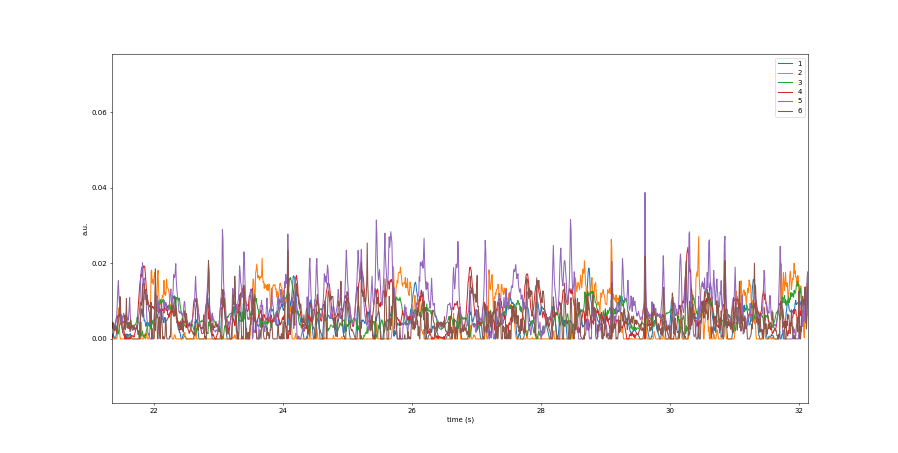

<IPython.core.display.Javascript object>


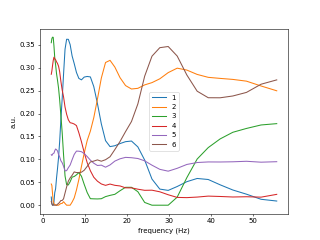

<IPython.core.display.Javascript object>


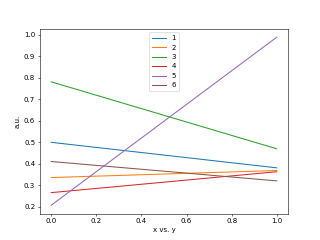

<IPython.core.display.Javascript object>


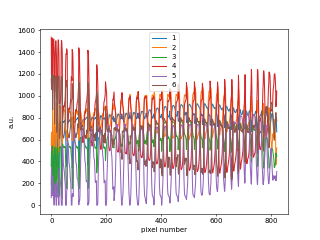

<IPython.core.display.Javascript object>


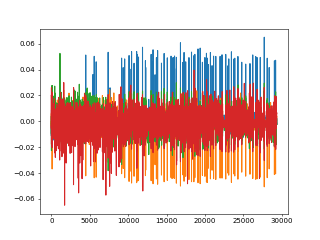

In [13]:
%matplotlib notebook

factors_toUse = factors_np
modelRank = factors_toUse[0].shape[1]
## just for plotting in case 
if 'Fs' not in globals():
    Fs = 120

plt.figure()
# plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
factors_temporal = factors_toUse[2][:,:]
# factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,])
# plt.plot(factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

plt.figure()
plt.plot(freqs_Sxx , (factors_toUse[1][:,:]))
# plt.plot(freqXaxis , (factors_toUse[1][:,:]))
# plt.plot(f , (factors_toUse[1][:,:]))
# plt.plot((factors_toUse[1][:,:]))
plt.legend(np.arange(modelRank)+1)
plt.xlabel('frequency (Hz)')
plt.ylabel('a.u.')
# plt.xscale('log')

plt.figure()
plt.plot(factors_toUse[3][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('x vs. y')
plt.ylabel('a.u.')

plt.figure()
plt.plot(factors_toUse[0][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('pixel number')
plt.ylabel('a.u.')


# plt.figure()
# plt.imshow(np.single(np.corrcoef(factors_toUse[2][:,:])))

input_dimRed = factors_toUse[2][:,:]
# input_dimRed_meanSub = 
pca = sk.decomposition.PCA(n_components=modelRank-2)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

plt.figure()
plt.plot(output_PCA)

In [17]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'
load_name = f'positions_new_absolute_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_new_absolute_sansOutliers = np.load(load_fullPath)

In [20]:
# Display video of factors

factors_toShow = np.arange(factors_np[0].shape[1])  # zero-indexed
# factors_toShow = [3]  # zero-indexed

for factor_iter in factors_toShow:

    # vidNums_toUse = range(numVids) ## note zero indexing!
    vidNums_toUse = 0 ## note zero indexing!

    if type(vidNums_toUse) == int:
        vidNums_toUse = np.array([vidNums_toUse])

    dot_size = 1

    printFPS_pref = 0
    fps_counterPeriod = 10 ## number of frames to do a tic toc over

#     modelRank_toUse = 5
    factor_toShow = factor_iter+1
    save_pref= 0

    # save_dir = "F:\\RH_Local\\Rich data\\camera data"
    save_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
    save_fileName = f'factor {factor_toShow}'
    # save_pathFull = f'{save_dir}\\{save_fileName}.avi'
    save_pathFull = f'{save_dir}/{save_fileName}.avi'

    # ensemble_toUse = ensemble
    ensemble_toUse = factors_np
    positions_toUse = positions_new_absolute_sansOutliers

    factor_toShow = factor_toShow-1
    # input_scores = ensemble_toUse.factors(modelRank_toUse)[0][0]
    input_scores = np.single(ensemble_toUse[0])

    range_toUse = np.ceil(np.max(input_scores[:,factor_toShow]) - np.min(input_scores[:,factor_toShow])) + 1
    offset_toUse = np.min(input_scores[:,factor_toShow])
    scores_norm = input_scores[:,factor_toShow] - offset_toUse
    scores_norm = (scores_norm / np.max(scores_norm)) *1000
    cmap = matplotlib.cm.get_cmap('hot', 1000)
    # cmap_viridis(np.arange(range_toUse))

    colormap_tuples =  list(np.arange(scores_norm.shape[0]))
    for ii in range(.shape[0]):
        colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    if save_pref:
        print(f'saving to file {save_pathFull}')
        out = cv2.VideoWriter(save_pathFull, fourcc, Fs, (np.int64(vid_width), np.int64(vid_height)))


    ## Main loop to pull out displacements in each video   
    ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

    fps = 0
    tic_fps = time.time()
    for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
        path_vid = path_vid_allFiles[vidNum_iter]
        vid = imageio.get_reader(path_vid,  'ffmpeg')

#         numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        numFrames = 1000

#         frameToSet = 0
#         video.set(1,frameToSet)

        for iter_frame , new_frame in enumerate(vid):

#             ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
            if iter_frame >= numFrames:
                break
#             ok, new_frame = video.read()

            for ii in range(positions_toUse.shape[0]):
                pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
                cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
            if save_pref:
                out.write(new_frame)

#             Sxx_frameNum = round( ind_currentVid / (positions_toUse.shape[2] / Sxx_allPixels.shape[2]) ,1)
            cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'frame #: {Sxx_frameNum}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
#             cv2.putText(new_frame, f'vid #: {iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{positions_new_absolute_sansOutliers.shape[2]}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'factor num: {factor_iter+1} / {np.max(factors_toShow)+1}', org=(10,100), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

            ind_concat = ind_concat+1


            if ind_concat%fps_counterPeriod==0:
                elapsed = time.time() - tic_fps
                fps = fps_counterPeriod/elapsed
                if printFPS_pref:
                    print(fps)
                tic_fps = time.time()


out.release()
video.release()
cv2.destroyAllWindows()

IndexError: index 820 is out of bounds for axis 0 with size 820

In [44]:
cv2.destroyAllWindows()

In [ ]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca',
                     random_state=0, perplexity=5000)
X_tsne = tsne.fit_transform(factors_temporal)
print("Finished computing t-SNE embedding")


In [ ]:
factor_toCMap = 1  # 1 indexed

plt.figure(figsize=(5,5))
plt.plot(X_tsne[:,0] , X_tsne[:,1] , linewidth=0.1)
# plt.scatter(X_tsne[:,0] , X_tsne[:,1], 'r.' , markersize=0.6)
plt.scatter(X_tsne[:,0] , X_tsne[:,1] , s=0.3, c=factors_temporal[:,factor_toCMap-1] , cmap='jet')


In [ ]:
# das it

In [40]:
torch.cuda.empty_cache()